<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/maths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Mathematics 🦋**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1000.png)

### <font color="blue">**Algebra**

##### <font color="blue">*Linear Algebra*

> [Linear algebra for Quantum Mechanics](https://www.youtube.com/watch?v=FF05fXg03A0)

###### *Eigenwerte*

**Kriterien fur die Existenz von Eigenwerten**

(*Wenn eine dieser Aussagen wahr ist, dann alle. Und wenn eine falsch, dann sind alle falsch*)

1. $\operatorname{rg}(B) < n$

2. $\operatorname{det}(B) = 0$ -> dieses Kriterium zu prufen ist am einfachsten und daher am haufigsten!

3. $B^{-1}$ existiert nicht (nicht invertierbar)

4. $B \vec{X}$ = 0 hat mehr als nur die Losung $\vec{x}$ = 0

5. $\lambda$ = 0 ist ein Eigenwert von $B$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1192.png)

*Calculating Eigenvalues via determinant: The tweaked transformation squishes space into a lower dimension (Daher muss rang < n sein)*



###### *Rayleigh-Quotient & Satz von Courant-Fischer*

Der [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient), auch Rayleigh-Koeffizient genannt, ist ein Objekt aus der linearen Algebra. 

Der Rayleigh-Quotient wird insbesondere zur numerischen Berechnung von Eigenwerten einer quadratischen Matrix $A$ verwendet.

Sei $A \in {\mathbb K}^{n \times n}$ eine reelle symmetrische oder komplexe hermitesche Matrix und $x\in {\mathbb {K} }^{n}$ mit $x\neq 0$ ein Vektor, dann ist der Rayleigh-Quotient von $A$ zum Vektor $x$ definiert durch:

> $R_{A}(x)={\frac  {x^{*}Ax}{x^{*}x}}$

Der Rayleigh-Quotient hat eine enge Beziehung zu den Eigenwerten von $A$. Ist $v$ ein Eigenvektor der Matrix $A$ und $\lambda$  der zugehörige Eigenwert, dann gilt:

> $R_{A}(v)={\frac  {v^{*}Av}{v^{*}v}}={\frac  {v^{*}\lambda v}{v^{*}v}}=\lambda$

Durch den Rayleigh-Quotienten wird also jeder Eigenvektor von $A$ auf den dazugehörigen Eigenwert $\lambda$ abgebildet. Diese Eigenschaft wird unter anderem in der numerischen Berechnung von Eigenwerten benutzt.

Insbesondere gilt für eine symmetrische oder hermitesche Matrix $A$ mit dem kleinsten Eigenwert $\lambda _{{{\rm {min}}}}$ und dem größten Eigenwert $\lambda _{{{\rm {max}}}}$ nach dem [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) (Der Satz von Courant-Fischer stellt die Eigenwerte einer symmetrischen oder hermiteschen Matrix als minimale beziehungsweise maximale Rayleigh-Quotienten):

> $\lambda _{{{\rm {min}}}}\leq R_{A}(x)\leq \lambda _{{{\rm {max}}}}$

Die Berechnung des kleinsten bzw. größten Eigenwerts ist damit äquivalent zum Auffinden des Minimums bzw. Maximums des Rayleigh-Quotienten. Das lässt sich unter geeigneten Voraussetzungen auch noch auf den unendlichdimensionalen Fall verallgemeinern und ist als Rayleigh-Ritz-Prinzip bekannt.

*Der [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) charakterisiert die Eigenwerte einer symmetrischen positiv definiten (3 × 3)-Matrix über Extrempunkte auf einem Ellipsoid (Der Satz von Courant-Fischer charakterisiert nun die Eigenwerte von $A$ über bestimmte Extrempunkte auf diesem Ellipsoid) - Siehe auch [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ellipsoid_Quadric.png/434px-Ellipsoid_Quadric.png)



###### *Kernel*

**Kernel = Nullspace**

The [kernel of this linear map (linear algebra)](https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)) is the set of solutions to the equation Ax = 0, where 0 is understood as the zero vector.

In algebra, the [kernel (algebra)](https://en.m.wikipedia.org/wiki/Kernel_(algebra)) of a homomorphism (function that preserves the structure) is generally the inverse image of 0.

* The kernel of a homomorphism is reduced to 0 (or 1) if and only if the homomorphism is injective, that is if the inverse image of every element consists of a single element (jedes element im ziel hat nur ein element im ursprung, es kann aber mehr elemente im ziel ohne ein element im ursprung geben).

* This means that the kernel can be viewed as a measure of the degree to which the homomorphism fails to be injective.

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismus2.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/320px-KerIm_2015Joz_L2.png)



der Kern einer linearen Abbildung f genau dann nichttrivial ist, wenn eine linear unabhängige Menge (bzw. genauer Familie) S existiert sodass f(S) linear abhängig ist. Durch Übergang zu den Negationen erhalten wir dann die äquivalente Aussage: 

- kerf = {0} 
- ...genau dann, wenn gilt...
- für alle linear unabhängigen S ist auch f(S) linear unabhängig.

https://www.youtube.com/watch?v=GNf3StvaiFA&list=WL&index=9

###### *Diagonalisierbarkeit*

**[Diagonalisierbarkeit](https://en.m.wikipedia.org/wiki/Diagonalizable_matrix) von Matrizen**:

* **Eigenwerte liegen auf der Diagonalen**. Dabei: Spur = Summer aller Eigenwerte. Determinante = Produkt aller Eigenwerte = 0.

* Square matrix $A$ into **invertible matrix** $P$ and **diagonal matrix** $D$ such that  ${\displaystyle P^{-1}AP=D}$. Approach: [Eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

> $P^{-1} A P=\left[\begin{array}{cccc}
\lambda_1 & 0 & \cdots & 0 \\
0 & \lambda_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \lambda_n
\end{array}\right]$

* Ein rotierender Körper ohne äußere Kräfte verbleibt in seiner Bewegung, wenn er um seine Symmetrieachse rotiert. Wenn eine Basis aus Eigenvektoren existiert, so ist die Darstellungsmatrix bezüglich dieser Basis eine Diagonalmatrix

* *The diagonalization of a symmetric matrix can be interpreted as a rotation of the axes to align them with the eigenvectors:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/4/4e/Diagonalization_as_rotation.gif)




###### *Determinant*

**[Determinante](https://de.m.wikipedia.org/wiki/Determinante)**:

* [Determinante](https://de.m.wikipedia.org/wiki/Determinante) (nur fur quadratischen Matrix - bei $n \cdot m$ Matrizen nutzt man zB SVD)

  * gibt an, wie sich Fläche bzw. Volumen durch linearen Abbildung ändert. det(A) = 4 $\rightarrow$ Matrix vervierfacht Flächeninhalt.

  * gibt an, ob lineares Gleichungssystem lösbar ist (Lösung dann mit der Cramerschen Regel)

  * Determinante ist Produkt aller Eigenwerte: $\prod_{i=1}^{n} \lambda_{i}=\operatorname{det}(A) = 0$

* Berechnung: $\operatorname{det}(A)$: $
A=\left(\begin{array}{ll}
a & c \\
b & d
\end{array}\right)
$ $\rightarrow$ $
\operatorname{det} A=\left|\begin{array}{ll}
a & c \\
b & d
\end{array}\right|=a d-b c
$. *Die 2x2-Determinante **ist gleich dem orientierten Flächeninhalt** des von ihren Spaltenvektoren aufgespannten Parallelogramms:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Area_parallellogram_as_determinant.svg/220px-Area_parallellogram_as_determinant.svg.png)

* [Entwicklungssatz](https://de.m.wikipedia.org/wiki/Determinante#Laplacescher_Entwicklungssatz) oder  [Leibniz-Formel](https://de.m.wikipedia.org/wiki/Determinante#Leibniz-Formel) (geschlossene Form, theoretisch). [Gauß-Algorithmus](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren) in Dreiecksform - Determinante ist Produkt der [Hauptdiagonale](https://de.m.wikipedia.org/wiki/Hauptdiagonale). Computeralgorithmus: [LU-Zerlegung](https://de.m.wikipedia.org/wiki/Gau%C3%9Fsches_Eliminationsverfahren#LR-Zerlegung). 

Take this $2 \times 2$ matrix:

> $
A=\left[\begin{array}{ll}
1 & 0 \\
2 & 1
\end{array}\right]
$

Its [characteristic polynomial](https://en.m.wikipedia.org/wiki/Characteristic_polynomial) (=has the eigenvalues as roots, and it has the determinant and the trace / sum o fEigenvalues of the matrix among its coefficients):

> <font color="red">$f(\lambda) = \operatorname{det}(A) = 0$</font> $\quad (= \prod_{i=1}^{n} \lambda_{i})$

> $\begin{aligned} f(\lambda) & =\operatorname{det}\left(\lambda\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]-\left[\begin{array}{ll}1 & 0 \\ 2 & 1\end{array}\right]\right) \\ & =\operatorname{det}\left(\left[\begin{array}{cc}\lambda-1 & 0 \\ -2 & \lambda-1\end{array}\right]\right) \\ & =(\lambda-1) \cdot(\lambda-1)-0 \cdot(-2) \\ & =(\lambda-1) \cdot(\lambda-1)\end{aligned}$

The roots of the polynomial, that is, <font color="red">**the solutions of $f(\lambda) = 0$** (determinant is equal to zero, Eigenvalues are "coefficients in characteristic polynomial" (it's trace to be precise))</font> are:

>$
\begin{aligned}
& \lambda_1=1 \\
& \lambda_2=1
\end{aligned}
$

###### *Characteristics polynomial (Fundamental theorem of algebra)*

[Characteristics polynomial](https://en.m.wikipedia.org/wiki/Characteristic_polynomial) = has the Eigenvalues as [roots](https://en.m.wikipedia.org/wiki/Zero_of_a_function) (zero of a function)

Root (Zero of a function): The function f attains the value of 0 at x, or equivalently, x is the solution to the equation f(x) = 0. A root of a polynomial is a zero of the corresponding polynomial function. The [fundamental theorem of algebra](https://en.m.wikipedia.org/wiki/Fundamental_theorem_of_algebra) shows that any non-zero polynomial has a number of roots at most equal to its degree.

For example, the polynomial f of degree two, defined by $f(x)=x^{2}-5x+6$ has the two roots (or zeros) that are $\lambda_1=2$ and $\lambda_2=3$: 

> ${\displaystyle f(2)=2^{2}-5\times 2+6=0{\text{ and }}f(3)=3^{2}-5\times 3+6=0.}$

<font color="red">Zero of a function is important because every equation in the unknown x may be rewritten as $f(x)=0$ by regrouping all the terms in the left-hand side. Hence the study of zeros of functions is exactly the same as the study of solutions of equations.</font> 

Siehe [Nullstellen](https://de.m.wikipedia.org/wiki/Nullstelle) sind bei einer Funktion diejenigen Werte der Ausgangsmenge (des Definitionsbereichs D), bei denen das im Rahmen der Abbildung zugeordnete Element der Zielmenge (des Wertebereichs W) die Null ist (${\displaystyle 0\in W}$). Nullstellen von Polynomfunktionen werden auch als Wurzeln bezeichnet. 

[Kern](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) is Lösungsmenge der [homogenen linearen Gleichung](https://de.m.wikipedia.org/wiki/Lineare_Gleichung) f(x)=0 und wird hier auch Nullraum genannt (denjenigen Vektoren in V, die auf den Nullvektor in W abgebildet werden)

Example: A graph of the function $\cos (x)$ for $x$ in $[-2 \pi, 2 \pi]$, with zeros at $-\frac{3 \pi}{2},-\frac{\pi}{2}, \frac{\pi}{2}$, and $\frac{3 \pi}{2}$, marked in red.


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/X-intercepts.svg/480px-X-intercepts.svg.png)



###### *Invertible Matrix*

**Invertible Matrix**

* ($B^{-1}$ existiert nicht (Matrix nicht invertierbar) $\rightarrow$ dann existieren Eigenwerte)

* [Invertible matrix](https://en.m.wikipedia.org/wiki/Invertible_matrix) is used in methods to solve systems of linear equations and **help to get Eigenvalues**

> Apply Eigendecomposition to matrix (or other method) $\rightarrow$ Get matrix inverse (with Eigenvectors and a diagonal with Eigenvalues) $\rightarrow$ Solve systems of linear equations 

* You can also use pseudo-inverse [Moore-Penrose](https://en.m.wikipedia.org/wiki/Moore–Penrose_inverse) with [matrix solution](https://en.m.wikipedia.org/wiki/System_of_linear_equations#Matrix_solution) to solve systems of linear equations or in [curve fitting](https://de.wikipedia.org/wiki/Ausgleichungsrechnung) (like regression or ML). Methods: QR, Cholesky, Rank decomposition, SVD. 'The pseudoinverse provides a [Linear Least Squares](https://en.m.wikipedia.org/wiki/Linear_least_squares) solution to a system of linear equations.'

  * Exkurs: [Linear least squares (LLS)](https://en.wikipedia.org/wiki/Linear_least_squares) for solving systems of linear equations: is the least squares approximation of linear functions to data (linear regression). **Numerical methods include inverting the matrix of the normal equations and orthogonal decomposition methods**.

  * **Overdetermined case**: A common use of the pseudoinverse is to compute a "best fit" (least squares) solution to a system of linear equations that lacks a solution. See under [Applications](https://en.m.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Applications)

  * **Underdetermined case**: Another use is to find the minimum (Euclidean) norm solution to a system of linear equations with multiple solutions. [Underdetermined system](https://en.m.wikipedia.org/wiki/Underdetermined_system): there are **fewer equations than unknowns**. Has an infinite number of solutions, if any. In optimization problems that are subject to linear equality constraints, only one of the solutions is relevant, namely the one giving the **highest or lowest value of an objective function**. The use of the **(Moore Pensore) pseudoinverse is to find the minimum (Euclidean) norm solution** to a system of linear equations with multiple solutions. Can be computed using the singular value decomposition. *Example: The solution set for two equations in three variables is, in general, a line ([Source](https://en.m.wikipedia.org/wiki/System_of_linear_equations#General_behavior)):*

  ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Intersecting_Planes_2.svg/240px-Intersecting_Planes_2.svg.png)

* [Methods to compute inverse of matrix](https://en.m.wikipedia.org/wiki/Invertible_matrix#Methods_of_matrix_inversion): Gaussian elimination, Newton's method, Cayley–Hamilton method, Eigendecomposition, Cholesky decomposition, Analytic solution (Cramer's rule), Blockwise inversion.

* Example: If matrix A can be [eigendecomposed](https://en.m.wikipedia.org/wiki/Invertible_matrix), and if none of its eigenvalues are zero, then A is invertible and its inverse is given by

>${\displaystyle \mathbf {A} ^{-1}=\mathbf {Q} \mathbf {\Lambda } ^{-1}\mathbf {Q} ^{-1}}$

* where $\mathbf {Q}$  is the square ($N×N$) matrix whose i-th column is the **eigenvector** $q_{i}$ of $\mathbf {A}$
* ${\displaystyle \mathbf {\Lambda } }$ is the diagonal matrix whose diagonal elements are the corresponding **eigenvalues** ${\displaystyle \Lambda _{ii}=\lambda _{i}}$. 

###### *Rank*

**Rank of a matrix**


The rank of a matrix is the number of linearly independent vectors (columns).

So **low rank is a low number** of linearly independent vectors. A low rank matrix can be this:

1

2

3


* a low rank matrix (whether approximation or not) is simply a matrix for which the number of linearly independent row or columns is much smaller than the actual number of rows or columns. 

* Viewed as a linear transformation, the span of its range is small or the span of its null space is large.

* Quantum computers give exponential speedups for high rank matrices

**Exkurs: Sparse Matrix vs Low Rank Matrix**

Sparse matrices and low-rank matrices are two very different types of objects. The matrix

$\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 2 & 0 & 0 \\ 0 & 0 & 3 & 0 \\ 0 & 0 & 0 & 4\end{array}\right]$


is sparse (meaning it has a lot of zero entries) but not low-rank (as a matter of fact it’s full rank). On the other hand, the matrix

$\left[\begin{array}{cccc}1 & 2 & 3 & 4 \\ 2 & 4 & 6 & 8 \\ 3 & 6 & 9 & 12 \\ 4 & 8 & 12 & 16\end{array}\right]$

is low-rank but not sparse!

There's however a connection to be made between the two concepts: **a low-rank matrix has a sparse set of singular values**. 

Take the following singular value decomposition for a general matrix $\mathrm{X}$

> $
\mathrm{X}=\mathrm{USV}^T
$

Then the number of non-zero entries in (the diagonal of) $S$ is precisely equal to the rank of $\mathbf{X}$. Thus, a sparse $\mathbf{S}$ leads to a low-rank $\mathbf{X}$ and vice-versa.


###### *Algebraic and geometric multiplicity of eigenvalues*

**Algebraic and geometric multiplicity of eigenvalues**

> Two or more distinct eigenvalues = algebraic multiplicity

> By how many linearly independent vectors is the Eigenspace of $\lambda_1$ (which is an Eigenvalue with multiplicity 1 or more) formed? = geometric multiplicity

> Geometric multiplicity is max equal or less than its algebraic multiplicity

> When the geometric multiplicity of a repeated eigenvalue is **strictly less** than its algebraic multiplicity, then that eigenvalue is said to be **defective**

https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#Eigenspaces,_geometric_multiplicity,_and_the_eigenbasis_for_matrices

https://en.m.wikipedia.org/wiki/Multiplicity_(mathematics)#Multiplicity_of_a_root_of_a_polynomial

*algebraic multiplicity*

The **algebraic multiplicity** of an eigenvalue is the number of times it appears as a root of the characteristic polynomial (i.e., the polynomial whose roots are the eigenvalues of a matrix).


Take this $2 \times 2$ matrix:

> $
A=\left[\begin{array}{ll}
1 & 0 \\
2 & 1
\end{array}\right]
$

Its characteristic polynomial is:

> $\begin{aligned} f(\lambda) & =\operatorname{det}\left(\lambda\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]-\left[\begin{array}{ll}1 & 0 \\ 2 & 1\end{array}\right]\right) \\ & =\operatorname{det}\left(\left[\begin{array}{cc}\lambda-1 & 0 \\ -2 & \lambda-1\end{array}\right]\right) \\ & =(\lambda-1) \cdot(\lambda-1)-0 \cdot(-2) \\ & =(\lambda-1) \cdot(\lambda-1)\end{aligned}$

The roots of the polynomial, that is, the solutions of $f(\lambda) = 0$  are:

>$
\begin{aligned}
& \lambda_1=1 \\
& \lambda_2=1
\end{aligned}
$

Thus, $A$ has one repeated eigenvalue whose algebraic multiplicity is

>$
\mu\left(\lambda_1\right)=\mu\left(\lambda_2\right)=2
$

*geometric multiplicity*

The **geometric multiplicity** of an eigenvalue is the dimension of the linear space of its associated eigenvectors (i.e., its eigenspace).

If the Eigenspace of $\lambda_1$ is generated only by a single vector, it has dimension 1. As a consequence, the geometric multiplicity of $\lambda_1$ is 1, less than its algebraic multiplicity, which is equal to 2.

See complete example in [this pdf document](https://raw.githubusercontent.com/deltorobarba/repo/master/multiplicity.pdf).

###### *Condition Numbers*

**Condition Numbers**

https://blogs.mathworks.com/cleve/2017/07/17/what-is-the-condition-number-of-a-matrix/

###### *Get Eigenvalues: **Algorithms** (Power & Inverse Iteration, Charakteristisches Polynom) & **Matrix Decomposition** (Eigendecomposition/Spectrum, Schur, SVD)*

> [Eigenvalue algorithm](https://en.m.wikipedia.org/wiki/Eigenvalue_algorithm) - matrices are diagonalized numerically using computer software. See [List of Eigenvalue algorithms](https://en.m.wikipedia.org/wiki/List_of_numerical_analysis_topics#Eigenvalue_algorithms).

**Small Matrices: Ermittlung der Eigenwerte der Matrix $A$ mit Determinante und charakteristischem Polynom**

In practice, eigenvalues of large matrices are not computed using the characteristic polynomial [Source](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Numerical_computations)

> $A=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)$

**Step 1: Bilde mit der Einheitsmatrix $E_{n}$ die Matrix $\left(A-\lambda E_{n}\right)$**

> $\left(A-\lambda E_{n}\right)=\left(\begin{array}{lll}2 & 1 & 2 \\ 1 & 2 & 2 \\ 1 & 1 & 3\end{array}\right)-\left(\begin{array}{ccc}\lambda & 0 & 0 \\ 0 & \lambda & 0 \\ 0 & 0 & \lambda\end{array}\right)=\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$

**Step 2: Berechne die Determinante von $\operatorname{det}\left(A-\lambda E_{n}\right) = \chi_{A}(\lambda)$ $\rightarrow$ [charakteristisches Polynom](https://de.m.wikipedia.org/wiki/Charakteristisches_Polynom)**

> $\operatorname{det}\left(A-\lambda E_{n}\right)=\operatorname{det}\left(\begin{array}{ccc}2-\lambda & 1 & 2 \\ 1 & 2-\lambda & 2 \\ 1 & 1 & 3-\lambda\end{array}\right)$

$=(2-\lambda)^{2} \cdot(3-\lambda)+2+2-2 \cdot(2-\lambda)-2 \cdot(2-\lambda)-(3-\lambda)$
$=-\lambda^{3}+7 \lambda^{2}-11 \lambda+5$ $\quad$ (= Polynom)

**Step 3: Bestimme die Nullstellen des charakteristischen Polynoms, weil das sind die Eigenwerte der Matrix $A$ (und Determinante wird Null)**

> $(A-\lambda E_{n}) \cdot v=0$

* Durch Ausprobieren: erste Nullstelle $\lambda_{1}=1$.

* Klammern wir dann den Faktor $(\lambda-1)$ aus, erhalten wir:
$-\lambda^{3}+7 \lambda^{2}-11 \lambda+5=(\lambda-1) \cdot\left(-\lambda^{2}+6 \lambda-5\right)
$. 

* Anwendung der [Mitternachtsformel](https://de.m.wikipedia.org/wiki/Quadratische_Gleichung#Lösungsformel_für_die_allgemeine_quadratische_Gleichung_(a-b-c-Formel)): $
\lambda_{2,3}=\frac{-6 \pm \sqrt{36-20}}{-2}=3 \mp 2$

* Somit lauten die drei Eigenwerte der Matrix $\lambda_{1}=\lambda_{2}=1$ sowie $\lambda_{3}=5$

*Gibt es eine Zahl $\lambda$ und einen Vektor $v$, sodass dieser durch Multiplikation mit der Matrix $\left(A-\lambda E_{n}\right)$ auf den Nullvektor abgebildet wird, so ist diese Matrix nicht von vollem Rang. Das bedeutet, dass ihre Determinante Null ist. Vektoren wie $v$ und $w$ sind linear abhängig.*





**Eigendecomposition (spectral decomposition)**

* [Eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) or sometimes spectral decomposition, see [spectral theorem](https://en.m.wikipedia.org/wiki/Spectral_theorem), is the factorization of a matrix into a canonical form (Normalform) - the matrix is represented in terms of its eigenvalues and eigenvectors. Matrix must be diagonalizable. See also [Summary of Eigendecomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition#Decompositions_based_on_eigenvalues_and_related_concepts).

> ${\displaystyle A=VDV^{-1}}A=VDV^{{-1}}$

* $D$ = eigenvalues of $A$ (diagonal)
* $V$ = eigenvectors of $A$

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

**Schur decomposition**

* [Schur decomposition](https://en.m.wikipedia.org/wiki/Schur_decomposition) is a [matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition). 

* Take complex square matrix and **get an upper triangular matrix whose diagonal elements are the eigenvalues** of the original matrix.

**Singular Value Decomposition**

* [Singular Value Decomposition](https://de.m.wikipedia.org/wiki/Singulärwertzerlegung) is used in calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning. 

* SVD can also be used in least squares linear regression, image compression, and denoising data. Siehe auch [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm)


###### *Solving Systems of Linear Equations: **Matrix Decomposition** (Gaussian Elimination, Cholesky, QR, LU)*

Classical: [Gaussian Elimination](https://en.m.wikipedia.org/wiki/Gaussian_elimination) (row reduction). See [List of numerical algorithms to solve systems of linear equation](https://en.m.wikipedia.org/wiki/List_of_numerical_analysis_topics#Solving_systems_of_linear_equations)

**Cholesky Decomposition** (Hermitian / squared)

* **alternative to Eigendecomposition** to get matrix inverse for solving linear equations

* [Cholesky decomposition](https://en.m.wikipedia.org/wiki/Cholesky_decomposition) of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose, 

* useful for efficient numerical solutions, e.g., Monte Carlo simulations (solving linear least squares for linear regression, as well as simulation and optimization methods)

* When it is applicable, the Cholesky decomposition is roughly twice as efficient as the LU decomposition for solving systems of linear equations.

> $A = LL^T$

* $L$ is the lower triangular matrix and $L^T$ is the transpose of L. Decompose as the product of upper triangular matrix $U$ is also possible

**QR Decomposition**

* We can use QR decomposition to [find the determinant of a square matrix](https://en.m.wikipedia.org/wiki/QR_decomposition#Connection_to_a_determinant_or_a_product_of_eigenvalues)

* The [QR decomposition](https://en.m.wikipedia.org/wiki/QR_decomposition) is for m x n matrices (not limited to square matrices) and decomposes a matrix into $Q$ (orthogonal $Q^T Q = I$ or unitary $Q \cdot Q = I$, size m x m) and $R$ (upper triangle matrix with the size m x n) components.

> $A = Q R$

* Like the LU decomposition, the QR decomposition is often used to solve systems of linear equations, **although is <u>not</u> limited to square matrices**.

* There are several methods for actually computing the QR decomposition, such as by [Householder transformations](https://de.m.wikipedia.org/wiki/Householdertransformation), [Givens rotations](https://de.m.wikipedia.org/wiki/Givens-Rotation) and  [Gram-Schmidtsch's orthogonalization method](https://de.m.wikipedia.org/wiki/Gram-Schmidtsches_Orthogonalisierungsverfahren)

**LU Decomposition**

* The [LU decomposition](https://en.m.wikipedia.org/wiki/LU_decomposition) is often used to simplify the **solving of systems of linear equations**, such as **finding the coefficients in a linear regression**, as well as in **calculating the determinant and inverse** of a matrix.

* Lower–upper (LU) decomposition or factorization factors a matrix as the product of a lower triangular matrix and an upper triangular matrix. 

* The product sometimes includes a permutation matrix as well. LU decomposition can be viewed as the matrix form of Gaussian elimination. 

* Computers usually solve square systems of linear equations using LU decomposition, and it is also a key step when inverting a matrix or computing the determinant of a matrix.

The **LU decomposition is for square matrices** and decomposes a matrix into L and U components. Let A be a square matrix. An LU factorization refers to the factorization of A, with proper row and/or column orderings or permutations, into two factors – a **lower triangular matrix L** and an **upper triangular matrix U**:

> A = L U

* The LU decomposition is found using an <u>iterative numerical process</u> and **can fail for those matrices that cannot be decomposed or decomposed easily**.

* In the lower triangular matrix all elements above the diagonal are zero, in the upper triangular matrix, all the elements below the diagonal are zero. For example, for a 3 × 3 matrix A, its LU decomposition looks like this:

> $\left[\begin{array}{lll}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{array}\right]=\left[\begin{array}{ccc}
l_{11} & 0 & 0 \\
l_{21} & l_{22} & 0 \\
l_{31} & l_{32} & l_{33}
\end{array}\right]\left[\begin{array}{ccc}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{array}\right]$

###### *Solving Systems of Linear Equations: **Matrix Type** (Squared & Non-Squared)*

**Part I: Solving Systems of Linear Equations: <u>Squared Matrix</u> (for HHL) - Eigendecomposition to get Pseudo-inverse**

> https://towardsdatascience.com/from-eigendecomposition-to-determinant-fundamental-mathematics-for-machine-learning-with-1b6b449a82c6


<font color="red">**If A is squared is a matrix (and has [full rank](https://de.m.wikipedia.org/wiki/Rang_(Mathematik))) in a linear system of equations: Getting the matrix inverse via Eigendecomposition (pseudoinverse Moore-Penrose provides a least squares solution to a system of linear equations.')**

> $A x = b$

then you can take the [inverse](https://de.m.wikipedia.org/wiki/Inverse_Matrix) if A to solve for x:

> $x = A^{-1} b$

<font color="red">*This part is important for HHL:*

* $\hat{A} = \hat{A}^{\dagger}$ $\quad$ - Hermitian operators are [Self-adjoint operators](https://en.m.wikipedia.org/wiki/Self-adjoint_operator)

* Adjungierte Matrix = transponiert + complex konjugiert (Vorzeichen umgekehrt). Hermetian: selbstadjunktiert = symmetrisch

* Following from this, in bra-ket notation: $
\left\langle\phi_{i}|\hat{A}| \phi_{j}\right\rangle=\left\langle\phi_{j}|\hat{A}| \phi_{i}\right\rangle^{*}
$


<font color="red">*Since $A$ is Hermitian, it has a spectral decomposition : $
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$*

<font color="red">*You need the Eigendecomposition (spectral decomposition) to get the inverse of a matrix (=here unitary and hence normal)*

Getting the [Matrix inverse via eigendecomposition](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Matrix_inverse_via_eigendecomposition): If a matrix $\mathbf{A}$ can be eigendecomposed and if none of its eigenvalues are zero, then $\mathbf{A}$ is invertible and its inverse is given by

>$
\mathbf{A}^{-1}=\mathbf{Q}^{-1} \mathbf{\Lambda}^{-1} \mathbf{Q}
$

If $\mathbf{A}$ is a symmetric matrix, since $\mathbf{Q}$ is formed from the eigenvectors of $\mathbf{A}, \mathbf{Q}$ is guaranteed to be an orthogonal matrix, therefore $\mathbf{Q}^{-1}=\mathbf{Q}^{\mathrm{T}}$. Furthermore, because $\mathbf{\Lambda}$ is a diagonal matrix, its inverse is easy to calculate:

>$
\left[\Lambda^{-1}\right]_{i i}=\frac{1}{\lambda_{i}}
$

**Example - the matrix:**

$A=\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]$

has the eigenvectors:

$\mathbf{u}_{1}=\left[\begin{array}{l}3 \\ 2\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{1}=4$

and:

$\mathbf{u}_{2}=\left[\begin{array}{r}-1 \\ 1\end{array}\right] \quad$ with eigenvalue $\quad \lambda_{2}=-1$

We can verify (as illustrated in Figure 1) that only the length of $\mathbf{u}_{1}$ and $\mathbf{u}_{2}$ is changed when one of these two vectors is multiplied by the matrix $\mathbf{A}$ :


$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{l}3 \\ 2\end{array}\right]=4\left[\begin{array}{l}3 \\ 2\end{array}\right]=\left[\begin{array}{c}12 \\ 8\end{array}\right]$

and

$\left[\begin{array}{ll}2 & 3 \\ 2 & 1\end{array}\right]\left[\begin{array}{r}-1 \\ 1\end{array}\right]=-1\left[\begin{array}{r}-1 \\ 1\end{array}\right]=\left[\begin{array}{r}1 \\ -1\end{array}\right]$

For most applications we normalize the eigenvectors (i.e. transform them such that their length is equal to one):

$
\mathbf{u}^{\top} \mathbf{u}=1 \text {. }
$

For the previous example we obtain:

$
\mathbf{u}_{1}=\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

Exkurs: wie man einen Vektor normiert:

1) Betrag von $\left(\begin{array}{l}3 \\ 2\end{array}\right)$ ist gleich $\sqrt{3^{2}+2^{2}}=3.6055$ Vektor normieren, also mit 1/Betrag malnehmen:

2) $
\frac{1}{3.6055} \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right)= 0.27735 \cdot\left(\begin{array}{l}
3 \\
2
\end{array}\right) =\left(\begin{array}{l}
.8331 \\
.5547
\end{array}\right)
$


We can check that:

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]=\left[\begin{array}{l}
3.3284 \\
2.2188
\end{array}\right]=4\left[\begin{array}{l}
.8331 \\
.5547
\end{array}\right]
$

and

$
\left[\begin{array}{ll}
2 & 3 \\
2 & 1
\end{array}\right]\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]=\left[\begin{array}{r}
.7071 \\
-.7071
\end{array}\right]=-1\left[\begin{array}{r}
-.7071 \\
.7071
\end{array}\right]
$




**Part II: Solving Systems of Linear Equations: <u>Non-Squared Matrix</u> - Singular value decomposition (SVD) to get Pseudo-inverse**

<font color="red">**If a matrix A is not squared: singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.**

> $A x = b$ $\quad$ ($A$ is not regular)

You multiply both sides by the $A^{T}$, which is the transpose of A:

> $A^{T} A x = A^{T} b$

Then move $A^{T} A$ on right side (by taking their inverse). This is not the original x anymore, but the [least squares](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate#Lineare_Modellfunktion) $\hat{x}$

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

And that term <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> is know as (Moore–Penrose) pseudo-inverse <font color="blue">$A^{+}$</font>:

> $\hat{x} =$ <font color="blue">$A^{+}$</font> $b$

And a pseudo-inverse is nothing else than our least-squares solutions. See more details under [Numerical methods for linear least squares](https://en.m.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares)

*In linear algebra, the singular value decomposition (SVD) is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m\times n$ matrix. It is related to the polar decomposition.*

* non squared matrix

* to solve you need the inverse, but normal eigendecomposition doesn work

> you need to compute mooore penrose pseudo-inverse, and here you need to apply singular value decomposition to get eigendecomposition

* SVD is a type of [Matrix decomposition](https://en.m.wikipedia.org/wiki/Matrix_decomposition), specicially one based on eigenvalue concepts. and SVD is a full rank decomposition (besides broader [Rank factorization methods](https://en.m.wikipedia.org/wiki/Rank_factorization))

* matrix decompositions in general are used to take a large matrix apart (i.e. factorizes a matrix into a lower triangular matrix L and an upper triangular matrix U) so the new matrices require fewer additions and multiplications to solve, compared with the original system $A\mathbf {x} =\mathbf {b}$

<font color="red">**Example:**

> $A x = b$

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right] x=\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

* We can immediately see that matrix A is of rank 2 because the first two rows are multiples of each other (2 and -2 and -2 and 2), just the last row numbers are not multiples of each other (5 and 3).

* Now we can apply the pseudo-inverse to find the least-squares solution:

> $\hat{x} =$ <font color="blue">$(A^{T} A)^{-1} A^{T}$</font> $b$

> $\hat{x}=$ <font color="blue">$\left(\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\right)^{-1}\left[\begin{array}{ccc}2 & -2 & 5 \\ -2 & 2 & 3\end{array}\right]$</font>$\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

> $\hat{x}=$$\left[\begin{array}{l}-4 \\ -2\end{array}\right]$


*Inserting the least-squares $\hat{x}$ into the original equation:*

> $\left[\begin{array}{cc}2 & -2 \\ -2 & 2 \\ 5 & 3\end{array}\right]\left[\begin{array}{l}-4 \\ -3\end{array}\right]$ = $\left[\begin{array}{c}2 \cdot(-4)+(-2) \cdot(-3) \\ (-2)\cdot (-4)+2 \cdot (-3) \\ 5\cdot (-4)+3 \cdot (-3)\end{array}\right]$ = $\left[\begin{array}{c}-2 \\ 2 \\ -29\end{array}\right]$ $\approx$ $\left[\begin{array}{c}-1 \\ 7 \\ -26\end{array}\right]$

###### *Quantum-inspired Algorithms*

https://www.hpcwire.com/2022/11/03/quantum-annealing-pioneer-d-wave-introduces-expanded-hybrid-solver/

Ewin Tang: [A quantum-inspired classical algorithm for recommendation systems](https://arxiv.org/abs/1807.04271)

https://www.youtube.com/watch?v=P2Bucnq_ap0

https://arxiv.org/abs/1905.10415 with https://www.math.cmu.edu/~af1p/Texfiles/SVD.pdf

* There are two ways to compute the average of many values. A first method is to add all of them together and divide the result by the total number of values. An alternative approach is to select a few values at random, then compute their average using the first method. Of course, in the second case we get only an approximation of the true average, but in many cases that is good enough and can be done in significantly less time. 

* **This is the strategy of quantum-inspired algorithms: the coefficients of the solution vector are inner products between vectors, which can be expressed as the average of a collection of numbers that depend on the entries of the vectors**. Instead of directly computing this average (which takes linear time) we select a few of the values at random and compute their average instead. 

* The question is, how many values do we need to sample to get a good approximation? It turns out that **the number of samples grows with the precision of the approximation, the rank, and the condition number of the input matrix.** 

* In practice, this estimation method is only faster than a direct calculation of the coefficients if (i) precision, rank, and condition number are small, and (ii) the input matrix has a colossal dimension.

* (..)

* In practice, it pays off to be slightly more sophisticated: we keep each number with likelihood proportional to its value, such that large numbers are kept with high probability and small numbers with low probability. This is the basis of a technique called [rejection sampling](https://en.m.wikipedia.org/wiki/Rejection_sampling), **which is employed in quantum-inspired algorithms to sample from the solution vectors**. Once the approximate singular value decomposition has been obtained and the coefficients have been estimated, it is possible to query any entry of the solution vector in sublinear time.

https://medium.com/xanaduai/everything-you-always-wanted-to-know-about-quantum-inspired-algorithms-38ee1a0e30ef

https://cstheory.stackexchange.com/questions/42338/list-of-quantum-inspired-algorithms

https://github.com/XanaduAI/quantum-inspired-algorithms

Simulated annealing (inspired) vs quantum annealing (with quantum tunneling):

https://learn.microsoft.com/en-us/azure/quantum/optimization-overview-introduction


##### <font color="blue">*Algebraic Graph Theory*

###### *Algebraic Graph Theory*

**Graph & Graph Theory**

* In [discrete mathematics](https://en.m.wikipedia.org/wiki/Discrete_mathematics), and more specifically in [graph theory](https://en.m.wikipedia.org/wiki/Graph_theory), a graph is a structure amounting to a set of objects in which some pairs of the objects are in some sense "related". 

* The objects correspond to mathematical abstractions called vertices (also called nodes or points) and each of the related pairs of vertices is called an edge (also called link or line).


**Algebraic Graph Theory**

* [Algebraic graph theory](https://en.m.wikipedia.org/wiki/Algebraic_graph_theory) is a branch of mathematics in which algebraic methods are applied to problems about graphs. This is in contrast to geometric, combinatoric, or algorithmic approaches. 

* There are three main branches of algebraic graph theory, involving the use of linear algebra, the use of group theory, and the study of graph invariants.

* **Using linear algebra**: 

  * The first branch of algebraic graph theory involves the study of graphs in connection with linear algebra. Especially, it studies the [spectrum (Eigendecomposition of a matrix)](https://en.m.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of the adjacency matrix, or the Laplacian matrix of a graph - this part of algebraic graph theory is also called [spectral graph theory](https://en.m.wikipedia.org/wiki/Spectral_graph_theory).

  * **Several theorems relate properties of the spectrum to other [graph properties (invariant)](https://en.m.wikipedia.org/wiki/Graph_property).** As a simple example, a connected graph with diameter D will have at least D+1 distinct values in its spectrum. Aspects of graph spectra have been used in analysing the synchronizability of networks.

* Video: [Daniel Spielman “Miracles of Algebraic Graph Theory”](https://www.youtube.com/watch?v=CDMQR422LGM)

* Video: [The Unreasonable Effectiveness of Spectral Graph Theory: A Confluence of Algorithms, Geometry and Physics](https://www.youtube.com/watch?v=8XJes6XFjxM)

*Types of Graphs*

**Complete graph**

* In graph theory, a [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) is a simple undirected graph in which every pair of distinct vertices is connected by a unique edge. 

* A complete digraph is a directed graph in which every pair of distinct vertices is connected by a pair of unique edges (one in each direction).

*K7, a complete graph with 7 vertices with $n$ vertices and ${\displaystyle \textstyle {\frac {n(n-1)}{2}}}$ edges*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Complete_graph_K7.svg/245px-Complete_graph_K7.svg.png)



**Complete bipartite graph**

* [Complete bipartite graph](https://en.m.wikipedia.org/wiki/Complete_bipartite_graph) (or biclique), a special [bipartite graph](https://en.m.wikipedia.org/wiki/Bipartite_graph) where every vertex on one side of the bipartition is connected to every vertex on the other side

* A complete bipartite graph with m = 5 and n = 3:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Biclique_K_3_5.svg/320px-Biclique_K_3_5.svg.png)

Bipartite Graph https://www.youtube.com/watch?v=HqlUbSA9cEY



**Directed vs Undirected Graphs**

The applications for directed graphs are many and varied. They can be used to analyze electrical circuits, develop project schedules, find shortest routes, analyze social relationships, and construct models for the analysis and solution of many other problems.

https://faculty.cs.niu.edu/~freedman/241/241notes/241graph.htm


Undirected graphs are more restrictive kinds of graphs. They represent only whether or not a relationship exists between two vertices. They don't however represent a distinction between subject and object in that relationship. One type of graph can sometimes be used to approximate the other.

https://www.baeldung.com/cs/graphs-directed-vs-undirected-graph

**Hamiltonian path**

A [Hamiltonian path](https://en.m.wikipedia.org/wiki/Hamiltonian_path) (or traceable path) is a path in an undirected or directed graph that visits each vertex exactly once. A Hamiltonian cycle around a network of six vertices:

![gg](https://upload.wikimedia.org/wikipedia/commons/b/be/Hamiltonian.png)

###### *Graph Properties*

**Length** is the number of edges in a graph.

A **closed walk** occurs when x = y.

A **trail** is a walk with no repeated edges.

A closed trail is a **circuit**.

A **path** is a walk with no repeated vertices (A path is a sequence of distinct edges you can follow through the graph)

A closed path is a **cycle** (and circuit)

A **simple graph** is loop-free, undirected and has no multiple edges.

[INTRODUCTION to GRAPH THEORY - DISCRETE MATHEMATICS](https://www.youtube.com/watch?v=HkNdNpKUByM)

[Introduction to Graph Theory: A Computer Science Perspective](https://www.youtube.com/watch?v=LFKZLXVO-Dg)


**Wichtige Zyklen und Pfade in der Graphentheorie**

* [**Eulerian path** (Eulerkreisproblem)](https://de.m.wikipedia.org/wiki/Eulerkreisproblem) = every edge only once
  * **Euler path** (every edge once only, vertices can be multiple: exists if either 0 or 2 odd degree vertices exist with all else even degree
  * **Euler circuit** (more constraint): same as Euler path, but return to starting point (das Haus vom weihachtsmann). Use also Fleurys algorithm: works if all vertices have even degrees

* [**Hamiltonian circuit** (Hamiltonian path problem)](https://de.m.wikipedia.org/wiki/Hamiltonkreisproblem): every vertex only once
  * every vertex only once, but edges don‘t matter how often. And return to starting point. 
  * **Minimum cost hamiltonian circuit = [traveling salesman problem](https://de.m.wikipedia.org/wiki/Problem_des_Handlungsreisenden).**. Is np-complete. Look for [shortest path](https://de.m.wikipedia.org/wiki/Kürzester_Pfad), siehe auch [Pathfinding](https://de.m.wikipedia.org/wiki/Pathfinding)
  * https://www.quora.com/Why-are-quantum-computers-unable-to-solve-the-travelling-salesman-problem-in-polynomial-time: *Quantum computation offers speed improvements for some very specialized problems like integer factorization, but it isn’t known or expected to offer polynomial-time algorithms for generic NP-complete problems like the Traveling Salesman Problem. If it does then NP ⊆ BQP, and most experts don’t regard this as likely at all $^{*}$*.
  * Heuristic algorithms as alternative to brute force:
    * [Dijkstra algorithmus](https://de.m.wikipedia.org/wiki/Dijkstra-Algorithmus)
    * Nearest neighbor algorithm is a heuristic, non optimal, but feasible - [greedy algorithm](https://de.m.wikipedia.org/wiki/Greedy-Algorithmus), cheapest route
    * Repeated Nearest neighbor algorithm
    * Sorted edges algorithm
    * Kruskal algorithm (spanning tree) for minimum cost spanning tree (optimal and efficient). For example energy lines

If you have a fully connected [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) and and want to compute unique Hamiltonain circuits:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1389.png)

Source: [Graph theory full course for Beginners](https://www.youtube.com/watch?v=sWsXBY19o8I)

$^{*}$ *Why can’t a quantum computer solve NP complete problems in a polynomial running time (relative to their input)?
Quantum computers, like classical computers, are not currently believed to be able to solve NP-complete problems in polynomial time.

Contrary to Kurt Behnke’s answer, this is not true by definition. It’s a profound open question in mathematics.

As Vadim Yakovlevich correctly points out, it’s partly a matter of no one having found a polynomial-time quantum algorithm for NP-complete problems after decades of trying—just like no one has found a polynomial-time classical algorithm.

But it’s possible to say more than that. From reading popular articles, many people have the vague impression that a quantum computer could just try every possible solution in parallel. And if that’s all you know about them, then it’s indeed a mystery why they couldn’t solve NP-complete problems in polynomial time!

The central difficulty is that, for a computer to be useful, at some point you need to measure it to observe an answer. And if you just measured an equal superposition over all possible answers, not having done anything else, the rules of QM dictate that you’ll just see a random answer. And of course, if you’d just wanted a random answer, you could’ve picked one yourself with a lot less trouble!

So the name of the game, with every quantum algorithm, is somehow orchestrating a pattern of constructive and destructive quantum interference that boosts the probability of the correct answer (even though you yourself don’t know in advance which answer is the correct one!), and that does so efficiently. Famously, in 1994 Peter Shor showed how to do that for the problem of factoring integers, and a few related problems in number theory—but he was able to do so only by exploiting extremely special structure in those problems.

For more “generic” search problems, like NP-complete problems, the best we generally know is Grover’s algorithm: a quantum algorithm that’s able to find the right answer (i.e., concentrate a large fraction of the amplitude on that answer) in roughly the square root of the number of steps that would be needed classically. So you get some speedup, but not an exponential one.

But we also know that, if your search problem is a “black box”—i.e., you can just pick candidate solutions and evaluate if they’re correct, and you don’t know anything more about the problem’s structure—then Grover’s algorithm is the best that even a quantum computer can do. This is the content of the so-called BBBV (Bennett, Bernstein, Brassard, Vazirani) Theorem, which has several proofs, all of them crucially relying on the linearity of unitary evolution. The BBBV Theorem gives a fundamental explanation for why any fast quantum algorithm for NP-complete problems would have to look very different from anything that we know today—much like a fast classical algorithm would have to*.

**Graph Properties (Invariants)**

* A [graph property (invariant)](https://en.m.wikipedia.org/wiki/Graph_property) is a property of graphs that depends only on the abstract structure, not on graph representations such as particular labellings or drawings of the graph.

* An example graph, with the properties of 
  
  * being [planar](https://en.m.wikipedia.org/wiki/Planar_graph) (it can be drawn on the plane in such a way that its edges intersect only at their endpoints / no edges cross each other)
  
  * and being [connected](https://en.m.wikipedia.org/wiki/Connectivity_(graph_theory)), 
  
  * and with order 6, 
  
  * size 7, 
  
  * [diameter (distance](https://en.m.wikipedia.org/wiki/Distance_(graph_theory)) 3 (number of edges in a shortest path, also called a graph geodesic, connecting them)
  
  * [girth](https://en.m.wikipedia.org/wiki/Girth_(graph_theory)) 3 (girth of an undirected graph is the length of a shortest cycle contained in the graph)
  
  * vertex [connectivity](https://en.m.wikipedia.org/wiki/Connectivity_(graph_theory)) 1, and 
  
  * [degree sequence](https://en.m.wikipedia.org/wiki/Degree_(graph_theory)#Degree_sequence) (3, 3, 3, 2, 2, 1):

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/333px-6n-graf.svg.png)

**Graph enumeration**

* In combinatorics, an area of mathematics, [graph enumeration](https://en.m.wikipedia.org/wiki/Graph_enumeration) describes a class of combinatorial enumeration problems in which one must count undirected or directed graphs of certain types, typically as a function of the number of vertices of the graph. 

* These problems may be solved either exactly (as an [algebraic enumeration](https://en.m.wikipedia.org/wiki/Algebraic_enumeration) problem) or asymptotically.

* The number of labeled n-vertex simple undirected graphs is $2^{\frac{n(n −1)}{2}}$

* The number of labeled n-vertex simple directed graphs is $2^{n(n −1)}$

* **Number of connected labeled graphs with n nodes**: The number of distinct connected labeled graphs with n nodes is tabulated in the [On-Line Encyclopedia of Integer Sequences](https://en.m.wikipedia.org/wiki/On-Line_Encyclopedia_of_Integer_Sequences) as sequence [A001187](https://oeis.org/A001187). The first few non-trivial terms are

$\begin{array}{|l|l|}
\hline {\text { n }} & {\text { graphs }} \\
\hline 1 & 1 \\
\hline 2 & 1 \\
\hline 3 & 4 \\
\hline 4 & 38 \\
\hline 5 & 728 \\
\hline6 & 26704 \\
\hline 7 & 1866256 \\
\hline 8 & 251548592 \\
\hline
\end{array}$






**Genus of a Graph**

[genus](https://en.m.wikipedia.org/wiki/Genus_(mathematics)) (plural genera) has a few different, but closely related, meanings. Intuitively, the genus is the number of "holes" of a surface.[1] A sphere has genus 0, while a torus has genus 1.

A genus-2 surface:

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Double_torus_illustration.png/219px-Double_torus_illustration.png)

**The genus of a graph is the minimal integer n such that the graph can be drawn without crossing itself on a sphere with n handles** (i.e. an oriented surface of the genus n). Thus, a planar graph has genus 0, because it can be drawn on a sphere without self-crossing.



**Graph embedding**

In topological graph theory, an [embedding](https://en.m.wikipedia.org/wiki/Graph_embedding) (also spelled imbedding) of a graph G on a surface $\Sigma$ is a representation of G on $\Sigma$ in which points of $\Sigma$ are associated with vertices and simple arcs (homeomorphic images of $[0,1])$ are associated with edges in such a way that:

the endpoints of the arc associated with an edge $e$ are the points associated with the end vertices of e, no arcs include points associated with other vertices, two arcs never intersect at a point which is interior to either of the arcs.

> Often, an embedding is regarded as an equivalence class (under homeomorphisms of $\Sigma$) of representations of the kind just described.

**Spanning tree**

A [spanning tree](https://en.m.wikipedia.org/wiki/Spanning_tree) T of an undirected graph G is a subgraph that is a tree which includes all of the vertices of G.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/4x4_grid_spanning_tree.svg/252px-4x4_grid_spanning_tree.svg.png)

A special kind of spanning tree, the Xuong tree, is used in topological graph theory to find graph embeddings with maximum [genus](https://en.m.wikipedia.org/wiki/Genus_(mathematics)) (is the number of "holes" of a surface)

**Cover times of random walks on graphs**

Cover times: A cover time is the number of steps needed for a random walk to visit all vertices in a given graph. 

http://uu.diva-portal.org/smash/get/diva2:319078/FULLTEXT01.pdf

**Cover times of graphs and the Gaussian free field**

Max point of a gaussian free field is the max number of time steps to visit each vertex in a graph

https://tcsmath.wordpress.com/2010/12/09/open-question-cover-times-and-the-gaussian-free-field/
 
https://en.m.wikipedia.org/wiki/Gaussian_free_field

![ggg](https://upload.wikimedia.org/wikipedia/commons/9/93/Discrete_Gaussian_free_field_on_60_x_60_square_grid.png)

**Circuit rank**

* [Circuit rank](https://en.m.wikipedia.org/wiki/Circuit_rank), cyclomatic number, cycle rank, or nullity of an undirected graph is the **minimum number of edges that must be removed from the graph to break all its cycles, making it into a tree or forest**. 

* It is equal to the number of independent cycles in the graph (the size of a cycle basis). 

* This graph has circuit rank r = 2 because it can be made into a tree by removing two edges, for instance the edges 1–2 and 2–3, but removing any one edge leaves a cycle in the graph:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/320px-6n-graf.svg.png)




**Degree**

* Degree of a matrix = how many neighbours in each vertex?

* [Degree](https://en.m.wikipedia.org/wiki/Degree_(graph_theory)#Degree_sequence) (or valency) of a vertex of a graph is the number of edges that are incident to the vertex; in a multigraph, a loop contributes 2 to a vertex's degree, for the two ends of the edge.

* The maximum degree of a graph G, denoted by $\Delta (G)$, and the minimum degree of a graph, denoted by ${\displaystyle \delta (G)}$, are the maximum and minimum of its vertices' degrees. In the multigraph shown on the right, the maximum degree is 5 and the minimum degree is 0.

* In a [regular graph](https://en.m.wikipedia.org/wiki/Regular_graph) (=each vertex has the same number of neighbors), every vertex has the same degree, and so we can speak of the degree of the graph. 

* A [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) (denoted $K_{n}$, where n is the number of vertices in the graph) is a special kind of regular graph where all vertices have the maximum possible degree, $n-1$.

* Degree sum formula states that, given a graph $G=(V,E)$: ${\displaystyle \sum _{v\in V}\deg(v)=2|E|\,}$ (Handshaking lemma)

*Two non-isomorphic graphs with the same degree sequence (3, 2, 2, 2, 2, 1, 1, 1):*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Conjugate-dessins.svg/240px-Conjugate-dessins.svg.png)

**(Connected) Component (isolated subgraph) = Betti number $B_0$**

* The number of (connected) [components](https://en.m.wikipedia.org/wiki/Component_(graph_theory)) of a topological space is an important topological invariant, the zeroth Betti number $B_0$, and the number of components of a graph is an important graph invariant, and **in topological graph theory it can be interpreted as the zeroth Betti number of the graph**.

* The number of components arises in other ways in graph theory as well: **In algebraic graph theory number of components equals the multiplicity of 0 as an eigenvalue of the Laplacian matrix of a finite graph**.

* bzw: The largest eigenvalue of a k-regular graph is k (Frobenius' theorem), **its multiplicity is the number of connected components of the graph**. (Der größte Eigenwert eines k-regulären Graphen ist k (Satz von Frobenius), seine Vielfachheit ist die Anzahl der Zusammenhangskomponenten des Graphen.) Taken from: https://de.m.wikipedia.org/wiki/Spektrum_(Graphentheorie)

* Let G be a d-regular graph. The algebraic multiplicity of eigenvalue 0 for the Laplacian matrix is exactly 1 iff G is connected. https://math.uchicago.edu/~may/REU2013/REUPapers/Marsden.pdf

* https://www.sciencedirect.com/science/article/pii/S0024379518300156

**Rank of a graph**

* the [rank of an undirected graph](https://en.m.wikipedia.org/wiki/Rank_(graph_theory)) has two unrelated definitions. Let n equal the number of vertices of the graph.

* In the [matrix theory](https://en.m.wikipedia.org/wiki/Matrix_(mathematics)) of graphs the rank r of an undirected graph is defined as the rank of its adjacency matrix. Analogously, the [nullity](https://en.m.wikipedia.org/wiki/Nullity_(graph_theory)) of the graph is the nullity of its adjacency matrix, which equals n − r.

* In the [matroid theory](https://en.m.wikipedia.org/wiki/Matroid) of graphs the rank of an undirected graph is defined as the number n − c, where c is the number of connected components of the graph.

  * Equivalently, the rank of a graph is the rank of the oriented [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) associated with the graph. 
  
  * Analogously, the [nullity of the graph](https://en.m.wikipedia.org/wiki/Nullity_(graph_theory)) is the [nullity (Kernel)](https://en.m.wikipedia.org/wiki/Kernel_(linear_algebra)) of its oriented incidence matrix, given by the formula m − n + c, where n and c are as above and m is the number of edges in the graph. 
  
  * The nullity is equal to the first [Betti number](https://en.m.wikipedia.org/wiki/Betti_number) of the graph. The sum of the rank and the nullity is the number of edges.


**Connectivity** (Menger's theorem, max-flow min-cut)

* In mathematics and computer science, [connectivity](https://en.m.wikipedia.org/wiki/Connectivity_(graph_theory)) is one of the basic concepts of graph theory: **it asks for the minimum number of elements (nodes or edges) that need to be removed to separate the remaining nodes into two or more [isolated subgraphs (= Connected component)](https://en.m.wikipedia.org/wiki/Component_(graph_theory)).**

* It is closely related to the theory of network flow problems. The connectivity of a graph is an important measure of its resilience as a network.

* One of the most important facts about connectivity in graphs is [Menger's theorem](https://en.m.wikipedia.org/wiki/Menger%27s_theorem): for any two vertices u and v in a connected graph G, the numbers κ(u, v) and λ(u, v) can be determined efficiently using the [max-flow min-cut theorem](https://en.m.wikipedia.org/wiki/Max-flow_min-cut_theorem) algorithm. 

* The vertex- and edge-connectivities of a disconnected graph are both 0.

* 1-connectedness is equivalent to connectedness for graphs of at least 2 vertices.

* The [complete graph](https://en.m.wikipedia.org/wiki/Complete_graph) on n vertices has edge-connectivity equal to n − 1. Every other simple graph on n vertices has strictly smaller edge-connectivity.


*This graph becomes disconnected when the right-most node in the gray area on the left is removed:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Network_Community_Structure.svg/389px-Network_Community_Structure.svg.png)





**Clique**

* Eine [Clique](https://de.m.wikipedia.org/wiki/Clique_(Graphentheorie)) bezeichnet in der Graphentheorie **eine Teilmenge von Knoten in einem ungerichteten Graphen, bei der jedes Knotenpaar durch eine Kante verbunden ist**. 

* Zu entscheiden, ob ein Graph eine Clique einer bestimmten Mindestgröße enthält, wird [Cliquenproblem](https://de.m.wikipedia.org/wiki/Cliquenproblem) genannt und gilt, wie das Finden von größten Cliquen, als algorithmisch schwierig (NP-vollständig). 

* Das Finden einer Clique einer bestimmten Größe in einem Graphen ist ein [NP-vollständiges Problem](https://de.m.wikipedia.org/wiki/NP-Vollständigkeit) (= schwierigsten Problemen in der Klasse NP gehört, also sowohl in NP liegt als auch NP-schwer ist) und somit auch in der Informationstechnik ein relevantes Forschungs- und Anwendungsgebiet.

*Ein Graph mit einer Clique der Größe 3:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/6n-graf-clique.svg/350px-6n-graf-clique.svg.png)


**Clique complex (Whitney complexes)**

[Clique complexes](https://en.m.wikipedia.org/wiki/Clique_complex), independence complexes, flag complexes, Whitney complexes and conformal hypergraphs are closely related mathematical objects in graph theory and geometric topology that each describe the cliques (complete subgraphs) of an undirected graph.

Siehe auch: [Topological Graph Theory](https://en.m.wikipedia.org/wiki/Topological_graph_theory)

**CW Complex**

A [CW complex](https://en.m.wikipedia.org/wiki/CW_complex) (also called cellular complex or cell complex) is a kind of a topological space that is particularly important in algebraic topology.[1] It was introduced by J. H. C. Whitehead[2] to meet the needs of homotopy theory. This class of spaces is broader and has some better categorical properties than simplicial complexes, but still retains a combinatorial nature that allows for computation (often with a much smaller complex). The C stands for "closure-finite", and the W for "weak" topology

Siehe auch: [Graph (topology)](https://en.m.wikipedia.org/wiki/Graph_(topology))

**Abstract simplicial complex**

In combinatorics, an [abstract simplicial complex](https://en.m.wikipedia.org/wiki/Abstract_simplicial_complex) (ASC), often called an abstract complex or just a complex, is a family of sets that is closed under taking subsets, i.e., every subset of a set in the family is also in the family. It is a purely combinatorial description of the geometric notion of a simplicial complex.[1] 

For example, in a 2-dimensional simplicial complex, the sets in the family are the triangles (sets of size 3), their edges (sets of size 2), and their vertices (sets of size 1).

Geometric realization of a 3-dimensional abstract simplicial complex:

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Simplicial_complex_example.svg/247px-Simplicial_complex_example.svg.png)

Examples: 

* Let G be an undirected graph. The [clique complex](https://en.m.wikipedia.org/wiki/Clique_complex) (flag complexes, Whitney complexes) of G is an ASC whose faces are all cliques (complete subgraphs) of G. The independence complex of G is an ASC whose faces are all independent sets of G (it is the clique complex of the complement graph of G). Clique complexes are the prototypical example of flag complexes. A flag complex is a complex K with the property that every set of elements that pairwise belong to faces of K is itself a face of K.

* Let M be a metric space and δ a real number. The [Vietoris–Rips complex](https://en.m.wikipedia.org/wiki/Vietoris–Rips_complex) is an ASC whose faces are the finite subsets of M with diameter at most δ. It has applications in homology theory, hyperbolic groups, image processing, and mobile ad hoc networking. It is another example of a flag complex (clique complex).



###### *Spectral Graph Theory (Laplacian matrix)*

https://www.youtube.com/watch?v=M9F7zT9Gg-k

https://www.youtube.com/watch?v=skaXrTtQyJA

https://www.youtube.com/watch?v=2h12m-3zQ0M

https://www.youtube.com/watch?v=-Afa1WI3iug

**Spectral Graph Theory**

* In [spectral graph theory](https://en.m.wikipedia.org/wiki/Spectral_graph_theory), the [characteristic polynomial](https://en.m.wikipedia.org/wiki/Characteristic_polynomial) of a [graph](https://en.m.wikipedia.org/wiki/Graph_(discrete_mathematics)) is the characteristic polynomial of its [adjacency matrix](https://en.m.wikipedia.org/wiki/Adjacency_matrix).

* Spectral graph theory is the study of the properties of a graph in relationship to the **characteristic polynomial, eigenvalues, and eigenvectors of matrices associated with the graph**, such as its adjacency matrix or [Laplacian matrix](https://en.m.wikipedia.org/wiki/Laplacian_matrix) = Edge Matrix - Adjacency Matrix

* One of the reasons that the eigenvalues of matrices have meaning is that they arise as the solution to natural optimization problems

> Der größte Eigenwert eines k-regulären Graphen ist k (Satz von Frobenius), seine Vielfachheit ist die Anzahl der Zusammenhangskomponenten des Graphen. (The largest eigenvalue of a k-regular graph is k (Frobenius' theorem), **its multiplicity is the number of connected components of the graph**.)



http://cs-www.cs.yale.edu/homes/spielman/sagt/sagt.pdf

https://www.cs.cmu.edu/~venkatg/teaching/15252-sp20/notes/Spectral-graph-theory.pdf

**Laplacian matrix:**

> $L(G) = D - A = B^T B \quad$ for some matrix $B$

* $L$ = [Laplacian matrix](https://en.m.wikipedia.org/wiki/Laplacian_matrix)
* $D$ = [degree matrix](https://en.m.wikipedia.org/wiki/Degree_matrix), entries contain degrees of each vertex
* $A$ = [adjacency matrix](https://en.m.wikipedia.org/wiki/Adjacency_matrix): 1 if edge, 0 if no edge
* $B$ = the „directed“ node-edge [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of G

**Description of Laplacian matrix**
* Laplacian matrix is an operator mapping from graph to the real numbers
* Diagonals have degrees of vertices
* Off-diagonal contain edges marked as -1
* Contains all information about graph (you can recreate the graph just from laplacian). 
* And you can nicely apply linear algebra to analyse the graph

**Properties of Laplacian matrix:**
1. L(G) is symmetric
2. L(G) has:
  * real-valued, non-negative eigenvalues and 
  * real-valued, orthogonal eigenvectors
* Is always positive-semidefinite matrix
* $\lambda$ = 0 is always an Eigenvalue with Eigenvector 1 (because all rows add to zero and multiplied by vector with 1‘s leads to zero)


**Benefits of calculating Eigenvalues and Eigenvectors of Laplacian matrix**
* second smallest Eigenvalue (**spectral gap**) is a solution (i.e. minimal energy) for many problems, if computable. 
* You can use the spectrum of the Laplacian matrix to solve
  * **optimization problems** (i.e. shortest path, Hamiltonain circuit), like traveling salesman problem
  * **graph partitioning problem** (optimal cut). reveal sparse connections and where there are more clusters, find bottlenecks (in social media it relates to communities, in networks it's a critical point
  * both problems are np-hard
* In physics: **Fundamental modes (harmonics)** are given by the Eigenvectors of the graph laplacian [Spectral Partitioning Part 3 Algebraic Connectivity](https://www.youtube.com/watch?v=Vng9lkibGEE)

**Special 1: Graph laplacian spectrum, meaning it's eigenvalues, tells us something about the underlying connectivity of the graph**
* = Graph has k connected components if and only if the k-smallest Eigenvalues are identically zero: $\lambda_0$ = $\lambda_1$ = .. $\lambda_{k-1}$ = 0 (Fiedler 1973). 
* Spectrum of L(G) $\rightleftharpoons$ Connectivity of G
* = The number of (connected) components in the graph is the dimension of the nullspace (=kernel / set of solutions) of the Laplacian and the algebraic multiplicity (=how many times the same Eigenvalue) of the 0 eigenvalue.
* Laplacian: its Eigenvectors, which do not rotate, you can see an ellipse like section of space they draw. 
* **Spectrograph theory asked questions about this ellipse to determine graph behavior, what the fastest way from dot-to-dot is**, how many pathways there are dot to dot [Source](https://www.youtube.com/watch?v=njatNunHC_o)

*Der [Satz von Courant-Fischer](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer) charakterisiert die Eigenwerte einer symmetrischen positiv definiten (3 × 3)-Matrix über Extrempunkte auf einem **Ellipsoid** (Der Satz von Courant-Fischer charakterisiert nun die Eigenwerte von $A$ über bestimmte Extrempunkte auf diesem Ellipsoid) - Siehe auch [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ellipsoid_Quadric.png/434px-Ellipsoid_Quadric.png)

**Special 2: $L(G)$ contains $B^T B$ for some matrix $B$**
* the „directed“ node-edge [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of G

> $\min _{y \in \Re^{\prime \prime}} f(y)=\sum_{(i, j) \in E^{\prime}}\left(y_i-y_j\right)^2=y^T L y$

* [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient) with Rayleigh theorem:
  * $\lambda_2=\min f(y)$ : The minimum value of $f(y)$ is given by the $2^{\text {nd }}$ smallest eigenvalue $\lambda_2$ of the Laplacian matrix $\boldsymbol{L}$ 
  * $\mathrm{x}=\arg \min _{\mathrm{y}} \boldsymbol{f}(\boldsymbol{y})$ : The optimal solution for $y$ is given by the corresponding eigenvector $\boldsymbol{x}$, referred as the [Fiedler vector (Algebraic_connectivity)](https://en.m.wikipedia.org/wiki/Algebraic_connectivity)

* see how to create Laplacian matrix from incidence matrix: [Spectral Partitioning, Part 1 The Graph Laplacian](https://www.youtube.com/watch?v=rVnOANM0oJE)
* B captures relationship between different nodes and edges, rows are nodes and columns are edges of G (pair start-sink)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1390.png)

Source: [(Lecture 14) Graph Laplacians](https://www.youtube.com/watch?v=M9F7zT9Gg-kI)

**How can you use this property? - The number of cut edges equals $\frac{1}{4} x^T L(G) x$ under specific constraints**. 
  * Means: if you want to minimize edge cuts, you should try minimizing this product (it’s a combinatorial optimization problem).
  * Cut edges: find minimal number of connections, bottleneck, borders between two clusters. 
  * This problem is however np complete. You need to relax sum contraints.

*If you relax it you can combine it with the [Courant-Fisher minimax theorem (Satz von Courant-Fischer)](https://de.m.wikipedia.org/wiki/Satz_von_Courant-Fischer):*
* if we allowed to use any vector y, where y is normalized in a certain way, and it’s elements sum to 0, then the vector y that minimizes this quantity is actually q1. 
* And q1 is the Eigenvector corresponding to the second smallest Eigenvalue. 
* And in fact the minimum value simplifies to something that is proportional to that eigenvalue.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1388.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1387.png)

**Application example: Problem statement for using the Laplacian matrix of a graph:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1384.png)

Source: [Lecture 30 — The Graph Laplacian Matrix (Advanced) | Stanford University](https://www.youtube.com/watch?v=FRZvgNvALJ4)


Sum over all neighbouring edges:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1385.png)


**Solution siehe** [Rayleigh-Quotient](https://de.m.wikipedia.org/wiki/Rayleigh-Quotient), um den zweitkleinsten Eigenwert der Laplacian matrix zu finden (spectral gap):

> $(R_{A}(x)=) \quad \lambda_2 = {min \frac {x^{T} M x}{x^{T}x}}$ with matrix $M$ being the Laplacian matrix $L$

Meaning of (min $x^T L x$): I take the label of one endpoint edge, subtract the value of the other endpoint of an edge, then square it up, and sum this over all the edges. (see also in green on the bottom why quadratic forms are relevant here!)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1381.png)

Source: [Lecture 33 — Spectral Graph Partitioning Finding a Partition (Advanced) | Stanford](https://www.youtube.com/watch?v=siCPjpUtE0A)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1382.png)


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1383.png)

Source: [Lecture 33 — Spectral Graph Partitioning Finding a Partition (Advanced) | Stanford](https://www.youtube.com/watch?v=siCPjpUtE0A)

> **Note that the largest eigenvalue of the adjacency matrix corresponds to the smallest eigenvalue of the Laplacian.** But: Where the smallest eigenvector of the Laplacian is a constant vector, the largest eigenvector of an adjacency matrix, called the Perron vector, need not be. The Perron-Frobenius theory tells us that the largest eigenvector of an adjacency matrix is non-negative, and that its value is an upper bound on the absolute value of the smallest eigenvalue. These are equal precisely when the graph is bipartite.


###### *Topological Graph Theory (Homology)*

**Topological Graph Theory**

In mathematics, [topological graph theory](https://en.m.wikipedia.org/wiki/Topological_graph_theory) is a branch of graph theory. It studies the embedding of graphs in surfaces, spatial embeddings of graphs, and graphs as topological spaces.[1] It also studies immersions of graphs.

To an undirected graph we may associate an abstract simplicial complex C with a single-element set per vertex and a two-element set per edge.[2] The geometric realization |C| of the complex consists of a copy of the unit interval [0,1] per edge, with the endpoints of these intervals glued together at vertices. In this view, embeddings of graphs into a surface or as subdivisions of other graphs are both instances of topological embedding, homeomorphism of graphs is just the specialization of topological homeomorphism, the notion of a connected graph coincides with topological connectedness, and a connected graph is a tree if and only if its fundamental group is trivial.

Other simplicial complexes associated with graphs include the **Whitney complex or clique complex**, with a set per clique of the graph, and the matching complex, with a set per matching of the graph (equivalently, the clique complex of the complement of the line graph). The matching complex of a complete bipartite graph is called a chessboard complex, as it can be also described as the complex of sets of nonattacking rooks on a chessboard.



**Graph homology**

In algebraic topology and graph theory, [graph homology](https://en.m.wikipedia.org/wiki/Graph_homology) describes the homology groups of a graph, where the graph is considered as a topological space. It formalizes the idea of the number of "holes" in the graph. It is a special case of a simplicial homology, as a graph is a special case of a simplicial complex. Since a finite graph is a 1-complex (i.e., its 'faces' are the vertices - which are 0-dimensional, and the edges - which are 1-dimensional), the only non-trivial homology groups are the 0-th group and the 1-th group.

The 1st homology group

Similarly, $\partial _{1}$ maps any cycle in C1 to the zero element of C0. In other words, the set of cycles in C1 **generates the null space (the kernel)** of $\partial _{1}$.

https://www.youtube.com/watch?v=ShWdSNJeuOg&t=240s

**Graph (topology)**

In topology, a branch of mathematics, a [graph is a topological space](https://en.m.wikipedia.org/wiki/Graph_(topology)) which arises from a usual graph 
G
=
(
E
,
V
)
{\displaystyle G=(E,V)} by replacing vertices by points and each edge 
e
=
x
y
∈
E
{\displaystyle e=xy\in E} by a copy of the unit interval 
I
=
[
0
,
1
]
{\displaystyle I=[0,1]}, where 
0
{\displaystyle 0} is identified with the point associated to 
x
x and 
1
1 with the point associated to 
y
y. That is, as topological spaces, graphs are exactly the simplicial 1-complexes and also exactly the one-dimensional **CW complexes**.

**Fundamental group**

In the mathematical field of algebraic topology, the [fundamental group](https://en.m.wikipedia.org/wiki/Fundamental_group) of a topological space is the group of the equivalence classes under homotopy of the loops contained in the space. It records information about the basic shape, or holes, of the topological space. 

Siehe auch: [Graph (topology)](https://en.m.wikipedia.org/wiki/Graph_(topology))

If $X$ is a graph and ${\displaystyle T\subseteq X}$ a maximal tree, then the fundamental group $\pi _{1}(X)$ equals the free group generated by elements ${\displaystyle (f_{\alpha })_{\alpha \in A}}$, where the ${\displaystyle \{f_{\alpha }\}}$ correspond bijectively to the edges of ${\displaystyle X\setminus T}$; in fact, $X$ is homotopy equivalent to a wedge sum of circles.

**Betti number & Rank of a group**

* In algebraic topology, the [Betti numbers](https://en.m.wikipedia.org/wiki/Betti_number) are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* The nth Betti number represents the [rank (of a group)](https://en.m.wikipedia.org/wiki/Rank_of_a_group) of the nth [homology group](https://en.m.wikipedia.org/wiki/Homology_(mathematics)), denoted Hn, **which tells us the maximum number of cuts that can be made before separating a surface into two pieces or 0-cycles, 1-cycles**, etc.

* The first few Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2-dimensional simplicial complexes:

  * b0 is the number of (connected) components;
  * b1 is the number of one-dimensional or "circular" holes;
  * b2 is the number of two-dimensional "voids" or "cavities".

* for example, a torus has one connected surface component so b0 = 1, two "circular" holes (one equatorial and one meridional) so b1 = 2, and a single cavity enclosed within the surface so b2 = 1.

![gg](https://upload.wikimedia.org/wikipedia/commons/5/54/Torus_cycles.png)




##### <font color="blue">*Algebraic Topology (Homology)*

###### *Introduction & Videos*

Video: [Persistent Homology](https://youtu.be/ktKCzMmDXDk)

Video: [Chapter 6: Homomorphism and (first) isomorphism theorem | Essence of Group Theory](https://youtu.be/2kmIHyD8zTk)

Kern is a normal subgroup (normalteiler) von H, weil Rest is 0. alles andere sind cosets (mit jeweils rest 1,2,3, etc nachdem was der normalteiler ist)

Simplicial Homology 

https://en.m.wikipedia.org/wiki/Monad_(linear_algebra)

https://www.cantorsparadise.com/an-intro-to-topology-9e0478313b63

###### *Kongruenzklassen, Äquivalenzklassen & Restklassen (Modulorechnung)*

**Kongruenzklassen, Äquivalenzklassen & Restklassen (Modulorechnung)**

* **Kongruenz**: [Kongruenz (Zahlentheorie)](https://de.m.wikipedia.org/wiki/Kongruenz_(Zahlentheorie))) Die Kongruenz zwischen zwei ganzen Zahlen ist in Bezug auf einen Teiler definiert. **Der Teiler heißt in diesem Zusammenhang Modul.** 
  * Gegeben sei ein Modul $m \in \mathbb{N}$. Zwei ganze Zahlen $a$ und $b$ heißen kongruent modulo $m$, **wenn die Division von $a$ und $b$ durch $m$ den gleichen Rest $r$ lässt**. 
  * Kongruenz ist eine Art Erweiterung der Modulorechnung: **Modulorechnung**: 17 mod 3 = 2. 
  * **Kongruenz: 11 $\equiv$ 17 mod 3 (weil bei beiden der Rest 2 ist - beide sind in der der gleichen Restklasse)**
  * Man kann alternativ zur [**Restklassenermittlung**](https://de.m.wikipedia.org/wiki/Restklasse) auch sagen, dass zwei Zahlen kongruent sind (modulo der natürlichen Zahl n), wenn ihre Differenz durch n teilbar ist. Hier: 17 - 11 = 6, ist teilbar durch 3.

* [**Äquivalenz und Äquivalenzklassen** (Congruence Classes)](https://de.m.wikipedia.org/wiki/Äquivalenzrelation). Äquivalenz: Objekte, die sich in einem bestimmten Zusammenhang gleichen, als gleichwertig bzw. äquivalent angesehen. The result of the modulo operation is an equivalence class (Äquivalenzklassen). Any member of the class may be chosen as representative.

  * Von besonderem Interesse sind jedoch solche Äquivalenzrelationen $\equiv$ , deren Quotientenabbildung $\mathrm{q}_{\mathrm{z}}: A \rightarrow A / \equiv, a \mapsto[a]_{\equiv}$ **mit der Struktur auf $A$ verträglich bzw. ein Homomorphismus ist**, weil dann die von $\mathrm{q}_{=}$ erzeugte Struktur auf der [Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition) $A / \equiv$ von der gleichen Art ist wie die von $A$. **Eine solche Äquivalenzrelation $\equiv$ nennt man eine Kongruenzrelation auf der strukturierten Menge $A$.** <font color="blue">Die Quotientengruppe G/N ist homomorph zur Gruppe G.</font>

* **[Restklassen](https://de.wikipedia.org/wiki/Restklasse)** sind die Äquivalenzklassen in der Kongruenzrelation. Eine Zahl a modulo einer Zahl m die Menge aller Zahlen, die bei Division durch m denselben Rest lassen wie a. See also [Modulo Operation](https://en.m.wikipedia.org/wiki/Modulo_operation) (Restklassenrechnung).

* In der Gruppentheorie werden Äquivalenzklassen als [Nebenklassen (Cosets)](https://de.m.wikipedia.org/wiki/Gruppentheorie#Nebenklassen) bezeichnet. 

###### *Groups, Subgroups, Normal Subgroups & Cosets*

**Groups, Subgroups, Normal Subgroups & Cosets**

* **Subgroups (Unterguppen):**

  * Gegeben sei $\mathbb{Z}$ die Gruppe der ganzen Zahlen mit der Addition als Gruppenoperation. Man kann fur diese Gruppe verschiedene (unendlich viele) **[Untergruppen](https://de.m.wikipedia.org/wiki/Untergruppe) (Subgroups)** bilden: 2$\mathbb{Z}$, 3$\mathbb{Z}$, 4$\mathbb{Z}$, 5$\mathbb{Z}$, 6$\mathbb{Z}$, 7$\mathbb{Z}$. 

  * Beispiel: Die ganzen Zahlen $\mathbb {Z} $ sind bezüglich der Addition eine Untergruppe der rationalen Zahlen $\mathbb {Q} $. 

  * Two standard subgroups / every group has at least 2 subgroups: the identity element {e} and the entire group G. These are technically **normal subgroups (Normalteiler)**. 
  
  * If a group has no other normal subgroups then these two, than it's called a **simple group**. A simple group does not have any factor (quotient) groups, but they are the building blocks of other groups.

* **Normal Subgroups (Normalteiler)**: 

  * <font color="blue">**Die Äquivalenzklasse mit dem Rest Null ist der Normalteiler**. Normalteiler sind spezielle Untergruppen, und ihre Bedeutung liegt vor allem darin, **dass sie genau die Kerne von Gruppenhomomorphismen sind** (=Lösungsmenge ist Null, also Null als Rest).</font> Normal Subgroups heissen auch "invariant or self-conjugate subgroups".

  * Normal subgroups determine what kinds of homomorphisms are possible from a group $G$ to other groups $f : G -> H$. 

  * Trivial examples: Standard subgroups identity element {e} and the entire group G. 

  * Die Gruppe $\mathbb{Z}$ ist **abelsch** (kommutativ) und somit ist jede Untergruppe auch ein **[Normalteiler](https://de.wikipedia.org/wiki/Normalteiler) bzw. [Normal Subgroup](https://en.wikipedia.org/wiki/Normal_subgroup)**.

* **Nebenklassen (Cosets)**: 

  * Nebenklassen werden benutzt, um den [Satz von Lagrange](https://de.m.wikipedia.org/wiki/Satz_von_Lagrange) zu beweisen, um die Begriffe [Normal Subgroup (Normalteiler)](https://de.m.wikipedia.org/wiki/Normalteiler) und [Quotient Group (Faktorgruppe)](https://de.m.wikipedia.org/wiki/Faktorgruppe) zu erklären und um Gruppenoperationen zu studieren.

  * In contrast to Subgroups, the Coset (Nebenklasse) are not closed under addition, have no inverse and don't contain the identity element

  * Cosets are there to define how many (finite) possible subgroups exist in a group. There are **two types of cosets**: left cosets and right cosets.

  * A subgroup $H$ of a group $G$ may be used to decompose the underlying set of $G$ into disjoint, equal-size subsets called [cosets](https://en.m.wikipedia.org/wiki/Coset)

* <font color="blue">**Example: Use Normal Subgroup 5$\mathbb{Z}$ von $\mathbb{Z}$ (integers mod 5) to divide a Group into Cosets. We get 5 sets of remainders (the congruence classes) which are the [Quotient Group (Faktorgruppe)](https://en.m.wikipedia.org/wiki/Quotient_group), a group with 5 elements: $\mathbb{Z}$ mod 5 = {$\overline{0}$, $\overline{1}$, $\overline{2}$, $\overline{3}$, $\overline{4}$}.**</font>

    * 5$\mathbb{Z}$ + Rest 0 = $\overline{0} : \{\ldots-10,-5,0,5,10 \ldots\}$ **(Normal) Subgroup**, which is technically also a Coset 0+ 5 $\mathbb{Z}$

    * 5 $\mathbb{Z}$ + Rest 1 = $\overline{1} : \{\ldots-9,-4,1,6,11 \ldots\}$ **Coset 1+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 2 = $\overline{2} : \{\ldots-8,-3,2,7,12 \ldots\}$ **Coset 2+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 3 = $\overline{3} : \{\ldots-7,-2,3,8,13 \ldots\}$ **Coset 3+ 5 $\mathbb{Z}$**

    * 5 $\mathbb{Z}$ + Rest 4 = $\overline{4} : \{\ldots-6,-1,4,9,14 \ldots\}$ **Coset 4+ 5 $\mathbb{Z}$**

* **Quotient Group (Faktorgruppe)**:

  * Die Faktorgruppe oder Quotientengruppe wird mit $G / N$ bezeichnet und ist die Menge der Nebenklassen (Cosets). Aus einer Gruppe $G$ und jedem ihrer Normalteiler $N$ lässt sich eine Faktorgruppe $G/N$ bilden. 

    * Die Quotientengruppe unterteilt eine Menge in Äquivalenzklassen bzw. eine Gruppe in Restklassen / Nebenklassen. Diese Menge der Restklassen (Äquivalenzklassen) heisst **[Quotientenmenge](https://de.wikipedia.org/wiki/Äquivalenzrelation#Quotientenmenge_und_Partition) bzw. Faktormenge**. 
  
  * Diese [Quotientengruppen](https://de.wikipedia.org/wiki/Faktorgruppe) sind homomorphe Bilder von G, **und jedes homomorphe Bild von G ist zu einer solchen Quotientengruppe G/N isomorph**. See fundamental theorem on homomorphisms of groups as "**Every homomorphic image of a group is isomorphic to a quotient group**". [Source](https://en.m.wikipedia.org/wiki/Fundamental_theorem_on_homomorphisms)

  * For finite groups you can find a chain of normal subgroups called a "composition series" which acts as a kind of 'prime factorization' of the group (1 ◃ N1, ◃ N2 ◃ ... ◃ Nr ◃ G ). Normal subgroups can also be used to study fields (Körper), i.e. in Galois theory (Field extension K / F)


###### *Homomorphiesatz (Fundamental Theorem on Homomorphism)*

Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence (simplicial homology). Ist das die normal subgroup (normal subgroup)??

Der Kern von f ist stets ein Normalteiler von G und das Bild von f ist eine Untergruppe von H. Nach dem Homomorphiesatz ist die Faktorgruppe G/Kern(f) isomorph zu Bild (f).

**Homomorphiesatz (Fundamental Theorem on Homomorphism)**

* [Homomorphiesatz](https://de.m.wikipedia.org/wiki/Homomorphiesatz)

* https://youtu.be/QA9rrDMlaHc (Homomorphiesatz mit Hasen und Jaegern)

* https://youtu.be/390eRzVSC2k (Homomorphie mit Modulo und kommutativen Diagramm)

**Homomorphiesatz (allgemein)**: 

* Aus einer Abbildung $f$ zwischen zwei Gruppen $G$ und $H$, die weder injektiv noch surjektiv ist, wollen wir eine bijektive Abbildung herleiten.

* Schritt 1: Das macht man, indem man zuerst auf der rechten Seite alle Elemente ausschliesst, die nicht Teil der Zielmenge sind, und sich nur auf die 'getroffenen' Elemente fokussiert (The image of $f$ is hierbei a subgroup of $H$.)

* Schritt 2: Jetzt hat man nur noch das Problem auf der linken Seite, dass mehrere Startelemente in $G$ auf ein und dasselbe Zielelement in $H$ verweisen. Man betrachtet die Startelemente dann einfach als identisch. Das macht man in dem man $G$ umwandelt in $G$ / Kern ($f$) (man bildet die Faktorgruppe, und spricht aus: modulo Kern von f. Der Quotientenvektorraum von $G$ nach kern von $f$. 
  * Das geht, weil $f$ ein Homomorphismus ist
  * Das bedeutet, wenn zwei Elemente a und b im Start auf ein Element im Ziel verweisen, dann unterscheiden sie sich um ein Kernelement. Heisst, a minus b ist ein Element, das auf 0 geschickt wird, und damit ein Kernelement.
  * Und wenn ich jetzt modulo des kerns rechne, dann tue ich so, als ob es die Differenz nicht gibt. Weil es bedeutet a =b. Der Quotientenraum ist ein kunstlich geschaffener Raum, wo a und b identisch gemacht wurden (kongruent).
  * Remember aus Modulorechnung: Zwei Zahlen sind kongruent (modulo des Moduls m), wenn ihre Differenz durch m teilbar ist. Hier ist das Modulo der Kern. Also Rest muss 0 sein.
  * Modulo n (Reste berechnen, hierbei 0): die Differenz zweier Elemente ist teilbar durch n. Die beiden Elemente sind dann kongruent (identisch).
  * $G$ modulo Kern $f$ ist isomorph (identisch =bijektiv und homomorph)) zu Bild $f$, das in $H$ liegt.

* **Der Kern von $f$ ist stets ein Normalteiler von $G$ und das Bild von $f$ ist eine Untergruppe von $H$. Nach dem Homomorphiesatz ist die Faktorgruppe $G / \operatorname{Kern}(f)$ [isomorph (bijektiv)](https://de.m.wikipedia.org/wiki/Isomorphismus) zu Bild $(f)$.**

**Bedingungen:**

* Let $G$ and $H$ be two groups.
* and let $f$ : $G \rightarrow H$ be a [group homomorphism](https://de.wikipedia.org/wiki/Gruppenhomomorphismus).
* and let $K$ be a normal subgroup (Normalteiler) in $G$ and $\varphi$ the natural surjective homomorphism $G \rightarrow G / K$ (where $G / K$ is a quotient group). Diese Faktorgruppen sind homomorphe Bilder von G und **jedes homomorphe Bild von G ist zu einer solchen Faktorgruppe G/K isomorph**.

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/homomorphy.jpg)

**Then:**

1. **Dann ist der Kern von $f$ ein Normalteiler von $G$.**
  * Normalteiler sind die [Kerne](https://de.m.wikipedia.org/wiki/Kern_(Algebra)) von Gruppenhomomorphismen, weshalb dann klar ist, dass umgekehrt der Kern von $f$ ein Normalteiler von $G$ ist.

  * If $K$ is a **subset** of ker $(f)$ then there exists a unique homomorphism $h: G / K \rightarrow H$ such that $f=h$ $\varphi$. In other words, the natural projection $\varphi$ is universal among homomorphisms on $G$ that map $K$ to the identity element.

2. **und daher kann die Faktorgruppe $G /$ ker $f$ gebildet werden.** 

3. **Nach dem [Homomorphiesatz](https://de.wikipedia.org/wiki/Homomorphiesatz) ist diese Faktorgruppe $G /$ ker $f$ isomorph zum Bild von $f$, das eine Untergruppe von $H$ ist.** 
  * The image of $f$ is isomorphic to the quotient group $G /$ ker ($f$). And in particular, if $f$ is surjective then $H$ is isomorphic to $G$ / ker $(f)$. [Source](https://en.m.wikipedia.org/wiki/Isomorphism_theorems#First_Isomorphism_Theorem_4)
  * The image of $f$ is hierbei a subgroup of $H$.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Group_homomorphism_ver.2.svg/500px-Group_homomorphism_ver.2.svg.png)

*Image of a group homomorphism (h) from G (left) to H (right).*

*The smaller oval inside H is the image of h. N is the kernel of h and aN is a coset of N.* [Source](https://en.m.wikipedia.org/wiki/Group_homomorphism)

See also: https://mathepedia.de/Kern_und_Bild_Homomorphismus.html

*Diagram of the fundamental theorem on homomorphisms where f is a homomorphism, N is a normal subgroup of G and e is the identity element of G.*

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Diagram_of_the_fundamental_theorem_on_homomorphisms.svg/440px-Diagram_of_the_fundamental_theorem_on_homomorphisms.svg.png)

###### *Simplicial Homology (Application of Quotient Groups)*

**Simplicial Homology (Application of Quotient Groups)**

> <font color="blue">**Falls quotient group Ker/Img = 0, dann handelt es sich um eine Exact Sequence**

[Simplicial Homology: On Characterizing the Capacity of Neural Networks using Algebraic Topology](https://m0nads.wordpress.com/tag/persistent-homology/)

*Since Bn is a subgroup of Zn, we may form the quotient group Hn = Zn/Bn -> so Modulo (=Restwerte) ist dann die Dimension der Löcher (=invarianten)*

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_07.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_10.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_08.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_09.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_06.png)

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_05.png)

###### *Cycles (ker), boundaries (img) and chains*

A **path** is a walk with no repeated vertices

A closed path is a **cycle**.

**Cycles (ker), boundaries (img) and chains**

* Cycles (and its Kern): A cycle is a closed submanifold, 

* boundary is a cycle which is also the boundary of a submanifold.

* Boundary operator on [chains](https://en.m.wikipedia.org/wiki/Chain_(algebraic_topology)) (and its image): The boundary of a chain is the linear combination of boundaries of the simplices in the chain. The boundary of a k-chain is a (k−1)-chain. Note that the boundary of a simplex is not a simplex, but a chain with coefficients 1 or −1 – thus chains are the closure of simplices under the boundary operator.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Chainline.svg/320px-Chainline.svg.png)

* *The boundary of a polygonal curve is a linear combination of its nodes; in this case, some linear combination of A1 through A6. Assuming the segments all are oriented left-to-right (in increasing order from Ak to Ak+1), the boundary is A6 − A1.*

* If the 1 -chain $c=t_{1}+t_{2}+t_{3}$ is a path from point $v_{1}$ to point $v_{4},$ where $t_{1}=\left[v_{1}, v_{2}\right], t_{2}=\left[v_{2}, v_{3}\right]$ and $t_{3}=\left[v_{3}, v_{4}\right]$ are its
constituent 1 -simplices, then
$$
\begin{aligned}
\partial_{1} c &=\partial_{1}\left(t_{1}+t_{2}+t_{3}\right) \\
&=\partial_{1}\left(t_{1}\right)+\partial_{1}\left(t_{2}\right)+\partial_{1}\left(t_{3}\right) \\
&=\partial_{1}\left(\left[v_{1}, v_{2}\right]\right)+\partial_{1}\left(\left[v_{2}, v_{3}\right]\right)+\partial_{1}\left(\left[v_{3}, v_{4}\right]\right) \\
&=\left(\left[v_{2}\right]-\left[v_{1}\right]\right)+\left(\left[v_{3}\right]-\left[v_{2}\right]\right)+\left(\left[v_{4}\right]-\left[v_{3}\right]\right) \\
&=\left[v_{4}\right]-\left[v_{1}\right]
\end{aligned}
$$

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Closed_polygonal_line.svg/320px-Closed_polygonal_line.svg.png)

* *A closed polygonal curve, assuming consistent orientation, has null boundary. (deswegen führt der boundary operator δ1 alle Werte immer in Null, zumindest bei geschlossenen objekten)*

* Example 2: The boundary of the triangle is a formal sum of its edges with signs arranged to make the traversal of the boundary counterclockwise.

   * Cycle: **A chain is called a cycle when its boundary is zero**. 
   
   * Boundary: A chain that is the boundary of another chain is called a boundary. 

   * **Boundaries are cycles**, so chains form a chain complex, whose homology groups (cycles modulo boundaries) are called simplicial homology groups.

* Example 3: A 0-cycle is a linear combination of points such that the sum of all the coefficients is 0. Thus, the 0-homology group measures the number of path connected components of the space.

* Example 4: The plane punctured at the origin has nontrivial 1-homology group **since the unit circle is a cycle, but not a boundary.**

###### *Exact Sequences*

**Exact Sequences**

An [exact sequence](https://en.m.wikipedia.org/wiki/Exact_sequence) is a sequence of morphisms between objects (for example, groups, rings, modules, and, more generally, objects of an abelian category) such that the image of one morphism equals the kernel of the next.

In the context of group theory, a sequence

> $G_{0} \stackrel{f_{1}}{\longrightarrow} G_{1} \stackrel{f_{2}}{\longrightarrow} G_{2} \stackrel{f_{3}}{\longrightarrow} \cdots \stackrel{f_{n}}{\longrightarrow} G_{n}$

of groups and group homomorphisms is called exact if the image of each homomorphism is equal to the kernel of the next:

> $\operatorname{im}\left(f_{k}\right)=\operatorname{ker}\left(f_{k+1}\right)$

The sequence of groups and homomorphisms may be either finite or infinite.

> **Every exact sequence is a [chain complex](https://en.m.wikipedia.org/wiki/Chain_complex)**

**Vergleich mit exact sequence: im⁡( f k ) = ker( f k + 1 ) bzw. Zp = Bp mit Hp = 0**

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Illustration_of_an_Exact_Sequence_of_Groups.svg/640px-Illustration_of_an_Exact_Sequence_of_Groups.svg.png)

![ccc](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/KerIm_2015Joz_L2.png/640px-KerIm_2015Joz_L2.png)

###### *Chain Complex*

**Chain Complex**

> **[Chain Complex](https://en.m.wikipedia.org/wiki/Chain_complex) is a sequence of homomorphism of abelian groups**

A chain complex $V$. is a sequence $\left\{V_{n}\right\}_{n \in \mathbb{Z}}$ of abelian groups or modules (for instance yector spaces) or similar equipped with linear maps $\left\{d_{n}: V_{n+1} \rightarrow V_{n}\right\}$ such that $d^{2}=0,$ i.e. the composite of two consecutive such maps is the zero morphism $d_{n} \circ d_{n+1}=0$

* https://ncatlab.org/nlab/show/chain+complex

* https://ncatlab.org/nlab/show/zero+morphism

* https://m0nads.wordpress.com/tag/persistent-homology/

![vv](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Simplicial_homology_-_exactness_of_boundary_maps.svg/384px-Simplicial_homology_-_exactness_of_boundary_maps.svg.png)

* The boundary of a boundary of a 2-simplex (left) and the boundary of a 1-chain (right) are taken. 

* Both are 0, being sums in which both the positive and negative of a 0-simplex occur once. The boundary of a boundary is always 0. 

* A nontrivial cycle is something that closes up like the boundary of a simplex, in that its boundary sums to 0, but which isn't actually the boundary of a simplex or chain. 

* Because trivial 1-cycles are equivalent to 0 in H1, the 1-cycle at right-middle is homologous to its sum with the boundary of the 2-simplex at left.

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_04.png)


[Vergleich mit paper von Krishna 2017]

5 kongruent 11 und 17 etc. modulo 3, weil (3 * 1) + 2 = 5, und (3 * 3) + 2 = 11. Reste müssen identisch sein.
* **Zp (Kern)**: 5, 11, 17 etc. (alle Objekte aus einer Filtration zB in Cp, die kongruent zueinander sind, **weil deren Differenz ein ganzzahliges Vielfaches von Bp (modulo) ist)**.
* **Hp (Hom)**: 2 (= das Loch)
* **Bp (Img)**: 3 (modulo)
- drei Basiselemente: 0, 1 und 2 (?)

Before:

5 kongruent 11 modulo 3, weil 3 * 1 + 2 = 5, und 3 * 3 + 2 + 11, Reste müssen identisch sein, sowie 17 etc.

- drei Basiselemente: 0, 1 und 2
- 3 ist wie Bp, also Image (element des vektorraums, und ist linear, weil zB multiplizier mit Skala bleibt im vektorraum)
- Rest ware Hp, also 2 (das Loch)
- 5 und 11 und 17 sind Zp (Kern)
- Berate alle Objekte aus der Filtration
- Ein element aus Zp was plus ein Element aus Bp

![bb](https://raw.githubusercontent.com/deltorobarba/repo/master/simplicial_homology_01.png)

###### *Homology*

**Homology**

* [Homology](https://en.m.wikipedia.org/wiki/Homology_(mathematics)) is a general way of associating a sequence of algebraic objects, such as abelian groups or modules, to other mathematical objects such as topological spaces.

* **Homology Groups**: Homology groups were originally defined in algebraic topology. Similar constructions are available in a wide variety of other contexts, such as abstract algebra, groups, Lie algebras, Galois theory, and algebraic geometry. See [Construction of homology groups](https://en.m.wikipedia.org/wiki/Homology_(mathematics)#Construction_of_homology_groups)

* In homology we want to Linearize the equivalence relation! Homology and cohomology are linear theories (easier to compute, and methods of linear algebra applicable) (though in the process you loose a bit information


* Homology counts components, holds, voids etc.

* In topology we define something called homology for simplicial complexes.

* **Homology of a simplicial complex is computable via linear algebra**.

* Die Homologie ist ein mathematischer Ansatz, die Existenz von Löchern zu formalisieren.

* Gewisse „sehr feine“ Löcher sind für die Homologie unsichtbar; hier kann u. U. auf die schwerer zu bestimmenden Homotopiegruppen zurückgegriffen werden.

1. define set of vertices V0 (=vector space V0 with basis given by the set of vertices) and set of edges V1

2. linearize equivalence relation: instead of looking at „tail of edge is equivalent to head of edge“, we consider the difference between these two
    
  * **e $\mapsto$ h(e) - t(e)** is the linear combination of two vertices, and hence an element of e zero! e wird abgebildet auf dem Element (h(e) - t(e))
  * **h(e) $\equiv$ t(e) mod (im d)** das heisst: h(e) ist identisch zu t(e) modulo dem Bild von d

* The linear map d : V1 -> V0 sends an edge e to (h(e) - t(e))
* e is an edge which is a basis element inside V1
* So the image of d (difference) is just the supspace of V0 generated by these elements
* Generate equivalence relation: impose reflexivity, symmetry and transivity. 
* So: to get the image of d you look at the subspace generated by e |—> h(e) - t(e)
    * Closure under addition more or less corresponds to transitivity, 
    * closure under negation corresponds to symmetry, and 
    * closure under zero corresponds to reflexivity. 
    * So this precisely linearizes the equivalence relation from before. 
* Now we have one linear map. But we need two linear maps which composes 0 to get homology or cohomology. There are two ways you can get a composite to get 0 very easily. 
    * Either start from zero and map to V1 and then go to V0, or 
    * start at V1 and use d to get to V0 and then go to 0 with the zero map there.
* Modular the image of this map which is zero

* https://ncatlab.org/nlab/show/homology

**Homological Algebra**

* [Homological algebra](https://en.m.wikipedia.org/wiki/Homological_algebra) is the study of homological functors and the intricate algebraic structures that they entail; its development was closely intertwined with the emergence of category theory. A central concept is that of chain complexes, which can be studied through both their homology and cohomology.

*A diagram used in the snake lemma, a basic result in homological algebra:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Snake_lemma_origin.svg/375px-Snake_lemma_origin.svg.png)


* Why using Homological Algebra: **translate a problem of interest into a sequence of „higher“ (=homological algebra) linear algebra problems**

* homological algebra is the **study of homological functors** and the intricate algebraic structures that they entail. 

* One quite useful and ubiquitous concept in mathematics is that of **chain complexes**, which can be studied through both their homology and cohomology.

* Homological algebra affords the means to **extract information contained in these complexes and present it in the form of homological invariants of rings, modules, topological spaces**, and other 'tangible' mathematical objects. A powerful tool for doing this is provided by spectral sequences.

**Simplicial Homology**

* Die [Simpliziale Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie) ist in der Algebraischen Topologie, einem Teilgebiet der Mathematik, eine Methode, die einem beliebigen Simplizialkomplex **eine Folge [abelscher Gruppen](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe) zuordnet**. 

* Anschaulich gesprochen zählt sie die Löcher unterschiedlicher Dimension des zugrunde liegenden Raumes.

###### *Simplices*

**Simplices**

A [simplex](https://de.m.wikipedia.org/wiki/Simplex_(Mathematik)) consists of 3 components: vertices, edges and faces

* 0-simplex: point
* 1-simplex: edge (line)
* 2-simplex: 3 connected points
* 3-simplex: solid (3 dimensions)

k-simplex is k-dimensional is formed using (k+1) vertices ('convex hull')

* Complete graphs (every vertice is connected to all others) can be interpreted as simplices

* you can interpret any graph as simplicial complex

**Simplicial Complex**

https://en.m.wikipedia.org/wiki/Abstract_simplicial_complex

* Mit einem Simplizialkomplex können die entscheidenden Eigenschaften von triangulierbar topologischen Räumen algebraisch charakterisiert werden können

* Warum? Definition von Invarianten im topologischen Raum. Simplicial complexes can be seen as higher dimensional generalizations of neighboring graphs.

* Wie? Untersuchung eines topologischen Raums durch Zusammenfügen von Simplizes womit eine Menge im d-dimensionalen euklidischen Raum konstruiert wird, die [homöomorph](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist zum gegebenen topologischen Raum. 

* Die „Anleitung zum Zusammenbau“ der Simplizes, das heißt die Angaben darüber, wie die Simplizes zusammengefügt sind, wird dann in Form einer Sequenz von [Gruppenhomomorphismen](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus) rein algebraisch charakterisiert.

* Cells can have various dimensions: vertices, edges, triangles, tetrahedra and their higher dimensional analogues. complexes reflect the correct topology of the data

* If we glue many simplices together in such a way that the intersection is also a simplex (along an edge for example), we obtain a simplicial complex. If we see three points connected by edges that form a triangle, we fill in the triangle with a 2-dimensional face. Any four points that are all pairwise connected get filled in with a 3-simplex etc. The resulting simplicial complex is called (Vietoris) Rips complex.

* The persistence diagram is not computed directly from L􏰑ε. Instead, one forms an object called a Cech complex. Simplicial and cubical complexes are examples of cell complexes. Cech complex is an example of a simplicial complex. - in practice, often used Vietoris-Rips complex Vε - the persistent homology defined by Vε approximates the persistent homology defined by Cε.


![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_03.jpg)


###### *Triangulation*

**Triangulation** 

* In der Topologie ist eine [Triangulierung](https://en.m.wikipedia.org/wiki/Triangulation_(topology)) oder Triangulation eine **Zerlegung eines Raumes in Simplizes** (Dreiecke, Tetraeder oder deren höher-dimensionale Verallgemeinerungen).

* Mannigfaltigkeiten bis zur dritten Dimension sind stets triangulierbar. 

* Ursprüngliche Motivation für die Hauptvermutung war der Beweis der topologischen Invarianz kombinatorisch definierter Invarianten wie der [simplizialen Homologie](https://de.m.wikipedia.org/wiki/Simpliziale_Homologie). Trotz des Scheiterns der Hauptvermutung lassen sich Fragen dieser Art oftmals mit dem [simplizialen Approximationssatz](https://de.m.wikipedia.org/wiki/Simpliziale_Approximation) beantworten.

* Triangulation ist eine Zerlegung eines Raumes in Simplizes (Dreiecke, Tetraeder oder höher-dimensionale Verallgemeinerungen) to tease out properties of manifolds

* **A triangulation of a topological space X is a simplicial complex K, homeomorphic to X, together with a homeomorphism h: K → X**

* triangulation offers a concrete way of visualizing spaces that are difficult to see, and helps computing an invariant.

* Ist gegeben durch einen (abstrakten) Simplizialkomplex K und Homöomorphismus h : | K | → X der geometrischen Realisierung | K | auf X. 
https://en.wikipedia.org/wiki/Triangulation_(topology) 

* a two-dimensional sphere (surface of a solid ball) can be approximated by gluing together two-dimensional triangles, and a three-dimensional sphere can be approximated by gluing together three-dimensional tetrahedra. 

* Triangles and tetrahedra are examples of more general shapes called simplices, which can be defined in any dimension.




###### *(Connected) Components*

**Connected Components** 

https://en.m.wikipedia.org/wiki/Component_(graph_theory)

https://en.m.wikipedia.org/wiki/Connected_space
* How the graph can be used to capture connected component
* Any graph gives us a topological space (like joining a square as a connected component)
* Graph can capture connected components via putting an equivalence relation on the set of vertices.
* **equivalence relation is generated by tail of an edge (vertex 1) is equivalent to a head of an edge (vertex 2) / between the vertices of an edge (which together forms a connected component)**. 
* To generate equivalence relation we have to make sure that we enforce reflexivity, symmetry and transivity.
* You get equivalence classes

###### *Filtration & Inclusion Maps*

**Filtration & Inclusion Maps** 

* With increasing size of d, we are dealing with a sequence of simplicial complexes, each a sub-complex of the next. That is, a simplicial complex constructed from data for some small distance is a subset of the simplicial complex constructed for a larger distance.

* Equally there is an **inclusion map from each simplicial complex to the next**. 

* **This sequence of simplicial complexes, with inclusion maps, is called a filtration**. 

* When we apply homology to a filtration, we obtain an algebraic structure called persistent modul.

* So if we want to compute **ith homology with coefficients from a field k**. 

* The **homology of any complex Cj is a vector space**, and the **inclusion maps between complexes induce linear maps between homology vector spaces**. 

* The direct sum of the homology vector spaces is an algebraic module - in fact a **graded module over the polynomial ring** k[x]. The variable x acts as a **shift map**, taking each homology generator to its image in the next vector space.

* Furthermore, a structure theorem tells us that **a persistent module decomposes nicely into a direct sum of simple modules**, each corresponding to a bar in the barcode. This means: a barcode reall is an algebraic structure.

![ccc](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_01.jpg)

![ccc](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_01.jpg)

![cscsvs](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_02.jpg)

###### *Persistent Barcode, Diagram & Landscape*

**Persistent Barcode, Diagram & Landscape** 

* What is the ideal size of d? - Consider all distances d between d1 min (to connect two balls) and d2 max size (all are connected). Each hole appears at a particular value of d and disappears at anotjer value of d. We can represent the persistence of this hole as a pair (d1, d2).
* Out of this distance we get a bar. Several holes result in a barcode. Short bars represent noise. Long bars are features.
* Persistent barcodes are stable with respect to pertubations if data (Edelsbrunner 2007).
* Barcode is computable via linear algebra. Runtime is O (n3), it‘s cubic, where n is the number of simplices (Carlsson 2005).
* A barcode is a visualization of an algebraic structure.

![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_06.jpg)

> **Homology of a simplicial complex is computable via linear algebra**


![vvv](https://raw.githubusercontent.com/deltorobarba/repo/master/homology_07.jpg)

###### *Betti Numbers (Betti Sequence)*

**Betti Numbers (Betti Sequence)** 

* https://de.wikipedia.org/wiki/Topologische_Invariante 

* The formal definition of homology uses the language of group theory. (The equivalence class of loops surrounding a hole have a group structure.) Persistent homology examines these homological features from a multiscale perspective. 

* Persistent homology is a powerful tool to compute, study and encode efficiently multiscale topological features of nested families of simplicial complexes and topological spaces.

* It does not only provide efficient algorithms to compute the Betti numbers of each complex in the considered families, as required for homology inference in the previous section, but also encodes the evolution of the homology groups of the nested complexes across the scales.
Im Bereich der algebraischen Topologie sind die Homologien beziehungsweise die **Homologiegruppen Invarianten eines topologischen Raums**.

* **Simplicial homology groups and Betti numbers are topological invariants**: if K,K′ are two simplicial complexes whose geometric realizations are homotopy equivalent, then their homology groups are isomorphic and their Betti numbers are the same.

* Persistent Homology, a recent breakthrough idea, extends Homology theory to work across a range of parameterized Simplicial Complexes, like the one arising from a point cloud, instead of just a single, isolated complex. 
It looks for topological invariants across various scales of a topological manifold. 

* „But there is a problem. Betti numbers are computationally demanding to calculate, “quickly overwhelming even the most powerful classical computers, even for not-so-large data sets,”

* https://www.technologyreview.com/s/610138/a-small-scale-demonstration-shows-how-quantum-computing-could-revolutionize-data-analysis/

* In algebraic topology, the Betti numbers are used to distinguish topological spaces based on the connectivity of n-dimensional simplicial complexes. For the most reasonable finite-dimensional spaces (such as compact manifolds, finite simplicial complexes or CW complexes), the sequence of Betti numbers is 0 from some point onward (Betti numbers vanish above the dimension of a space), and they are all finite.

* **The nth Betti number represents the rank of the nth homology group, denoted Hn, which tells us the maximum amount of cuts that must be made before separating a surface into two pieces or 0-cycles, 1-cycles, etc.[1] These numbers are used today in fields such as simplicial homology, computer science, digital images, etc**.

* https://en.wikipedia.org/wiki/Betti_number

* https://en.wikipedia.org/wiki/Homology_(mathematics)

* Betti numbers is a compact method to present this Homology Groups by investigating the properties of the topological spaces.

* It distinguishes topological spaces according to the connectivity of n-dimensional simplicial complexes. The nth Betti number represents the rank of the nth homology group, denoted as Hn.

* Informally, the nth Betti number refers to the number of n-dimensional holes on a topological surface.

* Figure 9 shows that the first three Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2- dimensional simplicial complexes: β0 is the number of connected components β1 is the number of holes(one-dimensional) and β2 is the number of two-dimensional "voids".

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_437.png)

Die Bettizahlen geben an, wie viele k-dimensionale nicht zusammenhängende Flächen der entsprechende topologische Raum hat. Die ersten drei Bettizahlen besagen anschaulich also:

* b0 ist die Anzahl der Wegzusammenhangskomponenten* (connected components)

* b1 ist die Anzahl der „zweidimensionalen Löcher“.

* b2 ist die Anzahl der dreidimensionalen Hohlräume.

Der unten abgebildete Torus (gemeint ist Oberfläche) besteht aus einer Zusammenhangskomponente, hat zwei „zweidimensionale Löcher“, zum einen das in der Mitte, zum andern das im Inneren des Torus, und hat einen dreidimensionalen Hohlraum. Die Bettizahlen des Torus sind daher 1, 2, 1, die weiteren Bettizahlen sind 0.

Ist der zu betrachtende topologische Raum jedoch keine orientierbare kompakte Mannigfaltigkeit, so versagt diese Anschauung allerdings schon.


###### *Homology Group & Betti Number*

**Homology Group & Betti Number**

Let $\sigma=\left(v_{0}, \ldots, v_{k}\right)$ be an oriented $k$ -simplex, viewed as a basis element of $C_{k}$. The boundary operator

$
\partial_{k}: C_{k} \rightarrow C_{k-1}
$

is the homomorphism defined by:

$
\partial_{k}(\sigma)=\sum_{i=0}^{k}(-1)^{i}\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

where the oriented simplex

$
\left(v_{0}, \ldots, \widehat{v_{i}}, \ldots, v_{k}\right)
$

is the $I^{\text {th }}$ face of $\sigma,$ obtained by deleting its $i^{\text {th }}$ vertex.
In $C_{k},$ elements of the subgroup

$
Z_{k}:=\operatorname{ker} \partial_{k}
$

are referred to as cycles, and the subgroup

$
B_{k}:=\operatorname{im} \partial_{k+1}
$

is said to consist of boundaries.

The $k^{\text {th }}$ homology group $H_{k}$ of $S$ is defined to be the [quotient abelian group](https://en.m.wikipedia.org/wiki/Quotient_group)

$
H_{k}(S)=Z_{k} / B_{k}
$

* It follows that the **homology group $H_{k}(S)$ is nonzero exactly when there are $k-$
cycles on $S$ which are not boundaries**. In a sense, this means that there are $k$ -
dimensional holes in the complex. 

* For example, consider the complex $S$ obtained by gluing two triangles (with no interior) along one edge, shown in the image. The edges of each triangle can be oriented so as to form a cycle. These two cycles are by construction not boundaries (since every 2 -chain is zero). 

* One can compute that the homology group $\mathrm{H}_{1}(\mathrm{S})$ is isomorphic to $\mathrm{Z}^{2}$, with a basis given by the two cycles mentioned. This makes precise the informal idea that $S$ has two "1-
dimensional holes".

* Holes can be of different dimensions. The rank of the $k$ th homology group, the
number

$
\beta_{k}=\operatorname{rank}\left(H_{k}(S)\right)
$

**is called the $k$ th Betti number of $S$. It gives a measure of the number of $k$ - dimensional holes in $S$.**

**A homology class is thus represented by a cycle which is not the boundary of any submanifold: the cycle represents a hole, namely a hypothetical manifold whose boundary would be that cycle, but which is "not there".**

* An homology class Hn (which represents a hole) is an [equivalence class](https://en.m.wikipedia.org/wiki/Equivalence_class) of 
    * [cycles](https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles) Ker(δ) modulo boundaries Im(δ) bzw. 
    * h(e) $\equiv$ t(e) mod (im d)

* Ker(δ) kann beschrieben werden: h(e) $\equiv$ t(e) bzw. e $\mapsto$ h(e) - t(e) or: ∂n−1 ◦ ∂n = 0

* This is the linear combination of two vertices, and hence an element of e zero

* Get the image of d bzw. Im(δ) when you look at the subspace generated by e $\mapsto$ h(e) - t(e)

*  Im(δ): boundaries?


https://en.m.wikipedia.org/wiki/Simplicial_homology#Boundaries_and_cycles

https://ncatlab.org/nlab/show/boundary+of+a+simplex

https://ncatlab.org/nlab/show/chain+map

https://en.m.wikipedia.org/wiki/Spectral_sequence

###### *Topological Data Analysis*

**Topological Data Analysis + Machine Learning** 

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/tda_01.jpg)

##### <font color="blue">*Algebraic Geometry*

**Algebraic Geometry** 

https://en.m.wikipedia.org/wiki/Algebraic_geometry

https://en.m.wikipedia.org/wiki/Algebraic_variety

https://en.m.wikipedia.org/wiki/System_of_polynomial_equations

Particle physics and cosmology are linked to combinatorics and algebraic geometry in an unexpected way. Novel geometric objects hint at new mathematical structures that challenge our current understanding of the laws of nature. The workshop „Positive Geometry" on January 23 at the Campus of the Technische Universität München will discuss the latest developments. The event is organized by Bernd Sturmfels, Director at the Max-Planck-Institut für Mathematik in den Naturwissenschaften, Jürgen Richter-Gebert, Chair for Geometry and Visualization at TUM, Johannes Henn, Director at MPP in collaboration with #SFB Transregio 109, Discretization in Geometry and Dynamics.
More information: https://Inkd.in/eQVnYtyD
particlephysics geometry cosmology

**Tropical Geometry** 

http://www.mittag-leffler.se/langa-program/tropical-geometry-amoebas-and-polytopes-0

Video: [What is tropical mathematics?](https://youtu.be/DV-8kEn8udY)

##### <font color="blue">*Group Theory*

**Zusammenfassung algebraischer Strukturen mit Operationen**

$+$ $\quad$ $-$ $\quad$ is a Group

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ is a Ring

$+$ $\quad$ $-$ $\quad$ $\cdot$ $\quad$ $÷$ $\quad$ is a Field


A group is a set $G$ with an operation $*$ such that

1. **Closure** [Abgeschlossenheit](https://de.m.wikipedia.org/wiki/Abgeschlossenheit_(algebraische_Struktur)): If $x$ and $y$ are in $G$ then $x * y$ is in $\mathrm{G}$
  * until here it is a [Magma (Groupoid)](https://de.m.wikipedia.org/wiki/Magma_(Mathematik))
  * Beispiele (Magmen, die keine Halbgruppen sind): 
    * $(\mathbb{Z},-):$ die ganzen Zahlen mit der Subtraktion
    * (R $\backslash\{0\}, /)$ : die reellen Zahlen ungleich 0 mit der Division
    * Die natürlichen Zahlen mit der Exponentiation, also mit der Verknüpfung $a * b=a^{b}$
    * Die reellen Zahlen mit der Bildung des arithmetischen Mittels als Verknüpfung

2. **Associativity** [Assoziativität](https://de.m.wikipedia.org/wiki/Assoziativgesetz): For all $x, y, z$ in $G$ $\text { we have }(x * y) * z=x *(y * z)$
  * until here it is a [Halbgruppe](https://de.m.wikipedia.org/wiki/Halbgruppe)
  * Beispiel: Die Menge $\mathbb  N$ $_0$ = {0, 1, 2 ..} der natürlichen Zahlen bildet mit der gewöhnlichen Addition eine kommutative und kürzbare Halbgruppe ($\mathbb  N$ $_0$,+), die keine Gruppe ist. Da hier die negativen Zahlen fehlen, also die „Hälfte“ der abelschen Gruppe ($\mathbb Z,+$) der ganzen Zahlen, lag der Name Halbgruppe für diese mathematische Struktur nahe. 

3. **Identity Element** [Neutrales Element](https://en.m.wikipedia.org/wiki/Identity_element): There is an element $e$ in $G$ such that $e * x=x * e=x$ for all $x$ in $G$
  * until here it is a [Monoid](https://de.m.wikipedia.org/wiki/Monoid)
  * Beispiel: die natürlichen Zahlen mit der Addition und der Zahl 0 als neutralem Element.

4. **Inverse Elements** [Inverse Elemente](https://de.m.wikipedia.org/wiki/Inverses_Element): For each element $x$ in $G,$ there is an element $x^{-1}$ such that $x * x^{-1}=x^{-1} * x=e$
  * until here it is a [Group](https://de.m.wikipedia.org/wiki/Gruppe_(Mathematik))
  * Beispiel: die Menge der ganzen Zahlen zusammen mit der Addition
  * Ringe, Körper (Field), Moduln und Vektorräume sind Gruppen mit zusätzlichen Strukturen und Eigenschaften

5. **Kommutative** [Kommutativität](https://de.m.wikipedia.org/wiki/Kommutativgesetz): Für alle $a, b \in G$ gilt: $a * b=b * a$
  * until here it is an [Abelian Group](https://de.m.wikipedia.org/wiki/Abelsche_Gruppe)
  * Beispiel: 
    * $(\mathbb {Z} ,+)$ ist die wichtigste abelsche Gruppe. Dabei ist Z die Menge der ganzen Zahlen und + die gewöhnliche Addition.
    * $(\mathbb {Q}^{\cdot} , \cdot)$ ist eine abelsche Gruppe. Dabei ist $\mathbb {Q}^{\cdot}$ die Menge der rationalen Zahlen ohne die 0 und ⋅ ist die gewöhnliche Multiplikation. Die Null muss hierbei ausgeschlossen werden, da sie kein inverses Element besitzt: „1/0“ ist nicht definiert
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
    * Die Menge der Drehungen in einer Ebene um einen Punkt bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Drehungen.
    * Die Menge der Drehstreckungen in einer Ebene bilden eine abelsche Gruppe.
    * Die Menge der endlichen Dezimalzahlen sind bezüglich der Multiplikation keine abelsche Gruppe. Zum Beispiel hat die Zahl 3 kein Inverses bezüglich der Multiplikation. $\displaystyle {\frac {1}{3}}$ lässt sich nicht als endlicher Dezimalbruch schreiben. Bezüglich der normalen Addition bilden die endlichen Dezimalbrüche eine abelsche Gruppe.
    * Die Menge der Verschiebungen in der euklidischen Ebene bilden eine abelsche Gruppe. Die Verknüpfung ist die Hintereinanderausführung der Verschiebungen.
  * [Free Abelian Group](https://de.m.wikipedia.org/wiki/Freie_abelsche_Gruppe): eine abelsche Gruppe, die als $\mathbb {Z}$-Modul eine Basis hat. Ist G eine freie abelsche Gruppe ist, so wird man eine Basis wählen und alle Elemente als Linearkombinationen von Elementen dieser Basis ausdrücken. Allerdings sollte man betonen, dass es meist keine ausgezeichnete Basis geben wird. 

6. **Distributive law** [Distributivgesetz](https://de.m.wikipedia.org/wiki/Distributivgesetz): a(b + c) = ab + ac.
  * Gilt zusätzlich Distributivgesetz gilt für Ring (da man hier zwei Operationen benötigt). Gruppen haben immer nur eine Operation.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/groups.png)

**Applications of Group Theory**

* Solutions to polynomial equations, like find 2 roots of a quadratic equation. there is also q cubic formula and a quartic for degree 4 polynomial. Find formula to solve degree 5 polynomial - group theory showed it doesnt exist. Has to do with permutation group S5.

* Connection to Physics - Noether's theorem: Conservation law - symmetry. Momentum - translation in space. Energy - translation in time.

> [Researchers Use Group Theory to Speed Up Algorithms — Introduction to Groups](https://www.youtube.com/watch?v=KufsL2VgELo&list=WL&index=3&t=1579s)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/%C3%9Cbersicht_K%C3%B6rper.svg/775px-%C3%9Cbersicht_K%C3%B6rper.svg.png)

**Ein [Modul](
https://de.m.wikipedia.org/wiki/Modul_(Mathematik)) ist ein n-dimensionaler Ring.**

* Ein Modul ist eine algebraische Struktur, die eine Verallgemeinerung eines Vektorraums darstellt.

* **A module is similar to a vector space, except that the scalars are only required to be elements of a ring. (Gilt NICHT multiplikative Inverse und multiplikative Kommuntativität)**

* For example, the set Zn of n-dimensional vectors with integer entries forms a module, where “scalar multiplication” refers to multiplication by integer scalars.

Folgende Zahlenbereiche sind additive Gruppen und damit $\mathbb {Z}$ -Moduln:

* die ganzen Zahlen $\mathbb {Z}$ selbst

* die rationalen Zahlen $\mathbb {Q}$ 

* die reellen Zahlen $\mathbb {R}$ 

* die algebraischen Zahlen $\mathbb A$ bzw. $\mathbb A$ $\cap$ $\mathbb R$

* die komplexen Zahlen $\mathbb {C}$


**Ein [Ring](https://en.m.wikipedia.org/wiki/Ring_theory) ist eine Menge R mit <u>zwei inneren binären Verknüpfungen</u> „+“ und „∙“, sodass gilt:**

1. **Addition: (R, +) ist eine abelsche Gruppe**

* Addition is associative and commutative;

* There is an additive identity, zero;

* Every element has an additive inverse;

2. **Multiplikation: (R, ∙) ist eine Halbgruppe**, das bedeutet:

* Halbgruppe in der Multiplikation im Ring: **nur nur die Assoziativität, aber keine Inverse, neutrales element oder kommutativität**) 

> **Das bedeutet: -> Sowohl Ringe als auch Körper verlangen, dass bzgl. der Addition eine kommutative Gruppe vorliegt (abelsch!). Bei der Multiplikation erfolgt der Übergang vom Ring zum Körper durch die Verschärfung der Forderungen**

* Unlike a field, a ring is not required to have multiplicative inverses, and the multiplication is not required to be commutative. 

> **A good example of a ring is the set of all n×n matrices under the operations of matrix addition and matrix multiplication.** [Matrix-Multiplication is non-commutative!](https://en.m.wikipedia.org/wiki/Matrix_multiplication#Non-commutativity)

$\mathbf{A B} \neq \mathbf{B A}$
For example

$
\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)
$

but

$
\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)=\left(\begin{array}{ll}
0 & 0 \\
0 & 1
\end{array}\right)
$

> **The integers Z also form a ring under the operations of addition and multiplication.**

3. **Die Distributivgesetze a*(b+c)=a*b+a*c und (a+b)*c = a*c+b*c sind für alle a,b,c ε $R$ erfüllt.**

4. **Das neutrale Element 0 von (R, +) heißt Nullelement von R.**

https://de.m.wikipedia.org/wiki/Ring_(Algebra)

**Ein Ring heißt kommutativ**, falls er bezüglich der Multiplikation kommutativ ist (Ein Ring heißt kommutativ, falls er bezüglich der Multiplikation kommutativ ist, ansonsten spricht man von einem nicht-kommutativen Ring.)

Beispiele:

* 2×2 Real matrices.

* Das wichtigste Beispiel eines Ringes sind die Integers / ist die Menge (􏰁$\mathbb Z$,+,∙) der ganzen Zahlen mit der üblichen Addition und Multiplikation. Es handelt sich dabei um einen nullteilerfreien kommutativen Ring mit Einselement, also einen Integritätsring.

* the Integers modulo some Natural number greater than one;

* Ebenso bildet ($\mathbb Q$,+,∙) der rationalen Zahlen mit der üblichen Addition und Multiplikation einen Ring. Da in diesem Fall nicht nur ($\mathbb Q$,+), sondern auch ($\mathbb Q$ \ {0},∙) eine abelsche Gruppe bildet, liegt sogar ein Körper vor; es handelt sich dabei um den Quotientenkörper des Integritätsringes (􏰁$\mathbb Z$,+,∙).

* Kein Ring ist die Menge ($\mathbb N$􏰀,+,∙) der natürlichen Zahlen mit der üblichen Addition und Multiplikation, da die Addition über den natürlichen Zahlen nicht invertierbar ist.

https://www.quora.com/What-are-the-differences-between-rings-and-fields

**Ein [Körper (Field)](https://de.m.wikipedia.org/wiki/K%C3%B6rper_(Algebra)) ist eine spezielle Form von Ring**:

> Man nennt die Elemente im Körper nicht Vektoren, sondern Skalare. Über dem Skalarkörper betrachtet man einen Vektorraum und dessen Elemente heißen Vektoren.

* **A Field is a Ring whose non-zero elements form a commutative Group under multiplication (In short a field is a commutative ring with unity with all its non zero elements having multiplicative inverse.)**

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, heißt ein Körper, wenn in ihm jedes von Null verschiedene Element multiplikativ invertierbar ist.
Anders formuliert, ist ein Körper ein kommutativer unitärer Ring K, in dem die Einheitengruppe K* gleich K \ {0}, also maximal groß, ist.

* Ein kommutativer unitärer Ring, der nicht der Nullring ist, ist ein Körper, wenn in ihm jedes von Null verschiedene Element ein Inverses bezüglich der Multiplikation besitzt. Anders formuliert, ist ein Körper ein kommutativer unitärer Ring $K$, in dem die Einheitengruppe $K^{*}$ gleich $K \backslash\{0\}$ ist. 


Ein Tripel (K,+,•), bestehend aus einer Menge K und zwei binären Verknüpfungen „+“ und „•“ (die üblicherweise Addition und Multiplikation genannt werden), ist genau dann ein Körper, wenn folgende Eigenschaften erfüllt sind:

* $(K,+)$ ist eine abelsche Gruppe (mit Neutralelement 0)

* $(K \backslash\{0\}, •)$ ist eine abelsche Gruppe (mit Neutralelement 1)

* $a \cdot(b+c)=a \cdot b+a \cdot c$ und $(a+b) \cdot c=a \cdot c+b \cdot c$ (Distributivgesetz)

Additive Eigenschaften:

* $a+(b+c)=(a+b)+c$ (Assoziativgesetz)

* $a+b=b+a$ (Kommutativgesetz)

* Es gibt ein Element $0 \in K$ mit $0+a=a$ (neutrales Element)

* Zu jedem $a \in K$ existiert das additive Inverse $(-a)$ mit $(-a)+a=0$

Multiplikative Eigenschaften:

* $\cdot a \cdot(b \cdot c)=(a \cdot b) \cdot c$ (Assoziativgesetz)

* $a \cdot b=b \cdot a$ (Kommutativgesetz)

* Es gibt ein Element $1 \in K$ mit $1 \cdot a=a$ (neutrales Element), und es ist $1 \neq 0$.

* Zu jedem $a \in K \backslash\{0\}$ existiert das multiplikative Inverse $a^{-1}$ mit $a^{-1} \cdot a=1$

Zusammenspiel von additiver und multiplikativer Struktur:

* $a \cdot(b+c)=a \cdot b+a \cdot c$ (Links-Distributivgesetz) 

* Das Rechts-Distributivgesetz $(a+b) \cdot c=a \cdot c+b \cdot c$ folgt dann aus den übrigen Eigenschaften:
$(a+b) \cdot c=c \cdot(a+b)=c \cdot a+c \cdot b=a \cdot c+b \cdot c$

**Beispiele**

* The most familiar form of algebra is the elementary algebra that you learned in high school, namely the algebra of the real numbers. From an abstract point of view, this is the algebra of fields.

* Note that the axioms for a field are precisely the axioms for algebra on the real numbers. As a result, the real numbers R form a field under the usual operations of addition and multiplication. However, the real numbers are not the only possible field. Indeed, you are already familiar with a few other examples:

* set of rational numbers under addition and multiplication. The rational numbers Q form a field under the usual operations of addition and multiplication. In particular, we can add or multiply two elements of Q to obtain another element of Q, and these operations obey all of the axioms listed above.

* The complex numbers C form a field under the commonly defined operations of addition and multiplication. Complex numbers do obey all of the listed axioms for a field, which is why elementary algebra works as usual for complex numbers.

* The Integers modulo a Prime number.

*An example of a set of numbers that is **not a field** is the set of integers. It is an "integral domain." It is not a field because it lacks multiplicative inverses. Without multiplicative inverses, division may be impossible.*

* Both are algebraic objects with a notion of addition and multiplication, **but the multiplication in a field is more specialized**: it is necessarily commutative and every nonzero element has a multiplicative inverse.


**Siehe auch**

* [Algebraische Struktur](https://de.m.wikipedia.org/wiki/Algebraische_Struktur)

* [Outline_of_algebraic_structures](https://en.m.wikipedia.org/wiki/Outline_of_algebraic_structures)

* [Mathematische Strukturen](https://de.m.wikipedia.org/wiki/Mathematische_Struktur) (neben topologischen Strukturen, geometrischen Strukturen und Zahlbereichen)

* [Geometrische Gruppentheorie](https://de.wikipedia.org/wiki/Geometrische_Gruppentheorie) (Gruppenoperationen auf Graphen und metrischen Räumen, letztlich werden die Gruppen selbst zu solchen geometrischen Objekten)

* [Verknüpfungen](https://de.m.wikipedia.org/wiki/Verknüpfung_(Mathematik))

* [Gruppenoperation](https://de.wikipedia.org/wiki/Gruppenoperation)

Video: [Icosahedral Symmetry](https://youtu.be/B-WI8JZR140)

**Trivial Group (Zero Group)**

Die [triviale Gruppe](https://de.m.wikipedia.org/wiki/Triviale_Gruppe) ist in der Gruppentheorie eine Gruppe, deren Trägermenge genau ein Element enthält. Die triviale Gruppe ist bis auf Isomorphie eindeutig bestimmt. **Jede Gruppe enthält die triviale Gruppe als Untergruppe**.

Die triviale Gruppe $(\{e\}, *)$ ist eine Gruppe, die aus der einelementigen Menge $\{e\}$ besteht und versehen ist mit der einzig möglichen Gruppenoperation

$
e * e=e
$

Das Element $e$ ist damit das **neutrale Element** der Gruppe.

Alle trivialen Gruppen sind zueinander isomorph. Beispiele für triviale Gruppen sind:

* die zyklische Gruppe $C_{1}$ vom Grad 1

* die alternierende Gruppe $A_{2}$ vom Grad 2

* die symmetrische Gruppe $S_{1}$ einer einelementigen Menge

*Eigenschaften trivialer Gruppen*:

* Da die Gruppenoperation $\ast$ kommutativ ist, ist die triviale Gruppe eine abelsche Gruppe.

* Die einzige Untergruppe der trivialen Gruppe ist die triviale Gruppe selbst.

* Die triviale Gruppe wird von der leeren Menge erzeugt: 
$\{e\}=\langle \emptyset \rangle$ . Hierbei ergibt das leere Produkt nach üblicher Konvention das neutrale Element.

* Jede Gruppe enthält die triviale Gruppe und sich selbst als (triviale) Normalteiler. **Die triviale Gruppe wird daher meistens nicht als einfache Gruppe angesehen**, die aus genau 2 Normalteilern besteht).

* In der Kategorie der Gruppen Grp fungiert die triviale Gruppe als Nullobjekt.

**Simple Group**

* [Simple Groups](https://en.wikipedia.org/wiki/Simple_group) bzw. [einfache Gruppen](https://de.wikipedia.org/wiki/Einfache_Gruppe_(Mathematik)) **are the fundamental building blocks of finite groups** (just like Prime numbers are fundamental building blocks in number theory)

* Just as you can factor integers into prime numbers, you can break apart some groups into a direct product of simpler groups.

*  **a simple group is a <u>nontrivial</u> group whose only normal subgroups are the trivial group and the group itself.**

* **Jede Gruppe hat sich selbst und die nur das neutrale Element enthaltende Menge als Normalteiler.** 

Damit stellt sich die Frage, welche Gruppen keine weitere Normalteiler besitzen. Bei diesen handelt es sich per definitionem gerade um die einfachen Gruppen.

  * Eine Gruppe $G$ heisst einfach, falls sie als Normalteiler nur $G$ und $\{e\}$ mit dem neutralen Element $e$ hat. 
  * Außerdem wird zusătzlich $G \neq\{e\}$ gefordert, wonach man knapper sagen kann: 
  * **Eine Gruppe heißt einfach, wenn sie genau zwei Normalteiler besitzt.**

* A group that is not simple can be broken into two smaller groups, namely a nontrivial [normal subgroup](https://en.wikipedia.org/wiki/Normal_subgroup) and the corresponding quotient group. This process can be repeated, and for finite groups one eventually arrives at uniquely determined simple groups, by the [Jordan–Hölder theorem (Composition series)](https://en.wikipedia.org/wiki/Composition_series).

* The complete classification of finite simple groups, completed in 2004, is a major milestone in the history of mathematics.

**Seit 1982 sind die endlichen einfachen Gruppen vollständig klassifiziert, die Liste besteht aus**

* den zyklischen Gruppen von Primzahlordnung,

* den alternierenden Gruppen $A_{n}$ mit $n\geq 5$,

* den Gruppen vom Lie-Typ (16 jeweils unendliche Serien)

* 26 sporadischen Gruppen (Es handelt sich um die endlichen einfachen Gruppen, die sich nicht in eine der (18) systematischen Familien mit unendlich vielen Mitgliedern (von endlichen einfachen Gruppen) einordnen lassen.)

**Finite Groups**

* Eine Gruppe ($G$,*) heißt [endliche Gruppe](https://de.m.wikipedia.org/wiki/Endliche_Gruppe), wenn $G$ eine endliche Menge ist, also eine endliche Anzahl von Elementen hat.

* Die Annahme der Endlichkeit ermöglicht ein vereinfachtes Axiomensystem

Ein Paar $(G, *)$ mit einer endlichen Menge $G$ und einer inneren zweistelligen Verknüpfung $*: G \times G \rightarrow G$ heißt Gruppe, wenn folgende Axiome erfüllt sind:

* Assoziativität: Für alle Gruppenelemente $a, b, c$ gilt $(a * b) * c=a *(b * c)$,

* [Kürzungsregel](https://de.m.wikipedia.org/wiki/Kürzbarkeit): Aus $a * x=a * x^{\prime}$ oder $x * a=x^{\prime} * a$ folgt $x=x^{\prime}$

Aus der Kürzungsregel folgt, dass die Links- und Rechtsmultiplikationen $x \mapsto a * x$ und $x \mapsto x * a$
injektiv sind, woraus wegen der Endlichkeit auch die Surjektivität folgt. Daher gibt es ein $x$ mit
$a * x=a,$ was zur Existenz des neutralen Elementes $e$ führt, und dann ein $x$ mit $a * x=e$, was
die Existenz der inversen Elemente zeigt.

* The [List of small groups](https://en.wikipedia.org/wiki/List_of_small_groups) contains finite groups of small [order](https://en.wikipedia.org/wiki/Order_(group_theory)) [up to](https://en.wikipedia.org/wiki/Up_to) [group isomorphism](https://en.wikipedia.org/wiki/Group_isomorphism).

* Die folgende Liste enthält eine Auswahl [endlicher Gruppen kleiner Ordnung](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen).

  * Diese Liste kann benutzt werden, um herauszufinden, zu welchen bekannten endlichen Gruppen eine Gruppe G isomorph ist. 
  
  * Als erstes bestimmt man die Ordnung von G und vergleicht sie mit den unten aufgelisteten Gruppen gleicher Ordnung. 
  
  * Ist bekannt, ob G abelsch (kommutativ) ist, so kann man einige Gruppen ausschließen. Anschließend vergleicht man die Ordnung einzelner Elemente von G mit den Elementen der aufgelisteten Gruppen, wodurch man G bis auf Isomorphie eindeutig bestimmen kann.

In der nachfolgenden Liste werden folgende Bezeichnungen verwendet:

- $\mathbb{Z}_{n}$ ist die zyklische Gruppe der Ordnung $n$ (die auch als $C_{n}$ oder $\mathbb{Z} / n \mathbb{Z}$ geschrieben wird).

- $D_{n}$ ist die Diedergruppe der Ordnung $2 n$.

- $S_{n}$ ist die symmetrische Gruppe vom Grad $n$, mit $n !$ Permutationen von $n$ Elementen.

- $A_{n}$ ist die alternierende Gruppe vom Grad $n$, mit $n ! / 2$ Permutationen von $n$ Elementen für $n \geq 2$.

- Dic $_{n}$ ist die dizyklische Gruppe der Ordnung $4 n$.

- $V_{4}$ ist die [Klein'sche Vierergruppe](https://de.m.wikipedia.org/wiki/Kleinsche_Vierergruppe) der Ordnung $4 .$

- $Q_{4 n}$ ist die Quaternionengruppe der Ordnung $4 n$ fur $n \geq 2$.

[Liste aller Gruppen bis Ordnung 20](https://de.m.wikipedia.org/wiki/Liste_kleiner_Gruppen#Liste_aller_Gruppen_bis_Ordnung_20)

**Finite Simple Groups**

* [Endliche einfache Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe) gelten in der Gruppentheorie als die Bausteine der [endlichen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_Gruppe).

* Die endlichen einfachen Gruppen spielen für die endlichen Gruppen eine ähnliche Rolle wie die Primzahlen für die natürlichen Zahlen: Jede endliche Gruppe lässt sich in ihre einfachen Gruppen „zerteilen“ (für die Art der Eindeutigkeit siehe den Satz von Jordan-Hölder). 

* Die Rekonstruktion einer endlichen Gruppe aus diesen ihren „Faktoren“ ist aber nicht eindeutig. 

* Es gibt jedoch keine „noch einfacheren Gruppen“, aus denen sich die endlichen einfachen Gruppen konstruieren lassen.

Obwohl die endlichen einfachen Gruppen seit 1982 als vollständig klassifiziert galten, schlossen Mathematiker um Aschbacher die Klassifikation erst im Jahre 2002 mit einem 1200 Seiten langen Beweis ab:

* Fast alle dieser Gruppen lassen sich einer von 18 Familien endlicher einfacher Gruppen zuordnen.

* Es existieren 26 Ausnahmen. Diese Gruppen werden als **sporadische Gruppen** bezeichnet (Zu den sporadischen Gruppen zählen die Conway-Gruppe, das Babymonster und die [**Monstergruppe**](
https://de.m.wikipedia.org/wiki/Monstergruppe) (mit fast 1054 Elementen die größte sporadische Gruppe).

* Die [sporadischen Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe) sind 26 spezielle Gruppen in der Gruppentheorie. Es handelt sich um die [endlichen einfachen Gruppen](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe), die sich nicht in eine der [(18) systematischen Familien mit unendlich vielen Mitgliedern](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Familien_endlicher_einfacher_Gruppen) (von endlichen einfachen Gruppen) einordnen lassen.

> https://www.quantamagazine.org/mathematicians-chase-moonshine-string-theory-connections-20150312/


*Klassifikation der endlichen einfachen Gruppe*

Die endlichen einfachen Gruppen [lassen sich einteilen in](https://de.m.wikipedia.org/wiki/Endliche_einfache_Gruppe#Klassifikation) bzw [Classification of finite simple groups](https://en.m.wikipedia.org/wiki/Classification_of_finite_simple_groups), Every finite simple group is isomorphic to one of the following groups:

* a member of one of three infinite classes of such, namely:

  * (1) [zyklische Gruppen](https://de.m.wikipedia.org/wiki/Zyklische_Gruppe) von Primzahlordnung,

  * (1) [alternierende Gruppen](https://de.m.wikipedia.org/wiki/Alternierende_Gruppe) $A_{n}$ mit $n>4$,

  * (16) [Gruppen vom Lie-Typ](https://de.m.wikipedia.org/wiki/Gruppe_vom_Lie-Typ) über einem [endlichen Körper](https://de.m.wikipedia.org/wiki/Endlicher_Körper) (16 jeweils unendliche Familien),

* (26) one of 26 groups called the "sporadic groups" / [26 sporadische Gruppen](https://de.m.wikipedia.org/wiki/Sporadische_Gruppe).

* (1) the [Tits group](https://en.m.wikipedia.org/wiki/Tits_group) (which is sometimes considered a 27th sporadic group)


[2004: Classification of Quasithin group](https://en.m.wikipedia.org/wiki/Quasithin_group)

##### <font color="blue">*Category Theory*

[Category](https://en.m.wikipedia.org/wiki/Category_(mathematics)) and [Category theory](https://en.m.wikipedia.org/wiki/Category_theory)

* Eine Kategorie besteht aus Objekten und Morphismen. Man möchte jedem Objekt in einer Kategorie ein Objekt in der anderen Kategorie zuordnen, und das gleiche mit den Morphismen zwischen den Objekten.

* [Objects](https://ncatlab.org/nlab/show/object) 

* [Product und Coproduct](https://de.m.wikipedia.org/wiki/Produkt_und_Koprodukt)

* [Anfangsobjekt (initiales), Endobjekt (terminales, finales) und Nullobjekt](https://de.m.wikipedia.org/wiki/Anfangsobjekt,_Endobjekt_und_Nullobjekt)

* [Functor](
https://ncatlab.org/nlab/show/functor): A homomorphism between categories is a functor. Zuordnung zwischen zwei Kategorien

  * Funktoren werden auch Diagramme genannt (mitunter nur in bestimmten Kontexten), da sie eine formale Abstraktion [kommutativer Diagramme](https://de.m.wikipedia.org/wiki/Kommutatives_Diagramm) darstellen.

  * functors must preserve [identity morphisms](https://en.m.wikipedia.org/wiki/Morphism#Definition) and [composition of morphisms](https://en.m.wikipedia.org/wiki/Function_composition)

* [Natural Transformations](https://en.m.wikipedia.org/wiki/Natural_transformation) are Maps between functors (and functors are maps between categories)

* [Duality](https://en.m.wikipedia.org/wiki/Dual_(category_theory)) is a correspondence between the properties of a category C and the dual properties of the opposite category C<sup>op</sup>. 

* Topos: Category theorists have proposed [topos theory](https://en.m.wikipedia.org/wiki/Topos) as an alternative to traditional [axiomatic set theory](https://de.m.wikipedia.org/wiki/Axiomatische_Mengenlehre). Topos theory can interpret various alternatives to that theory, such as constructivism, finite set theory, and computable set theory.

> [Outline of category theory](https://en.m.wikipedia.org/wiki/Outline_of_category_theory)



**Category Theory and Higher Category Theory**

0) A category is a collection of objects and morphisms between those objects that satisfy some rules.

1) A functor is a morphism in the category of categories.

2) A natural transformation is a morphism in the category of functors.

But they all stop right there. What about:

3) the morphisms in the category of natural transformations?

4) Or the "morphisms in the category of the morphisms in the category of natural transformations"

*Definition*

* [higher category theory](https://en.m.wikipedia.org/wiki/Higher_category_theory) bzw. [higher category theory](https://ncatlab.org/nlab/show/higher+category+theory) is the part of category theory at a higher order, which means that some equalities are replaced by explicit arrows in order to be able to explicitly study the structure behind those equalities. 

* Higher category theory is often applied in algebraic topology (especially in homotopy theory), where one studies algebraic invariants of spaces, such as their fundamental weak ∞-groupoid.

* *From 2-category to Higher Order Category*: The concept of 2-category generalizes further in higher category theory to n-categories, which have k-morphisms for all 
k
≤
n
. The morphisms can be composed along the objects, while the 2-morphisms can be composed in two different directions: along objects – called horizontal composition – and along morphisms – called vertical composition. The composition of morphisms is allowed to be associative only up to coherent associator 2-morphisms.

* See also: [infinity-category](https://ncatlab.org/nlab/show/infinity-category)

*Morphismen (Linear Maps)*

Ein [Morphismus](https://de.m.wikipedia.org/wiki/Morphismus) ist eine Funktion in Kategorientheorie. Man schreibt: $f\colon X\to Y$. Image Source: [Morphismen](https://youtu.be/0wKsFNLR15g)

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/morphismus2.jpg)

* [Automorphismus](https://de.m.wikipedia.org/wiki/Automorphismus): bijektiv, Definitionsmenge = Zielmenge

* [Isomorphismus](https://de.m.wikipedia.org/wiki/Isomorphismus): bijektiv, Definitionsmenge ≠ Zielmenge

* [Endomorphismus](https://de.m.wikipedia.org/wiki/Endomorphismus): Definitionsmenge = Zielmenge. aber Bildmenge umfasst nicht den ganzen Vektorraum (Ziele < Usprünge)

* [Monomorphismus](https://de.m.wikipedia.org/wiki/Monomorphismus): injektiv (jedes Element des Usprungs hat ein exklusives Element)

* [Epimorphismus](https://de.m.wikipedia.org/wiki/Epimorphismus): surjektiv (jedes Element im Ziel ist mind 1 mal getroffen)

**Deep Dive: Homomorphismus**

> Eine lineare Abbildung ist ein (Homo-)Morphismus zwischen Vektorräumen.

*Unterschied zwischen Isomorphismus und Homomorphismus:*

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/isomorphismus.JPG)

Ein [Vektorraum-Homomorphismus](https://de.m.wikipedia.org/wiki/Homomorphismus) ("Lineare Abbildung") ist eine Abbildung $\varphi: V \rightarrow W$ zwischen $K$ -Vektorräumen $V$ und $W$ (gemeinsamer Grundkörper $K$) mit den folgenden Eigenschaften:


1. **Additivität**: $\varphi(v+u)=\varphi(v)+\varphi(u)$ für alle $u$ und $v \in V$

2. **Homogenität**: $\varphi(\lambda \cdot v)=\lambda \cdot \varphi(v) \quad$ für alle $\lambda \in K$ und $v \in V$ (Skalarmultiplikation)

* Beispiel: Bei einer linearen Abbildung ist es unerheblich, ob man zwei Vektoren zuerst addiert und dann deren Summe abbildet oder zuerst die Vektoren abbildet und dann die Summe der Bilder bildet. Gleiches gilt für die Multiplikation mit einem Skalar aus dem Grundkörper.

* In der Funktionalanalysis, bei der Betrachtung unendlichdimensionaler Vektorräume, die eine Topologie tragen, spricht man meist von linearen Operatoren statt von [linearen Abbildungen](https://de.m.wikipedia.org/wiki/Lineare_Abbildung). 


![xyz](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Reflection_of_a_triangle_about_the_y_axis.svg/320px-Reflection_of_a_triangle_about_the_y_axis.svg.png)

*Achsenspiegelung als Beispiel einer linearen Abbildung*

**Beispiele für Vektorraumhomomorphismus**

* Für $V=W=\mathbb{R}$ hat jede lineare Abbildung die Gestalt $f(x)=m x$ mit $m \in \mathbb{R}$

* Es sei $V=\mathbb{R}^{n}$ und $W=\mathbb{R}^{m}$. Dann wird für jede $m \times n$ -Matrix $A$ mit Hilfe der Matrizenmultiplikation eine lineare Abbildung $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ durch

$f(x)=A x=\left(\begin{array}{ccc}a_{11} & \cdots & a_{1 n} \\ \vdots & & \vdots \\ a_{m 1} & \cdots & a_{m n}\end{array}\right)\left(\begin{array}{c}x_{1} \\ \vdots \\ x_{n}\end{array}\right)$
definiert. 

Jede lineare Abbildung von $\mathbb{R}^{n}$ nach $\mathbb{R}^{m}$ kann so dargestellt werden.

Siehe auch: [Gruppenhomomorphismus](https://de.m.wikipedia.org/wiki/Gruppenhomomorphismus)

**Special Morphismen:**

Für manche Kategorien gibt es besondere Bezeichnungen für Morphismen.

* Ein [Homöomorphismus](https://de.m.wikipedia.org/wiki/Homöomorphismus) ist ein Isomorphismus zwischen topologischen Räumen. Sind (beispielsweise) die [Fundamentalgruppen](https://de.m.wikipedia.org/wiki/Fundamentalgruppe) zweier Räume isomorph, so sind die Räume homöomorph.

* Ein [Diffeomorphismus](https://de.m.wikipedia.org/wiki/Diffeomorphismus) ist ein Isomorphismus zwischen differenzierbaren Mannigfaltigkeiten.

* Eine [Isometrie](https://de.m.wikipedia.org/wiki/Isometrie) ist ein Isomorphismus in der Kategorie der metrischen Räumen mit den nichtexpansiven stetigen Abbildungen.

##### <font color="blue">*Mathematical Spaces*

###### *Spaces*

**What constitutes a 'space'?**

* **A space is a [set](https://en.m.wikipedia.org/wiki/Set_(mathematics)) - (sometimes called a [universe - Grundmenge](https://en.m.wikipedia.org/wiki/Universe_(mathematics))) with some added structure.**

* A space consists of selected **mathematical objects that are treated as points**, and selected **relationships between these points** (nature of the points can vary widely: for example, the **points can be elements of a set, functions on another space, or subspaces of another space.**)


* **[Taxonomy of Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces)**: While each type of space has its own definition, the general idea of "space" evades formalization (modern mathematics uses many types of spaces, such as Euclidean spaces, linear spaces, topological spaces, Hilbert spaces, or probability spaces, but it does not define the notion of "space" itself)

Quelle: [Einordnung in die Hierarchie mathematischer Strukturen](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Einordnung_in_die_Hierarchie_mathematischer_Strukturen) sowie [Topologische Räume](https://de.m.wikipedia.org/wiki/Topologischer_Raum#Beispiele)

Topologischer Raum |  | dazugehörige Struktur
--- | --- | ---
[Euklidischer Raum](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) | hat | Skalarprodukt
[Normierter Raum](https://de.m.wikipedia.org/wiki/Normierter_Raum) | hat | Norm
[Metrischer Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) | hat | Metrik
[Uniformer Raum](https://de.m.wikipedia.org/wiki/Uniformer_Raum) | hat | Uniforme Struktur
[Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum) | hat | Topologie

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Beziehungen_zwischen_mathematischen_Räumen.svg/220px-Beziehungen_zwischen_mathematischen_Räumen.svg.png)

![Normed Vector Space](https://upload.wikimedia.org/wikipedia/commons/7/74/Mathematical_Spaces.png)

Quelle: [Mathematical Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics))

###### *Inner Product Space*

**Inner Product**

> * **Inner product $\rightarrow$ measures distances, lengths, angles**

* Das innere Produkt (Skalarprodukt / Produktpunkt called when applied to functions - the alternate name of inner product in linear algebra is 'dot product') stellt quasi eine Geometrie im Vektorraum her, wir können dadurch definieren, welche Vektoren orthogonal, und welche parallel zueinander sind.

* **Das Skalarprodukt benötigt man**, 
  * um die Lange von Vektoren zu berechnen, 
  * den Winkel zwischen Vektoren zu berechnen (uber Cosinus von Alpha) und 
  * ob zwei Vektoren senkrecht zueinander stehen.

* Das **Dot Product / Scalar Product / [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt)** (auch inneres Produkt oder Punktprodukt) ist eine [mathematische Verknüpfung](https://de.wikipedia.org/wiki/Verknüpfung_(Mathematik)), die zwei Vektoren eine Zahl (Skalar) zuordnet. 

* **Scalar vs Scalar Product**: A [scalar](https://en.wikipedia.org/wiki/Scalar_(mathematics)) is an element of a field which is used to define a vector space. A quantity described by multiple scalars, such as having both direction and magnitude, is called a vector. The [determinant](https://en.wikipedia.org/wiki/Determinant) is a scalar value that can be computed from the elements of a **square matrix** and encodes certain properties of the linear transformation described by the matrix. Geometrically, the determinant can be viewed as the volume scaling factor of the linear transformation described by the matrix.

* Geometrisch berechnet man das Skalarprodukt zweier Vektoren $\vec{a}$ und $\vec{b}$ nach der Formel:

> $
\vec{a} \cdot \vec{b}=|\vec{a}||\vec{b}| \cos \alpha(\vec{a}, \vec{b})
$

* Null, wenn sie senkrecht zueinander stehen, und maximal, wenn sie die gleiche Richtung haben.

* **A common special case of the inner product is the scalar product or dot product, is written with a centered dot a ⋅ b.**

* In [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) the inner product is the dot product, also known as the scalar product. (They generalize Euclidean spaces to vector spaces of any (possibly infinite) dimension.)

* Ist das Skalarprodukt von zwei Vektoren $
\vec{a} \cdot \vec{b}= 0$, dann folgt daraus, dass diese orthogonal zueinander stehen.

* **Examples**:

  * A simple example is the real numbers $\mathbb{R}$ with the standard multiplication as the inner product $\langle x, y\rangle:=x y$

  * **Inner Product of Functions** says how similar two functions are (how much they align with each other). **Inner product of function are used a lot in Fourier Transform**

    * i.e. if they are orthogonal, then zero. if they are very similar, then they have a large inner product

    > $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

    * You can also take samples from both functions and calculate the inner product between both. Up to infinity, you get at the integral like written above (Riemann approximation of the continuuos integral above):

    > $\langle f, g\rangle=g^{\top} {f}$ = $\langle f, g \rangle \Delta x=\sum_{k=1}^{n} f\left(x_{n}\right) g\left(x_{n}\right) \Delta x$


**Inner Product Space** 

* Der **[Inner Product Space](https://en.m.wikipedia.org/wiki/Inner_product_space)** (Prähilbertraum bzw. Skalarprodukt) ist ein **Vektorraum**, auf dem ein **inneres Produkt definiert ist**. 

* An [inner product space](https://en.m.wikipedia.org/wiki/Inner_product_space) is a normed space, **where the norm of a vector is the square root of the inner product of the vector by itself**: $\sqrt{\vec{x} \cdot \vec{x}} = \sqrt{{x}^{2}}$

* [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) generalize **Euclidean spaces (in which the inner product is the dot product, also known as the scalar product**) to vector spaces of any (possibly infinite) dimension.

An **inner product space** is a vector space $V$ over the field $\mathbb{F}$ together with a map

$
\langle\cdot, \cdot\rangle: V \times V \rightarrow \mathbb{F}
$

called an inner product that satisfies the following conditions $(1),(2),$ and $(3)$ for all vectors $x, y, z \in V$ and all scalars $a \in \mathbb{F}:$ [see here](https://en.m.wikipedia.org/wiki/Inner_product_space)

* In linear algebra, **an inner product space is a vector space with an additional structure called an inner product**. This additional structure associates each pair of vectors in the space with a scalar quantity known as the inner product of the vectors. Geometric interpretation of the angle between two vectors defined using an inner product.

> **Inner products allow the rigorous introduction of intuitive geometrical notions such as the length of a vector or the angle between two vectors**. They also provide the means of defining orthogonality between vectors (**zero inner product**). 

> An inner product **naturally induces an associated norm**, (|x| and |y| are the norms of x and y, in the picture) thus an inner product space is also a normed vector space. A complete space with an inner product is called a Hilbert space. 

###### *Normed Vector Space*

https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c

classical probability theory: 1-Norm: ∑ pi = ∑ | p | = || p || 1 = 1

quantum probabiliyt theory: 2-Norm: || | ψ > || 2 = 1

**Reeller Vektor**

Die 1-, 2-, 3- und $\infty$-Normen des reellen Vektors $x=(3,-2,6)$ sind jeweils gegeben als

>$
\begin{aligned}
& \|x\|_1=|3|+|-2|+|6|=11 \\
& \|x\|_2=\sqrt{|3|^2+|-2|^2+|6|^2}=\sqrt{49}=7 \\
& \|x\|_3=\sqrt[3]{|3|^3+|-2|^3+|6|^3}=\sqrt[3]{251} \approx 6,308 \\
& \|x\|_{\infty}=\max \{|3|,|-2|,|6|\}=6
\end{aligned}
$

**Komplexer Vektor**

Die 1-, 2-, 3-und $\infty$-Normen des komplexen Vektors $x=(3-4 i,-2 i)$ sind jeweils gegeben als

>$
\begin{aligned}
& \|x\|_1=|3-4 i|+|-2 i|=5+2=7 \\
& \|x\|_2=\sqrt{|3-4 i|^2+|-2 i|^2}=\sqrt{5^2+2^2}=\sqrt{29} \approx 5,385 \\
& \|x\|_3=\sqrt[3]{|3-4 i|^3+|-2 i|^3}=\sqrt[3]{5^3+2^3}=\sqrt[3]{133} \approx 5,104 \\
& \|x\|_{\infty}=\max \{|3-4 i|,|-2 i|\}=\max \{5,2\}=5
\end{aligned}
$

> **Eine Norm gibt die <u>Größe / Länge (Betrag) eines Elements</u> in einem Vektorraum an** 

* Eine Metrik gibt hingegen die Distanz zwischen <u>zwei Vektoren (Punkten)</u> an. A norm induces a (distance) metric by the formula d (x,y) = ‖ y-x ‖ (but Instead of distance between points, a norm gives us the length of a vector, as measured from the origin)

* Eine **[Norm](https://de.wikipedia.org/wiki/Norm_(Mathematik)) ist eine Abbildung (Funktion)** $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$, welche einem Element von einem reellen oder komplexen Vektorraum eine **nicht-negative reelle Zahl** $\mathbb{R}^{\geq \ 0 }$ zuordnet und folgende Eigenschaften besitzt (für alle $x, y$ aus dem $\mathbb{K}$ Vektorraum und alle $\lambda$ aus $\mathbb{K}$):

1. **[Definitheit](https://de.m.wikipedia.org/wiki/Definitheit)**: 
  * It is **nonnegative**, that is for every vector x, one has ‖x‖ ≥ 0. 
  * It is **positive on nonzero vectors**, that is, ‖x‖ = 0 ⟺ x = 0.

2. **[Absolute Homogenität](https://de.m.wikipedia.org/wiki/Homogene_Funktion)**: For every vector x, and every **scalar α**, one has ‖ α x ‖ = | α | ‖ x ‖.

3. **[Subadditivität, Dreiecksungleichung](https://de.m.wikipedia.org/wiki/Additive_Funktion#Sub-_und_Superadditivität)**: for every vectors x and y, one has ‖ x+y ‖ ≤ ‖ x ‖ + ‖ y ‖.

* From Inner Products to Norms: Eine Norm kann (muss aber nicht) von einem [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt) abgeleitet werden (eine sogenannte ['Skalarproduktnorm'](https://de.m.wikipedia.org/wiki/Skalarproduktnorm)). In diesem Fall is **the norm of a vector the square root of the inner product of the vector by itself**. A complete space with an inner product is called a [Hilbert space](https://de.m.wikipedia.org/wiki/Hilbertraum).

* **Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. If such a space is complete, we call it a [Banach space](https://de.m.wikipedia.org/wiki/Banachraum).

In [ ]:
from scipy import linalg
A = np.array([[1,2],[3,4]])

print("Frobenius norm is:", linalg.norm(A,'fro'))    # frobenius norm is the default
print("L1 norm is:", linalg.norm(A,1))       # L1 norm (max column sum)
print("L2 norm is:", linalg.norm(A,2))       # L1 norm (max column sum)
print(linalg.norm(A,-1))
print("L-inf norm is:", linalg.norm(A,np.inf))  # L inf norm (max row sum)


Frobenius norm is: 5.477225575051661
L1 norm is: 6.0
L2 norm is: 5.464985704219043
4.0
L-inf norm is: 7.0


[**1. Normen auf endlichdimensionalen Vektorräumen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_endlichdimensionalen_Vektorr%C3%A4umen)

* [**Zahlnorm**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Zahlnormen): ein Beispiel ist die [Betragsnorm](https://de.m.wikipedia.org/wiki/Betragsfunktion).

  * ist **induziert vom Standardskalarprodukt** (erfüllt die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität) zweier reeller bzw. komplexen Zahlen. Die Betragsnorm ist. der Betrag einer reellen Zahl $z \in \mathbb{R}$:
  > $
\|z\|=|z|=\sqrt{z^{2}}=\left\{\begin{array}{cl}
z & \text { für } z \geq 0 \\
-z & \text { für } z < 0
\end {array}\right.$

* [**Matrixnorm**](https://de.m.wikipedia.org/wiki/Matrixnorm): Siehe [Norm -> Matrixnorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Matrixnormen) sowie [https://de.m.wikipedia.org/wiki/Matrixnorm](Matrixnorm) 
  * [Natürliche Matrixnorm](https://de.m.wikipedia.org/wiki/Nat%C3%BCrliche_Matrixnorm): Eine natürliche Matrixnorm entspricht anschaulich dem größtmöglichen Streckungsfaktor, der durch die Anwendung der Matrix auf einen Vektor entsteht
  * [Spektralnorm](https://de.m.wikipedia.org/wiki/Spektralnorm):  Anschaulich entspricht die Spektralnorm damit dem größtmöglichen Streckungsfaktor, der durch die Anwendung der Matrix auf einen Vektor der Länge Eins entsteht = Die Spektralnorm einer Matrix entspricht ihrem maximalen Singulärwert, also der Wurzel des größten Eigenwerts des Produkts der adjungierten (transponierten) Matrix mit dieser Matrix. Spektralnorm die von der euklidischen Norm abgeleitete natürliche Matrixnorm. Von: [Singulärwertzerlegung](https://de.m.wikipedia.org/wiki/Singul%C3%A4rwertzerlegung)
 
* [**Vektornormen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen): ein Beispiel sind die [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm)

  * Die [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm) sind eine Klasse von [Vektornormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen), die für reelle Zahlen $p \geq 1$ definiert sind. 
  
  * Die $p$ -Norm eines Vektors $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{K}^{n}$ mit $\mathbb{K}=\mathbb{R}$ oder $\mathbb{C}$ ist für reelles
$1 \leq p<\infty$ definiert durch:

  > **$\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$**

  * p-Normen **erfüllen die Minkowski-Ungleichung sowie die Hölder-Ungleichung**. For all p ≥ 1, the p-norms erfüllen die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität.

  * Die wichtigsten Vektornormen sind die [**Summennorm**](https://de.m.wikipedia.org/wiki/Summennorm) , Euklidische Norm und [**Maximumsnorm**](https://de.m.wikipedia.org/wiki/Maximumsnorm) 


[**2. Normen auf unendlichdimensionalen Vektorräumen**](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_unendlichdimensionalen_Vektorräumen)

[**Supremumsnorm**](https://de.m.wikipedia.org/wiki/Supremumsnorm)





**[Folgennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen) im [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum)**

* **The sequence space (Folgenraum) is a special case of the function space (Funktionenraum): $\ell_{\infty}=L_{\infty}(\mathbb{N})$ where the natural numbers are equipped with the counting measure.**

* Die $\ell^{p}$ -Normen sind die Verallgemeinerung der $p$ -Normen auf Folgenräume, wobei lediglich die endliche Summe durch eine unendliche ersetzt wird. Die $\ell^{p}$ -Norm einer in $p$ -ter Potenz betragsweise summierbaren Folge ist für reelles $1 \leq p<\infty$ dann definiert als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{p}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{p}\right)^{1 / p}$

* Versehen mit diesen Normen werden die $\ell$ - Räume jeweils zu vollständigen normierten Räumen. ${ }^{[6]}$ Für den Grenzwert $p \rightarrow \infty$ ergibt sich der Raum der beschränkten Folgen $\ell^{\infty}$ mit der Supremumsnorm. 

**[Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im Funktionenraum**

* Siehe auch L-p-Raum: https://de.m.wikipedia.org/wiki/Lp-Raum

* Die $\mathcal{L}^{p}$ -Normen einer in $p$ -ter Potenz **Lebesgue-integrierbaren Funktion** mit $1<p<\infty$ sind in Analogie zu den $\ell^{p}$ -Normen definiert als

> $
\|f\|_{\mathcal{L}^{P}(\Omega)}=\left(\int_{\Omega}|f(x)|^{p} d x\right)^{1 / p}
$

* **wobei die Summe durch ein Integral ersetzt wurde**. Ebenso wie bei der wesentlichen Supremumsnorm sind diese Narmen zunächst nur Halbnormen, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Maß Null II von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man wieder die Menge der Äauivalenzklassen unnn Funktionen $[f] \in L^{p}(\Omega)$, die fast überall gleich sind, und definiert auf diesen $L^{p}$ -Räumen die $L^{p}$ -Normen durch
$\|[f]\|_{L P(\Omega)}=\|f\|_{\mathcal{L}^{p}(\Omega)}$


**Beispiele fur Normed Vector Spaces**

* **A [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) or normed space <u>is a vector space</u> over the real or complex numbers, on which a norm is defined**. 

  * Ist $V$ ein [Vektorraum](https://de.m.wikipedia.org/wiki/Vektorraum) über dem Körper $\mathbb{K}$ der reellen oder der komplexen Zahlen und $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$ eine Norm auf $V,$ dann nennt man das Paar $(V,\|\cdot\|)$ einen **normierten Vektorraum**.

  * **Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. (If such a space is complete, we call it a Banach space.)

  * **Be careful**: A [vector space](https://en.m.wikipedia.org/wiki/Vector_space) is an [algebraic structure](https://en.m.wikipedia.org/wiki/Outline_of_algebraic_structures), meanwhile a [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) is a type of [abstract (topological) space](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces) (a normed vector space is a vector space over the real or complex numbers, on which a norm is defined). (See also [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space)

* **Banach Space**: **$\mathbb{R}$<sup>n</sup> together with the p-norm is a [Banach space](https://de.wikipedia.org/wiki/Banachraum) = ein vollständiger normierter Vektorraum**. This Banach space is the Lp-space over Rn. Viele **Folgenräume $\ell$** oder **Funktionenräume $L$** sind unendlichdimensionale Banachräume. Function Spaces $L$ are a type of infinite vector space. Infinite-dimensional vector spaces arise naturally in mathematical analysis, as function spaces**, whose vectors are functions. 

* **Hilbert Space**: Ein Banachraum, dessen Norm durch ein Skalarprodukt induziert ist, heißt **[Hilbertraum](https://de.wikipedia.org/wiki/Hilbertraum)**. (z.B. p2-Norm Euklidische Norm, aber nicht p1-Summennorm). Lässt man die Bedingung der Vollständigkeit fallen, spricht man von einem Prähilbertraum). 
  * Die Struktur eines Hilbertraums ist eindeutig festgelegt durch seine Hilbertraumdimension. Diese kann eine beliebige Kardinalzahl sein. Ist die Dimension endlich und betrachtet man als Körper die reellen Zahlen, so handelt es sich um einen euklidischen Raum.
  * Hilberträume tragen durch ihr Skalarprodukt eine topologische Struktur. Dadurch sind hier im Gegensatz zu allgemeinen Vektorräumen Grenzwertprozesse möglich. 

* **Hardy-Space**: Untersucht man statt der messbaren Funktionen nur die holomorphen beziehungsweise die harmonischen Funktionen auf Integrierbarkeit, so werden die entsprechenden $L^{p}$-Räume [Hardy-Räume](https://de.m.wikipedia.org/wiki/Hardy-Raum) genannt, [L_p Space-Hardy](https://de.m.wikipedia.org/wiki/Lp-Raum#Hardy-R%C3%A4ume)

* **F-Space**: The **space Lp for 0 < p < 1 is an [F-space](https://en.m.wikipedia.org/wiki/F-space)**: it admits a complete translation-invariant metric with respect to which the vector space operations are continuous. It is also locally bounded, much like the case p ≥ 1. Some authors use the term [Fréchet space](https://en.m.wikipedia.org/wiki/Fr%C3%A9chet_space) rather than F-space, but usually the term "Fréchet space" is reserved for locally convex F-spaces. 

* **Sobolev-Raum**: Ein [Sobolev-Raum](https://de.wikipedia.org/wiki/Sobolev-Raum), ist ein Funktionenraum von schwach differenzierbaren Funktionen, der zugleich ein Banachraum ist. Der Sobolev-Raum ist der Raum derjenigen reellwertigen Funktionen $u \in L^{p}(\Omega),$ deren gemischte partielle schwache Ableitungen bis zur Ordnung $k$ im Lebesgue-Raum $L^{p}(\Omega)$ liegen. 

  * Aus der Variationsrechnung: Diese minimiert Funktionale über Funktionen - Sobolev-Räume bilden dabei die Grundlage der Lösungstheorie partieller Differentialgleichungen.

  * A Sobolev space is a vector space of functions equipped with a norm that is a **combination of Lp-norms of the function together with its derivatives up to a given order**. 

  * The derivatives are understood in a suitable weak sense to make the space complete, i.e. a Banach space. 

  * **A Sobolev space is a space of functions**

    * **possessing sufficiently many derivatives** for some application domain, such as partial differential equations, 

    * and **equipped with a norm** that measures both the size and regularity of a function.

    * Their importance comes from the fact that **weak solutions of some important partial differential equations exist in appropriate Sobolev spaces**, even when there are no strong solutions in spaces of continuous functions with the derivatives understood in the classical sense.

  * Partielle Differentialgleichungen betrachtet man meistens auf Sobolew-Räumen. In diesen Räumen werden Funktionen, die bis auf Nullmengen übereinstimmen, als gleich angesehen. Da der Rand eines Gebietes üblicherweise eine Nullmenge ist, ist der Begriff der Randbedingung problematisch. Lösungen für dieses Problem sind sobolewsche Einbettungssätze oder – allgemeiner – [**Spuroperatoren**](https://de.wikipedia.org/wiki/Sobolev-Raum#Spuroperator).

* **$L^p$ (Lebesgue) Space** are function spaces defined using a natural generalization of the p-norm for finite-dimensional vector spaces. **They are sometimes called Lebesgue spaces**. Lp spaces form an important class of Banach spaces in functional analysis, and of topological vector spaces.

  * [L<sup>p</sup>-Raum](https://de.m.wikipedia.org/wiki/Lp-Raum) sind spezielle Räume, die aus allen p-fach integrierbaren Funktionen bestehen. Das $p$ in der Bezeichnung ist ein reeller Parameter: Für jede Zahl $0 < p \leq \infty$ ist ein $L^{p}$ -Raum definiert. Die Konvergenz in diesen Räumen wird als Konvergenz im $p$ -ten Mittel bezeichnet.

  * diese Räume werden über das Lebesgue-Integral definiert

  * Im Fall Banachraum-wertiger Funktionen bezeichnet man sie auch als Bochner-Lebesgue-Räume. 

  * [**Konvergenz_im_p-ten_Mittel**](https://de.m.wikipedia.org/wiki/Konvergenz_im_p-ten_Mittel)

  * ${\mathcal {L}}^{p}$ mit Halbnorm und ${\mathcal {L}}^{p}$ mit Norm 

  * Hilbertraum ${\mathcal {L}}^{2}$
  
  * Der **normierte Vektorraum** $L^{p}$ ist [vollständig](https://de.m.wikipedia.org/wiki/Vollständiger_Raum) und damit ein [Banachraum](https://de.m.wikipedia.org/wiki/Banachraum), die Norm $\|\cdot\|_{L} p$ wird **$L^{p}$ Norm** genannt.

  * Auch wenn man von sogenannten $L^{p}$ -Funktionen spricht, handelt es sich dabei um die gesamte Äquivalenzklasse einer klassischen Funktion. Allerdings liegen im Falle des Lebesgue-Maßes auf dem $\mathbb{R}^{n}$ zwei verschiedene stetige Funktionen nie in der gleichen Äquivalenzklasse, so dass der $L^{p}$-Begriff eine natürliche Erweiterung des Begriffs stetiger Funktionen darstellt.

  * The [**Lp spaces**](https://de.m.wikipedia.org/wiki/Lp-Raum) are [function spaces](https://en.m.wikipedia.org/wiki/Function_space) defined using a natural **generalization of the p-norm for finite-dimensional vector spaces**. They are sometimes called **Lebesgue spaces**.

  * A normed vector space is automatically a metric space, by defining the metric in terms of the norm in the natural way. But a metric space may have no algebraic (vector) structure — i.e., it may not be a vector space — so the concept of a **metric space is a generalization of the concept of a normed vector space**.

  * Lp spaces form an important class of [Banach spaces](https://en.m.wikipedia.org/wiki/Banach_space) in functional analysis, and of topological vector spaces.

  * In statistics, measures of central tendency and statistical dispersion, such as the mean, median, and standard deviation, are defined in terms of Lp metrics, and measures of central tendency can be characterized as [solutions to variational problems](https://en.m.wikipedia.org/wiki/Central_tendency#Solutions_to_variational_problems)

  * An Lp space may be defined as a space of measurable functions for which the p-th power of the absolute value is Lebesgue integrable, where functions which agree almost everywhere are identified. 

  * More generally, let 1 ≤ p < ∞ and (S, Σ, μ) be a [measure space](https://en.m.wikipedia.org/wiki/Measure_space). Consider the set of all measurable functions from S to C or R whose absolute value raised to the p-th power has a finite integral, or equivalently, that

  * $\|f\|_{p} \equiv\left(\int_{S}|f|^{p} \mathrm{d} \mu\right)^{1 / p}<\infty$
  

###### *Metric Space*

> **Metric $\rightarrow$ measures distances**

* *Difference Metric to Norm: Instead of distance between points, a norm gives us the length of a vector, as measured from the origin*

* **Eine Metrik definiert Abstände zwischen Elementen des Vektorraumes.**

* Metric spaces are an important class of topological spaces where a real, non-negative distance, also called a metric, can be defined on pairs of points in the set. Having a metric simplifies many proofs, and many of the most common topological spaces are metric spaces.

* Eine Metrik (auch Abstandsfunktion) ist eine Funktion, die je zwei Elementen des Raums einen nicht negativen reellen Wert zuordnet, der als Abstand der beiden Elemente voneinander aufgefasst werden kann. 

* Sei M eine Menge. **<u>Eine Metrik ist eine Abbildung</u>** d: $M \times M \rightarrow \mathbb{R}$ auf $M \times M$ wenn folgende drei Axiome erfüllt sind:

1. Beide zusammen bilde Positive Definitheit (**positive definiteness**):
  * $d(x, y) \geq 0$ (**non-negativity**) sowie 
  * $d(x, y)=0$ if and only if $x=y$ (Gleichheit gilt genau dann, wenn $x=y$, **identity of indiscernibles**) für alle $x, y \in M$.  

2. $d(x, y)=d(y, x)$ (**symmetry**) Symmetrie
$d(x, y)=d(y, x) \forall x, y \in M$

4. $d(x, z) \leq d(x, y)+d(y, z)$ (**Dreiecksungleichung / subadditivity / triangle inequality**) $\forall x, y, z \in M$

**Metriken geben einem Raum eine globale und eine lokale mathematische Struktur**:
  * Die globale Struktur kommt in **geometrischen Eigenschaften wie der Kongruenz** von Figuren zum Ausdruck. 
  * Die lokale metrische Struktur, also die Definition kleiner Abstände, ermöglicht unter bestimmten zusätzlichen Voraussetzungen die Einführung von **Differentialoperationen**.

**Aus Normen erzeugte Metriken**

* **A norm induces a (distance) metric by the formula d (x,y) = ‖ y-x ‖.**

* Jede Norm auf einem Vektorraum induziert durch die Festlegung $d(x, y) \equiv\|x-y\|$ eine Metrik. Somit ist jeder normierte Vektorraum (und erst recht jeder Innenproduktraum, Banachraum oder Hilbertraum) ein metrischer Raum.

* **Aber Achtung**: nicht jede Metrik ist durch eine Norm induziert! Jede Norm induziert eine Metrik, aber nicht umgekehrt.

* **Eine Metrik, die aus einer $p$ -Norm abgeleitet ist, heißt auch [Minkowski metrik / distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) (L<sup>p</sup> Distances)**. It is a metric in a normed vector space. p need not be an integer, but it cannot be less than 1, because otherwise the triangle inequality does not hold (which is possible, but then it's not a metric anymore). Wichtige Spezialfälle sind:
  * [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik) zu $p=1$, 
  * [Euklidische Metrik (Euclidean distance)](https://en.m.wikipedia.org/wiki/Euclidean_distance) zu $p=2$
  * [Maximum-Metrik (Chebyshev distance)](https://en.m.wikipedia.org/wiki/Chebyshev_distance) zu $p=\infty$

* der eindimensionale Raum der reellen oder komplexen Zahlen mit dem absoluten Betrag als Norm (mit beliebigem $p$ ) und der dadurch gegebenen **Betragsmetrik** $d(x, y)=|x-y|$

* Als eine [**Fréchet-Metrik**](https://de.m.wikipedia.org/wiki/Fréchet-Metrik) wird gelegentlich eine Metrik $d(x, y)=\rho(x-y)$ bezeichnet, die von einer Funktion $\rho$ induziert wird, welche die meisten Eigenschaften einer Norm besitzt, aber nicht homogen ist. **Sie stellt eine Verbindung zwischen Metrik und Norm her.**




**Nicht aus Normen erzeugte Metriken**

* Auf jeder Menge lässt sich eine triviale Metrik, die sogenannte gleichmäßig diskrete Metrik (die sogar eine Ultrametrik ist) definieren: $d(x, y)=\left\{\begin{array}{ll}0 & \text { für } x=y \\ 1 & \text { für } x \neq y\end{array}\right.$

* Im Allgemeinen **nicht durch eine Norm induziert ist die riemannsche Metrik**, die aus einer differenzierbaren Mannigfaltigkeit eine [riemannsche Mannigfaltigkeit](https://en.m.wikipedia.org/wiki/Riemannian_manifold) macht. (zB  Die kürzesten Strecken zwischen unterschiedlichen Punkten (die sogenannten Geodäten) sind nicht zwingend Geradenstücke, sondern können gekrümmte Kurven sein. **Die Winkelsumme von Dreiecken kann, im Gegensatz zur Ebene, auch größer (z. B. Kugel) oder kleiner (hyperbolische Räume) als 180° sein**.

* Die [französische Eisenbahnmetrik](https://de.m.wikipedia.org/wiki/Französische_Eisenbahnmetrik). 

* Die [Hausdorff-Metrik](https://de.m.wikipedia.org/wiki/Hausdorff-Metrik) misst den **Abstand zwischen Teilmengen, nicht Elementen, eines metrischen Raums**; man könnte sie als Metrik zweiten Grades bezeichnen, denn sie greift auf eine Metrik ersten Grades zwischen den Elementen des metrischen Raums zurück.

* Der [Hamming-Abstand](https://de.m.wikipedia.org/wiki/Hamming-Abstand) ist eine Metrik auf dem Coderaum, die die Unterschiedlichkeit von (gleich langen) Zeichenketten angibt. Die [Levenshetin Distance](https://de.m.wikipedia.org/wiki/Levenshtein-Distanz) kann als Erweiterung des Hamming-Abstands angesehen werden. Die Levenshtein-Distanz kann als Sonderform der [Dynamic Time Warpening](https://de.m.wikipedia.org/wiki/Dynamic-Time-Warping) (DTW) betrachtet werden. Siehe auch [Lee distance](https://en.m.wikipedia.org/wiki/Lee_distance), [Jaro–Winkler distance](https://en.m.wikipedia.org/wiki/Jaro–Winkler_distance) & [Edit Distance](https://en.m.wikipedia.org/wiki/Edit_distance).

* Mehr Beispiele von nicht aus Normen erzeugten Metriken [hier](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Nicht_durch_Normen_erzeugte_Metriken)


**Metric Space**

* Unter einem [metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space) versteht man in der Mathematik eine Menge, auf der eine Metrik definiert ist. 

  * **Das Paar $(M, d)$ nennt man einen <u>[metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space)</u>**. 

  * Beispiel fur einen metrischen Raum: Die Menge der reellen Zahlen $\mathbb{R}$ mit der Abstandsmetrik $d(x, y):=|x-y|$ bilden einen metrischen Raum.

* Jeder metrische Raum ist ein [Hausdorff-Raum](https://de.m.wikipedia.org/wiki/Hausdorff-Raum).


* **[Isometrie](https://de.m.wikipedia.org/wiki/Isometrie)** 

  * Isomorphismen zwischen metrischen Räumen heißen Isometrien. Ein metrischer Raum heißt vollständig, falls alle Cauchy-Folgen konvergieren. Eine Isometrie ist eine Abbildung, die zwei metrische Räume aufeinander abbildet und dabei die Metrik – also die Abstände zwischen je zwei Punkten – erhält. 

  * Sind zwei metrische Räume $\left(M_{1}, d_{1}\right),\left(M_{2}, d_{2}\right)$ gegeben, und ist $f: M_{1} \rightarrow M_{2}$ eine Abbildung mit der Eigenschaft

  * $d_{2}(f(x), f(y))=d_{1}(x, y)$ für alle $x, y \in M_{1}$

  * dann heißt $f$ Isometrie von $M_{1}$ nach $M_{2}$. Eine solche Abbildung ist stets injektiv. 

  * Ist $f$ sogar bijektiv, dann heißt $f$ **isometrischer Isomorphismus**, und die Räume $M_{1}$ und $M_{2}$ heißen is isometrische Einbettung von $M_{1}$ in $M_{2}$. [Isometrische Isomorphie](https://de.m.wikipedia.org/wiki/Isometrische_Isomorphie) beschreibt in der Funktionalanalysis einen Zusammenhang zwischen zwei unterschiedlichen Räumen, die geometrisch identisch sind.

* [**Vollständiger Raum**](https://de.m.wikipedia.org/wiki/Vollständiger_Raum)

  * Ein vollständiger Raum ist in der Analysis ein metrischer Raum, in dem jede Cauchy-Folge von Elementen des Raums auf eine Zahl (element) innerhalb desselben raumes konvergiert. 

  * ZB alle rationalen Zahlen sollten nach einsetzung in die cauchy-folge mit einer bestimmten metrik (zB betragsmetrik) auch wieder als ziel in rationalen zahlen muenden. tun sie das nicht, ist es ein unvollständiger Raum.
  
  * Andererseits ist der Raum der rationalen Zahlen mit der Betragsmetrik nicht vollständig, weil etwa die Zahl 2–√ nicht rational ist, es jedoch Cauchy-Folgen rationaler Zahlen gibt, die bei Einbettung der rationalen Zahlen in die reellen Zahlen gegen 2–√ und somit gegen keine rationale Zahl konvergieren. Es ist aber stets möglich, die Löcher auszufüllen, also einen unvollständigen metrischen Raum zu vervollständigen. Im Fall der rationalen Zahlen erhält man dadurch den Raum der reellen Zahlen.

  * Die Menge Q der rationalen Zahlen ist mit der Betragsmetrik

  * $
d(x, y)=|x-y|
$

  * nicht vollständig, denn die Folge rationaler Zahlen $x_{1}=1, x_{n+1}=\frac{x_{n}}{2}+\frac{1}{x_{n}}$ ist eine Cauchy-Folge, deren Grenzwert (siehe Heron-Verfahren) die irrationale Zahl $\sqrt{2}$ ist, die nicht in $\mathbb{Q}$ liegt.


###### *Exkurs: Divergence, Distance and Metric*

**Conditions**

1. d(x, y) ≥ 0     (non-negativity)
2. d(x, y) = 0   if and only if   x = y     (identity of indiscernibles. Note that condition 1 and 2 together produce positive definiteness)
3. d(x, y) = d(y, x)     (symmetry)
4. d(x, z) ≤ d(x, y) + d(y, z)     (subadditivity / triangle inequality).

**Begriffsabgrenzungen**

* **Divergence** fullfills property of positive definiteness (1 + 2)

* **Distance** fullfills property of positive definiteness and symmetrie (1 + 2+ 3)

* **Metric** fullfills property of positive definiteness, symmetrie and triangle inequality (1 + 2 + 3 + 4). Häufig wird auch eine Metrik als [Distanzfunktion](https://de.m.wikipedia.org/wiki/Distanzfunktion) bezeichnet. Metric Space: Together with the set, a metric makes up a metric space.

**Divergences in Machine Learning**

* is a (contrast) function which establishes the "distance" of one probability distribution to the other on a statistical manifold. 
* divergence is a weaker notion than that of the distance, in particular the divergence need not be symmetric (that is, in general the divergence from p to q is not equal to the divergence from q to p), and need not satisfy the triangle inequality.
* The two most important divergences are the relative entropy (Kullback–Leibler divergence, KL divergence) and the squared Euclidean distance.
* Minimizing these two divergences is the main way that linear inverse problem are solved, via the principle of maximum entropy and least squares, notably in logistic regression and linear regression.
* The two most important classes of divergences are the f-divergences and Bregman divergences; however, other types of divergence functions are also encountered in the literature. The only divergence that is both an f-divergence and a Bregman divergence is the Kullback–Leibler divergence; the squared Euclidean divergence is a Bregman divergence (corresponding to the function x<sup>2</sup>), but not an f-divergence.

**Exkurs: Meaning of 'no symmetry' in divergences**

* 
https://en.m.wikipedia.org/wiki/Divergence_(statistics)

* The Kullback-Leibler divergence is not symmetric. Roughly speaking, it's because you should think of the two arguments of the KL divergence as different kinds of things: the first argument is empirical data, and the second argument is a model you're comparing the data to. 

* Take a bunch of independent random variables $X_{1}, \ldots, X_{n}$ whose possible values lie in a finite set.

* Say these variables are identically distributed, with $\operatorname{Pr}\left(X_{i}=x\right)=p_{x}$. Let $F_{n, x}$ be the number of variables whose values are equal to $x$. The list $F_{n}$ is a random variable, often called the "empirical frequency distribution" of the $X_{i} .$ What does $F_{n}$ look like when $n$ is very large?

* More specifically, let's try to estimate the probabilities of the possible values of $F_{n} .$ since the set of possible values is different for different $n$, take a sequence of frequency distributions $f_{1}, f_{2}, f_{3}, \ldots$ approaching a fixed frequency distribution $f$. It turns out $^{* *}$ that

> $\lim _{n \rightarrow \infty} \frac{1}{n} \ln \operatorname{Pr}\left(F_{n}=f_{n}\right)=-\mathrm{KL}(f, p)$ 

* In other words, the Kullback-Leibler divergence of $f$ from $p$ lets you estimate the probability of getting an empirical frequency distribution close to $f$ from a large number of independent random variables with distribution $p$.


###### *Topological Space*

**General topology (point-set topology)**

> Topology $\rightarrow$ Lagebeziehungen wie „Nähe“ und „Streben gegen“ werden verallgemeinert

The fundamental concepts in point-set topology are continuity, compactness, and connectedness:

* **Continuous functions**, intuitively, take nearby points to nearby points.

* **Compact sets** are those that can be covered by finitely many sets of arbitrarily small size.

* **Connected sets** are sets that cannot be divided into two pieces that are far apart.

**Once a choice of open sets is made, the properties of continuity, connectedness, and compactness, which use notions of nearness, can be defined using these open sets.**

https://de.m.wikipedia.org/wiki/Trennungsaxiom



**Topological Vector Space**

> **Man nennt $T$ eine Topologie auf $X$, und das Paar ($X$,$T$) einen topologischen Raum.**

* a topological space ([Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum)) may be defined as a set of points, along with a set of **neighbourhoods** for each point, satisfying a set of **axioms** relating points and neighbourhoods.

* The definition of a topological space **relies only upon set theory** and is the most general notion of a mathematical space that allows for the definition of concepts such as **[continuity](https://en.m.wikipedia.org/wiki/Continuous_function#Continuous_functions_between_topological_spaces), [connectedness](https://en.m.wikipedia.org/wiki/Connected_space), and [convergence](https://en.m.wikipedia.org/wiki/Limit_of_a_sequence)**.

* **Other spaces, such as manifolds and metric spaces, are specializations of topological spaces with extra structures or constraints.**

* Topological spaces are **studied in Point-Set Topology** (General Topology)

* ein topologischer Raum ist ein elementarer Gegenstand der Topologie

* Durch die Einführung einer topologischen Struktur auf einer Menge lassen sich intuitive Lagebeziehungen wie **„Nähe“ und „Streben gegen“** aus dem [Anschauungsraum (Euklidischer Raum)](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) auf sehr viele und sehr allgemeine Strukturen übertragen und mit präziser Bedeutung versehen.

* Ein **[topologischer Vektorraum](https://de.m.wikipedia.org/wiki/Topologischer_Vektorraum)** / [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space) ist ein Vektorraum, auf dem neben seiner algebraischen auch noch eine damit verträgliche topologische Struktur definiert ist.

* Sei $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\}$. Ein $\mathbb{K}$ -Vektorraum $E$, der zugleich topologischer Raum ist, heißt topologischer Vektorraum, wenn folgende Verträglichkeitsaxiome gelten:
  * Die Vektoraddition $E \times E \rightarrow E$ ist stetig,
  * Die Skalarmultiplikation $\mathbb{K} \times E \rightarrow E$ ist stetig.

* **Beispiele:** Das einfachste Beispiel eines topologischen Raumes ist die Menge der reellen Zahlen. Dabei ist die Topologie, also das System der offenen Teilmengen so erklärt, dass wir eine Menge $\Omega$ C $\mathbb{R}$ offen nennen, wenn sie sich als Vereinigung von offenen Intervallen darstellen lässt.

* **Separation Axioms**: Topologische Räume können [klassifiziert werden nach Kolmogorov](https://en.m.wikipedia.org/wiki/History_of_the_separation_axioms).

*What are some examples of topological spaces which are not a metric space?*

A set with a single element  {∙}
{
∙
}
  only has one topology, the discrete one (which in this case is also the indiscrete one…) So that’s not helpful.

A set with two elements, however, is more interesting.  𝑋={∙,∘}
X
=
{
∙
,
∘
}
  can be topologized by having all subsets open (discrete), only the empty set and the whole space open (indiscrete), and also the topology in which  ∅,{∘}
∅
,
{
∘
}
  and  𝑋
X
 are open (and the symmetric one with  {∙}
{
∙
}
  open).

A metric on a two-element set forces us to declare that there’s a certain distance between the two points, rendering both singleton sets open (and closed). Indeed, a finite metric space has a discrete topology. But we just found three topologies on  𝑋
X
  which are not the discrete one, giving us three examples of a non-metrizable topological space.

Note that the indiscrete topology on  𝑋
X
  can be regarded as coming from the pseudo-metric where the distance between the points is zero. However, the other two topologies, where one singleton set is open and the other is not, cannot be interpreted in this way. A metric is by definition symmetric, and these two topologies are not.

*Source: [Quora](https://www.quora.com/What-are-some-examples-of-topological-spaces-which-are-not-a-metric-space)*

**Frechet-Räume**

* [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Verallgemeinerungen des Banachraums und topologische Vektorraum mit speziellen Eigenschaften. Die Hauptvertreter von Fréchet-Räumen sind Vektorräume von glatten Funktionen. Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

* Es handelt sich um einen **topologischen Vektorraum** mit speziellen Eigenschaften, die ihn als **Verallgemeinerung des Banachraums** charakterisieren.

* Die Hauptvertreter von [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Vektorräume von [glatten Funktionen](https://de.wikipedia.org/wiki/Glatte_Funktion). 
  * Eine glatte Funktion ist eine mathematische Funktion, die unendlich oft differenzierbar (insbesondere stetig) ist.

* Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

**Uniform Spaces**

* **[Uniforme Räume](https://de.m.wikipedia.org/wiki/Uniformer_Raum) erlauben es zwar nicht Abstände einzuführen**, aber trotzdem Begriffe wie gleichmäßige Stetigkeit, Cauchy-Folgen, Vollständigkeit und Vervollständigung zu definieren. Jeder uniforme Raum ist auch ein topologischer Raum. 

* **Jeder topologische Vektorraum (egal ob metrisierbar oder nicht) ist auch ein uniformer Raum**. Allgemeiner ist jede kommutative topologische Gruppe ein uniformer Raum. Eine nichtkommutative topologische Gruppe trägt jedoch zwei uniforme Strukturen, eine links-invariante und eine rechts-invariante. Topologische Vektorräume sind in endlichen Dimensionen vollständig, in unendlichen Dimensionen im Allgemeinen aber nicht.

###### *Special: Euclidean $p_1$-Norm und $L^1$-Metrik*

**[Summennorm](https://de.m.wikipedia.org/wiki/Summennorm) im endlichdimensionalen Raum** (p=1, Lasso, Standardnorm)
  
> $\|x\|_{1}=\sum_{i=1}^{n}\left|x_{i}\right|$

* zB Summennorm des reellen Vektors $x=(3,-2,6) \in \mathbb{R}^{3}$ ist $\|x\|_{1}=|3|+|-2|+|6|=11$

* Von Summennorm abgeleitete Metrik ist [Manhattan-Metrik](https://de.m.wikipedia.org/wiki/Manhattan-Metrik). Siehe auch [Taxicab_geometry](https://en.m.wikipedia.org/wiki/Taxicab_geometry).

* Die Summennorm ist im Gegensatz zur euklidischen Norm (2-Norm) nicht von einem Skalarprodukt induziert.

* Die Einheitssphäre der reellen Summennorm ist ein Kreuzpolytop mit minimalem Volumen über alle p-Normen. **Daher ergibt die Summennorm für einen gegebenen Vektor den größten Wert aller p-Normen**. (zB 3 + (-2) + 6 = 11 in Summennorm, aber = 7 in euklidischer Norm fur p=2)

* Techniques which use an L1 penalty, like [LASSO](https://en.m.wikipedia.org/wiki/Lasso_(statistics)), encourage solutions where many parameters are zero


*Summennorm in zwei Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Vector-1-Norm_qtl1.svg/316px-Vector-1-Norm_qtl1.svg.png)

**Summennorm im unendlichdimensionalen Vektorraum**

$\ell^{1}-$ Norm (**Folgenraum**)

* Die $\ell^{1}$ -Norm ist die Verallgemeinerung der Summennorm auf den Folgenraum $\ell^{1}$ der **betragsweise summierbaren Folgen** $\left(a_{n}\right)_{n} \in \mathbb{K}^{N} .$ 

* Hierbei wird lediglich **die endliche Summe durch eine unendliche ersetzt** und die $\ell^{\text {t }}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{1}}=\sum_{n=1}^{\infty}\left|a_{n}\right|$

$L^{1}$ -Norm (**Funktionenraum**)

* Weiter kann die Summennorm auf den Funktionenraum $L^{1}(\Omega)$ der auf einer Menge $\Omega$ betragsweise integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{1}$ Norm einer **betragsweise Lebesgue-integrierbaren Funktion** $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{1}(\Omega)}=\int_{\Omega}|f(x)| d x$

* definiert, wobei im Vergleich zur $\ell^{1}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. 

* Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{1}(\Omega)$, die fast überall gleich sind, und erhält auf diesem $L^{1}$ -Raum die $L^{1}$ -Norm durch

> $\|[f]\|_{L^{1}(\Omega)}=\|f\|_{\mathcal{L}^{1}(\Omega)}$

**L1 - Manhattan Distance (Lasso)**

* The Manhattan norm gives rise to the [Manhattan distance](https://de.m.wikipedia.org/wiki/Manhattan-Metrik), where the distance between any two points, or vectors, is the sum of the differences between corresponding coordinates.

* **Die Manhattan-Metrik ist die von der Summennorm (1-Norm) eines Vektorraums erzeugte Metrik.**

* ***Aber: Die Summennorm ist nicht von einem Skalarprodukt induziert.***

* Die Manhattan-Metrik (auch Manhattan-Distanz, Taxi- oder Cityblock-Metrik) ist eine Metrik, in der die Distanz d zwischen zwei Punkten a und b als die Summe der absoluten Differenzen ihrer Einzelkoordinaten definiert wird:

> $d(a, b)=\sum_{i}\left|a_{i}-b_{i}\right|$

###### *Special: Euclidean $p_2$-Norm und $L^2$-Metrik*

**[Euklidische Norm](https://de.m.wikipedia.org/wiki/Euklidische_Norm) im endlichdimensionalen Raum** (p=2, Ridge, Standardnorm)

> $\|x\|_{2}= \left(x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}\right)^{1 / 2} = \sqrt{\sum_{i=1}^{n}\left|x_{i}\right|^{2}}$ 

* Ziel: berechnen die Länge (Betrag) eines Vektors in der euklidischen Ebene.  The length of a vector $x = (x_1, x_2, ..., x_n)$ in the $n$-dimensional real vector space $\mathbb{R}^n$ is usually given by the Euclidean norm $||x||_{2}$.

* Die euklidische Norm ist eine von einem Skalarprodukt induzierte Norm (im Gegensatz zur p1 Summennorm)
  
* Beispiel: Vektor ${\vec {v}}$ mit Komponenten $x$, $y$ und $z$ in drei Dimensionen durch ${\vec {v}}=(x,y,z)$ wird die Länge berechnet durch:

> $|{\vec {v}}|={\sqrt {x^{2}+y^{2}+z^{2}}}$

* Die Euclidean Norm besitzt als eine von einem Skalarprodukt [induzierte Norm](https://de.m.wikipedia.org/wiki/Skalarproduktnorm) **neben den [drei Normaxiomen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Definition) eine Reihe weiterer Eigenschaften**:

  * die Gültigkeit der [Cauchy-Schwarz-Ungleichung](https://de.m.wikipedia.org/wiki/Cauchy-Schwarzsche_Ungleichung)
  
  * der [Parallelogrammgleichung](https://de.m.wikipedia.org/wiki/Parallelogrammgleichung)
  
  * sowie eine Invarianz unter unitären Transformationen (Die euklidische Norm ändert sich also unter unitären Transformationen nicht. Für reelle Vektoren sind solche Transformationen beispielsweise Drehungen des Vektors um den Nullpunkt. Diese Eigenschaft wird zum Beispiel bei der numerischen Lösung linearer Ausgleichsprobleme über die **Methode der kleinsten Quadrate mittels QR-Zerlegungen genutzt**.)

* Für orthogonale Vektoren erfüllt die euklidische Norm selbst eine allgemeinere Form des Satzes des Pythagoras.

* Sieht man eine Matrix mit reellen oder komplexen Einträgen als entsprechend langen Vektor an, so kann die euklidische Norm auch für Matrizen definiert werden und heißt dann [**Frobeniusnorm**](https://de.m.wikipedia.org/wiki/Frobeniusnorm). Die euklidische Norm kann auch auf unendlichdimensionale Vektorräume über den reellen oder komplexen Zahlen verallgemeinert werden und hat dann zum Teil eigene Namen.

*Euklidische Norm in zwei reellen Dimensionen:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Vector-2-Norm_qtl1.svg/316px-Vector-2-Norm_qtl1.svg.png)



**Euklidische Norm im unendlichdimensionalen Vektorraum**

* Als [Folgennorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Folgennormen) im [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum): Die $\ell^{2}-$ Norm im Folgenraum ist die Verallgemeinerung der euklidischen Norm auf den [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum) $\ell^{2}$ der quadratisch summierbaren Folgen $\left(a_{n}\right)_{n} \in \mathbb{K}^{\mathrm{N}} .$ Hierbei wird lediglich die endliche Summe durch eine unendliche ersetzt und die $\ell^{2}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{2}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{2}\right)^{1 / 2}$

* Die ℓ-p -Räume sind ein Spezialfall der allgemeineren Lp-Räume, wenn man das Zählmaß auf dem Raum N betrachtet.

* Als [Funktionennormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Funktionennormen) im [Funktionenraum](https://de.m.wikipedia.org/wiki/Funktionenraum) $L^{2}(\Omega)$-Norm der auf einer Menge $\Omega$ quadratisch integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{2}$ Norm einer quadratisch Lebesgue-integrierbaren Funktion $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{2}(\Omega)}=\left(\int_{\Omega}|f(x)|^{2} d x\right)^{1 / 2}$

* definiert, wobei im Vergleich zur $\ell^{2}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{2}(\Omega),$ die fast überall gleich sind, und erhält auf diesem $L^{2}$ -Raum die $L^{2}$ -Norm durch

> $\|[f]\|_{L^{2}(\Omega)}=\|f\|_{\mathcal{L}^{2}(\Omega)}$

* Der Raum $L^{2}(\Omega)$ ist der [Hilbertraum fur L2](https://de.m.wikipedia.org/wiki/Lp-Raum#Der_Hilbertraum_L2) mit dem Skalarprodukt zweier Funktionen

> $\langle f, g\rangle_{L_{2}(\Omega)}=\int_{\Omega} \overline{f(x)} \cdot g(x) d x$

**[Euclidian Distance](https://de.m.wikipedia.org/wiki/Euklidischer_Abstand) (Metrik) induziert aus der Euklidischen Norm**  (L2, Ridge)

> $d_{2}:(x, y) \mapsto\|x-y\|_{2}=\sqrt{d_{\mathrm{SSD}}}=\sqrt{\sum_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}$

* Ziel: berechnen den Abstand zwischen zwei Vektoren in der euklidischen Ebene

* Special case of the [Minkowski distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) with p=2

* In Statistik siehe auch [Tikhonov Regularization (Ridge)](https://en.m.wikipedia.org/wiki/Tikhonov_regularization). Techniques which use an L2 penalty, like ridge regression, encourage solutions where most parameter values are small.

**[Euklidian (Metric) Space](https://en.m.wikipedia.org/wiki/Euclidean_space)**

* Together with the [Euclidean distance](https://en.m.wikipedia.org/wiki/Euclidean_distance) the Euclidean space is a metric space (x element R, d). http://theanalysisofdata.com/probability/B_4.html


###### *Special: Euclidean $p_{∞}$-Norm und $L^{∞}$-Metrik*

[**Maximumsnorm**](https://de.m.wikipedia.org/wiki/Maximumsnorm) (p $\rightarrow \infty$): $\rightarrow$
  
> $\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$

* Sie ist ein Spezialfall der [Supremumsnorm](https://de.m.wikipedia.org/wiki/Supremumsnorm).

* Anschaulich gesprochen ist **der aus der Maximumsnorm abgeleitete Abstand immer dann relevant, wenn man sich in einem mehrdimensionalen Raum in alle Dimensionen gleichzeitig und unabhängig voneinander gleich schnell bewegen kann**. (zB Rochade beim Schach)

* Allgemeiner kann die Maximumsnorm benutzt werden, um zu bestimmen, wie schnell man sich in einem zwei- oder dreidimensionalen Raum bewegen kann, wenn angenommen wird, dass die Bewegungen in x-, y- (und z-)Richtung unabhängig, gleichzeitig und mit gleicher Geschwindigkeit erfolgen.

* Noch allgemeiner kann man ein System betrachten, dessen Zustand durch n unabhängige Parameter bestimmt wird. An allen Parametern können gleichzeitig und ohne gegenseitige Beeinflussung Änderungen vorgenommen werden. **Dann „misst“ die Maximumsnorm in Rn die Zeit, die man benötigt, um das System von einem Zustand in einen anderen zu überführen**. Voraussetzung hierfür ist allerdings, dass man die Parameter so normiert hat, dass gleiche Abstände zwischen den Werten auch gleichen Änderungszeiten entsprechen. Andernfalls müsste man eine gewichtete Version der Maximumsnorm verwenden, die die unterschiedlichen Änderungsgeschwindigkeiten der Parameter berücksichtigt.

* Für einen Vektor $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{R}^{n}$ nennt man $\|x\|_{\max }:=\max \left(\left|x_{1}\right|, \ldots,\left|x_{n}\right|\right)$ $\rightarrow$ $\|x\|_{\infty}=\max _{i=1, \ldots, n}\left|x_{i}\right|$ die Maximumsnorm von x. 

*Äquivalenz der euklidischen Norm (blau) und der Maximumsnorm (rot) in zwei Dimensionen:* [Source](https://de.m.wikipedia.org/wiki/Äquivalente_Normen)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Equiv_2-norm_max-norm_qtl1.svg/240px-Equiv_2-norm_max-norm_qtl1.svg.png)

**Maximumsnorm im unendlichdimensionalen Vektorraum**


[**Supremumsnorm**](https://de.m.wikipedia.org/wiki/Supremumsnorm)

* Im Gegensatz zur Maximumsnorm wird die Supremumsnorm $\|f\|_{\text {sup }}:=\sup _{t \in X}|f(t)|$ nicht für stetige, sondern für beschränkte Funktionen $f$ definiert. 

* In diesem Fall ist es nicht notwendig, dass $X$ kompakt ist; $X$ kann eine beliebige Menge sein. 

* **Da stetige Funktionen auf kompakten Räumen beschränkt sind, ist die Maximumsnorm ein Spezialfall der Supremumsnorm**.

* Die Supremumsnorm (auch Unendlich-Norm genannt) ist in der Mathematik eine Norm auf dem Funktionenraum der beschränkten Funktionen. Im einfachsten Fall einer reell- oder komplexwertigen beschränkten Funktion ist die Supremumsnorm das Supremum der Beträge der Funktionswerte. Allgemeiner betrachtet man Funktionen, deren Zielmenge ein normierter Raum ist, und die Supremumsnorm ist dann das Supremum der Normen der Funktionswerte. 

* **Für stetige Funktionen auf einer kompakten Menge ist die Maximumsnorm ein wichtiger Spezialfall der Supremumsnorm.**

*Die Supremumsnorm der reellen Arkustangens-Funktion ist π/2. Auch wenn die Funktion diesen Wert betragsmäßig nirgendwo annimmt, so bildet er dennoch die kleinste obere Schranke.*

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Graf_arctg.svg/260px-Graf_arctg.svg.png)


Supremumsnorm vs Maximumsnorm:

* So ist etwa die **Supremumsnorm** der linearen Funktion $f(x)=x$ in diesem Intervall gleich $1 .$ Die Funktion nimmt diesen Wert zwar innerhalb des Intervalls nicht an, kommt inm jedoch beliebig nahe. 

* Wählt man stattdessen das abgeschlossene Einheitsintervall $M=[0,1]$, dann wird der Wert 1 angenommen und die Supremumsnorm entspricht der **Maximumsnorm**.


$L^{∞}$ -Norm (**Funktionenraum**)

* L∞ is a **function space** (Funktionenraum). Its elements are the essentially bounded measurable functions. More precisely, L∞ is defined based on an underlying measure space, (S, Σ, μ). Start with the set of all measurable functions from S to R which are essentially bounded, i.e. bounded up to a set of measure zero. Two such functions are identified if they are equal almost everywhere. Denote the resulting set by L∞(S, μ).


* [Normen auf Operatoren](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normen_auf_Operatoren)

$\ell^{∞}$ -Norm (**Folgenraum**)

* The vector space ℓ∞ is a **sequence space** (Folgenraum) whose elements are the bounded sequences. The vector space operations, addition and scalar multiplication, are applied coordinate by coordinate.

* $\ell^{\infty},$ the (real or complex) vector space of bounded sequences with the **[supremum norm](https://de.m.wikipedia.org/wiki/Supremumsnorm)**, and $L^{\infty}=L^{\infty}(X, \Sigma, \mu)$, the vector space of essentially bounded measurable functions with the **[essential supremum norm](https://de.m.wikipedia.org/wiki/Wesentliches_Supremum)**, are two closely related Banach spaces. 

* In fact the former is a special case of the latter. As a Banach space they are the continuous dual of the Banach spaces $\ell_{1}$ of absolutely summable sequences, and $L^{1}=L^{1}(X, \Sigma, \mu)$ of absolutely integrable measurable functions (if the measure space fulfills the conditions of being localizable and therefore
semifinite). 

* Pointwise multiplication gives them the structure of a Banach algebra, and in fact they are the standard examples of abelian Von Neumann algebras.

**L ∞ - Chebyshev Distance**

* [Chebyshev distance](https://en.m.wikipedia.org/wiki/Chebyshev_distance) (or Tchebychev distance), maximum metric, or L∞ metric is a metric defined on a vector space **where the distance between two vectors is the greatest of their differences** along any coordinate dimension.

* The maximum norm gives rise to the **Chebyshev distance** or chessboard distance, the minimal number of moves a chess king would take to travel from x to y. The Chebyshev distance is the L∞-norm of the difference, a special case of the Minkowski distance where p goes to infinity. It is also known as Chessboard distance.

> $d_{\infty}:(x, y) \mapsto\|x-y\|_{\infty}=\lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|^{p}\right)^{\frac{1}{p}}=\max _{i}\left|x_{i}-y_{i}\right|$

###### *(Vector) Norms for Regularization*

###### *Distances in Regression*

https://www.kaggle.com/code/residentmario/l1-norms-versus-l2-norms/notebook

https://en.m.wikipedia.org/wiki/Residual_sum_of_squares

###### *Distances in Classification (mostly entropy-/ divergence-based or margin-based)*

**Loss Functions for classification**

* Types: Margin-based, Cross-Entropy-based and Divergence-based

* https://en.wikipedia.org/wiki/Loss_functions_for_classification

* https://www.machinecurve.com/index.php/2019/10/04/about-loss-and-loss-functions/#loss-functions-for-classification

* https://arxiv.org/pdf/1702.05659.pdf

* http://cs229.stanford.edu/extra-notes/loss-functions.pdf

**Margin-based Loss**

* Margin-based loss functions are particularly useful for binary classification. In contrast to the distance-based losses, these do not care about the difference between true target and prediction. 

* Instead they penalize predictions based on how well they agree with the sign of the target.

* http://juliaml.github.io/LossFunctions.jl/stable/losses/margin/

* Methods:

  * **Exponential Loss**

  * **Hinge Loss** (tf.keras.losses.hinge(y_true, y_pred)): The hinge loss function has many extensions, often the subject of investigation with SVM models.

  * **Squared Hinge Loss**: A popular extension of the Hinge Loss is called the squared hinge loss that simply calculates the square of the score hinge loss. It has the effect of smoothing the surface of the error function and making it numerically easier to work with. If using a hinge loss does result in better performance on a given binary classification problem, is likely that a squared hinge loss may be appropriate.

**Cross-Entropy-based Losses**

* the [cross entropy](https://en.m.wikipedia.org/wiki/Cross_entropy) between two probability distributions p and q **over the same underlying set of events** measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p.
* Binary Cross-Entropy
* Conditional entropy
* Joint entropy
* Cross entropy (Log loss or logistic regression): 
  * https://en.m.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression
  * https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83

**Method 1: Binary Classification: Cross-Entropy or Log-Loss (Logistic Loss/ negative log-likelihood)**

  * It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 
  * So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value.  A perfect model would have a log loss of 0.
  * Cross-entropy and log loss are slightly different depending on context, but in machine learning when calculating error rates between 0 and 1 they resolve to the same thing. 
  * Cross-entropy is the default loss function to use for binary classification problems.
  * It is intended for use with binary classification where the target values are in the set {0, 1}.
  * Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.
  * Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0.
  * The function requires that the output layer is configured with a single node and a ‘sigmoid‘ activation in order to predict the probability for class 1.

**Method 2: Multiclass Classification: Sparse Categorical Cross-Entropy**

* Cross-entropy is the default loss function to use for multi-class classification problems.

* In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value.

* Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

* Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

* A possible cause of frustration when using cross-entropy with classification problems with a large number of labels is the one hot encoding process.

* For example, predicting words in a vocabulary may have tens or hundreds of thousands of categories, one for each label. This can mean that the target element of each training example may require a one hot encoded vector with tens or hundreds of thousands of zero values, requiring significant memory.

* Sparse cross-entropy addresses this by performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training.

> loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

> loss = 'sparse_categorical_crossentropy'

**Cross-Entropy vs KL Divergence vs Logloss**

* Cross-entropy is a measure from the field of information theory, building upon entropy and generally calculating the difference between two probability distributions. It is closely related to but is different from **KL divergence** that calculates the relative entropy between two probability distributions, whereas cross-entropy can be thought to calculate the total entropy between the distributions.

* Cross-entropy is also related to and often confused with **logistic loss, called log loss**. Although the two measures are derived from a different source, when used as loss functions for classification models, both measures calculate the same quantity and can be used interchangeably.

**Divergence-based**

**Kullback-Leibler Divergence (Multiclass)**

* [Kullback Leibler Divergence](https://en.m.wikipedia.org/wiki/Kullback–Leibler_divergence), or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution. 


* The only divergence that is both an f-divergence and a Bregman divergence is the Kullback–Leibler divergence

* Use for example as **loss function in variational autoencoder**

  * https://www.kaggle.com/debanga/statistical-distances

  * https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution. 

* As such, the KL divergence loss function is more commonly used when using models that learn to **approximate a more complex function than simply multi-class classification**, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. 

* Nevertheless, it can be used for **multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy**.

* Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution.

* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution.

* As such, the KL divergence loss function is more commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. Nevertheless, it can be used for multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy.

**Jensen–Shannon divergence**

* It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance
* use in GAN's for example (Goodfellow, Ian J.; Pouget-Abadie, Jean; Mirza, Mehdi; Xu, Bing; Warde-Farley, David; Ozair, Sherjil; Courville, Aaron; Bengio, Yoshua (2014). Generative Adversarial Networks. NIPS. arXiv:1406.2661. Bibcode:2014arXiv1406.2661G)
* https://en.m.wikipedia.org/wiki/Generative_adversarial_network
* https://en.m.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

**f-Divergence**

* Probabilistic models are often trained by maxi- mum likelihood, which corresponds to minimiz- ing a specific f-divergence between the model and data distribution. 

* In light of recent suc- cesses in training Generative Adversarial Networks, alternative non-likelihood training crite- ria have been proposed.

* https://arxiv.org/pdf/1907.11891.pdf and https://arxiv.org/pdf/1905.12888.pdf

* https://en.m.wikipedia.org/wiki/F-divergence

* The Hellinger distance is a type of f-divergence

* https://en.m.wikipedia.org/wiki/Hellinger_distance

* https://www.mis.mpg.de/fileadmin/pdf/geoasp_2008_petz.pdf

**Hellinger Distance**

* the [Hellinger distance](
https://en.m.wikipedia.org/wiki/Hellinger_distance) (closely related to, although different from, the Bhattacharyya distance) is used to **quantify the similarity between two probability distributions**. 

* **It is a type of f-divergence.**

* (?) ist vielleicht sogar eine metric weil es triangle inequality erfüllt.

**Bregman Divergence**

* In machine learning, [Bregman divergences](
https://en.m.wikipedia.org/wiki/Bregman_divergence) are used to calculate the bi-tempered logistic loss, performing better than the softmax function with noisy datasets

* The squared Euclidean divergence is a Bregman divergence (corresponding to the function x<sup>2</sup>, but not an f-divergence

* COST-SENSITIVE CLASSIFICATION BASED ON BREGMAN DIVERGENCES: https://core.ac.uk/download/pdf/29402554.pdf

**Bhattacharyya distance**

* In statistics, the [Bhattacharyya distance](
https://en.m.wikipedia.org/wiki/Bhattacharyya_distance) measures the similarity of two probability distributions. It is closely related to the Bhattacharyya coefficient which is a measure of the amount of overlap between two statistical samples or populations. 

* The coefficient can be used to determine the relative closeness of the two samples being considered. It is used to measure the separability of classes in classification and it is considered to be more reliable than the Mahalanobis distance, as the ***Mahalanobis distance is a particular case of the Bhattacharyya distance** when the standard deviations of the two classes are the same. 

* Consequently, when two classes have similar means but different standard deviations, the Mahalanobis distance would tend to zero, whereas the Bhattacharyya distance grows depending on the difference between the standard deviations.

* under certain conditions does not obey the triangle inequality

* https://towardsdatascience.com/bhattacharyya-kernels-and-machine-learning-on-sets-of-data-bf94a22097f7

**Mahalanobis distance**

* The [Mahalanobis distance](
https://en.m.wikipedia.org/wiki/Mahalanobis_distance) is a measure of the distance between a point P and a distribution D

* If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set.

* In statistics, the covariance matrix of the data is sometimes used to define a distance metric called Mahalanobis distance.

* Bregman divergence: **the Mahalanobis distance is an example of a Bregman divergence**

* **Bhattacharyya distance related, for measuring similarity between data sets (and not between a point and a data set** - Mahalanobis distance is a particular case of the Bhattacharyya distance when the standard deviations of the two classes are the same.)

* Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. 

* It is an extremely useful metric having, excellent applications **in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification**. 

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/mahalanobis.jpg)

* If the dimensions (columns in your dataset) are correlated to one another, which is typically the case in real-world datasets, the Euclidean distance between a point and the center of the points (distribution) can give little or misleading information about how close a point really is to the cluster.

* The two points above are equally distant (Euclidean) from the center. But only one of them (blue) is actually more close to the cluster, even though, technically the Euclidean distance between the two points are equal.

* This is because, Euclidean distance is a distance between two points only. It does not consider how the rest of the points in the dataset vary. So, it cannot be used to really judge how close a point actually is to a distribution of points.

* **What we need here is a more robust distance metric that is an accurate representation of how distant a point is from a distribution.**

###### *Distances in Metric Learning (Similarity Learning)*

**Metric Learning (Similarity Learning) & Ranking Loss**

* https://en.m.wikipedia.org/wiki/Similarity_learning

* https://en.m.wikipedia.org/wiki/Similarity_learning#Metric_learning

* https://towardsdatascience.com/metric-learning-loss-functions-5b67b3da99a5

* If you'd like some theory with your contrastive losses, the first author of SimCLR and SimCLR v2 Ting Chen and Lala Li (both at Google Brain) have an interesting new paper. https://arxiv.org/pdf/2011.07876.pdf

**Loss Functions for Metric Learning**
https://gombru.github.io/2019/04/03/ranking_loss/

Ranking Losses are essentialy the ones explained above, and are used in many different aplications with the same formulation or minor variations. However, different names are used for them, which can be confusing. Here I explain why those names are used.

* Ranking loss: This name comes from the information retrieval field, where we want to train models to rank items in an specific order.
* Margin Loss: This name comes from the fact that these losses use a margin to compare samples representations distances.
* Contrastive Loss: Contrastive refers to the fact that these losses are computed contrasting two or more data points representations. This name is often used for * Pairwise Ranking Loss, but I’ve never seen using it in a setup with triplets.
* Triplet Loss: Often used as loss name when triplet training pairs are employed.
* Hinge loss: Also known as max-margin objective. It’s used for training SVMs for classification. It has a similar formulation in the sense that it optimizes until a margin. That’s why this name is sometimes used for Ranking Losses.
* **Triplet loss** is probably the most popular loss function of metric learning. (a loss function for machine learning algorithms) is often used for learning similarity for the purpose of learning embeddings, like word embeddings and even thought vectors, and metric learning. https://en.m.wikipedia.org/wiki/Triplet_loss
* **Contrastive Loss**: Contrastive loss was first introduced in 2005 by Yann Le Cunn et al. in this paper and its original application was in Dimensionality Reduction. Now, if you recall, the general goal of a Dimensionality reduction algorithm can be formulated like this: 
  * Given a sample (a data point) — a D-dimensional vector, transform this sample into a d-dimensional vector, where d ≪ D, while preserving as much information as possible. 
  * The difference is that Cross-entropy loss is a classification loss which operates on class probabilities produced by the network independently for each sample, and Contrastive loss is a metric learning loss, which operates on the data points produced by network and their positions relative to each other. 
  * This is also part of the reason a **cross-entropy loss is not usually used for metric learning tasks** like Face Verification — it doesn’t impose any constraints on the distribution on the model’s inner representation of the given data — i.e. the model can learn any features regardless of whether similar data points would be located closely to each other or not after the transformation.
  * for each class/group of similar points (in case of Face Recognition task it would be all the photos of the same person) the **maximum intra-class distance is smaller than the minimum inter-class distance.** 
  * It operates on pairs of embeddings received from the model and on the ground-truth similarity flag — a Boolean label, specifying whether these two samples are “similar” or “dissimilar”. So the input must be not one, but 2 images.
  * It penalizes “similar” samples for being far from each other in terms of Euclidean distance (although other distance metrics could be used).
  * “Dissimilar” samples are penalized by being to close to each other, but in a somewhat different way — Contrastive Loss introduces the concept of “margin” — a minimal distance that dissimilar points need to keep. So it penalizes dissimilar samples for beings closer than the given margin.
* **Ranking & Learning to Rank**: Ranking.. (triplet loss mit similarity learning wird im ranking verwendet, weil es ordinal ist im ggs zu distance learning..). See also [Ranking (information_retrieval)](https://en.m.wikipedia.org/wiki/Ranking_(information_retrieval)), [Learning_to_rank](https://en.m.wikipedia.org/wiki/Learning_to_rank), 
* CosineEmbeddingLoss. It’s a Pairwise Ranking Loss that uses cosine distance as the distance metric. Inputs are the features of the pair elements, the label indicating if it’s a positive or a negative pair, and the margin.
* MarginRankingLoss. Similar to the former, but uses euclidian distance.
* TripletMarginLoss. A Triplet Ranking Loss using euclidian distance.
* contrastive_loss. Pairwise Ranking Loss.
* triplet_semihard_loss. Triplet loss with semi-hard negative mining.

**Architectures: Siamese Nets or Triplet Nets**

* Siamese and triplet nets are training setups where Pairwise Ranking Loss and Triplet Ranking Loss are used. But those losses can be also used in other setups. 

* Siamese nets are built by two identical CNNs with shared weights (both CNNs have the same weights). Each one of these nets processes an image and produces a representation. Those representations are compared and a distance between them is computed. Then, a Pairwise Ranking Loss is used to train the network, such that the distance between representations produced by similar images is small, and the distance between representations of dis-similar images is big.

* Triplet nets: The idea is similar to a siamese net, but a triplet net has three branches (three CNNs with shared weights). The model is trained by simultaneously giving a positive and a negative image to the corresponding anchor image, and using a Triplet Ranking Loss. That lets the net learn better which images are similar and different to the anchor image.

* Example: Ranking Loss for Multi-Modal Retrieval

**Similarity Learning vs Regression & Classification**

Similarity learning is an area of supervised machine learning in artificial intelligence. It is closely related to regression and classification, but the goal is to learn a similarity function that measures how similar or related two objects are. It has applications in ranking, in recommendation systems, visual identity tracking, face verification, and speaker verification.

**Classification vs Metric Learning**

* **Classification is a “Closed-set” task**. can't add new labels without complete retraining.  The model here is trying to learn separable features in this case — i.e. features, that would allow to assign a label from a predefined set to a given image. The model is trying to find a hyperplane, a rule that separates given classes in space.

* **Metric Learning** is a “Open-set” task. This one means that we do indeed have some predefined set of labels for training, but the model can be applied to any unseen data and it should generalize. In this case the model is trying to solve a metric-learning problem: to learn some sort of similarity metric, and for that it needs to extract discriminative features — features that can be used to distinguish between different people on any two (or more) images. The model is trying not to separate images with a hyperplane, but rather reorganize the input space, pull the similar images together in some form of a cluster while pushing dissimilar images away. 

* This is somewhat reminiscent of clustering problem in Unsupervised Learning — and indeed you can use a model trained on a metric-learning task to create a distance matrix for new data, and than run algorithms like DBSCAN on it to, e.g., cluster images of people’s faces, where each cluster would correspond to a new person.

* https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

### <font color="blue">**Analysis**

##### <font color="blue">*Zahlenarten & Infinity*

> [Number theory Full Course [A to Z]](https://www.youtube.com/watch?v=19SW3P_PRHQ)

> [The Continuity of Splines](https://www.youtube.com/watch?v=jvPPXbo87ds)

**Zahlentheorie**

* https://de.m.wikipedia.org/wiki/Zahlentheorie

* https://de.m.wikipedia.org/wiki/Algebraische_Zahlentheorie

* https://de.m.wikipedia.org/wiki/Diophantische_Gleichung: Polynomfunktion mit ganzzahligen Koeffizienten ist und nur ganzzahlige Lösungen gesucht werden

**Zahlenarten**

https://de.m.wikipedia.org/wiki/Liste_besonderer_Zahlen

https://de.m.wikipedia.org/wiki/Zahldarstellung

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/number_001.jpg)

**Carmichael-Zahl**

Eine [Carmichael-Zahl](https://de.m.wikipedia.org/wiki/Carmichael-Zahl) ist eine natürliche Zahl mit besonderer Primfaktorzerlegung

Eine Carmichael-Zahl ist stets ungerade und enthält mindestens 3 verschiedene Primfaktoren. Die kleinsten Carmichael-Zahlen sind 561, 1105, 1729.

https://www.spektrum.de/lexikon/mathematik/carmichael-zahl/1414

https://www.faz.net/aktuell/wissen/daniel-larsen-findet-einen-mathebeweis-zu-carmichael-zahlen-18583248.html

**Complex Numbers**

* https://physics.stackexchange.com/questions/155762/complex-numbers-in-quantum-mechanics-and-in-special-relativity

* you can use split-complex numbers in relativity, but ironically complex numbers have proved more popular for this).

Quaternions are useful. In particular for representation of rotations of 3-space. – 

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Hyperkomplexe_Zahlen.svg/519px-Hyperkomplexe_Zahlen.svg.png)

**Hyperreelle Zahlen & Nichtstandardanalysis (Infinitesimalrechnung)**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks. 

* https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

* https://de.m.wikipedia.org/wiki/Hyperreelle_Zahl

* https://de.m.wikipedia.org/wiki/Infinitesimalrechnung

* https://en.wikipedia.org/wiki/Surreal_number

* https://en.wikipedia.org/wiki/Hyperreal_number

* https://en.wikipedia.org/wiki/Infinitesimal

**Hyperkomplexe Zahlen**

* [Hyperkomplexe Zahlen](https://de.m.wikipedia.org/wiki/Hyperkomplexe_Zahl) sind Verallgemeinerungen der komplexen Zahlen.

https://www.quantamagazine.org/the-octonion-math-that-could-underpin-physics-20180720/

**Transcendental numbers:**

* Zahlen, die Lösung einer algebraischen Gleichung: (Wurzel aus 2) - 2 = 0 

* Transzendente Zahlen (in der Menge der reellen Zahlen): Zahlen, die nicht Lösung einer algebraischen Gleichung sind: e oder pi

> from: https://www.youtube.com/watch?v=P24tmohytXs

* pie π or Euler number

* Never end after comma: 3.14159265358979323846....

* Cannot be displayed as fraction

* [Transzedente Zahl](https://de.m.wikipedia.org/wiki/Transzendente_Zahl) heisst eine reelle Zahl (oder allgemeiner eine komplexe Zahl), wenn sie nicht Nullstelle eines (vom Nullpolynom verschiedenen) Polynoms mit ganzzahligen Koeffizienten ist. Andernfalls handelt es sich um eine algebraische Zahl. Jede reelle transzendente Zahl ist überdies irrational.

* omnem rationem transcendunt, lat.: Sie sind jenseits aller Vernunft



**Perplex Numbers**

* --> real tessarines

* also: [split complex number](https://en.m.wikipedia.org/wiki/Split-complex_number), hyperbolic number, double number)

* In algebra, a split complex number (or hyperbolic number, also perplex number, double number) has two real number components x and y, and is written $z = x + y j$, where $j^2$ = 1. The conjugate of z is $z^{∗}$ = x − y j. Since j2 = 1, the product of a number z with its conjugate is $zz^{∗}$ = $x^2 − y^2$, an [isotropic quadratic form](https://en.m.wikipedia.org/wiki/Isotropic_quadratic_form), =N(z) = $x^2 − y^2$.

* Very perplexing, right? They are defined as of form a+hb, where a and b are real numbers, h²=1.

  * But wait, that sounds too easy! Until you realize that h isn't +1 or -1. It is "something else".

* Perplex numbers have many applications outside of algebra and geometry, such as in Quantum Mechanics and the Theory of Relativity.

* Special Relativity:https://aapt.scitation.org/doi/10.1119/1.14605

* Quantum Mechanics: https://www.intlpress.com/site/pub/files/_fulltext/journals/cis/2014/0014/0003/CIS-2014-0014-0003-a001.pdf

**Bicomplex number**

* --> "Tessarine" redirects here. For real tessarines, see Split-complex number.

* In abstract algebra, a bicomplex number is a pair (w, z) of complex numbers constructed by the Cayley–Dickson process that defines the bicomplex conjugat ${\displaystyle (w,z)^{*}=(w,-z)}$, and the product of two bicomplex numbers as

> {\displaystyle (u,v)(w,z)=(uw-vz,uz+vw).}

* Then the bicomplex norm is given by

> ${\displaystyle (w,z)^{*}(w,z)=(w,-z)(w,z)=(w^{2}+z^{2},0),}$

* a quadratic form in the first component.

* https://hsm.stackexchange.com/questions/12866/why-are-quaternions-more-popular-than-tessarines-despite-being-non-commutative

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1200.png)

Images source:https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.527.356&rep=rep1&type=pdf


**p-adic numbers**

* Size is different in p-adic numbers

* they have nothing to do with the real number line: here two numbers are close, when their first several digits are the same

* in p-adic absolute value, two numbers are close when their last digits are the same. so two numbers are close in this field, when they agree on 

https://youtu.be/3gyHKCDq1YA

* infinite before comma: ....985356295141.3

* [p-adische Zahl](https://de.m.wikipedia.org/wiki/P-adische_Zahl) ist eine Zahl, die sich in einer Potenzreihe zu einer Primzahl darstellen lässt

* p-adic number systems emerge from modular arithmetic

* https://www.quantamagazine.org/how-the-towering-p-adic-numbers-work-20201019/

* https://www.quantamagazine.org/peter-scholze-and-the-future-of-arithmetic-geometry-20160628/

* https://www.quantamagazine.org/with-a-new-shape-mathematicians-link-geometry-and-numbers-20210719/

* "Das Dualsystem ist das Stellenwertsystem mit der Basis 2, liefert also die dyadische (2-adische) Darstellung von Zahlen (Dyadik) (gr. δύο = zwei)." [Source](https://de.m.wikipedia.org/wiki/Dualsystem#Grundrechenarten_im_Dualsystem)

**Modulform**

* used in stringtheorie

* https://de.m.wikipedia.org/wiki/Modulform

* https://de.m.wikipedia.org/wiki/Ramanujan-Thetafunktion

* https://de.m.wikipedia.org/wiki/Thetafunktion

* https://www.quantamagazine.org/moonshine-link-discovered-for-pariah-symmetries-20170922/

* https://www.quantamagazine.org/universal-math-solutions-in-dimensions-8-and-24-20190513/

* https://de.m.wikipedia.org/wiki/Kaluza-Klein-Theorie

**Infinity $\infty$**

* Kontinuumshypothese (Cantor) kann man nicht beweisen oder widerlegen (Gödel). Die Mathematik kann funktionieren, wenn man sowohl davon ausgeht, dass die Kontiuumshypothese gilt, als auch, dass sie nicht gilt.

* term of size (how many?) is: **Cardinality**

* Rules for comparing cardinalities: injection, subjection, bijection

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_319.png)

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

* [How Big are All Infinities Combined? (Cantor's Paradox) | Infinite Series](https://www.youtube.com/watch?v=TbeA1rhV0D0&list=WL&index=12&t=86s)

**Smallest Sizes of Infinity**

* intuition is often misleading in mathematics!

* There are infinitely many sizes of infinity

* Smallest infinity: natural numbers (counting numbers). Here: even numbers and natural numbers are the same size!

  * Natural numbers: $\aleph$ "Aleph-naught" (the least infinity cardinality)

* We need to find a way to tell which infinity is bigger without counting them. 

* You use something called Bijection: if you can pair up two sets, they are the same size

	* even numbers and natural numbers are the same size, because there is a bijection between the two sets! Each natural number is [aired with 2 times itself: 1 with 2, 2 with 4, 4 with 6 etc. Damit sind alles odd numbers out, but the set didn't get smaller

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_318.png)

	* the natural numbers are also the same size as the integers: Integers include all natural numbers + all the negative whole numbers. We can pair them up exactly, so they must be the same size.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_317.png)

* Above the natural numbers are the real numbers in terms of infinity size. After that the real numbers.

	* an interval on the real number line is also an infinity. And an interval on the real line between 0 and 5 has the same size as an interval between 0 and 10. They are ll as big as the real numbers!! 

	* You can show that any interval is the same size as the entire real number line !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_316.png)

* Cantor wondered if there is an infinity between the natural and the real numbers?

	* CONTINUUM HYPOTHESIS: there is no size of infinity between the natural numbers and the real numbers

	* Decades later, mathematicians found out that the Continuum hypothesis is independent of the Zermela-Fraenkel set theory with choice (ZFC) - the Continuum hypothesis can not be proved or disproved using the standard rules of mathematics

* So in one model of the tower of infinities the real numbers sit directly above the natural numbers

* But in other models there are many infinities in between

* The rules of maths don't say that one tower is correct and the other wrong. 

> So it seems that mathematics seems to be surprisingly agnostics with regards to which hierarchy of infinities is correct

* How does the cardinality of a set A compares to that of its power set (=set of all subsets of A including itself)

* The cardinality of the power set of A is strictly greater than the cardinality of its original set A, even when it's infinite

**Primzahlen**


* https://de.m.wikipedia.org/wiki/Skewes-Zahl

* https://de.m.wikipedia.org/wiki/Primzahl

* https://de.m.wikipedia.org/wiki/Primzahlsatz

*Riemannsche Vermutung (Primzahlverteilung & Zeta-Funktion)*

* Die Verteilung der Primzahlen ist sehr merkwürdig und damit interessant. So zeigt die Verteilung von Primzahlen in (relativ) kurzen Intervallen eine gewisse „Zufälligkeit“, während andererseits beliebig lange Intervalle existieren, die keine Primzahl enthalten. 

* Bernhard Riemann setzte sich in seiner Arbeit „Ueber die Anzahl der Primzahlen unter einer gegebenen Grösse“ (1859) zum Ziel, die Verteilung der Primzahlen mit analytischen Methoden zu bestimmen, stieß dabei auf Riemannsche ζ-Funktion und formulierte die Riemannsche Vermutung. Basierend auf den Riemannschen Ideen gelang 1896 der Beweis des Primzahlsatzes, mit dem man für große Zahlen x mit immer größerer relativer Genauigkeit sagen kann, wieviele Primzahlen ≤ x es gibt. 

* Will man diese Anzahlen noch genauer wissen, so kommt man schnell in einen Bereich mathematischer Fragestellungen mit zahlreichen offenen Problemen, z. B. den Goldbach-Problemen oder Fragen über Primzahlzwillinge.

https://www.spektrum.de/lexikon/mathematik/primzahlverteilung/8085

https://de.m.wikipedia.org/wiki/Riemannsche_Vermutung

https://de.m.wikipedia.org/wiki/Riemannsche_Zetafunktion

Teste mit 11213:

In [ ]:
#Lucas-Lehmer-Test fuer Python 3
print('Lucas-Lehmer-Test (Mersenne-Zahlen)')
p = int(input('Exponent p von 2^p-1 '))
m = 2 ** p-1
print('m = 2 ^', p, '- 1 =', m)
s = 4
for i in range (2, p):
    s = (s * s - 2) % m
print('ist {}eine Mersenne-Primzahl'.format('' if s == 0 else 'k'))

Lucas-Lehmer-Test (Mersenne-Zahlen)
Exponent p von 2^p-1 88
m = 2 ^ 88 - 1 = 309485009821345068724781055
ist keine Mersenne-Primzahl


##### <font color="blue">*Funtionalanalysis*

**Operator**

* Operator: a function that has a function as input and the output is another functiom.
* This is an operator, because the squaring function is mapped to the doubling function under differentiation.
* When we see a function like this, it means that the function y(x) when fed into the operator L becomes f(x). By solving a differential equation we mean recovering y(x) from f(x).

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1333.jpg)


**Green's Function**

https://de.m.wikipedia.org/wiki/Greensche_Funktion

Video: [Green's functions: the genius way to solve DEs](https://youtu.be/ism2SfZgFJg)

Video: [Green's Functions](https://youtu.be/-riPW1yt_fA)

Video: [Introducing Green's Functions for Partial Differential Equations (PDEs)](https://youtu.be/xNqLZnM-PPY)

Video: [Green's functions, Delta functions and distribution theory](https://youtu.be/AqfYSNsrnhI)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1334.jpg)


**Schwache Ableitung & schwache Lösung**

* Eine [schwache Ableitung](https://de.wikipedia.org/wiki/Schwache_Ableitung) bzw. [weak derivative](https://en.wikipedia.org/wiki/Weak_derivative) ist in der Funktionalanalysis, einem Teilgebiet der Mathematik, eine Erweiterung des Begriffs der gewöhnlichen (klassischen) Ableitung. 

* Er ermöglicht es, Funktionen eine Ableitung zuzuordnen, die nicht (stark bzw. im klassischen Sinne) differenzierbar sind.

* Schwache Ableitungen spielen eine große Rolle in der Theorie der partiellen Differentialgleichungen. **Räume schwach differenzierbarer Funktionen sind die Sobolev-Räume**. 

* Ein noch allgemeinerer Begriff der Ableitung ist die Distributionenableitung.

* In mathematics, a weak derivative is a generalization of the concept of the derivative of a function (strong derivative) **for functions not assumed differentiable, but only integrable**, i.e., to lie in the $L^{p}$ space $L^{1}([a, b])$. See distributions for a more general definition.

**This concept gives rise to the definition of [weak solutions](https://en.wikipedia.org/wiki/Weak_solution) in Sobolev spaces, which are useful for problems of differential equations and in functional analysis.**

The **absolute value function** u : [−1, 1] → [0, 1], u(t) = |t|, which is not differentiable at t = 0, has a weak derivative v known as the [**sign function**](https://de.wikipedia.org/wiki/Vorzeichenfunktion) given by

![gg](https://mathepedia.de/img/Abs_x.png)

*Signumfunktion als schwache Ableitung der Betragsfunktions*

**Anfangswertprobleme (Cauchy-Problem)**

* Beispielsweise werden alle schwingenden Pendel durch eine Differentialgleichung beschrieben (siehe: Pendelgleichung), und der generelle Bewegungsablauf folgt immer dem gleichen Prinzip. Der konkrete Bewegungsablauf ist jedoch durch die Rand- oder Anfangsbedingung(en) (wann wurde das Pendel angestoßen, und wie weit) bestimmt. Die Lösbarkeit von Anfangswertproblemen bei gewöhnlichen Differentialgleichungen 1. Ordnung wird durch den Satz von Picard-Lindelöf beschrieben. https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html

* Wer zu einer Differentialgleichung eine [**Anfangsbedingung**](https://de.wikipedia.org/wiki/Anfangsbedingung) hinzufügt, stellt damit ein **Anfangswertproblem**. Eine besonders spannende Frage lautet dabei, wie eine Anfangsbedingung zu einer gegebenen Differentialgleichung beschaffen sein muss, damit das entstehende Anfangswertproblem **genau eine eindeutig bestimmte Lösung zulässt**.

Der freie Fall (etwa eines Apfels vom Baum) wird beschrieben durch die Bewegungsgleichung

>$
\begin{aligned}
y^{\prime \prime}(t) &=-g \\
\Rightarrow y^{\prime}(t) &=-g \cdot t+v_{0}
\end{aligned}$

mit der Konstanten $g \approx 9,81 \mathrm{~m} / \mathrm{s}^{2}$ (Erdbeschleunigung).
Die Lösungsmenge dieser Differentialgleichung besteht zunächst aus allen Funktionen der Form

>$
\Rightarrow y(t)=-\frac{1}{2} g t^{2}+v_{0} \cdot t+y_{0}
$

mit beliebigen Integrationskonstanten $y_{0}$ und $v_{0}$.
Eine mögliche Anfangsbedingung sagt z. B. aus, dass der Apfel zu Beginn der Bewegung an einem
Ast in drei Metern Höhe hängt:

>$
y(0)=y_{0}=3 \mathrm{~m}
$

und sich in Ruhe befindet:

>$
y^{\prime}(0)=v_{0}=0 \mathrm{~m} / \mathrm{s}
$

Diese Anfangsbedingung zeichnet nun in der Lösungsmenge der Differentialgleichung die eine Funktion

>$
\Rightarrow y(t)=3 \mathrm{~m}-\frac{1}{2} g t^{2}
$

als die eindeutig bestimmte Lösung des Anfangswertproblems aus (Loesung dann zB uber das [Runge-Kutta-Verfahren](https://de.wikipedia.org/wiki/Runge-Kutta-Verfahren) - Einschrittverfahren zur näherungsweisen Lösung von Anfangswertproblemen in der numerischen Mathematik).

**Randwertproblem (Boundary value)**

* Bei partiellen Differentialgleichungen, wenn also die gesuchte Funktion nicht nur von einer, sondern von mehreren Variablen abhängt, werden oftmals [Randbedingungen](https://de.wikipedia.org/wiki/Randbedingung) an Stelle von Anfangsbedingungen verwendet. Manchmal wird dann der Spezialfall einer Randbedingung, deren Definitionsbereich eine Hyperebene im vollen Definitionsbereich der Differentialgleichung bildet, Anfangsbedingung genannt.

* In der Betriebswirtschaftslehre und der Volkswirtschaftslehre entsprechen die Randbedingungen den kurzfristig oder gar nicht durch den Entscheidungsträger beeinflussbaren Datenparametern wie beispielsweise die Umweltzustände der Witterung oder der Gesetze.

Sei die gegebene Differentialgleichung $y^{\prime \prime}(x)=-y(x)$. Die Lösungsmenge dieser Gleichung ist $a \sin (x)+b \cos (x)$.

* Gesucht ist die Lösung mit $y(0)=1$ und $y(\pi / 2)=0 \Rightarrow$ Die Lösung ist $y=\cos (x)$.

* Periodische Randbedingung: Gesuchtłist die Lösung mit $y(0)=0$ und $y(\pi)=0 \Rightarrow$ Es gibt unendlich viele Lösungen der Form $a \sin (x)$ mit beliebigem $a$.

* Gesucht ist die Lösung mit $y(0)=0$ und $y(2 \pi)=1 \Rightarrow$ Es gibt keine Lösung.

Arten von Randbedingungen (Es gibt unterschiedliche Möglichkeiten, auf dem Rand des betrachteten Gebietes Werte vorzuschreiben):

* Werte der Lösung vorschreiben; im Fall einer auf dem Intervall $[a, b]$ definierten gewöhnlichen Differentialgleichung schreibt man also $y(a)$ und $y(b)$ vor und spricht
dann von [**Dirichlet-Randbedingungen**](https://de.wikipedia.org/wiki/Dirichlet-Randbedingung). 

* Bedingungen an die Ableitungen stellen, also $y^{\prime}(a)$ und $y^{\prime}(b)$ vorgeben, dann spricht man [**von Neumann-Randbedingungen**](https://de.wikipedia.org/wiki/Neumann-Randbedingung) (bei gewöhnlichen Differentialgleichungen, wie oben ausgeführt, von Anfangsbedingungen). 

* Ein Spezialfall sind [**periodische Randbedingungen**](https://de.wikipedia.org/wiki/Periodische_Randbedingung), hier muss (im Beispiel einer auf dem Intervall $[a, b]$ betrachteten gewöhnlichen Differentialgleichung) gelten: $y(a)=y(b)$ bzw. $y^{\prime}(a)=y^{\prime}(b)$.



**Partielle Differentialgleichung**

> https://www.quantamagazine.org/latest-neural-nets-solve-worlds-hardest-equations-faster-than-ever-before-20210419

* **[Partielle Differentialgleichungen](
https://de.wikipedia.org/wiki/Partielle_Differentialgleichung) werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst.**

* Sobolevräume sind ein grundlegendes Werkzeug bei der Behandlung von PDE's (rein und angewandt).

* See also Variational Formulations - wichtig fur partielle Differentialgleichungen

* [Euler-Gleichungen (Strömungsmechanik)](https://de.wikipedia.org/wiki/Euler-Gleichungen_(Strömungsmechanik)) bildet dann ein System von **nichtlinearen partiellen** Differentialgleichungen **erster Ordnung** Wird die Viskosität vernachlässigt ($\eta =\lambda =0$), so erhält man die Euler-Gleichungen (hier für den kompressiblen Fall)

> $\rho \frac{\partial \vec{v}}{\partial t}+\rho(\vec{v} \cdot \nabla) \vec{v}=-\nabla p+\vec{f}$

* [**Navier-Stokes-Gleichungen**](https://de.wikipedia.org/wiki/Navier-Stokes-Gleichungen) bilden dann ein System von **nichtlinearen partiellen** Differentialgleichungen **zweiter Ordnung**

  * Die Gleichungen sind eine **Erweiterung der Euler-Gleichungen** der Strömungsmechanik **um Viskosität beschreibende Terme** (Die Navier-Stokes-Gleichungen beinhalten die Euler-Gleichungen als den Sonderfall, in dem die innere Reibung (Viskosität) und die Wärmeleitung des Fluids vernachlässigt werden.)

  * Die Navier-Stokes-Gleichungen bilden das Verhalten von Wasser, Luft und Ölen ab und werden daher in diskretisierter Form bei der Entwicklung von Fahrzeugen wie Autos und Flugzeugen angewendet. 

  * Dies geschieht in Näherungsform, da keine exakten analytischen Lösungen für diese komplizierten Anwendungsfälle bekannt sind.

  * Siehe auch https://de.wikipedia.org/wiki/Numerische_Strömungsmechanik

> $\rho \overrightarrow{\vec{v}}=\rho\left(\frac{\partial \vec{v}}{\partial t}+(\vec{v} \cdot \nabla) \vec{v}\right)=-\nabla p+\mu \Delta \vec{v}+(\lambda+\mu) \nabla(\nabla \cdot \vec{v})+\vec{f}$

* https://de.wikipedia.org/wiki/Potentialströmung

* https://de.wikipedia.org/wiki/Black-Scholes-Modell

* Loesungsverfahren

  * https://de.wikipedia.org/wiki/Finite-Elemente-Methode

  * https://de.wikipedia.org/wiki/Spektralmethode

  * https://de.wikipedia.org/wiki/Liste_numerischer_Verfahren

  * https://en.wikipedia.org/wiki/Method_of_characteristics

* Die Methode der Charakteristiken ist eine Methode zur Lösung partieller
Differentialgleichungen (PDGL/PDE), die typischerweise erster Ordnung und quasilinear sind

* Die grundlegende Idee besteht darin, **die PDE durch eine geeignete Koordinatentransformation auf ein System gewöhnlicher Differentialgleichungen auf bestimmten Hyperflächen, sogenannten Charakteristiken, zurückzuführen.**

* Die PDE kann dann als Anfangswertproblem in dem neuen System mit Anfangswerten auf den die Charakteristik schneidenden Hyperflächen gelöst werden. Störungen breiten sich längs der Charakteristiken aus.

* Charakteristiken spielen eine Rolle in der qualitativen Diskussion der Lösung bestimmter PDE und in der Frage, wann Anfangswertprobleme für diese PDE korrekt gestellt sind.




Solving the heat equation:

> $\frac{\partial T}{\partial t}=\alpha \nabla^{2} T$

> $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$

* can be solved with Fourier series

* [DE2: But what is a partial differential equation?](https://www.youtube.com/watch?v=ly4S0oi3Yz8&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=2)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_001.png)

Small change in temperature after a small change in time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_002.png)

Small change in temperature after a small step in space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_003.png)

What that actually encodes is that we look at the limit of that ratio (temperature/space or time change) for smaller and smaller nudges to the input rather than a specific finitely small value

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_004.png)

The heat equation $\frac{\partial T}{\partial t}(x, t)=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$ tells us that 

* the way this function changes with respect to time $\frac{\partial T}{\partial t}(x, t)$ 

* depends on how it changes with respect to space $\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}(x, t)$. 

* <font color="blue">More specifically it's proportional to the second partial derivative with respect to x.</font>

* at a high level, the intuition is that at points where the temperature distribution curves, it tends to change more quickly in the direction of that curvature. 


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_005.png)

The heat equation (as partial differential equation) for three dimensions:

> $\frac{\partial T}{\partial t}(x, y, z, t)=\alpha\left(\frac{\partial^{2} T}{\partial x^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, z, t)+\frac{\partial^{2} T}{\partial z^{2}}(x, y, z, t)\right)$

*It checks how different is a point from the average of its neigbours.* (you use second derivative for it)

$\frac{dT_2}{dt}$ = $\Delta T_2$ - $\Delta T_1$ (difference of differences) = $\Delta \Delta T_1$ (second difference = second derivative)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_007.png)

Example: 

* imagine discrete points. and then check the average of the neighbouring points. 

* if a point is much higher temperature than its neighbours, it will decrease. If it's lower, it will increase. 

* the equation reflects this relationship between the points and their differences

* and the "second difference" is for continuous cases the "second derivative":

> $\frac{d T_{2}}{d t}=\frac{\alpha}{2} \Delta \Delta T_{1}$ $\rightarrow$ $\frac{\partial T}{\partial t}=\alpha \cdot \frac{\partial^{2} T}{\partial x^{2}}$

**It checks how different is a point from the average of its neigbours.** (you use second derivative for it)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/pde_006.png)

For higher dimensions than 1 (like 3D) you use also the second derivative, but add the other dimensions as well, and the result is called nabla, the Laplacian:

$\frac{\partial T}{\partial t}=\alpha(\underbrace{\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}}_{\nabla^{2} T})$

${\nabla^{2}} T$ is called the "Laplacian" (the divergence of the gradient div(grad)f = $\nabla\nabla$f

**It checks how different is a point from the average of its neigbours.**

##### <font color="blue">*Fourier, Laplace & Taylor*

###### *Fourier Analysis*

Video: [Discrete Fourier Transform](https://youtu.be/yYEMxqreA10)

Video: [The maths behind fourier transform](https://youtu.be/FOOQrrOo-II)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1343.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1344.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1346.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1345.jpg)

Suppose that $f(x)$ is a periodic function with period $2 \pi$. If we want to approximate this function with a trigonometric polynomial of degree $n$.

**Step 1: Approximate periodic functions using infinite sums of sines and cosines:**

> <font color="blue">$F_n(x)=a_0+a_1 \cos (x)+b_1 \sin (x)+a_2 \cos (2 x)+b_2 \sin (2 x)+\cdots+a_n \cos (n x)+b_n \sin (n x)$

For $k \geq 1$ the "best" coefficients to use are the following Fourier coefficients:

> $
\begin{aligned}
&a_0=\frac{1}{2 \pi} \int_{-\pi}^\pi f(x) d x \\
&a_k=\frac{1}{\pi} \int_{-\pi}^\pi f(x) \cos (k x) d x \\
&b_k=\frac{1}{\pi} \int_{-\pi}^\pi f(x) \sin (k x) d x
\end{aligned}
$

**Step 2: Replace sin and cosine with $e$ using Eulers Formula:**

> $e^{j x}=\cos x+j \sin x$


we get this euqation:

> <font color="blue">$X_k=x_0 e^{-b_0 j}+x_1 e^{-b_1 j}+\ldots+x_n e^{-b_{N-1} j}$</font>

**Step 3: Taking the sum where where ${\frac{2 \pi k n}{N}} = b_n$** for the Discrete Fourier Transform (oft hat man nur einige Messpunkte / Samples aus Experiment oder Simulation)

> <font color="blue">$X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{j 2 \pi k n}{N}}$</font>


$\omega=\frac{2 \pi n}{T}$ ist die Kreisfrequenz der diskreten Fourier Transform für nicht-periodische Funktionen, wodurch man auch schreiben kann:

> <font color="blue">$F(\omega)_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-i \omega k}$</font> $\quad$ ([Source](https://de.m.wikipedia.org/wiki/Fourierreihe#Zusammenhang_mit_der_Fourier-Transformation_für_nicht-periodische_Funktionen))

$\omega_{k}=\frac{k \pi}{T}$ is the basic frequency and you can expand f(x) as a sum of sines and cosines that are also periodic in 2 T, and **higher and higher harmonics of those basic sines and cosines (and each with a contribution factor)**.

$k = \frac{2 \pi}{wavelength}$, e.g. wavelength = $4 \pi$ (2 complete turns within one period of time), then $k = \frac{1}{2}$.

**Step 4: Understand orthogonal projection**: Dabei ist folgendes ein Skalarprodukt / inner product / projection: 

> $\langle x_{n}, e^{-i \omega k}\rangle$

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

**Step 5: Get Continous Fourier Transform:** For very large N (the resolution with which we can resolve different frequencies becomes infinitesimally small) the sum $\sum$ is becoming a Riemann integral (continous case) -  If a Fourier series can approximate a function well on an intervall, can it do it also on the whole real line between -$\infty$ and $\infty$?

> <font color="blue">$X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$</font>

where we calculate the coefficients $a_k$ and $b_k$ at each particular frequency with function $x(t)$ and **analyzing function (sinusoids) $e^{-j 2 \pi F t} d t$**.

  * you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)

  * wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient

  * and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

*Appendix: Instead of getting one complex coefficient per frequency you can also work with two real coefficients per frequency and end up with two integrals:* 

* one to correlate with signal with the cosine function:

> $x_{a}(F)=\int_{-\infty}^{\infty} x(t) \cos 2 \pi \, Ft \,d t$

* and one to correlate the signal with the sine function:

> $X_{b}(F)=\int_{-\infty}^{\infty} x(t) \sin 2 \pi \, Ft \, d t$


*Whereas a Taylor Series attempts to approximate a function locally about the point where the expansion is taken, a Fourier series attempts to approximate a periodic function over its entire domain. That is, a Tavlor series approximates a function point wise and a Fourier series approximates a function globally.*

* [Steve Brunton: The Fourier Transform](https://www.youtube.com/watch?v=jVYs-GTqm5U)

* [Looking Glass: Fourier Transform](https://youtu.be/Xxut2PN-V8Q)

* https://sites.oxy.edu/ron/math/120/03/labs/lab8.PDF

* https://math.stackexchange.com/questions/47430/is-fourier-series-an-inverse-of-taylor-series

* http://dev.ipol.im/~coco/website/taylorfourier.html

* https://math.stackexchange.com/questions/7301/connection-between-fourier-transform-and-taylor-series

<font color="red">**Start with approximation of f(x) between -$\pi$ and $\pi$ with some orthogonal base vectors made by sin and cos and their coefficients A and B calculated via the inner product with f(x) with each frequency of sin and cos (all are orthogonal base vectors)**

**Approximate <u>periodic functions</u>: [Fourier Series](https://de.m.wikipedia.org/wiki/Fourierreihe)**

You expand f(x) as a sum of sines and cosines (Grundtöne) that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics (Obertöne) of those basic sines and cosines.

> <font color="blue">$f(t)=$$\frac{a_{0}}{2}+\sum_{n=1}^{\infty}\left[a_{n} \cdot \cos \left(n \omega_{0} t\right)+b_{n} \sin \left(n \omega_{0} t\right)\right]$

mit folgenden Termen:

* <font color="blue">$a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$</font>

* <font color="blue">$\omega_{0}=\frac{2 \pi}{T}$</font> $\quad $= "Kreisfrequenz"

* $T$ *ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*

* <font color="blue">$a_n$ und $b_n$</font>: siehe weiter unten unter 'orthogonale Projektion'


We can approximate f(x) with an expansion of sine and cosines of higher and higher frquency (and shorter wavelength):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos (k x)+B_{k} \sin (k x)\right)$

How do we calculate the coefficients? You calculate the (Hilbert space) inner product between f(x) and cos(kx) (=the particular k-th frequency cosine wave) bzw. sin(kx). I project f(x) into the cosine k-direction (and I need to normalize by this function):

> $A_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cos (k x) d x$ = $\frac{1}{||cos(kx)||^2}$ $\langle f(x), cos(k x)\rangle$

> $B_{k}=\frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \sin (k x) d x$ = $\frac{1}{||sin(kx)||^2}$ $\langle f(x), sin(k x)\rangle$

**Fourier transform is just another representation on another orthogonal basis vectors (sine and cosine with different frequencies).**


<font color="red">**Inner product / projection on orthogonal basis vectors to get coefficients**

**<u>Orthogonal Projection (Inner Product)</u>: Calculate the coefficients $a_k$ and $b_k$ bzw. $e$ at each particular frequency**

*Why do we use inner product / orthogonal projection? - If you`re familiar with calculating correlations, the Fourier transform is essentially the same:*

* you`re multiplying a function, or in our case a signal, by an analyzing function (in our case: sinusoids)
  
* <font color="blue">wherever the function and the analyzing function are similar, they´ll multiply and sum to a large coefficient (=inner product large when vectors are not orthogonal)</font> 
  
* and wherever the function and the analyzing function are dissimilar, they´ll multiply and sum to a small coefficient

> <font color="blue">$a_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \cos \left(n \omega_{0} t\right)$</font>$ d t$ 

> <font color="blue">$b_{n}=\frac{2}{T} \int_{(T)} $<font color="orange">$f(t) \cdot \sin \left(n \omega_{0} t\right)$</font>$ d t$

> <font color="orange">$\langle f(t) , \cos (x) \rangle$</font> = Inner Product / Projection of f(t) on cos(x) to get coefficient (how similar?)

*Die Koeffizienten berechnen den Anteil den f(x) jeweils an der analysing function hat. Oben multipliziert man diesen Anteil dann mit der jeweiligen analysing function (sehr ähnlich zu probabilities of states in quantum mechanics). Das ist eine orthogonale Projektion (inner product f(x) mit analysing function) am unteren Beispiel:*

> $a_n$ = $\frac{2}{2} \int_{0}^{1}(1-t) \cdot \cos (n \pi t) d t$ 

$\rightarrow$ dieser Teil ist das inner product / Projektion von $f(x) = 1-t$ auf die analysing function $\cos (n \pi t) d t$  


*For when you use $e$ instead of sin & cos: We want to know the $c_k$ coefficients by projecting f(x) onto orthogonal basis vectors sin and cos* 

<font color="black">The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$  

> <font color="blue">$c_{k}$$=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$</font>$=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle$


* we want to calculate the coefficients $a_k$ and $b_k$ at each particular frequency (and each frequency is orthogonal to each other, both cos vs sine as well as cos k vs cos j) 

> <font color="blue">$c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$ (inner product)


**Most important is the inner product / projection on orthogonal basis vectors to get coefficients!!**

The Fourier series definition is exactly the same as how we write a vector F in an orthogonal basis in $R^2$, in a 2 dimensional vector space. 

* I pick some basis (picture on top right) for example x and y, 

  * and then I take the inner product of F in the x-direction and then the inner product of F in the y-direction, 

  * and I take those coefficients, let's call it $a_1$ and $a_2$, and I take them and multiply them by the X unit vector and the Y unit vector, and I add them up

* and in Fourier: sine and cosine functions are orthogonal, just like x and y are orthogonal vectors. 

  * And then i take my function f and project it on the sine and cosine to see how much of f is in this cosine direction and how much of f is in the sine direction

  * from that I get my $A_k$-th coefficient and $B_k$-th coefficient, and then I multiply that by my cosine function (and sine function) and I add all of those up


> $a_{0}=\frac{2}{T} \int_{(T)} f(t) d t$

> $a_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \cos \left(n \omega_{0} t\right) d t$

> $b_{n}=\frac{2}{T} \int_{(T)} f(t) \cdot \sin \left(n \omega_{0} t\right) d t$

> $\omega_{0}=\frac{2 \pi}{T}$ $\quad $= "Kreisfrequenz"

*T ist die Periode: wie viele Zeiteinheiten werden benötigt, um eine Periode der Funktion vollständig zu umlaufen?*





<font color="red">**Finetune with approximation of f(x) to get between 0 and $L$, which is periodic in L and repeats beyond 0 and L**

* we go now in the domain 0 to L (before above it was -$\pi$ to $\pi$)

* now we make the sines and cosines periodic between 0 and L (=space of Lebesgue integrable functions)

> $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

We the Fourier series for L-periodic functions (and not just 2 $\pi$ like before):

> $f(x)=\frac{A_{0}}{2}+\sum_{k=1}^{\infty}\left(A_{k} \cos \left(\frac{2 \pi k x}{L}\right)+B_{k} \sin \left(\frac{2 \pi k x}{L}\right)\right)$

How do we get A and B? 

* We take the inner product of f(x) with $\cos \left(\frac{2 \pi k}{L} x\right) d x$ (und entsprechend auch fur sin)

* this inner product is the projection of f(x) onto the orthogonal basis vector (here each k - $\cos \left(\frac{2 \pi k}{L} x\right) d x$)

* and then normalized by the norm of the cosine function, which in thhis case the norm squared is $\frac{2}{L}$:

> $A_{k}=\frac{2}{L} \int_{0}^{L} f(x) \cos \left(\frac{2 \pi k}{L} x\right) d x$

> $B_{k}=\frac{2}{L} \int_{0}^{L} f(x) \sin \left(\frac{2 \pi k}{L} x\right) d x$

* these cosine and sine functions are an orthogonal basis for my function space (Hilbert space of functions f(x))

* If I plugged in a cosine k and a sine j, these functions are orthogonal. Like if I plug in two cosines with different k's, their inner product is 0 (because they should be orthogonal). Umgekehrt: if I plug in cos kx and cos kx then I would get a non zero inner product. 

* btw: the approximation of f(x) between 0 and L will repeat infineily beyond 0 and l.

<font color="red">**Introduce $e^{ikx}$ to combine sin and cos in one complex coefficient**

**<u>Analysing Function</u>: Statt sin und cos kann man auch $e$ verwenden**

> $e^{j x}=\cos x+j \sin x$ (Eulers formula)

$e^{i k x}$ is the analyzing function made of sinusoids (eigentlich: $e^{-j 2 \pi F t} d t$)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i x \frac{k \pi}{L}}$</font> (becoming a Riemann integral) with $\omega_{k}=\frac{k \pi}{L}$ (basic frequency)

> <font color="blue">$f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$</font> $= \sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)



Anderes Beispiel mit einem Integral statt Summe geschrieben:

> $X(F)=\int_{-\infty}^{\infty} x(t) e^{-j 2 \pi F t} d t$ 

* basics: remember the Euler expansion: 

> $e^{i k x}=\cos (k x)+i \sin (k x)$

* now we talk about the fourier series in terms of a complex basis: 

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k x}$

(you could expand that in sin and cos: $f(x)=\sum_{k=-\infty}^{\infty}\left(\alpha_{k}+i \beta_{k}\right)(\cos (k x)+i \sin (k x))$)

See also [Inner Products in Hilbert Space](https://www.youtube.com/watch?v=g-eNeXlZKAQ&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=4)

* inner product of functions is consistent with definition of inner products of vectors

* similar functions should have a large inner product

* if I go to infinity with delta x (make it finer and finer), then the Riemann approximation $\langle f,g \rangle$ becomes the continuous integral formulation $\int$

You can expand f(x) as a sum of sines and cosines that are also periodic in 2 L (on the line from -L to L), and higher and higher harmonics of those basic sines and cosines.

You can represent this as a complex Fourier series:

> $f(x)=\sum_{k=-\infty}^{\infty} c_{k} e^{i k \pi \frac{x}{L}} \quad \omega_{k}=\frac{k \pi}{L}$ (basic frequency / Kreisfrequenz)

<font color="red">**The $c_{k}$ are the Fourier coefficients that are obtained by projecting my function $f$ into each of these orthogonal function directions given by $e^{i k \pi \frac{x}{L}}$ = $\Psi_k$**

> $c_{k}=\frac{1}{2 \pi}\left\langle f(x), \Psi_{k}\right\rangle=\frac{1}{2 L} \int_{-L}^{L} f(x) \underbrace{e^{-i k \pi \frac{x}{L}}}_{\Psi_{k}} d x$

**Näherungsverfahren für periodische Funktionen: Fourier Series**

* nutzt man weil zB manche periodische Funktionen sehr kompliziert sind, um sie mit einer Funktion f(x) zu beschreiben

**Näherungsverfahren für nicht-periodische Funktionen: Fourier Transform**

**Näherungsverfahren für Polynome: Taylor Polynom**

https://medium.com/sho-jp/fourier-transform-101-part-1-b69ea3cb4837

**Harmonic Analysis**

Aus Sicht der [abstrakten harmonischen Analyse](https://de.m.wikipedia.org/wiki/Harmonische_Analyse) sind sowohl die Fourier-Reihen und die Fourier-Integrale als auch die Laplace-Transformation, die Mellin-Transformation oder auch die Hadamard-Transformation Spezialfälle einer **allgemeineren (Fourier-)Transformation**.

**Problem Statement**

*We can clearly observe a peak value at 10 Hz with a magnitude of one while all other frequencies hover around zero. We can verify this from the original signal where there are 10 complete cycles in a second with an amplitude of one:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_49.png)

*When a similar principle is applied to a more complicated time series as shown in the green plot below, we can deduce from its Fourier transform that the data comprises of 3 different elementary components with 3 different frequencies (2, 5 and 10 Hz) at 3 different amplitudes (0.5, 1 and 2):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_50.png)

Source: https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

**Symmetrien**

Die Kosinusfunktion ist achsensymmetrisch:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_51.png)

In Worten: Ein x-Wert und der negative x-Wert haben denselben Kosinuswert. Als Formel: cos(−𝑥)=cos𝑥

Beispiel: 

>$\cos \left(\frac{3}{8} \pi\right)=0,38$

>$\cos \left(-\frac{3}{8} \pi\right)=0,38$

Die Sinusfunktion ist punktsymmetrisch zum Koordinatenursprung. Stelle dir vor, wie du den rechten Arm des Graphen um (0|0) drehst.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_52.png)

In Worten: sin(−𝑥)
sin
(
-
x
)
 ist sin𝑥
sin
x
 mit umgedrehtem Vorzeichen.
Als Formel: sin(−𝑥)=−sin𝑥

Beispiel:

> $\sin \left(\frac{\pi}{4}\right)=0,71$

> $\sin \left(-\frac{\pi}{4}\right)=-0,71$

Source: https://www.kapiert.de/sinus-und-kosinusfunktionen-eigenschaften/



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_53.png)

*Source: [Mathe mit Nina](https://youtu.be/u6Fqi8596qA)*


###### *Laplace Transform*

**Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

**Laplace** $\quad X(s)=\int_{0}^{\infty} x(t) e^{-s t} d t$ 

with s = ${\alpha + i \omega}$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1193.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1194.png)

###### *Taylor Series*

**Taylor Series Expansion to approximate $e^x$**

> <font color="blue">$e^{x} \approx \sum_{n=0}^{\infty} \frac{x^{n}}{n !} \approx 1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\ldots$

*(Näherungsverfahren für Polynome: Taylor Polynom)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1347.jpg)

Funktionsvorschrift:

$a_{i}=a_{1} \cdot q^{i-1}$ bzw $a_{i}=a_{0} \cdot q^{i}$ für Anfangsglied a1. Oder auch (andere Folge): $a_{i}=a_{0} \cdot q^{i}$

Rekursionsvorschrift (wie Fibonacci):

$a_{i+1}=a_{i} \cdot q$. Oder auch (andere Folge): $a_{i}=q \cdot a_{i-1}$

*The following code examples are taken from ['Python for Undergraduate Engineers'](https://pythonforundergradengineers.com/creating-taylor-series-functions-with-python.html)*

In [ ]:
# Step 1: Create function

x = 2
e_to_2 = (x**0/math.factorial(0) + 
          x**1/math.factorial(1) + 
          x**2/math.factorial(2) + 
          x**3/math.factorial(3) + 
          x**4/math.factorial(4))
print('Estimation:', e_to_2)
print('Real:', math.exp(2))

Estimation: 7.0
Real: 7.38905609893065


In [ ]:
# Step 2: Use a for loop to calculate a Taylor Series

x = 2
e_to_2 = 0
for i in range(5):
    e_to_2 += x**i/math.factorial(i)
    
print(e_to_2)

7.0


In [ ]:
# Step 3: Refactor the for loop into a function
# to compute e raised to any power estimated with any number of terms in the Taylor Series

def func_e_to_2(n):
    x = 2
    e_to_2 = 0
    for i in range(n):
        e_to_2 += x**i/math.factorial(i)
    
    return e_to_2

out = func_e_to_2(10)
print(out)

7.3887125220458545


In [ ]:
# Step 4: Generalize Function
# x is the number e is raised to, and n is the number of terms in the Taylor Series

def func_e(x, n):
    e_approx = 0
    for i in range(n):
        e_approx += x**i/math.factorial(i)
    
    return e_approx
    
out = func_e(5,10)
print(out)

143.68945656966488


In [ ]:
# Step 5: Calculate the difference between Taylor Series expansion and Use a break statement to exit a for loop early

# as calculated by our func_e() function compared to Python's exp() function 
# We use f-strings, a Python syntax for inserting the value of a variable in a string
# General: f'string statment {<var>}'

x = 5
for i in range(1,11):
    e_approx = func_e(x,i)
    e_exp = math.exp(x)
    e_error = abs(e_approx - e_exp)
    # How many terms would it take to produce an error of less than 1
    if e_error < 50:
        break
    print(f'{i} terms: Taylor Series approx= {e_approx}, exp calc= {e_exp}, error = {e_error}')

1 terms: Taylor Series approx= 1.0, exp calc= 148.4131591025766, error = 147.4131591025766
2 terms: Taylor Series approx= 6.0, exp calc= 148.4131591025766, error = 142.4131591025766
3 terms: Taylor Series approx= 18.5, exp calc= 148.4131591025766, error = 129.9131591025766
4 terms: Taylor Series approx= 39.33333333333333, exp calc= 148.4131591025766, error = 109.07982576924327
5 terms: Taylor Series approx= 65.375, exp calc= 148.4131591025766, error = 83.0381591025766
6 terms: Taylor Series approx= 91.41666666666667, exp calc= 148.4131591025766, error = 56.99649243590993


**Taylor Series Expansion to approximate $cos(x)$**

> <font color="blue">$\cos (x) \approx \sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !} \approx 1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\frac{x^{8}}{8 !}-\frac{x^{10}}{10 !}+\ldots$

* We can code this formula into a function that contains a for loop. Note the variable x is the value we are trying to find the cosine of, the variable n is the number of terms in the Taylor Series, and the variable i is the loop index which is also the Taylor Series term number. 
* We are using a separate variable for the coefficient coef which is equal to (−1)<sup>i</sup>, the numerator num which is equal to x<sup>2i</sup> and the denominator denom which is equal to (2i!). Breaking the Taylor Series formula into three parts can cut down on coding errors.

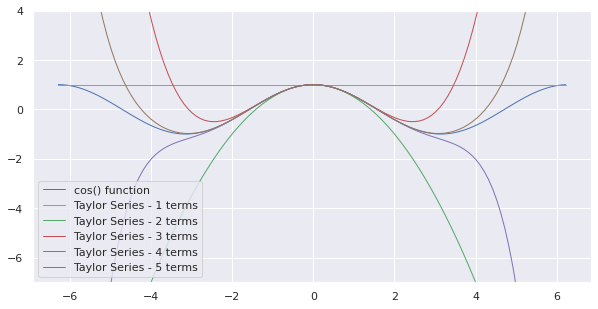

In [ ]:
# Create a function to estimate the value of cos(x) using a Taylor Series

def func_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i)
        denom = math.factorial(2*i)
        cos_approx += ( coef ) * ( (num)/(denom) )
    
    return cos_approx

# Set up plotting
sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)
fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()

**Exkurs: Beziehung zwischen Sinus, Kosinus und Exponentialfunktion**

Die [trigonometrischen Funktionen](https://de.m.wikipedia.org/wiki/Trigonometrische_Funktion) sind eng mit der [Exponentialfunktion](https://de.m.wikipedia.org/wiki/Exponentialfunktion) verbunden, wie die [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel) zeigt:

Eigentlich hat $e$ nichts mit periodischen Funktionen wie $sin$ oder $cos$ zu tun. Aber fügt man $i$ in den exponent von $e$, dann wird daraus eine rotierende, periodische Funktion.*

**Part I: Let`s get the Taylor expansions for three common functions**

> $e^{x}=1+x+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{x^{5}}{5 !}+\cdots$

> <font color="blue">$\cos (x)=1-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !}-\frac{x^{6}}{6 !}+\cdots$

> <font color="red">$\sin (x)=x-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !}-\frac{x^{7}}{7 !}+\cdots$

* there is some relation between these three: 

  * all all built upon $\frac{x^{n}}{n !}$

  * cosinus has all even numbers, sinus all odd numbers, and exponential both

  * Vorzeichen is alternating for cos and sin, but all posisitv for exponential

**Part II: Add $i$ to relate all three functions**

* You can't just add up cos and sin to get exp! You need to add the $i = \sqrt{-1}$ 

* We need to replace all $x$ with an $i x$ in the exp series

> $e^{ix}=1+ix+\frac{(ix)^{2}}{2 !}+\frac{(ix)^{3}}{3 !}+\frac{(ix)^{4}}{4 !}+\frac{(ix)^{5}}{5 !}+\cdots$

* It introduces the following: $i=i \quad i^{2}=-1 \quad i^{3}=-i \quad i^{4}=1$

* this turns the exponential into the following:

> $e^{i x}=1+i x-\frac{x^{2}}{2 !}-\frac{ix^{3}}{3 !}+\frac{x^{4}}{4 !}+\frac{i x^{5}}{5 !}+$

* finally, let's separate the terms with $i$ (all odd) from those without $i$ (all even):

> $e^{ix}$ = <font color="blue">$\left[1-\frac{x^{2}}{2!}+\frac{x^{4}}{4!}-\cdots \right]$</font> + $i$ <font color="red">$\left[x-\frac{x^{3}}{3!}+\frac{x^{5}}{5!}-\cdots\right]$</font>

> $e^{ix}$ = <font color="blue">$cos(x)$</font> + $i$ <font color="red">$ \, sin(x)$</font>

*$sin(x)$ ist der imaginäre Anteil, und $cos(x)$ ist der reale Anteil für $z=e^{i \varphi}=x+i y$*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/400px-Sine_cosine_one_period.svg.png)


**Part III: Let`s replace $x$ with $\pi$**

> $e^{i \pi}=\cos (\pi)+i \sin (\pi)$

* sin and cos repeat and one full period is $2 \pi$ radians (=360°)

* $cos(\pi)$ is half a rotation = -1 and $sin(\pi)$ = 0, which means:

> $e^{i \pi}= -1$ $\,$ and $\,$ $e^{2\pi i} = 1$






##### <font color="blue">*Music Theory*

Video: [A beginner's guide to music theory](https://youtu.be/n2z02J4fJwg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1372.jpg)

Video: [The mathematical problem with music, and how to solve it](https://youtu.be/nK2jYk37Rlg)

* Frequency (in Hertz) = no. of vibrations per second. Typically between 50 to a few thousand Hertz. Higher frequency = higher pitch (i.e. 200. vs 1000)

* all musical tones are multiples of pure tones (harmonics) = behave to the mathematical sine function. For example tone f consists of frequencies of several integer multiples of a pure tone f, 2f, 3f.. (first harmonic, second harmonic, third harmonic..).

* Melodies = sequences of tones. Strictly speaking these two melodies have not even one frequency in common, but they sound similar. But both melodies have the **same ratios between the frequencies of their tones.** Frequencies are different, but ratios are the same.

* Changing from melody 1 to melody 2 is called **transposition from one key to another**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1373.jpg)

* Another important concept is the **Musical intervall**, which is the frequency ratio mentioned above:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1374.jpg)

* One important interval is called the octave, and it corresponds to a frequency ratio of 2:1. The Octave is very pleasent to the ear. **Octave equivalence**: two tones that are an Octave apart sound highly similar: hence have same name and belong to the same pitch class.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1375.jpg)

* Another important is called the **Fifth** with ration 3 over 2:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1376.jpg)


##### <font color="blue">*Funktionentheorie*

Die [Funktionentheorie](https://de.wikipedia.org/wiki/Funktionentheorie) befasst sich mit der Theorie differenzierbarer komplexwertiger Funktionen mit komplexen Variablen. Da insbesondere die Funktionentheorie einer komplexen Variablen reichlich Gebrauch von Methoden aus der reellen Analysis macht, nennt man das Teilgebiet auch komplexe Analysis.

* Für holomorphe Funktionen gilt, dass Real- und Imaginärteil [harmonische Funktionen](https://de.wikipedia.org/wiki/Harmonische_Funktion) sind, also die [Laplace-Gleichung](https://de.wikipedia.org/wiki/Laplace-Gleichung) erfüllen. Dies verknüpft die Funktionentheorie mit den partiellen Differentialgleichungen, beide Gebiete haben sich regelmäßig gegenseitig beeinflusst.

* Das Wegintegral einer holomorphen Funktion ist vom Weg unabhängig. Dies war historisch das erste Beispiel einer Homotopieinvarianz. Aus diesem Aspekt der Funktionentheorie entstanden viele Ideen der algebraischen Topologie, beginnend mit Bernhard Riemann.

**Komplexe Funktion**

* Eine [komplexe Funktion](https://de.wikipedia.org/wiki/Funktionentheorie#Komplexe_Funktionen) ordnet einer komplexen Zahl eine weitere [komplexe Zahl](https://de.m.wikipedia.org/wiki/Komplexe_Zahl) zu

* Da jede komplexe Zahl durch zwei reelle Zahlen in
der Form $x+$ iy geschrieben werden kann, lässt sich eine allgemeine Form einer komplexen Funktion darstellen durch:

> $
x+i y \mapsto f(x+i y)=u(x, y)+i v(x, y)
$

* Dabei sind $u(x, y)$ und $v(x, y)$ reelle Funktionen, die von zwei reellen Variablen $x$ und $y$ abhängen. 

* $u(x, y)$ heißt der Realteil und $v(x, y)$ der Imaginärteil der Funktion. 

* **Insofern ist eine komplexe Funktion nichts anderes als eine Abbildung von $\mathbb{R}^{2}$ nach $\mathbb{R}^{2}$ (also eine Abbildung, die zwei reellen Zahlen wieder zwei reelle Zahlen zuordnet).** 

* **Tatsächlich könnte man die Funktionentheorie auch mit Methoden der reellen Analysis aufbauen.**

* Der Unterschied zur reellen Analysis wird erst deutlicher, wenn man **komplex-differenzierbare Funktionen** betrachtet und dabei die <u>**multiplikative Struktur des Körpers der komplexen Zahlen**</u> ins Spiel bringt, die dem Vektorraum $\mathbb{R}^{2}$ fehlt. 

* Wie auch bei reellwertigen und reellen Funktionen ist die Verwendung des Begriffes einer komplexen Funktion in der Literatur aber nicht eindeutig. Teilweise wird er synonym mit einer komplexwertigen Funktion verwendet, teilweise wird er auch nur für komplexwertige Funktionen einer komplexen Variablen verwendet, also Funktionen

> $
f: D \rightarrow \mathbb{C}
$

bei denen $D \subseteq \mathbb{C}$ ist.


**Komplexwertige Funktion**

* Eine [komplexwertige Funktion](https://de.wikipedia.org/wiki/Komplexwertige_Funktion) ist eine Funktion, deren Funktionswerte komplexe Zahlen sind

* Eng damit verwandt ist der Begriff der **komplexen Funktion**, der in der Literatur aber nicht eindeutig verwendet wird

* Komplexwertige Funktionen werden in der Analysis und in der Funktionentheorie untersucht und haben vielfältige Anwendungen wie zum Beispiel in der Physik und der Elektrotechnik, wo sie beispielsweise zur Beschreibung von Schwingungen dienen.

* Eine komplexwertige Funktion ist eine Funktion
$f: D \rightarrow \mathbb{C}$ bei der die Zielmenge die Menge der komplexen Zahlen ist. 

* **An die Definitionsmenge $D$ sind keine Anforderungen gestellt**.

* **Aufgrund der Einbettung der reellen Zahlen in die komplexen Zahlen lassen sich alle reellwertigen Funktionen auch als komplexwertige Funktionen auffassen.**

* Beispiel: Die Funktion $f: \mathbb{R} \rightarrow \mathbb{C}$ definiert durch $f(x)= \mathrm{e}^{\mathrm{i} x}=\cos (x)+\mathrm{i} \sin (x)$ ist eine komplexwertige Funktion einer reellen Variable, und zwar die [Eulersche Formel](https://de.wikipedia.org/wiki/Eulersche_Formel) 

**Holomorphe Funktion**

* Holomorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* [Holomorphe Funktionen](https://de.wikipedia.org/wiki/Holomorphe_Funktion) sind **an jedem Punkt komplex differenzierbar**. 

* Eine Funktion $f\colon U\to {\mathbb  {C}}$ mit einer offenen Menge $ U\subseteq \mathbb {C}$ heißt holomorph, falls sie in jedem Punkt von $U$ komplex differenzierbar ist.

* Holomorphie eine sehr starke Eigenschaft ist, die im Reellen kein Pendant besitzen (z.B. ist jede holomorphe Funktion beliebig oft (stetig) differenzierbar und lässt sich lokal in jedem Punkt in eine Potenzreihe entwickeln.)

Es sei $U \subseteq \mathbb{C}$ eine offene Teilmenge der komplexen Ebene und $z_{0} \in U$ ein Punkt dieser Teilmenge. Eine Funktion $f: U \rightarrow \mathbb{C}$ heißt komplex differenzierbar im Punkt $z_{0}$, falls der Grenzwert

>$
\lim _{h \rightarrow 0} \frac{f\left(z_{0}+h\right)-f\left(z_{0}\right)}{h}
$

existiert. Man bezeichnet ihn dann als $f^{\prime}\left(z_{0}\right)$.

Die Funktion $f$ heißt holomorph im Punkt $z_{0}$, falls eine Umgebung von $z_{0}$ existiert, in der $f$ komplex differenzierbar ist. Ist $f$ auf ganz $U$ holomorph, so nennt man $f$ holomorph. 

**Ist weiter $U=\mathbb{C},$ so nennt man $f$ eine <u>ganze Funktion</u>**.


**Biholomorphe Funktionen**

* Eine Funktion, die holomorph, bijektiv und deren Umkehrfunktion holomorph ist, nennt man [biholomorph](https://de.wikipedia.org/wiki/Biholomorphe_Abbildung). 

* Im Fall einer komplexen Veränderlichen ist das äquivalent dazu, dass die Abbildung bijektiv und konform ist. 
* Aus Sicht der Kategorientheorie ist eine biholomorphe Abbildung ein Isomorphismus.

**Cauchy-Riemannsche Differentialgleichungen**

* Siehe [Cauchy-Riemannsche Differentialgleichungen](https://de.wikipedia.org/wiki/Cauchy-Riemannsche_partielle_Differentialgleichungen) - Mit einer Einleitung [hier](https://de.wikipedia.org/wiki/Holomorphe_Funktion#Cauchy-Riemannsche_Differentialgleichungen). 

* Zerlegt man eine Funktion $f(x+i y)=u(x, y)+i v(x, y)$ in ihren Real-und Imaginärteil mit reellen Funktionen $u, v,$ so hat die totale Ableitung $L$ als Darstellungsmatrix die **Jacobi-Matrix**

>$
\left(\begin{array}{ll}
\frac{\partial u}{\partial x} & \frac{\partial u}{\partial y} \\
\frac{\partial v}{\partial x} & \frac{\partial v}{\partial y}
\end{array}\right)
$

Folglich ist die Funktion $f$ genau dann komplex differenzierbar, wenn sie reell differenzierbar ist und für $u, v$ die Cauchy-Riemannschen Differentialgleichungen

>$
\begin{array}{l}
\frac{\partial u}{\partial x}=\frac{\partial v}{\partial y} \\
\frac{\partial u}{\partial y}=-\frac{\partial v}{\partial x}
\end{array}
$

erfüllt sind.

**Analytische Funktion (=holomorph)**

* Als [analytische Funktion](https://de.wikipedia.org/wiki/Analytische_Funktion) bezeichnet man eine Funktion, die lokal durch eine **konvergente Potenzreihe** gegeben ist.

* Aufgrund der Unterschiede zwischen reeller und komplexer Analysis spricht man zur Verdeutlichung oft auch explizit von reell-analytischen oder komplex-analytischen Funktionen. 

* **Im Komplexen sind die Eigenschaften analytisch und holomorph äquivalent.**

* **Ist eine Funktion in der gesamten komplexen Ebene definiert und analytisch, nennt man sie ganz.**


Es sei $\mathbb{K}=\mathbb{R}$ oder $\mathbb{K}=\mathbb{C} .$ Es sei $D \subseteq \mathbb{K}$ eine offene Teilmenge. Eine Funktion $f: D \rightarrow \mathbb{K}$ heißt analytisch im Punkt $x_{0} \in D,$ wenn es eine **Potenzreihe**

>$
\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

gibt, die auf einer Umgebung von $x_{0}$ gegen $f(x)$ konvergiert. Ist $f$ in jedem Punkt von $D$ analytisch, so heißt $f$ analytisch.

Viele gängige Funktionen der reellen Analysis wie beispielsweise Polynome, Exponential- und Logarithmusfunktionen, trigonometrische Funktionen und rationale Ausdrücke in diesen Funktionen sind analytisch. 

Unter einer [Potenzreihe](https://de.wikipedia.org/wiki/Potenzreihe) $P(x)$ versteht man in der Analysis eine unendliche Reihe der Form

>$
P(x)=\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

mit einer beliebigen Folge $\left(a_{n}\right)_{n \in \mathbb{N}_{0}}$ reeller oder komplexer Zahlen
dem Entwicklungspunkt $x_{0}$ der Potenzreihe.

Potenzreihen spielen eine wichtige Rolle in der Funktionentheorie und **erlauben oft eine sinnvolle Fortsetzung reeller Funktionen in die komplexe Zahlenebene**. Insbesondere stellt sich die Frage, für welche reellen oder komplexen Zahlen eine Potenzreihe konvergiert. Diese Frage führt zum Begriff des [Konvergenzradius](https://de.wikipedia.org/wiki/Konvergenzradius).

* Jede Polynomfunktion lässt sich als Potenzreihe auffassen, bei der fast alle Koeffizienten $a_{n}$ gleich 0 sind. 

* Wichtige andere Beispiele sind **Taylorreihe** und **Maclaurinsche Reihe**. 

* Funktionen, die sich durch eine Potenzreihe darstellen lassen, werden auch [analytische Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) genannt. 

**Beispielhaft die Potenzreihendarstellung einiger bekannter Funktionen**:

* **Exponentialfunktion**: $e^{x}=\exp (x)=\sum_{n=0}^{\infty} \frac{x^{n}}{n !}=\frac{x^{0}}{0 !}+\frac{x^{1}}{1 !}+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\cdots$ für alle
$x \in \mathbb{R},$ d. h., der Konvergenzradius ist unendlich. 

* **Sinus**: $\sin (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n+1}}{(2 n+1) !}=\frac{x}{1 !}-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !} \mp \cdots$

* **Kosinus**: $\cos (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !}=\frac{x^{0}}{0 !}-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !} \mp \cdots$

**Ganze Funktion**

* In der Funktionentheorie ist eine [ganze Funktion](https://de.wikipedia.org/wiki/Ganze_Funktion) eine Funktion, **die in der gesamten komplexen Zahleneben**e $\mathbb {C}$  holomorph (also analytisch) ist. 

* an entire function, also called an integral function, is a complex-valued function that is holomorphic at all finite points over the whole complex plane. 

* **Every entire function f(z) can be represented as a power series**

* Typische Beispiele ganzer Funktionen sind Polynome oder die **Exponentialfunktion** sowie Summen, Produkte und Verknüpfungen davon, etwa die **trigonometrischen Funktionen** und die **Hyperbelfunktionen**.

* Jede ganze Funktion kann als eine überall konvergierende Potenzreihe um ein beliebiges Zentrum dargestellt werden. Weder der Logarithmus noch die Wurzelfunktion sind ganz.

* Eine ganze Funktion kann eine **isolierte Singularität**, insbesondere sogar eine wesentliche Singularität im komplexen Punkt im Unendlichen (und nur da) besitzen.

**Beispiele**

* der Kehrwert der Gammafunktion $1 / \Gamma(z)$ 

* die Fehlerfunktion $\operatorname{erf}(z)$ 

* der Integralsinus $\operatorname{Si}(z)$ 

* die Airy-Funktionen $\operatorname{Ai}(z)$ und $\operatorname{Bi}(z)$ 

* die Fresnelschen Integrale $S(z)$ und $C(z)$ 

* die Riemannsche Xi-Funktion $\xi(z)$ 

* die Besselfunktionen erster Art $J_{n}(z)$ für ganzzahlige $n$ 

* die Struve-Funktionen $H_{n}(z)$ für ganzzahlige $n>-2$

**Laurent-Reihe**

**Exkurs**: Die Laurent-Reihe ist eine **unendliche Reihe ähnlich einer Potenzreihe**, aber zusätzlich **mit negativen Exponenten**. Allgemein hat eine Laurent-Reihe in $x$ mit Entwicklungspunkt $c$ diese Gestalt (Dabei sind die $a_{n}$ und $c$ meist komplexe Zahlen):

>$
f(x)=\sum_{n=-\infty}^{\infty} a_{n}(x-c)^{n}
$

Es sei $D$ eine nichtleere offene Teilmenge der Menge $\mathbb{C}$ der komplexen Zahlen und $P_{f}$ eine weitere Teilmenge von $\mathbb{C}$, die nur aus isolierten Punkten besteht. Eine Funktion $f$ heißt meromorph, wenn sie für Werte aus $D \backslash P_{f}$ definiert und holomorph ist und für Werte aus $P_{f}$ Pole hat. $P_{f}$ wird als Polstellenmenge von $f$ bezeichnet.

* Zerlegung einer komplex differenzierbaren Funktion

**Meromorphe Funktion**

* Meromorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* Für viele Fragestellungen der Funktionentheorie ist der **Begriff der holomorphen Funktion zu speziell**. 

* Dies liegt daran, dass der Kehrwert $\frac{1}{f}$ einer holomorphen Funktion $f$ an einer Nullstelle von $f$ eine Definitionslücke hat und somit $\frac{1}{f}$ dort auch **nicht komplex differenzierbar ist**. 

* Man führt daher den allgemeineren Begriff der [meromorphen Funktion](https://de.wikipedia.org/wiki/Meromorphe_Funktion) ein, die auch **isolierte Polstellen** besitzen kann.

* Meromorphe Funktionen lassen sich lokal als [Laurentreihen](https://de.wikipedia.org/wiki/Laurent-Reihe) mit abbrechendem Hauptteil darstellen. Ist $U$ ein Gebiet von $\mathbb{C},$ so bildet die Menge der auf $U$ meromorphen Funktionen einen Körper.

* Alle holomorphen Funktionen sind auch meromorph, da ihre Polstellenmenge leer ist.

Zum Beispiel ist die Gamma-Funktion meromorph, weil sie holomorph ist auf $\mathbb{C}$, abgesehen von abzahlbar vielen nicht-hebbaren Singularitaeten (hierbei in allen negativen ganzen Zahlen, da der Definitionsbereich einer Gammafunktion $\mathbb{C}$  \ -$\mathbb{N}$ <sub>0</sub> ist).

Beispiele:

* [Gamma Funktion](https://en.wikipedia.org/wiki/Gamma_function)

* [Elliptische Funktion](https://de.wikipedia.org/wiki/Elliptische_Funktion)

*Der Absolutwert der Gammafunktion geht nach Unendlich an den Polstellen (links). Rechts hat sie keine Polstellen und steigt nur schnell an.*

*The [gamma function](https://en.wikipedia.org/wiki/Gamma_function) is meromorphic in the whole complex plane.*

![ff](https://upload.wikimedia.org/wikipedia/commons/3/33/Gamma_abs_3D.png)

**Isolierte Singularität**

* [Isolierte Singularitäten](https://de.wikipedia.org/wiki/Isolierte_Singularität) sind besondere [**isolierte Punkte**](https://de.wikipedia.org/wiki/Isolierter_Punkt) in der Quellmenge einer holomorphen Funktion. 

* Man unterscheidet bei isolierten Singularitäten zwischen **hebbaren Singularitäten**, **Polstellen** und **wesentlichen Singularitäten**.

* Es sei $\Omega \subseteq \mathbb{C}$ eine offene Teilmenge, $z_{0} \in \Omega$. Ferner sei $f: \Omega \backslash\left\{z_{0}\right\} \rightarrow \mathbb{C}$ eine holomorphe komplexwertige Funktion. Dann heißt $z_{0}$ isolierte Singularität von $f$.

**Klasse 1: Hebbare Singularität (Definitionslücke)**

* Der Punkt $z_{0}$ heißt [hebbare Singularität](https://de.wikipedia.org/wiki/Definitionslücke), wenn $f$ auf $\Omega$ holomorph fortsetzbar ist. 

* Hat Grenzwert in Form von einer Zahl bzw. nach dem riemannschen Hebbarkeitssatz, wenn $f$ in einer Umgebung von $z_{0}$ beschränkt ist.

> $\lim _{z \rightarrow z_{0}} f(z)=c$

> $f(z)$ beschrankt in $U\left(z_{0}\right)$

**Klasse 2: Polstelle**

* im Prinzip das gleiche wie bei hebbaren Singularitaten, aber mit dem Unterschied, dass die Funktion nah an der Singularitat unbeschraenkt ist = also ins unendliche geht $\lim _{z \rightarrow z_{0}}|f(z)|=\infty$

Alternative Definition:

> $\lim _{z \rightarrow z_{0}} f(z) \cdot\left(z-z_{0}\right)^{k}=c \neq 0(k \geqslant 1)$

Man multipliziert an den unendlichen Funktionswert immer oefter eine fast Null in Form des Polynoms $\left(z-z_{0}\right)^{k}$, bis man eine endliche komplexe Zahl als Grenzwert hat, und nicht mehr unendlich (aber nicht Null). Die Anzahl der Polynome k multipliziert mit dem Funktionswert ist der Grad / Ordnung der Polstelle.

* Der Punkt $z_{0}$ heißt [Polstelle](https://de.wikipedia.org/wiki/Polstelle) oder $P o l$, wenn 

  * $z_{0}$ **keine hebbare Singularität ist** und 
  * es eine natürliche $\operatorname{Zahl} k$ gibt, sodass $\left(z-z_{0}\right)^{k} \cdot f(z)$ **eine hebbare Singularität bei $z_{0}$ hat**. 

* Ist das $k$ minimal gewählt, dann sagt man $f$ habe in $z_{0}$ einen Pol $k$ -ter Ordnung.

* Man bezeichnet eine einpunktige Definitionslücke einer Funktion als Polstelle oder auch kürzer als Pol, wenn die Funktionswerte in jeder Umgebung des Punktes (betragsmäßig) beliebig groß werden.

* Damit gehören die Polstellen zu den isolierten Singularitäten. 

* Das Besondere an Polstellen ist, dass sich die Punkte in einer Umgebung **nicht chaotisch verhalten, sondern in einem gewissen Sinne gleichmäßig gegen unendlich streben**. Deshalb können dort Grenzwertbetrachtungen durchgeführt werden.

* Generell spricht man nur bei [glatten](https://de.wikipedia.org/wiki/Glatte_Funktion) (stetig & differenzierbar) oder [analytischen Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) von Polen. 

*Fur reelle Funktionen: f(x)=1/x hat einen Pol erster Ordnung an der Stelle x=0**

![gg](https://upload.wikimedia.org/wikipedia/commons/9/90/GraphKehrwertfunktion.png)

**Klasse 3: Wesentliche Singularität**

* nicht hebbar und keine Polstelle, dann heißt $z_{0}$ eine wesentliche Singularität von $f$

* zum Beispiel fur $f(z)=e^{-\frac{1}{z}}, z_{0}=0$, eine Funktion die von links ins unendliche strebt, und von rechts nach Null
  * keine hebbare Singularitaet, weil zwei verschiedene Grenzwerte existieren und eine davon nicht endlich ist.
  * keine Polstelle, weil ein Grenzwert gleich Null ist (muss aber unbeschraenkt sein bei Polstellen)


*Plot der Funktion $\exp(1/z)$. Sie hat im Nullpunkt eine wesentliche Singularität (Bildmitte). Der Farbton entspricht dem komplexen Argument des Funktionswertes, während die Helligkeit seinen Betrag darstellt. Hier sieht man, dass sich die wesentliche Singularität unterschiedlich verhält, je nachdem, wie man sich ihr nähert (im Gegensatz dazu wäre ein Pol gleichmäßig weiß).*

![ff](https://upload.wikimedia.org/wikipedia/commons/0/0b/Essential_singularity.png)

**Cauchysche Integralformel**

* Die [cauchysche Integralformel](https://de.wikipedia.org/wiki/Cauchysche_Integralformel) ist eine der fundamentalen Aussagen der Funktionentheorie, eines Teilgebietes der Mathematik. 

* Sie besagt in ihrer schwächsten Form, dass die Werte einer holomorphen Funktion $f$ im Inneren einer Kreisscheibe bereits durch ihre Werte auf dem Rand dieser Kreisscheibe bestimmt sind.

* Eine starke Verallgemeinerung davon ist der Residuensatz.

**Residuensatz**

* Der [Residuensatz](https://de.wikipedia.org/wiki/Residuensatz) ist ein wichtiger Satz der Funktionentheorie. Er stellt eine **Verallgemeinerung des cauchyschen Integralsatzes und der cauchyschen Integralformel** dar. Seine Bedeutung liegt nicht nur in den weitreichenden Folgen innerhalb der Funktionentheorie, sondern auch in der Berechnung von Integralen über reelle Funktionen.

* Er besagt, dass das Kurvenintegral längs einer geschlossenen Kurve über eine bis auf isolierte Singularitäten holomorphe Funktion lediglich vom Residuum in den Singularitäten im Innern der Kurve und der Umlaufzahl der Kurve um diese Singularitäten abhängt. Anstelle eines Kurvenintegrals muss man also nur Residuen und Umlaufzahlen berechnen, was in vielen Fällen einfacher ist.

**Cauchyscher Integralsatz**

* Der [cauchysche Integralsatz](https://de.wikipedia.org/wiki/Cauchyscher_Integralsatz)  ist einer der wichtigsten Sätze der Funktionentheorie. 

* Er handelt von Kurvenintegralen für holomorphe (auf einer offenen Menge komplex-differenzierbare) Funktionen. 

* Im Kern besagt er, dass zwei dieselben Punkte verbindende Wege das gleiche Wegintegral besitzen, falls die Funktion überall zwischen den zwei Wegen holomorph ist. 

* Der Satz gewinnt seine Bedeutung unter anderem daraus, dass man ihn zum Beweis der cauchyschen Integralformel und des Residuensatzes benutzt.



##### <font color="blue">*Dynamical System*

###### *Chaos Theory*

**Chaos Theory**

* Many phenomena in nature can be described by dynamical systems; [chaos theory](https://en.m.wikipedia.org/wiki/Chaos_theory) makes precise the ways in which many of these systems exhibit unpredictable yet still deterministic behavior.

* [Complexity theory](https://en.m.wikipedia.org/wiki/Complex_system) is rooted in chaos theory. Chaos theory is a method of qualitative and quantitative analysis to investigate the behavior of [dynamical systems](https://en.m.wikipedia.org/wiki/Dynamical_system) that cannot be explained and predicted by single data relationships, but must be explained and predicted by whole, continuous data relationships.

* Chaos theory concerns deterministic systems whose behavior can, in principle, be predicted. Chaotic systems are predictable for a while and then 'appear' to become random. 

* The amount of time for which the behavior of a chaotic system can be effectively predicted depends on three things: 

  * how much uncertainty can be tolerated in the forecast (uncertainty in a forecast increases exponentially with elapsed time) 
  * how accurately its current state can be measured, 
  * and a time scale depending on the dynamics of the system, called the [Lyapunov time](https://en.m.wikipedia.org/wiki/Lyapunov_time) (chaotic electrical circuits, about 1 millisecond; weather systems, a few days (unproven); the inner solar system, 4 to 5 million years)

* In practice, a meaningful prediction cannot be made over an interval of more than two or three times the Lyapunov time. When meaningful predictions cannot be made, the system appears random.



###### *Lyapunov exponent*

**Lyapunov exponent**

* the Lyapunov exponent or Lyapunov characteristic exponent of a dynamical system is a quantity that characterizes the rate of separation of infinitesimally close trajectories. 

* Quantitatively, two trajectories in phase space with initial separation vector $\delta \mathbf {Z} _{0}$ diverge (provided that the divergence can be treated within the linearized approximation) at a rate given by

> ${\displaystyle |\delta \mathbf {Z} (t)|\approx e^{\lambda t}|\delta \mathbf {Z} _{0}|}$

where $\lambda$ is the Lyapunov exponent.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1197.png)

###### *Complex Systems*

**Complex Systems**

* [Complex Systems](https://en.m.wikipedia.org/wiki/Complex_system) is rooted in chaos theory bzw: In a sense chaotic systems can be regarded as a subset of complex systems distinguished precisely by this absence of historical dependence. 

* [Chaos](https://en.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory) is sometimes viewed as extremely complicated information, rather than as an absence of order.

* The emergence of complexity theory shows a domain between deterministic order and randomness which is complex. This is referred to as the ["edge of chaos"](https://en.wikipedia.org/wiki/Edge_of_chaos).

* **When one analyzes complex systems, sensitivity to initial conditions, for example, is not an issue as important as it is within chaos theory, in which it prevails.**

*Properties:*

1. **Agentenbasiert**: Komplexe Systeme bestehen aus einzelnen Teilen, die miteinander in Wechselwirkung stehen (Moleküle, Individuen, Software-Agenten etc.).
2. **Nichtlinearität**: Kleine Störungen des Systems oder minimale Unterschiede in den Anfangsbedingungen führen oft zu sehr unterschiedlichen Ergebnissen (Schmetterlingseffekt, Phasenübergänge). Die Wirkzusammenhänge der Systemkomponenten sind im Allgemeinen nichtlinear.
3. [**Emergenz**](https://de.wikipedia.org/wiki/Emergenz): Im Gegensatz zu lediglich komplizierten Systemen zeigen komplexe Systeme Emergenz. Entgegen einer verbreiteten Vereinfachung bedeutet Emergenz nicht, dass die Eigenschaften der emergierenden Systemebenen von den darunter liegenden Ebenen vollständig unabhängig sind. Emergente Eigenschaften lassen sich jedoch auch nicht aus der isolierten Analyse des Verhaltens einzelner Systemkomponenten erklären und nur sehr begrenzt ableiten.
4. **Wechselwirkung** (Interaktion): Die Wechselwirkungen zwischen den Teilen des Systems (Systemkomponenten) sind lokal, ihre Auswirkungen in der Regel global.
5. **Offenes System**: Komplexe Systeme sind üblicherweise offene Systeme. Sie stehen also im Kontakt mit ihrer Umgebung und befinden sich fern vom thermodynamischen Gleichgewicht. Das bedeutet, dass sie von einem permanenten Durchfluss von Energie bzw. Materie abhängen.
6. **Selbstorganisation**: Dies ermöglicht die Bildung insgesamt stabiler Strukturen (Selbststabilisierung oder Homöostase), die ihrerseits das thermodynamische Ungleichgewicht aufrechterhalten. Sie sind dabei in der Lage, Informationen zu verarbeiten bzw. zu lernen.
7. **Selbstregulation**: Dadurch können sie die Fähigkeit zur inneren Harmonisierung entwickeln. Sie sind also in der Lage, aufgrund der Informationen und derer Verarbeitung das innere Gleichgewicht und Balance zu verstärken.
8. **Pfade**: Komplexe Systeme zeigen Pfadabhängigkeit: Ihr zeitliches Verhalten ist nicht nur vom aktuellen Zustand, sondern auch von der Vorgeschichte des Systems abhängig.
9. **Attraktoren**: Die meisten komplexen Systeme weisen so genannte Attraktoren auf, d. h., dass das System unabhängig von seinen Anfangsbedingungen bestimmte Zustände oder Zustandsabfolgen anstrebt, wobei diese Zustandsabfolgen auch chaotisch sein können; dies sind die „seltsamen Attraktoren“ der Chaosforschung.

* Complexity theory is rooted in chaos theory bzw: In a sense chaotic systems can be regarded as a subset of complex systems distinguished precisely by this absence of historical dependence. 

* Chaos is sometimes viewed as extremely complicated information, rather than as an absence of order.

* The emergence of complexity theory shows a domain between deterministic order and randomness which is complex. This is referred to as the ["edge of chaos"](https://en.wikipedia.org/wiki/Edge_of_chaos).

* **When one analyzes complex systems, sensitivity to initial conditions, for example, is not an issue as important as it is within chaos theory, in which it prevails.**

https://en.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory

###### *Fractal Dimensions*

**Fractal Geometry**

* a [fractal](https://en.m.wikipedia.org/wiki/Fractal) is a subset of Euclidean space with a fractal dimension that strictly exceeds its topological dimension. Fractals appear the same at different scales, as illustrated in successive magnifications of the Mandelbrot set.

* Fractals exhibit similar patterns at increasingly smaller scales, a property called self-similarity, also known as expanding symmetry or unfolding symmetry; if this replication is exactly the same at every scale, as in the Menger sponge,it is called affine self-similar. 

* idealization is that everything is smooth (rebellion against calculus, differentiable, where assumption is things look smooth if you zoom in enough). Mandelbrot: nature is fractal (capture roughness)

* self-similar shapes give a basis for modeling the regularity in some forms of roughness. but that doesn't mean all is only perfectly self-similar either!! (Perfect self similar are: Von Koch snowflake, Sierpensky triangle)

> <font color="blue">Fractal dimension: Sierpensky triangle is 1,585 dimensional, Von Koch snowflake is 1,262 dimensional, Britain coast line 1,21 dimensional, Norway: 1,52 dimensional, calm sea 2,05 dimensional, waves 2,3 dimensional</font>

> **Fractals are shapes with a non-integer dimension, captures idea of roughness, but dimension can vary depending on how much you zoom in**. But a shape is considered a fractal only when the measures dimension stays approximately constant across multiple different scales.

> Useful in security: **Is something fractal? Yes - then probably from nature. No - then probably man-made**.



**Deterministic fractals**: 
  * [Julia set](https://de.m.wikipedia.org/wiki/Julia-Menge) - siehe auch [Newtonfraktal](https://de.m.wikipedia.org/wiki/Newtonfraktal). The Julia set and the Fatou set are two complementary sets (Julia "laces" and Fatou "dusts").
  * [Mandelbrot set](https://en.m.wikipedia.org/wiki/Mandelbrot_set) (is kind of like a map of Julia sets)
  * [Logistic map](https://de.m.wikipedia.org/wiki/Logistische_Gleichung) (Feigenbaum Attractor) with [Feigenbaum-Konstante](https://de.m.wikipedia.org/wiki/Feigenbaum-Konstante), 
  * Peano curve, Pentaflake, 3D Hilbert curve etc.
  * A [fractal curve](https://en.m.wikipedia.org/wiki/Fractal_curve) is, loosely, a mathematical curve whose shape retains the same general pattern of irregularity, regardless of how high it is magnified, that is, its graph takes the form of a fractal. They do NOT have finite length. A famous example is the boundary of the Mandelbrot set. [Space-filling curves](https://en.m.wikipedia.org/wiki/Space-filling_curve) are special cases of fractal curves. Its range contains the entire 2-dimensional unit square (or more generally an n-dimensional unit hypercube). Space-filling curves in the 2-dimensional plane are sometimes called [Peano curve](https://en.m.wikipedia.org/wiki/Peano_curve). Peano curves are constructed by [Hilbert curves](https://en.m.wikipedia.org/wiki/Hilbert_curve) to form a single continuous loop over the entire sphere.


**Random and natural fractals**: 
  * Zeros of a Wiener process, 
  * Brownian motion, 
  * [Coastline of Ireland, Great Britain or Norway](https://en.m.wikipedia.org/wiki/Coastline_paradox)  (Coastline paradox)
  * von [Koch curve](https://de.m.wikipedia.org/wiki/Koch-Kurve) with random orientation
  * The surface of Broccoli or human brain, 
  * Distribution of [galaxy clusters](https://en.m.wikipedia.org/wiki/Galaxy_cluster)
  
![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1196.png)

*Zeros of a Wiener process:*

![gg](https://upload.wikimedia.org/wikipedia/commons/8/83/Wiener_process_set_of_zeros.gif)

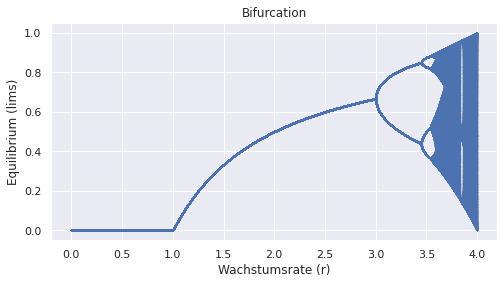

In [ ]:
# Logistic-Map: Bifurcation Diagram (Deterministic fractals)

sns.set(rc={'figure.figsize':(8, 4), "lines.linewidth": 1.0})

N_points = 4000000
N_steps = 500
r = np.linspace(0,4,N_points)
y = np.random.uniform(0,1,size=N_points)

for _ in range(N_steps):
    y = r*y*(1-y)
    
fig, biax = plt.subplots()
biax.plot(r, y, '.-', linewidth=0, markersize=0.25)
biax.set(xlabel='Wachstumsrate (r)', ylabel='Equilibrium (lims)', title='Bifurcation')
plt.show()

**Fractal Dimensions**: die [fraktale Dimension](https://de.m.wikipedia.org/wiki/Fraktale_Dimension) einer Menge ist eine Verallgemeinerung des Dimensionsbegriffs von geometrischen Objekten wie Kurven (eindimensional) und Flächen (zweidimensional).

  * [Hausdorff dimension](https://de.m.wikipedia.org/wiki/Hausdorff-Dimension):  Hausdorff dimension of a single point is zero, of a line segment is 1, of a square is 2, and of a cube is 3. That is, for sets of points that define a smooth shape or a shape that has a small number of corners—the shapes of traditional geometry and science—the Hausdorff dimension is an integer agreeing with the usual sense of dimension, also known as the [topological dimension (inductive dimension)](https://en.m.wikipedia.org/wiki/Inductive_dimension)
  * [Packing dimension](https://en.m.wikipedia.org/wiki/Packing_dimension)
  * [Effective dimension](https://en.m.wikipedia.org/wiki/Effective_dimension)
  * [Box-counting dimension](https://en.m.wikipedia.org/wiki/Minkowski–Bouligand_dimension) (Minkowski–Bouligand dimension)
  * [List of fractals by Hausdorff dimension](https://en.m.wikipedia.org/wiki/List_of_fractals_by_Hausdorff_dimension)
  
*Example of Box Counting dimension:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Great_Britain_Box.svg/640px-Great_Britain_Box.svg.png)


###### *Dynamical System*

**Dynamisches System**

> **A dynamical system involves one or more variables that change over time according to autonomous differential equations.**

> $\dot{x}=$ rate of change of $x$ as time changes

> $\dot{y}=$ rate of change of $y$ as time changes

They depend on t:

$\frac{d x}{d t}=$ rate of change of $x$ as time changes $\frac{d y}{d t}=$ rate of change of $y$ as time changes

but the differential equation that describe x dot and y dot don’t actually involve time t:

> $\dot{x}=-y-0.1 x$

> $\dot{y}=x-0.4 y$

This makes them autonomous. Each combination of x and y to only corresponds to one combination of x dot and y dot. You can represent it in a dynamical system called the phase space. Each point in space is a unique state of the system. And has its own rate of change shown as a vector. 

> <font color="red">Siehe auch: [Supersymmetric theory of stochastic dynamics](https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics) or stochastics (STS) is an exact theory of stochastic (partial) differential equations (SDEs), the class of mathematical models with the widest applicability covering, in particular, all continuous time dynamical systems, with and without noise. STS is interesting because it bridges the two major parts of mathematical physics – the [dynamical systems theory](https://en.m.wikipedia.org/wiki/Dynamical_systems_theory) and [topological (quantum) field theories](https://en.m.wikipedia.org/wiki/Topological_quantum_field_theory). Besides these and related disciplines such as algebraic topology and supersymmetric field theories, STS is also connected with the traditional theory of stochastic differential equations and the theory of pseudo-Hermitian operators.</font>

* [Dynamical systems theory](https://en.m.wikipedia.org/wiki/Dynamical_systems_theory). Ein (deterministisches) [dynamisches System](https://de.m.wikipedia.org/wiki/Dynamisches_System) ist ein Modell eines zeitabhängigen Prozesses, der homogen bezüglich der Zeit ist (Verlauf hängt nur vom Anfangszustand, aber nicht von der Wahl des Anfangszeitpunkts)

* Wichtige Fragestellungen: Langzeitverhalten (zum Beispiel [Stabilität](https://de.wikipedia.org/wiki/Stabilitätstheorie), [Periodizität](https://de.wikipedia.org/wiki/Periodische_Funktion), [Chaos](https://de.wikipedia.org/wiki/Chaosforschung) und [Ergodizität](https://de.wikipedia.org/wiki/Ergodizität)), die [Systemidentifikation](https://de.wikipedia.org/wiki/Systemidentifikation) und ihre [Regelung](https://de.wikipedia.org/wiki/Regelung_(Natur_und_Technik))

* Formal betrachte man ein **dynamisches System** bestehend aus einem topologischen Raum $X$ und einer Transformation $f: \mathcal{T} \times X \longrightarrow X$, wobei $\mathcal{T}$ ein linear geordnetes Monoid ist wie $\mathcal{T}=\mathbb{N}, \mathbb{Z},[0, \infty[$ oder $\mathbb{R}$ und $f$ normalerweise stetig oder mindestens messbar ist (oder mindestens wird verlangt, dass $f(t, \cdot): X \longrightarrow X$ stetig/messbar ist für jedes $t \in \mathcal{T}$ ) und erfüllt $f(t+s, x)=f(t, f(s, x))$ für alle »Zeiten « $t, s \in \mathcal{T}$ und Punkte $x \in X$.


Ein dynamisches System ist ein Tripel $(T, X, \Phi)$, bestehend aus 

* **Zeitraum**: einer Menge $T=\mathbb{N}_{0}, \mathbb{Z}, \mathbb{R}_{0}^{+}$ oder $\mathbb{R}$, 
* **Zustandsraum** (dem Phasenraum): einer nichtleeren Menge $X$, 
* **Operation** $\Phi: T \times X \rightarrow X$ von $T$ auf $X,$ 

so dass für alle Zustände $x \in X$ und alle Zeitpunkte $t, s \in T$ gilt:

1. **Identitätseigenschaft**: $\Phi(0, x)=x$

2. **Halbgruppeneigenschaft**: $\Phi(s, \Phi(t, x))=\Phi(s+t, x)$

* Wenn $T=\mathbb{N}_{0}$ oder $T=\mathbb{Z}$ ist, dann heißt $(T, X, \Phi)$ **zeitdiskret** oder kurz diskret, und mit $T=\mathbb{R}_{0}^{+}$ oder $T=\mathbb{R}$ nennt man $(T, X, \Phi)$ **zeitkontinuierlich** oder kontinuierlich. 

* Beispiele: [Exponentielles Wachstum und Federpendel](https://de.m.wikipedia.org/wiki/Dynamisches_System#Einführende_Beispiele)

  * das Strömungsverhalten von Flüssigkeiten und Gasen
  * Bewegungen von Himmelskörpern unter gegenseitiger Beeinflussung durch die Gravitation
  * Populationsgrößen von Lebewesen unter Berücksichtigung der Räuber-Beute-Beziehung
  * die Entwicklung wirtschaftlicher Kenngrößen unter Einfluss der Marktgesetze.

* Das Langzeitverhalten eines dynamischen Systems lässt sich durch den globalen Attraktor beschreiben, da bei physikalischen oder technischen Systemen oft **Dissipation vorliegt, insbesondere Reibung**.

* Die [Determiniertheit (als Systemeigenschaft)](https://de.wikipedia.org/wiki/Systemeigenschaften#Determiniertheit) ist der Grad der „Vorbestimmtheit“ des Systems: Ein System geht von einem Zustand Z1 in den Zustand Z2 über: Z1 → Z2. Bei deterministischen Systemen ist dieser Übergang bestimmt (zwingend), bei stochastischen wahrscheinlich. Deterministische Systeme erlauben prinzipiell die Ableitung ihres Verhaltens aus einem vorherigen Zustand, stochastische Systeme nicht. **Aus der Komplexität eines Systems lässt sich keine Aussage über die Vorhersagbarkeit treffen**: Es gibt einfache deterministische Systeme, die chaotisch sind (z. B. Doppelpendel) und komplexe deterministische Systeme (Chloroplasten bei der Photosynthese).


**Phasenraum und Trajektorie**

* Der [Phasenraum](https://de.wikipedia.org/wiki/Phasenraum) beschreibt die Menge aller möglichen Zustände eines dynamischen Systems. Ein Zustand wird durch einen Punkt im Phasenraum eindeutig abgebildet. 

* **Jeder Zustand ist ein Punkt im Phasenraum und wird durch beliebig viele [Zustandsgrößen](https://de.m.wikipedia.org/wiki/Zustandsgröße) dargestellt, welche die Dimensionen des Phasenraums bilden.**

* kontinuierliche Systeme werden durch Linien (Trajektorien) repräsentiert
* diskrete Systeme werden durch Mengen isolierter Punkte repräsentiert.

* In der Mechanik besteht er aus verallgemeinerten Koordinaten (Konfigurationsraum) und zugehörigen verallgemeinerten Geschwindigkeiten, siehe [Prinzip der virtuellen Leistung](https://de.m.wikipedia.org/wiki/Prinzip_der_virtuellen_Leistung)

* Die zeitliche Entwicklung eines Punktes im Phasenraum wird durch **Differentialgleichungen** beschrieben und durch **Trajektorien** (Bahnkurven, Orbit) im Phasenraum dargestellt. Dies sind **Differentialgleichungen erster Ordnung in der Zeit** und durch einen Anfangspunkt eindeutig festgelegt (ist die Differentialgleichung zeitunabhängig, sind dies **autonome Differentialgleichungen**). Dementsprechend kreuzen sich zwei Trajektorien im Phasenraum auch nicht, da an einem Kreuzungspunkt der weitere Verlauf nicht eindeutig ist. Geschlossene Kurven beschreiben oszillierende (periodische) Systeme.

* *Konstruktion eines Phasen(raum)porträts für ein [mathematisches Pendel](https://de.wikipedia.org/wiki/Mathematisches_Pendel)*

![hh](https://upload.wikimedia.org/wikipedia/commons/c/cd/Pendulum_phase_portrait_illustration.svg)


###### *Attractor*

**Attraktor**

* [Attraktor](https://de.wikipedia.org/wiki/Attraktor) ist ein Begriff aus der Theorie dynamischer Systeme und beschreibt **eine Untermenge eines Phasenraums** (d. h. eine gewisse Anzahl von Zuständen), auf die sich ein dynamisches System im Laufe der Zeit zubewegt und die unter der Dynamik dieses Systems nicht mehr verlassen wird. 

* Das heißt, eine Menge von Variablen nähert sich im Laufe der Zeit (asymptotisch) einem bestimmten Wert, einer Kurve oder etwas Komplexerem (also einer Region im n-dimensionalen Raum) und bleibt dann im weiteren Zeitverlauf in der Nähe dieses Attraktors.

* Bekannte Beispiele sind der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor), der [Rössler-Attraktor](https://de.wikipedia.org/wiki/R%C3%B6ssler-Attraktor) und die [Nullstellen](https://de.wikipedia.org/wiki/Nullstelle) einer differenzierbaren Funktion, welche Attraktoren des zugehörigen Newton-Verfahrens sind.

> **Die Menge aller Punkte des Phasenraums, die unter der Dynamik demselben Attraktor zustreben, heißt Attraktions- oder Einzugsgebiet dieses Attraktors**.


Unter einem Attraktor versteht man eine Teilmenge $A \subseteq X$,
die den folgenden Bedingungen genügt
1. $A$ ist vorwärts invariant;
2. Das Sammelbecken $B(A)$ ist eine Umgebung von $A$;
3. $A$ ist eine minimale nicht leere Teilmenge von $X$ mit Bedingungen 1
und 2 .

Bedingung 1 erfordert eine gewisse Stabilität des Attraktors. Daraus folgt offensichtlich, dass $A \subseteq B(A)$. Anhand Bedingung 2 wird weiterhin verlangt, dass $A \subseteq B(A)^{\circ}$ und bedeutet u. a., jeder Punkt in einer gewissen Nähe von $A$ nähere sich dem Attraktor beliebig. Manche Autoren lassen Bedingung 2 weg. Bedingung 3 erfordert, dass der Attraktor nicht in weitere Komponenten zerlegt werden kann (ansonsten
wäre bspw. der ganze Raum trivialerweise ein Attraktor).






**Attraktoren, die im Phasenraum eine ganzzahlige Dimension besitzen**

*Bei der Untersuchung dynamischer Systeme interessiert man sich – ausgehend von einem bestimmten [Anfangszustand (=Anfangsbedingung)](https://de.wikipedia.org/wiki/Anfangsbedingung) – vor allem für das Verhalten für $t\to \infty$ . Der Grenzwert in diesem Fall wird als Attraktor bezeichnet. Typische und häufige Beispiele von Attraktoren sind:*

* **asymptotisch stabile Fixpunkte**: Das System nähert sich immer stärker einem bestimmten Endzustand an, in dem die Dynamik erliegt; ein statisches System entsteht. Typisches Beispiel ist ein gedämpftes Pendel, das sich dem Ruhezustand im tiefsten Punkt annähert.

* **(asymptotisch) stabile Grenzzyklen**: Der Endzustand ist die Abfolge gleicher Zustände, die periodisch durchlaufen werden (periodische Orbits). Ein Beispiel dafür ist die Simulation der Räuber-Beute-Beziehung, die für bestimmte Parameter der Rückkoppelung auf ein periodisches Ansteigen und Sinken der Populationsgrößen hinausläuft.

* Für ein hybrides dynamisches System mit chaotischer Dynamik konnte im $\mathbb {R} ^{n}$ die Oberfläche eines [n-Simplex](https://de.wikipedia.org/wiki/Simplex_(Mathematik)) als Attraktor identifiziert werden: (asymptotisch stabile) Grenztori: Treten mehrere miteinander inkommensurable Frequenzen auf, so ist die Trajektorie nicht geschlossen, und der Attraktor ist ein Grenztorus, der von der Trajektorie asymptotisch vollständig ausgefüllt wird. Die zu diesem Attraktor korrespondierende Zeitreihe ist quasiperiodisch, d. h., es gibt keine echte Periode, aber das Frequenzspektrum besteht aus scharfen Linien.

**Attraktoren, die im Phasenraum eine fraktale Dimension besitzen**

*Die Existenz von Attraktoren mit komplizierterer Struktur war zwar schon länger bekannt, man betrachtete sie aber zunächst als instabile Sonderfälle, deren Auftreten nur bei bestimmter Wahl des Ausgangszustands und der Systemparameter beobachtet wird. Dies änderte sich mit der Definition eines neuen, speziellen Typs von Attraktor:*

* [Seltsamer Attraktor](https://de.wikipedia.org/wiki/Seltsamer_Attraktor): In seinem Endzustand zeigt das System häufig ein chaotisches Verhalten (es gibt jedoch auch Ausnahmen, z. B. quasiperiodisch angetriebene nichtlineare Systeme).  Ein seltsamer Attraktor ist ein Attraktor, also ein Ort im Phasenraum, der den Endzustand eines dynamischen Prozesses darstellt, **dessen fraktale Dimension nicht ganzzahlig und dessen Kolmogorov-Entropie echt positiv ist**. Es handelt sich damit um ein Fraktal, das nicht in geschlossener Form geometrisch beschrieben werden kann. Gelegentlich wird auch der Begriff chaotischer Attraktor bevorzugt, da die „Seltsamkeit“ dieses Objekts sich mit den Mitteln der Chaostheorie erklären lässt. Der dynamische Prozess zeigt ein aperiodisches Verhalten.

    * [Lorenz Attraktor](https://de.m.wikipedia.org/wiki/Lorenz-Attraktor)
    
    * [Rössler attractor](https://en.m.wikipedia.org/wiki/Rössler_attractor)
  
  * [Multiscroll attractor](https://en.m.wikipedia.org/wiki/Multiscroll_attractor)
  
  * [Hénon map](https://en.m.wikipedia.org/wiki/Hénon_map)

* Der seltsame Attraktor lässt sich **nicht in einer geschlossenen geometrischen Form** beschreiben und **besitzt keine ganzzahlige Dimension**. Attraktoren nichtlinearer dynamischer Systeme weisen dann eine **fraktale Struktur** auf. 

* Wichtiges Merkmal ist das chaotische Verhalten, d. h., jede noch so geringe Änderung des Anfangszustands führt im weiteren Verlauf zu signifikanten Zustandsänderungen. Prominentestes Beispiel ist der **Lorenz-Attraktor, der bei der Modellierung von Luftströmungen in der Atmosphäre entdeckt wurde**.


* https://en.m.wikipedia.org/wiki/Attractor#Fixed_point

* https://en.m.wikipedia.org/wiki/Limit_cycle

**Special: Lorenz-Attraktor**

Der [Lorenz-Attraktor](https://de.wikipedia.org/wiki/Lorenz-Attraktor) oder englisch: [Lorenz System](https://en.wikipedia.org/wiki/Lorenz_system) ist der seltsame Attraktor eines Systems von drei gekoppelten, nichtlinearen **gewöhnlichen Differentialgleichungen**:

$\dot{X}=a(Y-X)$

$\dot{Y}=X(b-Z)-Y$

$\dot{Z}=X Y-c Z$

* Formuliert wurde das System um 1963 von dem Meteorologen Edward N. Lorenz, der es als Idealisierung eines [hydrodynamischen Systems (Fluiddynamik)](https://de.wikipedia.org/wiki/Fluiddynamik) entwickelte. Basierend auf einer Arbeit von Barry Saltzman (1931–2001) ging es Lorenz dabei um eine Modellierung der Zustände in der Erdatmosphäre zum Zweck einer Langzeitvorhersage. 

* Allerdings betonte Lorenz, dass das von ihm entwickelte System allenfalls für sehr begrenzte Parameterbereiche von $a,b,c$ realistische Resultate liefert.

* Die mathematische Beschreibung des Modells durch die Navier-Stokes-Gleichungen führt über verschiedene Vereinfachungen, beispielsweise endlich abgebrochene Reihendarstellungen, zu dem oben angegebenen Gleichungssystem.

* Die numerische Lösung des Systems zeigt bei bestimmten Parameterwerten deterministisch chaotisches Verhalten, die Trajektorien folgen einem seltsamen Attraktor. Damit spielt der Lorenzattraktor für die mathematische Chaostheorie eine Rolle, denn die Gleichungen stellen wohl eines der einfachsten Systeme mit chaotischem Verhalten dar.

* Die typische Parametereinstellung mit chaotischer Lösung lautet: $a=10,b=28$ und $c=8/3$, wobei 
  * $a$ mit der [Prandtl-Zahl](https://de.wikipedia.org/wiki/Prandtl-Zahl) (=dimensionslose Kennzahl von Fluiden, das heißt von Gasen oder tropfbaren Flüssigkeiten. Sie ist definiert als Verhältnis zwischen kinematischer Viskosität und Temperaturleitfähigkeit. Die Prandtl-Zahl stellt die Verknüpfung des Geschwindigkeitfeldes mit dem Temperaturfeld eines Fluids dar.) 
  * $b$ mit der [Rayleigh-Zahl](https://de.wikipedia.org/wiki/Rayleigh-Zahl) (=eine dimensionslose Kennzahl, die den Charakter der Wärmeübertragung innerhalb eines Fluids beschreibt) identifiziert werden kann.

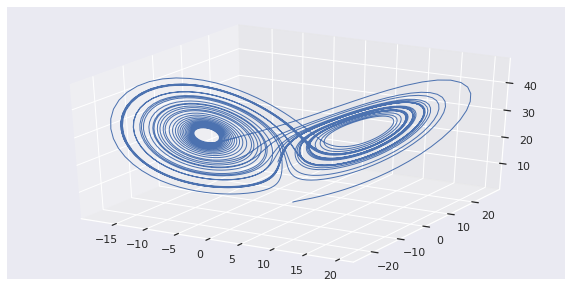

In [ ]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()
sns.set(rc={'figure.figsize':(10, 10), "lines.linewidth": 1.0})

###### *Summary: Attractor, Trajectory in phase space, Lyapunov exponent (forecast error)*

For this specific system shown, the vector field looks like this, and let scatter a bunch of random points around to represent different possible states see how they evolve and move around: They all spiral towards the center.

For this exampe the attraction is zero, and the basin is every point in space. Notice that at the origin x dot and y dot also equal zero.

$\dot{x}=-(0)-0.1(0)=0$

$\dot{y}=(0)-0.4(0)=0$

The origin is in this case **fixed point (attractor)**, because every point in there will stay forever. It seem like an inevitability, hence determinism (as chaos is).

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_01.png)

But there are also other types of attractors, like the **Van der Pol oscillator**:

> $\dot{x}=\mu\left(x-\frac{1}{3} x^{3}-y\right)$

> $\dot{y}=\frac{1}{\mu} x$

It creates something called: "**Limit Cycle Attractor**":

* it doesn't end up in a point

* typically appear in physical systems with some sort of oscillation (electrical circuits, tectonic plates, etc).

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_02.png)

**Strange Attractor** (has a fractal dimension)

Lorenz Attractor: Lorenz system describes convection cycles in the atmoshphere. Very sensitive to changes in initial conditions already after a short time:

> $\dot{x}=\sigma(y-x)$

> $\dot{y}=x(\rho-z)-y$

> $\dot{z}=x y-\beta z$

The Lorenz equations have a few parameters that can be tweaked to alter the behavior of a system. This is what is known as ‘strange attractor’:

> $\dot{x}=10(y-x)$

> $\dot{y}=x(28-z)-y$

> $\dot{z}=x y-\frac{8}{3} z$

1. No point in the space is ever visited more than once by the same trajectory - it that happens, the trajectory would travel in a predictable loop. 
2. And no 2 trajectories will ever intersect. If that happened, they would merge into the same path, giving two different sets of initial conditions the same outcome.

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_03.png)

A single trajectory will visit an infinite number of points in this limited space, and this limited space will have an infinite number of trajectories. 

* Trajectories are just curved, so they should be 1-dimensional..normally!
* For the strange attractor: no matter how much you zoom in on this attractor, you can always find more and more trajectories everywhere.
* That’s why this attractor is said to have a **non integer dimension** - it’s **made up of infinite long curves in a finite space, which are so detailed, that they start to partially fill up higher dimensions**. It’s not 1, 2 or 3 dimensional, its somewhere in between. (=detail at arbitrarily small scales)

Conclusion: Lorenz attractor is a fractal space, and hence a strange attractor.

Even is both points started at the same point, small initial differences can bring them to complete different paths:

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chros_05.png)

The difference in trajectories increases exponentially:

**$\lambda$ stands for Lyapunov exponent**

$\lambda$ > 0, trajectories will increase exponentially (= chaotic)

$\lambda$ = 0, distance will stay constant

$\lambda$ < 0, distance will converge to zero.

*Unfortunately there is no way to find the Lyapunov exponent only by looking at the equations. It is measured by running the simulation, keeping track of mainy pairs of trajectories, and find the average rate of change in their distance. But it provides a simple metric to comunicate how chaotic a system is*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/chaos_06.png)

**For the Lorenz attractor it is $\lambda$ ≈ 0.9**

Used to find out duration in which the predictions are valid: "Predictability Horizon". We get this by re-arranging our previous equation $d_{t}=d_{0} e^{\lambda t}$:

> Predictability horizon $=\frac{1}{\lambda} \ln \frac{a}{d_{0}}$

$d_{0}=$ initial error 

$a=$ maximum allowed error

**For the Lorenz attractor, after 10 time steps, any error would have multiplied by 8,000 already.**

Example what that means with this exponential divergence:

We have a simulation that predicts where ocean currents flow, and you want to keep the error less than 1,000 km. 
* If you ran it twice, once an initial error of 1m and once the initial error was a million times smaller than one micrometer (0,000001m), how much longer  the simulation with the smaller error would stay below the margin of error.
* The simulation would be valid 9 days instead of 3 days, but for an initial error that is a million times smaller !!

Let’s write the expressions for the two predictability horizons, and put them in a fraction:

> $\frac{\left(\frac{1}{\lambda} \ln \frac{1000}{0.000001}\right)}{\left(\frac{1}{\lambda} \ln \frac{1000}{1}\right)}$

> = $\frac{\left(\frac{1}{\lambda} \ln 10^{9}\right)}{\left(\frac{1}{\lambda} \ln 10^{3}\right)}$

> = $\frac{\left(9 \cdot \frac{1}{\lambda} \ln 10\right)}{\left(3 \cdot \frac{1}{\lambda} \ln 10\right)}$

> = $\frac{9}{3}$. 

= It’s 3 times longer.


##### <font color="blue">*Variationsanalyse*

###### *Variational Principle*

> Mathematisch gesehen ist die Wirkung ein Funktional. Während Funktionen bestimmten Zahlen andere Zahlen zuordnen, ordnen Funktionale bestimmten Funktionen Zahlen zu.

https://www.spektrum.de/news/jenseits-von-einsteins-gravitationstheorie/1997152

**Variationsrechnung**

* https://de.m.wikipedia.org/wiki/Variationsrechnung

* calculus og variation, khan academy https://youtube.com/playlist?list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

* **Find [stationary points](https://internal.ncl.ac.uk/ask/numeracy-maths-statistics/core-mathematics/calculus/stationary-points.html) (=derivative is zero, local minima or maxima) of a functional, like an integral I[f] (=here for example the path lenghts, or time spent travelling) is minimal between two points a and b.**

  * A stationary point of a function $f(x)$ is a point where the derivative of $f(x)$ is equal to 0 . 
  * These points are called "stationary" because at these points the function is neither increasing nor decreasing. 
  * Graphically, this corresponds to points on the graph of $f(x)$ where the tangent to the curve is a horizontal line.
 * The stationary points of a function $y=f(x)$ are the solutions to $
\frac{d y}{d x}=0 $. This repeats in mathematical notation the definition given above: "points where the gradient of the function is zero".

* **The integral is a functional (=function of functions), its stationary point is a fix point / minima of a functional (not function). Solve (usually differential) equations for stationary function f(x) (via calculus of variations)**

* from regular calculus to calculus of variations: find stationary functions, not only stationary points, a function becomes a functional.

* **Typical problem in variational calculus: find minimal path between points A and B, not necessarily a linear one (in physics for examples check Brachistochrone !)**. 

* Also consider that velocity depending on position changes the minimum paths or time to travel (later in vector analysis relevant for Kurvenintegral)

In general, Calculus of variations seeks to find y = f(x) such that this integral:

> $I[f]=\int_{x_{1}}^{x_{2}} F\left(x, y, \frac{d y}{d x}\right) d x$

is stationary (ps: $\frac{d y}{d x}$ = $y'$)

1. Die [Variationsrechnung](https://de.wikipedia.org/wiki/Variationsrechnung) ist eine **Erweiterung der Funktionalanalysis und beschaeftigt sich mit <u>nichtlinearen Funktionalen</u>** (in der Funktionalanalysis sind es linear Funktionale)

2. The [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations) is a field that **uses variations, which are small changes in functions and functionals, to find maxima and minima of functionals**: mappings from a set of functions to the real numbers. Functionals are often expressed as definite integrals involving functions and their derivatives. <u>**Functions that maximize or minimize functionals may be found using the Euler–Lagrange equation of the calculus of variations.**</u>

* In calculus of variations we are **NOT concerned with finding fix points of functions (like local maxima in a function), but rather fix points of functionals.**


* dann führt eine Variation der Wirkung: https://de.m.wikipedia.org/wiki/Feldtheorie_(Physik)#Formalismus

* Beispiel: https://de.wikipedia.org/wiki/Fluiddynamik

* Martin: formulier problem in variationelle formulierung (dann bist du in sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

* **Variation der Elemente**: die [Variation der Elemente](https://de.wikipedia.org/wiki/Variation_der_Elemente) ist eine im 19. Jahrhundert entwickelte Methode zur genauen Bahnbestimmung von Himmelskörpern. Sie dient bis heute zur Modellierung von [Bahnstörungen](https://de.wikipedia.org/wiki/Bahnstörung).

* **History of variational principles in physics**: 
https://en.m.wikipedia.org/wiki/History_of_variational_principles_in_physics

* [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential) ist eine **Verallgemeinerung des gewöhnlichen Differentiationsbegriffes** dar, indem es die Richtungsableitung auch in unendlichdimensionalen Räumen definiert.

* Variational method in quantum mechanics: In quantum mechanics, the [variational method](https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) is one way of finding approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals. The basis for this method is the variational principle.

Die Variationsrechnung beschäftigt sich mit der Minimierung bzw. Maximierung von Funktionalen, die als Integral dargestellt werden können. Man könnte sie daher als „natürliche“ Methode zur Lösung physikalischer Probleme bezeichnen, da die Physik ja bekanntlich von Extremalprinzipen regiert wird (kürzeste Bahn, kleinste Wirkung, Gesamtenergie, Hamilton-Funktion). Die „Variation“ dieser Integralbeziehung bezüglich einer abhängigen Größe (in der Physik z.B. der Bahnkurve im Zustandsraum) führt auf eine Differentialgleichung, deren Lösung diesen Integralausdruck minimiert respektive maximiert.

https://link.springer.com/chapter/10.1007/978-3-642-83621-3_7

Der Name Variationsrechnung bezieht sich dabei auf die Technik der Variation der Argumente. Wesentliches Ziel der Variationsrechnung ist das Finden von Extrema (haufig unter Nebenbedingungen) für ein gegebenes Funktional.


**Variational Principle**

* a [variational principle](https://en.wikipedia.org/wiki/Variational_principle) is one that enables a problem to be solved using calculus of variations, which concerns finding such functions which optimize the values of quantities that depend upon those functions. 

* For example, the problem of determining the shape of a hanging chain suspended at both ends—a catenary—can be solved using variational calculus, and in this case, the variational principle is the following: The solution is a function that minimizes the gravitational potential energy of the chain.

* Any physical law which can be expressed as a variational principle describes a **self-adjoint operator.** These expressions are also called Hermitian. Such an expression describes an invariant under a Hermitian transformation.

![cc](https://upload.wikimedia.org/wikipedia/commons/1/10/Total_variation.gif)

*As the green ball travels on the graph of the given function, the length of the path travelled by that ball's projection on the y-axis, shown as a red ball, is the total variation of the function.*

* the [total variation](https://en.wikipedia.org/wiki/Total_variation) identifies several slightly different concepts, related to the (local or global) structure of the codomain of a function or a measure. For a real-valued continuous function f, defined on an interval [a, b] ⊂ ℝ, its total variation on the interval of definition is a measure of the one-dimensional [arclength](https://en.wikipedia.org/wiki/Arc_length) of the curve with parametric equation x ↦ f(x), for x ∈ [a, b].

* In der Variationsrechnung und der Theorie der stochastischen Prozesse ist die [Variation](https://de.wikipedia.org/wiki/Variation_(Mathematik)) (auch totale Variation genannt) einer Funktion **ein Maß für das lokale Schwingungsverhalten der Funktion**. 

* Bei den stochastischen Prozessen ist die Variation von besonderer Bedeutung, da sie die Klasse der zeitstetigen Prozesse in zwei fundamental verschiedene Unterklassen unterteilt: jene mit endlicher und solche mit unendlicher Variation.

Die [erste Variation](https://de.wikipedia.org/wiki/Erste_Variation) ist eine verallgemeinerte Richtungsableitung eines Funktionals. Ihre Eigenschaften sind in der angewandten Mathematik und der theoretischen Physik relevant. Die erste Variation spielt eine zentrale Rolle in der Variationsrechnung und wird in der analytischen Mechanik genutzt. Ein verwandtes Konzept ist die Funktionalableitung.

In der Analysis ist eine Funktion von [beschränkter Variation](https://de.wikipedia.org/wiki/Beschränkte_Variation) (beschränkter Schwankung), wenn ihre totale Variation (totale Schwankung) endlich ist, sie also in gewisser Weise nicht beliebig stark oszilliert. Diese Begriffe hängen eng mit der Stetigkeit und der Integrierbarkeit von Funktionen zusammen.

**Anwendungsgebiete**

* Die Variationsrechnung ist die mathematische Grundlage aller physikalischen Extremalprinzipien und deshalb besonders in der theoretischen Physik wichtig, so etwa 

  * im Lagrange-Formalismus der klassischen Mechanik
  
  * bzw. der Bahnbestimmung, in der Quantenmechanik in Anwendung des Prinzips der kleinsten Wirkung 
  
  * und in der statistischen Physik im Rahmen der Dichtefunktionaltheorie.
  
  * In der Mathematik wurde die Variationsrechnung beispielsweise bei der riemannschen Behandlung des Dirichlet-Prinzips für harmonische Funktionen verwendet. 
  
  * Auch in der Steuerungs- und Regelungstheorie findet die Variationsrechnung Anwendung, wenn es um die Bestimmung von Optimalreglern geht.

* Ein typisches Anwendungsbeispiel ist das Brachistochronenproblem: Auf welcher Kurve in einem Schwerefeld von einem Punkt A zu einem Punkt B, der unterhalb, aber nicht direkt unter A liegt, benötigt ein Objekt die geringste Zeit zum Durchlaufen der Kurve? Von allen Kurven zwischen A und B minimiert eine den Ausdruck, der die Zeit des Durchlaufens der Kurve beschreibt. Dieser Ausdruck ist ein Integral, das die unbekannte, gesuchte Funktion, die die Kurve von A nach B beschreibt, und deren Ableitungen enthält.

**Fundamentallemma der Variationsrechnung**

https://de.wikipedia.org/wiki/Fundamentallemma_der_Variationsrechnung

**Fundamentalsatz der Variationsrechnung**

* Fundamental Theorem of the Calculus of Variations - [Fundamentalsatz der Variationsrechnung](https://de.wikipedia.org/wiki/Fundamentalsatz_der_Variationsrechnung)

* eng verwandt mit dem [weierstraßschen Satz vom Minimum](https://de.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum)

* Er behandelt die in der Variationsrechnung zentrale Frage, unter welchen Bedingungen reellwertige Funktionale ein Minimum annehmen.

###### *Brachistochrone & Tautochronie*

[**Brachistochrone Curve**](https://en.wikipedia.org/wiki/Brachistochrone_curve) (in rot): Der Körper gleitet auf einer solchen Bahn schneller zum Ziel als auf jeder anderen Bahn, beispielsweise auf einer geradlinigen, obwohl diese kürzer ist.


![vv](https://upload.wikimedia.org/wikipedia/commons/6/63/Brachistochrone.gif)

* Brachistochrone: Path between 2 points $A$ and $B$ which minimizes the time taken by a particle falling from $A$ to $B$ under the influence of gravity.

* Time = distance / speed. Goal: Mix of minimize distance and maximize speed

* Johann I Bernoulli hat sich mit dem **Problem des schnellsten Falles** beschäftigt. Im Jahre 1696 fand er schließlich die Lösung in der **Brachistochrone**. Heute sieht man dies oft als die **Geburtsstunde der Variationsrechnung**.

* Video: [The Brachistochrone Problem and Solution | Calculus of Variations](https://www.youtube.com/watch?v=zYOAUG8PxyM)

**Tautochronie** der Brachistochrone – von jedem Startpunkt auf der Kurve erreichen die Kugeln das „Ziel“ gleichzeitig.

![ff](https://upload.wikimedia.org/wikipedia/commons/b/bd/Tautochrone_curve.gif)

###### *Bewegungsgleichungen (Newton)*

**Hintergrund: Bewegungsgleichungen**

* Unter einer [Bewegungsgleichung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt. 

* In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung (=Beschleunigung / Acceleration)

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

> **Es gibt drei Ansätze für Bewegungsgleichungen: Newtonian Mechanics, Lagrangian and Hamiltonian. Für letztere beiden gilt the Principle of Least Action.**

**Newtonsche Gesetze**

Die [Newtonschen Gesetze](https://de.m.wikipedia.org/wiki/Newtonsche_Gesetze) (Fundamentalkonzept der klassischen Mechanik, Extremalprinzip des Wirkungsfunktionals) gelten als die Grundlage der klassischen Mechanik, auf der alle weiteren Modelle basieren. Zentrales Konzept dieser Formulierung ist die Einführung von Kräften, die eine Beschleunigung $\ddot{\vec{x}}$ einer Masse $m$ hervorrufen. Die Bewegungsgleichung dieser Masse wird bestimmt durch die Überlagerung der Kräfte $\vec{F}_{i}$, die auf die Masse wirken

> $
m \ddot{\vec{x}}=\sum_{i=1}^{N} \vec{F}_{i}
$

1. Ein kräftefreier Körper bleibt in Ruhe oder bewegt sich geradlinig mit konstanter Geschwindigkeit (siehe [Trägheit](https://de.m.wikipedia.org/wiki/Trägheit#Bedeutung_für_wichtige_Prinzipien_der_Mechanik))

2. Kraft gleich Masse mal Beschleunigung. $(\vec{F}=m \cdot \vec{a})$ $\rightarrow$ Equation of Motion (2. Newtonsches Gesetz)

3. Kraft gleich Gegenkraft: Eine Kraft von Körper A auf Körper B geht immer mit einer gleich großen, aber entgegen gerichteten Kraft von Körper B auf Körper A einher.

>$
\vec{F}_{A \rightarrow B}=-\vec{F}_{B \rightarrow A}
$

**Bewegungsgleichungen**

* eine [Bewegungsgleichung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) ist eine Gleichung, die die Entwicklung eines mechanischen Systems bei äußeren Einflüssen beschreibt

* Unter einer Bewegungsgleichung versteht man eine mathematische Gleichung (oder auch ein Gleichungssystem), welche die räumliche und zeitliche Entwicklung eines mechanischen Systems unter Einwirkung äußerer Einflüsse vollständig beschreibt. In der Regel handelt es sich um Systeme von Differentialgleichungen zweiter Ordnung.

* Diese Differentialgleichungen sind für viele Systeme nicht analytisch lösbar, sodass man bei der Lösung geeignete Näherungsverfahren anwenden muss.

* Lösung: Die Lösung der Bewegungsgleichung ist die [Trajektorie](https://de.m.wikipedia.org/wiki/Trajektorie_(Physik)), auf der sich das System bewegt. Sie ist, abgesehen von einigen einfachen Fällen (siehe Beispiele unten), meist nicht in analytisch geschlossener Form darstellbar und muss über [numerische Methoden](https://de.m.wikipedia.org/wiki/Numerische_Mathematik) gewonnen werden. Dies ist z. B. zur Ermittlung der Trajektorien dreier Himmelskörper, die sich gegenseitig gravitativ anziehen, erforderlich (siehe [Dreikörperproblem](https://de.m.wikipedia.org/wiki/Dreik%C3%B6rperproblem)). Zur Lösung eines N-Teilchensystems lässt sich die [discrete element method](https://de.m.wikipedia.org/wiki/Discrete_element_method) anwenden. In einfachen Fällen wird die geschlossene Lösung als „Bahngleichung“ bezeichnet.

**Newtonsche Axiome**

Prinzipen: Zum Aufstellen von Bewegungsgleichungen in der klassischen Physik wird verwendet:

* das 2. Newtonsche Gesetz,
* der Lagrange-Formalismus oder
* der Hamilton-Formalismus

Darauf basierend ergibt sich die Bewegungsgleichung der Quantenmechanik, die Schrödingergleichung.

**In der Technischen Mechanik werden verwendet**:

* das Prinzip der virtuellen Arbeit (D’Alembertsches Prinzip)
* das Prinzip der virtuellen Leistung (Prinzip von Jourdain)
* das Prinzip des kleinsten Zwanges.



###### *Principle of Least / Stationary Action (Lagrange-Formalismus)*

**Lagrange-Formalismus**

Der [Lagrange-Formalismus](https://de.m.wikipedia.org/wiki/Lagrange-Formalismus) beschreibt die Gesetze der klassischen Mechanik durch die Lagrange-Funktion $L$, die für Systeme mit einem generalisierten Potential und holonomen [Zwangsbedingungen](https://de.m.wikipedia.org/wiki/Zwangsbedingung) als Differenz aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben ist:

>$
L=T-V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der Euler-Lagrange-Gleichungen, die die Ableitungen nach der Zeit $t$, den Geschwindigkeiten $\dot{q}_{i}$ und den [generalisierten Koordinaten](https://de.m.wikipedia.org/wiki/Generalisierte_Koordinate) $q_{i}$ miteinander in Verbindung setzt:

>$
\frac{\mathrm{d}}{\mathrm{d} t} \frac{\partial L}{\partial \dot{q}_{i}}=\frac{\partial L}{\partial q_{i}}
$

> Action $S$ = Kinetic Energy - Potential Energy = $\int (T - V) dt$ = $\int (\frac{1}{2} mv^2 - mgh) dt$

$L$ is the Lagrangian of the particle: $L=E_{u}-U$. 

*Need to solve Lagrange equations to make $S$ stationary:*

> $\frac{\partial L}{\partial q_{1}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{1}}\right)$

>$\frac{\partial L}{\partial q_{2}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{2}}\right)$

> $\frac{\partial L}{\partial q_{3}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{3}}\right) \quad \begin{array}{c}\\ \end{array}$

We can use a general coordinate system:
$\\ {\left[q_{1}(t), q_{2}(t), q_{3}(t)\right]}$

*Lagrange-Gleichungen erster Art*

* Mit den Lagrange-Gleichungen erster Art lassen sich die Zwangskräfte berechnen.

* Wenn man annimmt, dass sich die äußeren Kräfte aus einem Potential ableiten lassen, kann man die Bewegungsgleichung schreiben (Lagrange-Gleichung 1. Art):

*Lagrange-Gleichungen zweiter Art*

* Die Lagrange-Gleichungen zweiter Art ergeben sich als sogenannte Euler-Lagrange-Gleichungen eines Variationsproblems und liefern die Bewegungsgleichungen, wenn die Lagrange-Funktion gegeben ist. 

* Sie folgen aus der Variation des mit der Lagrange-Funktion gebildeten Wirkungsintegrals im Hamiltonschen Prinzip.

Eingeführte Formulierung der klassischen Mechanik, in der die Dynamik eines Systems durch **eine einzige skalare Funktion, die Lagrange-Funktion**, beschrieben wird. Der Formalismus ist (im Gegensatz zu der newtonschen Mechanik, die a priori nur in Inertialsystemen gilt) auch in beschleunigten Bezugssystemen gültig. Der Lagrange-Formalismus ist invariant gegen Koordinatentransformationen.

Der [Langrange Formalismus](https://de.wikipedia.org/wiki/Lagrange-Formalismus) ist eine mögliche (von vielen!) Formulierung der klassischen Mechanik. Hier wird die Dynamik eines Systems durch die Langrange-Funktion L(${\boldsymbol{q}}$, $\dot{\boldsymbol{q}}$, $t$) beschrieben:

* ${\boldsymbol{q}}$ = (q1, q2, ..., qw) - allgemeine Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ = (d / dt) q ... ($\dot{\boldsymbol{q}}$1, $\dot{\boldsymbol{q}}$2.. $\dot{\boldsymbol{q}}$n) - Vektor der Wirkung (allgemeine Geschwindigkeiten)
* $t$ - Zeit (Die explizite Zeitabhängige berücksichtigt externe, zeitabhängige Faktoren (z.B. Magnet-Felder etc). Wird auf Null gesetzt, denn bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

> $L_{x}(q, \dot{q}, t)$ wird zu: $L_{x}(q, \dot{q})$ = $T$<sub>kin</sub> - $V$<sub>pot</sub>

*Principle of Least Action or Stationary Action*

> Action  𝑆  = Kinetic Energy - Potential Energy

* Principle of Least Action = better: [Stationary Action](https://en.m.wikipedia.org/wiki/Stationary-action_principle) = Wirkung

https://youtu.be/dPxhTiiq-1A

[The Principle of Stationary Action](https://www.youtube.com/watch?v=M05ixbSOY80): If a particle/system $P$ travels from one point to another in the time interval $\left[t_{1}, t_{2}\right]$, the path the particle traverses is such that this function:

> $
S=\int_{t_{1}}^{t_{2}} \mathcal{L} \text { dt}$

is stationary. 

* Total energy = kinetic energy + potential energy.

> **Kinetic - potential energy = Lagrangian $L$** 

> has no physical meaning !! It's a ver useful mathematical tool

* Kinetic energy depends on velocity of a particle (detonated with a dot over x,y,z), potential energy depends on position of a particle x,y,z. Hence the Lagrangian of a particle depends on all of the positions and all of their time derivatives. 

* **Use and solve the three Lagrangian equations in order to determine the equation of motion of a particle (and Lagrange equations are equivalent to Newton's second law)**

* And they can easily applied to other coordinate systems than cartesian (i.e cylindric, or spherical)

* Also: **Lagrange equations are very similar to Euler-Lagrange Equations!**

* Because the three Lagrange equations very strongly resemble the Euler-Lagrange-equation, there must be some functional that's being made stationary by Lagrange equations

* **$S$ is the action integral (= a functional!)**

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_01.png)

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_02.png)

###### *Euler-Lagrange Equation*

**Euler-Lagrange Equation**

*Why using Euler-Lagrange Equation?*

1) lagrangian mechanies gives equation of motion without considering forces at all, only energy

2) This is more convenient for complicated systems with multiple forces to be considered

3) Great for dealing with multiple coordinate

*How to get the Euler-Lagrange Equation?*

* **Step 1: Lagrangian equation**: L = T (kinetic energy) - V (potential energy)

  * T = $\frac{1}{2}m \dot x ^2 $ 
  
    * with $\dot x$ short for: $\frac{dx}{dt}$

  * V = $\frac{1}{2}k x ^2 $ 

  * so: L = $\frac{1}{2}m \dot x ^2 $ - $\frac{1}{2}k x ^2 $ -> This is our Lagrangian for a specific system !

* **Step 2: Now take Euler–Lagrange Equation**: $\frac{d}{d t}\left(\frac{\partial L}{\partial \dot q}\right)=\frac{\partial L}{\partial q}$

  * we see it contains the Lagrangian

  * it's consistent with Newtonian classical mechanics F=ma etc

  * we can plug in our Lagrangian for a specific system (replace L with formula above). we get the equation of motion!

* **Step 3: Equation of Motion**: $m \ddot x = -kx$

  * mass m of an object multipliplied by acceleration $\ddot x$ (which is the second derivative of x, the whole left side is same as newton's: f=m*a)

  * we are stating something about the forces acting on the system

*More about Euler–Lagrange equation*

* Langrangian = Kinetic Energy - Potential Engergy

* then insert it into the **Euler-Langrange Equation**:

> $\frac{d}{d t} \frac{\partial L}{\partial \dot{\theta}}=\frac{\partial L}{\partial \theta}$

* the Euler-Langrange Equation is the condition of the action $S$ to be minimized, where action is integral of Lagrangian

* Means: of all the possible paths a particle could follow, the actual path it chooses is the one that minimizes (or actually "extremizes") the action = **principle of least action**

* with Lagrangian we don't need any vectors anymore like in Newtonian, we can sue whatever coordinates. Also it makes it easier to deal with constraints and understands symmetries

* F = ma in the Euler Lagrange Equation gives us a single second-order differential equation

The Euler–Lagrange equation is an equation satisfied by a function q of a real argument t, which is a stationary point of the functional:

> $S(\boldsymbol{q})=\int_{a}^{b} L(t, \boldsymbol{q}(t), \dot{\boldsymbol{q}}(t)) \mathrm{d} t$

* ${\boldsymbol{q}}$ - Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ - Vektor der Wirkung
* t - Zeit (wird auf Null gesetzt, den bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

The Euler–Lagrange equation, then, is given by

> $L_{x}(t, q(t), \dot{q}(t))-\frac{\mathrm{d}}{\mathrm{d} t} L_{v}(t, q(t), \dot{q}(t))=0$

* partial derivative of one dimension, then second dimension and then time

* the [Euler equation](https://en.m.wikipedia.org/wiki/Euler–Lagrange_equation) is a **second-order partial differential** equation whose **solutions are the functions for which a given functional is stationary**.

* Because **a differentiable functional is stationary at its local extrema**, the Euler–Lagrange equation is useful for solving optimization problems in which, given some functional, one seeks the function minimizing or maximizing it. 

* This is analogous to [Fermat's theorem](https://en.m.wikipedia.org/wiki/Fermat%27s_theorem_(stationary_points)) in calculus, stating that at any point where a differentiable function attains a local extremum its derivative is zero.

* In Lagrangian mechanics, according to [Hamilton's principle](https://en.m.wikipedia.org/wiki/Hamilton%27s_principle) of stationary action, the evolution of a physical system is described by the solutions to the Euler equation for the action of the system. In this context Euler equations are usually called Lagrange equations. In classical mechanics, it is equivalent to Newton's laws of motion, but it has the advantage that it takes the same form in any system of generalized coordinates, and it is better suited to generalizations.

  * Hamilton's principle is William Rowan Hamilton's formulation of the [principle of stationary action](https://en.m.wikipedia.org/wiki/Principle_of_least_action) (also called: 'Principle of least action'). It states that the **dynamics of a physical system are determined by a variational problem for a functional based on a single function**, the Lagrangian, which may contain all physical information concerning the system and the forces acting on it. The variational problem is equivalent to and allows for the derivation of the differential equations of motion of the physical system


###### *Hamiltonian Function*

*Hamilton'sches Prinzip (Wirkungsfunktional)*

> Das [Hamilton'sche Prinzip](https://de.wikipedia.org/wiki/Hamiltonsches_Prinzip) zeichnet tatsachlich durchlaufene Bahnen dadurch aus, **dass bei ihnen die Wirkung (=Funktional) S[q] (verglichen mit anderen Bahnen) ein Minimum annimmt (minimal variation ??)**.

* Das Hamiltonsche Prinzip der Theoretischen Mechanik ist ein **Extremalprinzip**. Physikalische Felder und Teilchen nehmen danach für eine bestimmte Größe einen extremalen (d. h. größten oder kleinsten) Wert an. Diese Bewertung nennt man Wirkung (=Action), mathematisch ist die Wirkung ein Funktional, daher auch die Bezeichnung **Wirkungsfunktional**.

* Die Wirkung erweist sich in vielen Fällen nicht als minimal, sondern nur als **„stationär“** (d. h. extremal). Deshalb wird das Prinzip von manchen Lehrbuchautoren auch das Prinzip der **stationären Wirkung** genannt. Manche Autoren nennen das Hamiltonsche Prinzip auch **'Prinzip der kleinsten Wirkung'**, was jedoch – wie oben ausgeführt – nicht präzise ist.

* Hamilton's principle states that the true evolution of a physical system is a solution of the functional equation:

> $\frac{\delta \mathcal{S}}{\delta \mathbf{q}(t)}=0$

* That is, the system takes a path in configuration space for which the action is stationary, with fixed boundary conditions at the beginning and the end of the path.

![ff](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Least_action_principle.svg/500px-Least_action_principle.svg.png)

*As the system evolves, q traces a path through configuration space (only some are shown). The path taken by the system (red) has a stationary action (δS = 0) under small changes in the configuration of the system (δq).*

*Hamiltonsche Mechanik & Hamilton-Funktion*

> Die [**Hamilton-Funktion**](https://de.m.wikipedia.org/wiki/Hamilton-Funktion) eines Systems von Teilchen ist (,wenn keine rheonomen (d. h. zeitabhängigen) Zwangsbedingungen vorliegen), **die Gesamtenergie als Funktion der Orte und Impulse der Teilchen** und gegebenenfalls der Zeit. 

* Total Energy = Kinetic Energy + Potential Energy

* rewrite everything in terms of momentum, and we get the **Hamiltonian**:

> $H=\frac{p^{2}}{2 m l^{2}}-m g l \cos \theta$

* the Hamiltonian gives us a pair of first-order differential equations for theta and pi

* the generalized version is Momentum * Velocity - L (Lagrangian):

> $H=P \dot{\theta}-L$

* we get a new geometric perspective by connecting it with something known as "flow phase space": P (momentum) and Theta create a new vector space (pairs of them) called the "phase space", where I can see what the particle will do in the future. Energy is constant = particle travels along a line of constant energy

Die [Hamiltonsche Mechanik](https://de.m.wikipedia.org/wiki/Hamiltonsche_Mechanik) ist die am stärksten verallgemeinerte Formulierung der klassischen Mechanik und Ausgangspunkt der Entwicklung neuerer Theorien und Modelle, wie der Quantenmechanik. Zentrale Gleichung dieser Formulierung ist die Hamilton-Funktion H. Sie ist folgendermaßen definiert:

> $
H=\sum_{i} \dot{q}_{i} p_{i}-L(\vec{q}, \dot{\vec{q}}, t)
$

Dabei sind $\dot{q}_{i}$ die generalisierten Geschwindigkeiten und $p_{i}$ die generalisierten Impulse. 

> Die hamiltonschen Bewegungsgleichungen folgen aus dem hamiltonschen Prinzip der stationären Wirkung.

Ist die potentielle Energie unabhängig von der Geschwindigkeit und hängen die TransformationsGleichungen, die die generalisierten Koordinaten definieren, nicht von der Zeit ab, ist die Hamilton-Funktion in der klassischen Mechanik durch die Summe aus kinetischer Energie $T$ und potentieller Energie $V$ gegeben:

> $
H=T+V
$

Die Bewegungsgleichungen ergeben sich durch Anwenden der kanonischen Gleichungen:

> $
\begin{aligned}
\dot{q}_{i} &=\frac{\partial H}{\partial p_{i}} \\
\dot{p}_{i} &=-\frac{\partial H}{\partial q_{i}}
\end{aligned}
$

Mit dem Hamilton-Jacobi-Formalismus existiert eine modifizierte Form dieser Beschreibung, die die Hamilton-Funktion mit der Wirkung verknüpft.

**Operators in Classical Mechanics**

[Operators in classical mechanics](https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics): In classical mechanics, the movement of a particle (or system of particles) is completely determined by the **Lagrangian** $L(q, \dot{q}, t)$ or equivalently the **Hamiltonian** $H(q, p, t)$, a function of the generalized coordinates $q$, generalized velocities $\dot{q}=\mathrm{d} q / \mathrm{d} t$ and its conjugate momenta:

>$
p=\frac{\partial L}{\partial \dot{q}}
$

If either $L$ or $H$ is independent of a generalized coordinate $q$, meaning the $L$ and $H$ do not change when $q$ is changed, which in turn means the dynamics of the particle are still the same even when q changes, the corresponding momenta conjugate to those coordinates will be conserved (this is part of Noether's theorem, and the invariance of motion with respect to the coordinate $q$ is a symmetry). **Operators in classical mechanics are related to these symmetries.**

More technically, when $H$ is invariant under the action of a certain group of transformations $G$ :

>$
S \in G, H(S(q, p))=H(q, p)
$

the elements of $G$ are physical operators, which map physical states among themselves.

**Connections to Quantum Mechanics**

* Functions on phase phase in classical mechanics turn into operators in the quantum space of states in quantum mechanics

* And if you know the state of a quantum system at time t0, the Schrödinger equation says they at a later time t will be $|\psi \rangle$ $\rightarrow$ $e^{-\frac{i}{\hbar} H t}|\psi\rangle$ acting on the state, 

* where $H$ is the operator version of the classical Hamiltonian function

**Feynman Path Integral Formulation**

> *Principle of Least Action in Quantum Mechanics (Path Integral Formulation)*

The [path integral formulation](https://en.m.wikipedia.org/wiki/Path_integral_formulation) is a description in quantum mechanics that **generalizes the action principle of classical mechanics**. It replaces the classical notion of a single, unique classical trajectory for a system with a sum, or functional integral, over an infinity of quantum-mechanically possible trajectories to compute a quantum amplitude.

* Richard Feynman zeigte in den 1940ern, dass sich das Hamiltonsche Prinzip in der Quantenfeldtheorie gerade dadurch ergibt, dass alle möglichen Pfade (auch die nicht zielgerichteten) zulässig sind und aufintegriert werden. Dabei überlagern sich Pfade mit extremaler Wirkung konstruktiv und davon abweichende destruktiv, so dass die Natur schließlich zielgerichtet erscheint.

* Principle of least action is equivalent to newtonian mechanics (one can derive the on from the other). And both is for large scale objects, **meanwhile the principle of least action is the large scale approximation of the feynman path integral on quantum objects!** source at Min 7:53 here: https://www.youtube.com/watch?v=dPxhTiiq-1A

**Bewegungsgleichung der Allgemeinen Relativitätstheorie**

Die [Bewegung](https://de.m.wikipedia.org/wiki/Bewegungsgleichung) eines Körpers wird durch die Geodätengleichung der gekrümmten Raumzeit beschrieben, sofern nur gravitative Kräfte auf ihn einwirken. Dann bewegt sich der Körper entlang einer Geodäten der Raumzeit. Die Geodätengleichung lautet

> $
\ddot{x}^{\mu}+\Gamma_{\lambda \nu}^{\mu} \dot{x}^{\lambda} \dot{x}^{\nu}=\ddot{x}^{\mu}+\frac{g^{\mu \rho}}{2}\left(\partial_{\lambda} g_{\nu \rho}+\partial_{\nu} g_{\lambda \rho}-\partial_{\rho} g_{\lambda \nu}\right) \dot{x}^{\lambda} \dot{x}^{\nu}=0
$

wobei $\Gamma_{\lambda \nu}^{\mu}$ ein Christoffelsymbol 2. Art ist, welches die Abhängigkeit des metrischen Tensors vom Raumzeitpunkt (Ereignis), d. h. der Krümmung der Raumzeit, charakterisiert.

###### *Special: Minimal Surfaces*

**minimal surface**

A [minimal surface](https://en.m.wikipedia.org/wiki/Minimal_surface) is a surface that locally minimizes its area. 

* Intro Video: https://youtu.be/_t-3lCZXlPM

* Siehe auch: https://www.chemie-schule.de/KnowHow/Oberflächenspannung

* This is equivalent to having **zero mean curvature = second derivative is always zero at any point**

* **Minimal surfaces represent the lowest energy state!** A flat plane is minimalist surface area

* Erwin Schrödinger used Minimal Surfaces equations in 1926 to describe the quantum state of real phsysical systems

* the apparent horizon of a back whole can be are always minimal surfaces

* non trivial minimal surface: [Katenoid](https://en.m.wikipedia.org/wiki/Catenoid) and a [Helicoid (Wendelfläche)](https://de.m.wikipedia.org/wiki/Wendelfläche)

* For a given constraint there may also exist several minimal surfaces with different areas (for example, see [minimal surface of revolution](https://en.m.wikipedia.org/wiki/Minimal_surface_of_revolution)): the standard definitions only relate to a local optimum, not a global optimum.


![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Catenoid.svg/600px-Catenoid.svg.png)


Minimal surface theory originates with Lagrange who in 1762 considered the variational problem of finding the surface z = z(x, y) of least area stretched across a given closed contour. He derived the Euler–Lagrange equation for the solution

> $\frac{d}{d x}\left(\frac{z_{x}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)+\frac{d}{d y}\left(\frac{z_{y}}{\sqrt{1+z_{x}^{2}+z_{y}^{2}}}\right)=0$

He did not succeed in finding any solution beyond the plane. In 1776 Jean Baptiste Marie Meusnier discovered that the helicoid and catenoid satisfy the equation and that the differential expression corresponds to twice the mean curvature of the surface, concluding that surfaces with zero mean curvature are area-minimizing.

By expanding Lagrange's equation to

> $\left(1+z_{x}^{2}\right) z_{y y}-2 z_{x} z_{y} z_{x y}+\left(1+z_{y}^{2}\right) z_{x x}=0$

Gaspard Monge and Legendre in 1795 derived representation formulas for the solution surfaces. While these were successfully used by Heinrich Scherk in 1830 to derive his surfaces, they were generally regarded as practically unusable. Catalan proved in 1842/43 that the helicoid is the only ruled minimal surface.

Eine Minimalfläche ist eine Fläche im Raum, die lokal minimalen Flächeninhalt hat. Derartige Formen nehmen beispielsweise Seifenhäute an, wenn sie über einen entsprechenden Rahmen (wie etwa einen Blasring) gespannt sind. In mathematischer Sprache sind Minimalflächen die kritischen Punkte des Flächeninhaltsfunktionals

> $A(\mathbf{x})=\int \sqrt{g(u)} \mathrm{d}^{n} u$


Hierbei sind die Größen $g(u):=\operatorname{det}\left(g_{i j}(u)\right)_{i, j=1, \ldots, n}$ und $g_{i j}(u)=\left(\frac{\partial \mathbf{x}}{\partial u_{i}}\right)^{T} \frac{\partial \mathbf{x}}{\partial u_{j}}$ für $i, j=1, \ldots, n$  erklärt (vgl. Hesse-Matrix).

**Man beachte, dass eine Minimalfläche nicht notwendig minimalen Flächeninhalt hat, sondern lediglich ein stationärer Punkt des Flächeninhaltsfunktionals ist.** Man kann zeigen, dass das Verschwinden der ersten Variation des Flächeninhaltsfunktionals in zwei Raumdimensionen äquivalent zum Verschwinden der mittleren Krümmung H ist, falls die betrachtete Mannigfaltigkeit hinreichend regulär ist.


**Formulierung als Variationsproblem**

Eine Fläche ist genau dann eine [Minimalfläche](https://de.m.wikipedia.org/wiki/Minimalfläche), wenn sie an jedem Punkt die mittlere Krümmung null hat. Damit stellt sich eine Minimalfläche als Spezialfall einer Fläche vorgeschriebener mittlerer Krümmung dar. Diese entziehen sich ebenfalls nicht der Variationsrechnung, sie sind Minima des Hildebrandtschen Funktionals

> $A(\mathbf{x})=\iint\left(\left|\mathbf{x}_{u} \times \mathbf{x}_{v}\right|+2\left(Q(\mathbf{x}), \mathbf{x}_{u}, \mathbf{x}_{v}\right)\right) \mathrm{d} u \mathrm{~d} v$

Die Eulerschen Gleichungen als notwendige Minimalitätsbedingungen dieses Funktionals sind das nach Franz Rellich benannte H-Flächen-System

Siehe auch: [Schwarz minimal surface](https://en.m.wikipedia.org/wiki/Schwarz_minimal_surface)

$
\Delta \mathbf{x}=2 H \mathbf{x}_{u} \times \mathbf{x}_{v}, \quad \mathbf{x}_{u}^{2}-\mathbf{x}_{v}^{2}=0=\mathbf{x}_{u} \mathbf{x}_{v}
$

Hierbei ist $H=\operatorname{div} Q$ die mittlere Krümmung.

### <font color="blue">**Stochastic**

##### <font color="blue">*Stochastic Process, Stochastic Analysis & Stochastic Differential Equation*

**Stochastic Analysis**

* [Stochastic calculus](https://en.m.wikipedia.org/wiki/Stochastic_calculus) bzw. [Stochastische Analysis](https://de.m.wikipedia.org/wiki/Stochastische_Analysis) is a branch of mathematics that operates on stochastic processes. It allows a consistent theory of integration to be defined for integrals of stochastic processes with respect to stochastic processes. This field is created and started by the Japanese mathematician Kiyoshi Itô during World War 2.

* [Stochastische_Integration](https://de.m.wikipedia.org/wiki/Stochastische_Integration): Es sind stochastische Prozesse mit unendlicher Variation, insbesondere der Wiener-Prozess, als Integratoren zugelassen.

* [Stochastischer Prozess](https://de.m.wikipedia.org/wiki/Stochastischer_Prozess): (auch Zufallsprozess) zeitlich geordnete, zufällige Vorgänge. Theorie der stochastischen Prozesse ist Erweiterung der Wahrscheinlichkeitstheorie dar und bildet Grundlage für stochastische Analysis. 

* > Stochastic: Statistik + Probability Theory (incl stochastic / random processes)

* Bei einem Sparguthaben entspräche dies dem **exponentiellen Wachstum** durch Zinseszins. Bei Aktien wird dieses Wachstumsgesetz hingegen **in der Realität offenbar durch eine komplizierte Zufallsbewegung überlagert**. 

* Bei zufälligen Störungen, die sich aus vielen kleinen Einzeländerungen zusammensetzen, **wird von einer Normalverteilung als einfachstem Modell ausgegangen**. 

* Außerdem zeigt sich, dass die Varianz der Störungen proportional zum betrachteten Zeitraum $\Delta t$ ist. Der Wiener-Prozess $W_t$ besitzt alle diese gewünschten Eigenschaften, eignet sich also als ein Modell für die zeitliche Entwicklung der Zufallskomponente des Aktienkurses.


**Stochastic Differential Equation ( →  Black Scholes, Spontaneous Symmetry Breaking)**

* Eine [stochastischen Differentialgleichung](https://de.wikipedia.org/wiki/Stochastische_Differentialgleichung) ist eine Verallgemeinerung des Begriffs der gewöhnlichen Differentialgleichung auf stochastische Prozesse. 

> Stochastische Differentialgleichungen werden in zahlreichen Anwendungen eingesetzt, **um zeitabhängige Vorgänge zu modellieren**, die neben deterministischen Einflüssen zusätzlich **stochastischen Störfaktoren (Rauschen)** ausgesetzt sind.

* Die formale Theorie der stochastischen Differentialgleichungen wurde erst in den 1940er Jahren durch den japanischen Mathematiker Itō Kiyoshi formuliert. 

* Gemeinsam mit der **stochastischen Integration** begründet die Theorie der **stochastischen Differentialgleichungen** die **stochastische Analysis**.

* **Objective**: Genau wie bei deterministischen Funktionen möchte man auch bei stochastischen Prozessen den Zusammenhang zwischen dem Wert der Funktion und ihrer momentanen Änderung (ihrer Ableitung) in einer Gleichung formulieren. 

* **Challenge**: Was im einen Fall zu einer gewöhnlichen Differentialgleichung führt, ist im anderen Fall problematisch, da viele stochastische Prozesse, wie beispielsweise **der Wiener-Prozess, nirgends differenzierbar sind**.

* Loesung ist wie bei gewohnlichen Differentialgleichungen plus einen stochastischen Term

*Beim Typus der stochastischen Differentialgleichungen treten in der Gleichung stochastische Prozesse auf. Eigentlich sind stochastische Differentialgleichungen keine Differentialgleichungen [im obigen Sinne](https://de.m.wikipedia.org/wiki/Differentialgleichung#Weitere_Typen), sondern lediglich gewisse Differentialrelationen, welche als Differentialgleichung interpretiert werden können.*

*Beispiele fur stochastische Differentialgleichungen*

* Die SDGL für die geometrische brownsche Bewegung lautet $\mathrm{d} S_{t}=r S_{t} \mathrm{~d} t+\sigma S_{t} \mathrm{~d} W_{t} .$ Sie wird beispielsweise im Black-Scholes-Modell zur Beschreibung von Aktienkursen verwendet.

* Die SDGL für einen Ornstein-Uhlenbeck-Prozess ist $\mathrm{d} X_{t}=\theta\left(\mu-X_{t}\right) \mathrm{d} t+\sigma \mathrm{d} W_{t} .$ Sie wird unter anderem im Vasicek-Modell zur finanzmathematischen Modellierung von Zinssätzen über den Momentanzins
verwendet.

* Die SDGL für den Wurzel-Diffusionsprozess nach William Feller lautet $\mathrm{d} X_{t}=\kappa\left(\theta-X_{t}\right) \mathrm{d} t+\sigma \sqrt{X_{t}} \mathrm{~d} W_{t}$

**Supersymmetric theory of stochastic dynamics & Spontaneous Symmetry breaking**

* [Supersymmetric theory of stochastic dynamics](https://en.m.wikipedia.org/wiki/Supersymmetric_theory_of_stochastic_dynamics) or stochastics (STS) **is an exact theory of stochastic (partial) differential equations (SDEs)**, the class of mathematical models with the widest applicability covering, in particular, all continuous time dynamical systems, with and without noise.

* https://en.m.wikipedia.org/wiki/Chaos_theory#Chaos_as_a_spontaneous_breakdown_of_topological_supersymmetry

##### <font color="blue">*Markov Process & Monte Carlo Simulation*

A Markov chain is a **discrete-time stochastic process** that progresses from one state to another with certain probabilities that can be **represented by a graph and state transition matrix P** as indicated below:

<img src="https://raw.githubusercontent.com/deltorobarba/repo/master/markov.PNG" alt="markov">

* Markov chains may be modeled by **finite state machines, and random walks**

* A Stochastic (State Transition) Matrix describes a Markov chain X<sub>t</sub> over a [**finite state space (Probability space) S**](https://en.m.wikipedia.org/wiki/Probability_space) with cardinality S.

  * Various types of random walks are of interest, which can differ in several ways. The term itself most often refers to a special category of Markov chains or Markov processes, but many time-dependent processes are referred to as random walks, with a modifier indicating their specific properties. 

  * Random walks (Markov or not) can also take place on a variety of spaces: commonly studied ones include graphs, others on the integers or the real line, in the plane or higher-dimensional vector spaces, on curved surfaces or higher-dimensional Riemannian manifolds, and also on groups finite, finitely generated or Lie.

* Let P be the transition matrix of Markov chain {X0, X1, ...}.

  * **Reducibility**: a Markov chain is said to be irreducible if it is possible to get to any state from any state. In other words, a Markov chain is irreducible if there exists a chain of steps between any two states that has positive probability.

  * **Periodicity**: a state in a Markov chain is periodic if the chain can return to the state only at multiples of some integer larger than 1. Thus, starting in state 'i', the chain can return to 'i' only at multiples of the period 'k', and k is the largest such integer. State 'i' is aperiodic if k = 1 and periodic if k > 1.

  * **Transience and Recurrence**: A state 'i' is said to be transient if, given that we start in state 'i', there is a non-zero probability that we will never return to 'i'. State i is recurrent (or persistent) if it is not transient. A recurrent state is known as positive recurrent if it is expected to return within a finite number of steps and null recurrent otherwise. Transience and recurrence issues are central to the study of Markov chains and help describe the Markov chain's overall structure. The presence of many transient states may suggest that the Markov chain is absorbing, and a strong form of recurrence is necessary in an ergodic Markov chain.

  * **Ergodicity**: a state 'i' is said to be ergodic if it is aperiodic and positive recurrent. If all states in an irreducible Markov chain are ergodic, then the chain is said to be ergodic. Ergodic Markov chains are, in some senses, the processes with the "nicest" behavior.

  * **Absorbing State**: a state i is called absorbing if it is impossible to leave this state. Therefore, the state 'i' is absorbing if pii = 1 and pij = 0 for i ≠ j. If every state can reach an absorbing state, then the Markov chain is an absorbing Markov chain. Absorbing states are crucial for the discussion of absorbing Markov chains. A common type of Markov chain with transient states is an absorbing one. An absorbing Markov chain is a Markov chain in which it is impossible to leave some states, and any state could (after some number of steps, with positive probability) reach such a state. It follows that all non-absorbing states in an absorbing Markov chain are transient.

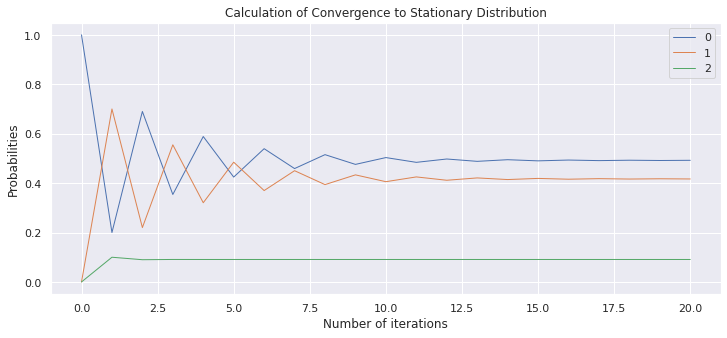

[[0.49229934 0.41679157 0.09090909]]


In [ ]:
from random import seed
from random import random
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})

P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])

state=np.array([[1.0, 0.0, 0.0]])

stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = [[0,0,0]]

iterations= 20

for x in range(iterations):
  state=np.dot(state,P)
  stateHist=np.append(stateHist,state,axis=0)

dfDistrHist = pd.DataFrame(stateHist)
dfDistrHist.plot(title="Calculation of Convergence to Stationary Distribution")
plt.xlabel("Number of iterations")
plt.ylabel("Probabilities")
plt.show()

# Print our exact values
print(state)

**Monte Carlo Simulation**

* Monte Carlo can be thought of as carrying out many experiments, each time changing the variables in a model and observing the response. 

* Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on **repeated random sampling to obtain numerical results**. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

* Monte Carlo methods are useful for **simulating systems with many coupled degrees of freedom**, such as fluids, disordered materials, strongly coupled solids, and cellular structures (see cellular Potts model, interacting particle systems, McKean–Vlasov processes, kinetic models of gases). Other examples include **modeling phenomena with significant uncertainty in inputs** such as the calculation of risk in business


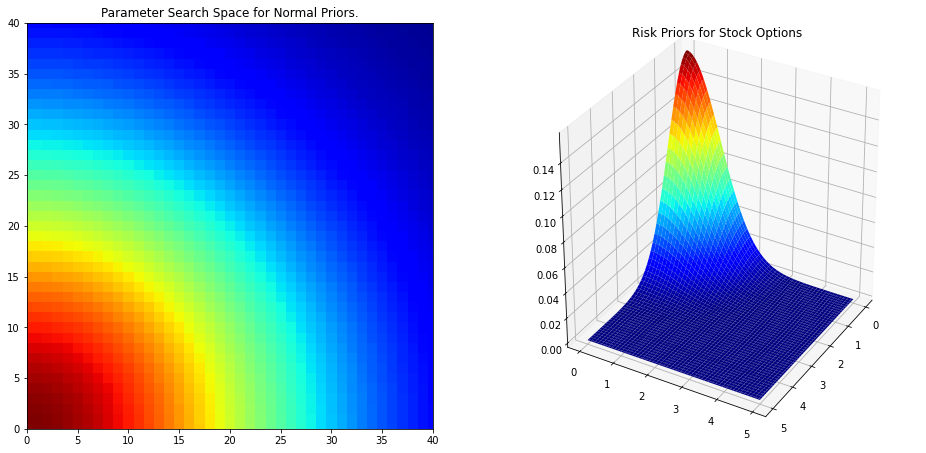

In [ ]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Parameter Search Space for Normal Priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Risk Priors for Stock Options");

# plt.title("Parameter Search Space for Normal Priors");

**Markov Chain Monte Carlo (MCMC)**

* Markov Chain Monte Carlo refers to a **class of methods** for sampling from a probability distribution in order to **construct the most likely distribution**. 

> MCMC can be considered as a **random walk** that gradually converges to the true distribution.

* We cannot directly calculate the (i.e. logistic) distribution, so instead we generate thousands of values — called samples — for the parameters of the function (alpha and beta) to **create an approximation of the distribution**. 

* The idea behind MCMC is that **as we generate more samples, our approximation gets closer and closer to the actual true distribution**.

* Markov Chain and Monte Carlo, MCMC is a method that repeatedly draws random values for the parameters of a distribution based on the current values. **Each sample of values is random, but the choices for the values are limited by the current state and the assumed prior distribution of the parameters**. 

##### <font color="blue">*White Noise*


**A white noise process has following conditions**

* Mean (level) is zero (does not change over time - stationary process)
* Variance is constant (does not change over time - stationary process)
* Zero autocorrelation (values do not correlate with lag values)

**White Noise: Independent & Identically Distributed**

* Hence, in a time series is white noise if the variables are independent and identically distributed (IID) with a mean of zero.

* The term 'white' refers to the way the signal power is distributed (i.e., independently) over time or among frequencies

* **Necessary Condition**: Independence: variables are statistically uncorrelated = their covariance is zero. Therefore, the covariance matrix R of the components of a white noise vector w with n elements must be an n by n diagonal matrix, where each diagonal element Rᵢᵢ is the variance of component wᵢ; and the correlation matrix must be the n by n identity matrix.

* **Sufficient Condition**: every variable in w has a normal distribution with zero mean and the same variance, w is said to be a Gaussian white noise vector. In that case, the joint distribution of w is a multivariate normal distribution; the independence between the variables then implies that the distribution has spherical symmetry in n-dimensional space. Therefore, any orthogonal transformation of the vector will result in a Gaussian white random vector. In particular, under most types of discrete Fourier transform, such as FFT and Hartley, the transform W of w will be a Gaussian white noise vector, too; that is, the n Fourier coefficients of w will be independent Gaussian variables with zero mean and the same variance.

* A random vector (that is, a partially indeterminate process that produces vectors of real numbers) is said to be a white noise vector or white random vector if its components each have a probability distribution with zero mean and finite variance, and are statistically independent: that is, their joint probability distribution must be the product of the distributions of the individual components.

* First moment has to be zero and second moment has to be finite though. (iid ) White noise is always an independent process but reverse may not be true. 

* The technical definition of white noise is that it has equal intensity at all frequencies. This corresponds to a delta function autocorrelation. This is only possible if there is no correlation between any sequential values. So yes, the independence is true both backwards and forwards. Note that the actual distribution is irrelevant.



**Types of White Noise Processes**
* If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise
* There are also white noise processes, like Levy etc.

**Relationship to Stochastic Processes**
* White noise is the generalized mean-square derivative of the Wiener process or Brownian motion (so Wiener is an integrated White Noise)

**White noise is an important concept in time series analysis and forecasting**

* **Predictability**: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
* **Model Diagnostics**: The statistics and diagnostic plots can be uses on time series to check if it is white noise. The series of errors from a time series forecast model should ideally be white noise. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.


        whitenoise
count  5000.000000
mean     -0.000236
std       0.991748
min      -3.149965
5%       -1.663347
50%      -0.006930
95%       1.656811
max       3.400552
First central moment: Mean of whitenoise   -0.000236
dtype: float64
Second central moment: Variance whitenoise    0.983565
dtype: float64
Third central moment: Skewness ('Higher moment') of  whitenoise   -0.001609
dtype: float64
Forth central moment: Kurtosis ('Higher moment') of whitenoise   -0.090712
dtype: float64
Compute specific percentiles of whitenoise    0.667429
Name: 0.75, dtype: float64


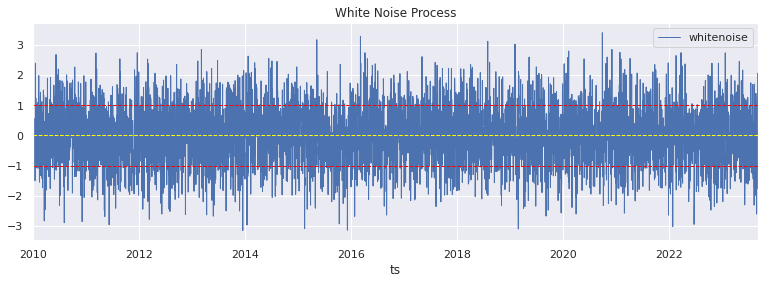

In [ ]:
# Create (Gaussian) White Noise

from random import gauss
from random import seed
from pandas import Series

# Set seed for reproducibility and hyperparameter
seed(1)
mean = 0.0
sigma = 1.0
periods = 5000

# Create White Noise
whitenoise = [gauss(mean, sigma) for i in range(periods)]
whitenoise = pd.DataFrame(data=Series(whitenoise), columns=['whitenoise'])

# Create Time Series
ts = pd.date_range('2010-01-01', periods=periods, freq='D')
ts = pd.DataFrame(data=ts, columns=['ts'])

# Merge and Set Index
series = pd.concat([ts, whitenoise], axis=1).set_index('ts')
series.head()

# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
series.plot(title='White Noise Process')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0)
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0)

print(series.describe(percentiles=[0.05, 0.95]))

print("First central moment: Mean of", + series.mean())
print("Second central moment: Variance", + series.var())
print("Third central moment: Skewness ('Higher moment') of ", + series.skew())
print("Forth central moment: Kurtosis ('Higher moment') of", + series.kurt())
print("Compute specific percentile of", + series.quantile(0.75))

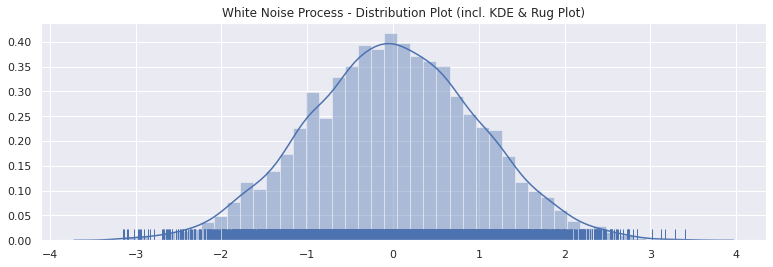

In [ ]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

##### <font color="blue">*Random Walk*

**Random Walk** 

* Random walk is another time series model where the current observation is equal to the previous observation with a random step up or down. Known as a stochastic or random process.

> y<sub>(t)</sub> = B<sub>0</sub> + B<sub>1</sub> * X<sub>(t-1)</sub> + e<sub>(t)</sub>

* A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. 

* The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides. It is this dependency that gives the process its name as a “random walk” or a “drunkard’s walk”.

> **A simple random walk is a martingale**

* In higher dimensions, the set of randomly walked points has interesting geometric properties. In fact, one gets a discrete fractal, that is, a set which exhibits stochastic self-similarity on large scales.
* Examples include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the price of a fluctuating stock and the financial status of a gambler: all can be approximated by random walk models, even though they may not be truly random in reality
* Random walks serve as a fundamental model for the recorded stochastic activity / stochastic processes.
* As a more mathematical application, the value of π can be approximated by the use of random walk in an agent-based modeling environment.

* There are many types of time-dependent processes referred to as random walks - most often refers to a special category of Markov chains or Markov processes. A random walk on the integers (and the gambler's ruin problem) are examples of **Markov processes in discrete time**.

* Specific cases or limits of random walks include the Lévy flight and diffusion models such as Brownian motion. **A Wiener process (~ Brownian motion) is the integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments. A Wiener process is the scaling limit of random walk in dimension 1.

* Random walks can take place on a variety of spaces: graphs, on the integers or real line, in the plane or higher-dimensional vector spaces, on curved surfaces or higher-dimensional Riemannian manifolds, and also on groups finite, finitely generated or Lie.

* **Random Walk and Autocorrelation**

  * We can calculate the correlation between each observation and the observations at previous time steps. Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

* **Stationarity**

  * A stationary time series is one where the values are not a function of time. Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time.
  * The current observation is a random step from the previous observation. Therefore we can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.
  * Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

**IID**

  * This model assumes that in each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”). 

  * This is equivalent to saying that the first difference of the variable is a series to which the mean model should be applied. So, if you begin with a time series that wanders all over the map, but you find that its first difference looks like it is an i.i.d. sequence, then a random walk model is a potentially good candidate.

* **Prediction**

  * A random walk is unpredictable; it cannot reasonably be predicted. Given the way that the random walk is constructed, we can expect that the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step. Simply because we know that the next time step will be a function of the prior time step. 
  * This is often called the naive forecast, or a persistence model. We can implement this in Python by first splitting the dataset into train and test sets, then using the persistence model to predict the outcome using a rolling forecast method. Once all predictions are collected for the test set, the mean squared error is calculated.

* **Drift**

  * A random walk model is said to have “drift” or “no drift” according to whether the distribution of step sizes has a non-zero mean or a zero mean. At period n, the k-step-ahead forecast that the random walk model without drift gives for the variable Y is

  > $\hat{Y}_{n+k}=Y_{n}$

  * In others words, it predicts that all future values will equal the last observed value. This doesn’t really mean you expect them to all be the same, but just that you think they are equally likely to be higher or lower, and you are staying on the fence as far as point predictions are concerned. If you extrapolate forecasts from the random walk model into the distant future, they will go off on a horizontal line, just like the forecasts of the mean model. So, qualitatively the long-term point forecasts of the random walk model look similar to those of the mean model, except that they are always “re-anchored” on the last observed value rather than the mean.of the historical data.

  * For the random-walk-with-drift model, the k-step-ahead forecast from period n is:

  > $\hat{\mathrm{Y}}_{\mathrm{n}+\mathrm{k}}=\mathrm{Y}_{\mathrm{n}}+\mathrm{k} \hat{\mathrm{d}}$

  * where dˆ is the estimated drift, i.e., the average increase from one period to the next. So, the long-term forecasts from the random-walk-with-drift model look like a trend line with slope dˆ , but it is always re-anchored on the last observed value. 

**Applications of Random Walks**

* In computer networks, random walks can model the number of transmission packets buffered at a server.
* In population genetics, random walk describes the statistical properties of genetic drift.
* In image segmentation, random walks are used to determine the labels (i.e., “object” or “background”) to associate with each pixel.
* In brain research, random walks and reinforced random walks are used to model cascades of neuron firing in the brain.
Random walks have also been used to sample massive online graphs such as online social networks.

* **Random Walks in Financial Time Series**

  * **Is time series a random walk?**: Your time series may be a random walk. Some ways to check if your time series is a random walk are as follows:
The time series shows a strong temporal dependence that decays linearly or in a similar pattern.
  * The time series is non-stationary and making it stationary shows no obviously learnable structure in the data.
The persistence model provides the best source of reliable predictions.
  * This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk. Many time series are random walks, particularly those of security prices over time. The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.
  * "A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the stock market, it means that short-run changes in stock prices are unpredictable." - Page 26, A Random Walk down Wall Street: The Time-tested Strategy for Successful Investing. https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

* https://towardsdatascience.com/random-walks-with-python-8420981bc4bc

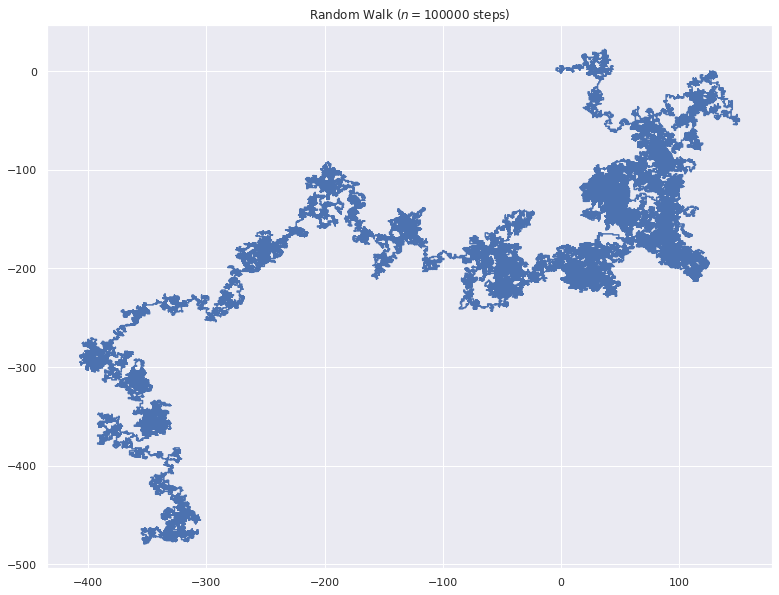

In [ ]:
# Simulating a 2D Random Walk

# In higher dimensions one gets a discrete fractal, that is, 
# a set which exhibits stochastic self-similarity on large scales.


# Python code for 2D random walk. 
import pylab 
import random 
  
# defining the number of steps 
n = 100000
  
#creating two array for containing x and y coordinate 
#of size equals to the number of size and filled up with 0's 
x = np.zeros(n) 
y = np.zeros(n) 
  
# filling the coordinates with random variables 
for i in range(1, n): 
    val = random.randint(1, 4) 
    if val == 1: 
        x[i] = x[i - 1] + 1
        y[i] = y[i - 1] 
    elif val == 2: 
        x[i] = x[i - 1] - 1
        y[i] = y[i - 1] 
    elif val == 3: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] + 1
    else: 
        x[i] = x[i - 1] 
        y[i] = y[i - 1] - 1

sns.set(rc={'figure.figsize':(13, 10)})
pylab.title("Random Walk ($n = " + str(n) + "$ steps)") 
pylab.plot(x, y) 

##### <font color="blue">*Wiener Process (Brownian Motion)*

**Wiener Process (Brownian Motion)**

* Video: Physics of Randomness: https://youtu.be/5jBVYvHeG2c

* Brownian Motion: Flower particles move randomly because they are hit by particles that move. And particles move faster with more heat. 

* Same in astrophysics with stars under the gravitational influence of smaller stars, big stars move a bit randomly

* Same with stock market where the price is influenced by many factors all the time (and hence the price moves randomly up and down)

**The Wiener process is a real valued continuous-time (continuous state-space) stochastic process**

* W<sub>0</sub> = 0 (P-almost certain)
* The Wiener process has (stochastically) independent increments.
* The increases are therefore stationary and normally distributed with the expected value zero and the variance t - s.
* The individual paths are (P-) almost certainly continuous.

**Applications**

* In physics it is used to study Brownian motion, the diffusion of minute particles suspended in fluid, and other types of diffusion via the Fokker–Planck and Langevin equations. 
* It also forms the basis for the rigorous path integral formulation of quantum mechanics (by the Feynman–Kac formula, a solution to the Schrödinger equation can be represented in terms of the Wiener process) and the study of eternal inflation in physical cosmology. 
* It is also prominent in the mathematical theory of finance, in particular the Black–Scholes option pricing model.

**Properties of a Wiener Process**

1. The Wiener process belongs to the family of **Markov processes** and there specifically to the class of **Levy processes**. It also fulfills the strong markov property. It is one of the best known Lévy processes (**càdlàg** stochastic processes with stationary independent increments).
2. The Wiener Process is a **special Gaussian process** with an expected value function E(W<sub>t</sub>)  = 0 and and the covariance function Cov (W<sub>s</sub>, W<sub>t</sub>) = min (s,t)
3. The Wiener process is a (continuous time) **martingale** (Lévy characterisation: the Wiener process is an almost surely continuous martingale with W0 = 0 and quadratic variation [Wt, Wt] = t, which means that Wt2 − t is also a martingale).
4. The Wiener process is a **Levy process** with steady paths and constant expectation 0.

*Another characterisation is that the Wiener process has a spectral representation as a sine series whose coefficients are independent N(0, 1) random variables. This representation can be obtained using the Karhunen–Loève theorem.*

**Wiener process as a limit of random walk (& Differences between Wiener Process & Random Walk)**

* https://www.quora.com/What-is-an-intuitive-explanation-of-a-Wiener-process?top_ans=3955819

* A Wiener process (~ Brownian motion) is the **integral of a white noise generalized Gaussian process**. It is not stationary, but it has stationary increments.

* Let X<sub>1</sub>, X<sub>2</sub>, X<sub>n</sub> be a sequence of independent and identically distributed (i.i.d.) random variables with mean 0 and variance 1.  The central limit theorem asserts that W<sup>(n)</sup> (1) converges in distribution to a standard Gaussian random variable W(1) as n → ∞. 

* [Donsker's theorem](https://en.m.wikipedia.org/wiki/Donsker%27s_theorem) asserts that as n → ∞ , W<sub>n</sub> approaches a Wiener process, which explains the ubiquity of Brownian motion. **Donsker's invariance principle** states that: As random variables taking values in the Skorokhod space D [0,1], the random function W<sup>(n)</sup> converges in distribution to a standard Brownian motion W := (W(t))<sub>t ∈ [0,1]</sub> as n → ∞.

![Donsker's Invariance Principle](https://upload.wikimedia.org/wikipedia/commons/8/8c/Donskers_invariance_principle.gif)

*Donsker's invariance principle for simple random walk on Z*

<img src="https://raw.githubusercontent.com/deltorobarba/repo/master/wiener.jpg" alt="wiener">

**Differences to other stochastic processes**

**Random Walk**


* **A Wiener process is the [scaling limit](https://en.m.wikipedia.org/wiki/Scaling_limit) of random walk in dimension 1**. The **convergence of a random walk toward the Wiener process is controlled by the central limit theorem**, and by **Donsker's theorem**. The **Green's function** of the diffusion equation that controls the Wiener process, suggests that, **after a large number of steps, the random walk converges toward a Wiener process**.

* A random walk is a discrete fractal (a function with integer dimensions; 1, 2, ...), but a **Wiener process trajectory is a true fractal**, and there is a connection between the two (a Wiener process walk is a fractal of **Hausdorff dimension** 2). 

* Unlike the random walk, a **Wiener Process is scale invariant**. A Wiener process enjoys many symmetries random walk does not. For example, a **Wiener process walk is invariant to rotations, but the random walk is not**, since the underlying grid is not. This means that in many cases, problems on a random walk are easier to solve by translating them to a Wiener process, solving the problem there, and then translating back. 

**(Gaussian) White Noise**

* The Wiener process is used to represent the integral (from time zero to time t) of a zero mean, unit variance, delta correlated **<u>Gaussian</u> white noise process**

**Brownian Motion**

* **"Brownian motion" is a phenomenon that can be modeled with a Wiener Process**, because a Wiener process is a stochastic process with similar behavior to Brownian motion, the physical phenomenon of a minute particle diffusing in a fluid.

* The Brownian motion process (and the Poisson process in one dimension) are both examples of **Markov processes in continuous time**

* Itō also paved the way for the Wiener process from physics to other sciences: the **stochastic differential equations** he set up made it possible to adapt the Brownian motion to more statistical problems. 

* The **geometric Brownian motion** derived from a stochastic differential equation solves the problem that the **Wiener process, regardless of its starting value, almost certainly reaches negative values over time, which is impossible for stocks**. Since the development of the famous **Black-Scholes model**, the geometric Brownian movement has been the standard.

**Ornstein-Uhlenbeck-Process**

* The problem raised by the **[non-rectifiable paths](https://en.m.wikipedia.org/wiki/Arc_length)** of the Wiener process in the modeling of Brownian paths leads to the Ornstein-Uhlenbeck process and also makes the need for a theory of stochastic integration and differentiation clear
* here it is not the motion but the speed of the particle as one that is not rectifiable process derived from the Wiener process, from which one obtains rectifiable particle paths through integration.



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


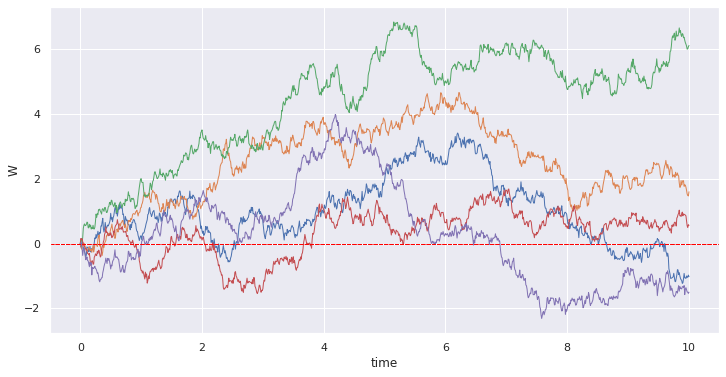

In [ ]:
# Simulating a Wiener Process - Each path is an independent Wiener process 

import numpy as np
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 10), "lines.linewidth": 1.0})
%pylab inline
def wiener_process(T, N):
    """
    T: total time
    N: The total number of steps
    """
    W0 = [0]
    dt = T/float(N)
    # simulate the increments by normal random variable generator
    increments = np.random.normal(0, 1*np.sqrt(dt), N)
    W = W0 + list(np.cumsum(increments))
    return W

N = 1000
T = 10
dt = T / float(N)
t = np.linspace(0.0, N*dt, N+1)
plt.figure(figsize=(12,6))
for i in range(5):
    W = wiener_process(T, N)
    plt.plot(t, W)
    plt.xlabel('time')
    plt.ylabel('W')
    plt.grid(True)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.0)

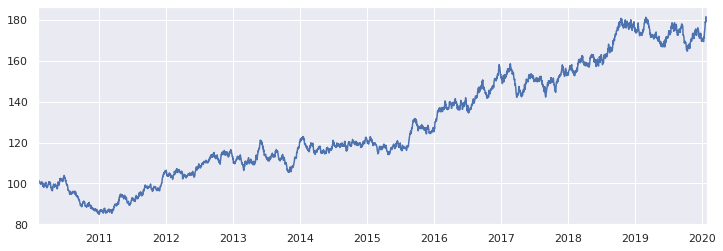

In [ ]:
# Simulating Random Walk (with Drift) based on Geometric Brownian Motion

sns.set(rc={'figure.figsize':(12, 4)})

def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20): 
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2010-02-01', '2020-01-29')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

randomwalk.plot()

##### <font color="blue">*Gaussian Process*

* A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. **every finite linear combination of them is normally distributed**. 

* The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

* Gaussian Processes are a class of stationary, zero-mean stochastic processes which are completely dependent on their autocovariance functions. This class of models can be used for both regression and classification tasks.

* Gaussian Processes provide estimates about uncertainty, for example giving an estimate of how sure an algorithm is that an item belongs to a class or not.

* In order to deal with situations which embed a certain degree of uncertainty is typically made use of probability distributions.

* Gaussian processes can allow us to describe probability distributions of which we can later update the distribution using Bayes Rule once we gather new training data.

* **Relation to other Stochastic Processes**

  * A **Wiener process (~ Brownian motion)** is the integral of a white noise generalized Gaussian process. It is not stationary, but it has stationary increments. 

  * The **fractional Brownian motion** is a Gaussian process whose covariance function is a generalisation of that of the Wiener process.

  * The **Ornstein–Uhlenbeck** process is a stationary Gaussian process.

  * The **Brownian bridge** is (like the Ornstein–Uhlenbeck process) an example of a Gaussian process whose increments are not independent.


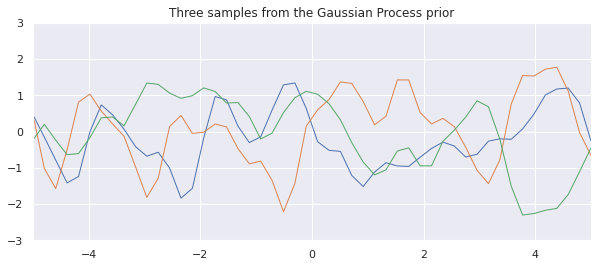

In [ ]:
# Gaussian Process

# Define points at which our functions will be evaluated, 50 evenly spaced points between -5 and 5.
# kernel function: uses the Squared Exponential, a.k.a Gaussian, a.k.a. Radial Basis Function kernel.
# calculates the squared distance between points and converts it into a measure of similarity, 
# controlled by a tuning parameter. Note that we are assuming a mean of 0 for our prior.

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the Gaussian Process prior')
plt.show()

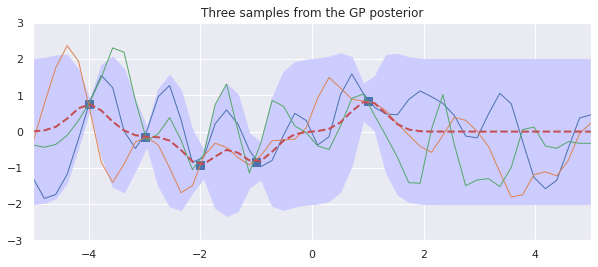

In [ ]:
# Gaussian Process

# Source: https://machinelearningmastery.com/what-is-bayesian-optimization/
# Now we’ll observe some data. The actual function generating the y values from our x values, 
# unbeknownst to our model, is the sin function.
# We generate the output at our 5 training points, sample from the posterior and plot it.
# The training points (the blue squares) have “reined in” the set of possible functions: 
# the ones we have sampled from the posterior all go through those points.
# The dotted red line shows the mean output and the grey area shows 2 standard deviations from the mean.

# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#CCCCFF")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

**Gaussian Processes for Machine Learning**

  * http://katbailey.github.io/post/gaussian-processes-for-dummies/

  * Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions f(x) that are consistent with the observed data.

  * As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

**In supervised learning, we often use parametric models** $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ to explain data and infer optimal values of parameter $\boldsymbol\theta$ via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) or [maximum a posteriori](https://de.wikipedia.org/wiki/Maximum_a_posteriori) estimation. If needed we can also infer a full [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) $p(\boldsymbol\theta \lvert \mathbf{X},\mathbf{y})$ instead of a point estimate $\boldsymbol{\hat\theta}$. With increasing data complexity, models with a higher number of parameters are usually needed to explain data reasonably well. Methods that use models with a fixed number of parameters are called parametric methods. 

In non-parametric methods, on the other hand, the number of parameters depend on the dataset size. For example, in [Nadaraya-Watson kernel regression](https://en.wikipedia.org/wiki/Kernel_regression), a weight $w_i$ is assigned to each observed target $y_i$ and for predicting the target value at a new point $\mathbf{x}$ a weighted average is computed: 

$$f(\mathbf{x}) = \sum_{i=1}^{N}w_i(\mathbf{x})y_i$$

$$w_i(\mathbf{x}) = \frac{\kappa(\mathbf{x}, \mathbf{x}_{i})}{\sum_{i'=1}^{N}\kappa(\mathbf{x}, \mathbf{x}_{i'})}$$

Observations that are closer to $\mathbf{x}$ have a higher weight than observations that are further away. Weights are computed from $\mathbf{x}$ and observed $\mathbf{x}_i$ with a kernel $\kappa$. A special case is k-nearest neighbors (KNN) where the $k$ closest observations have a weight $1/k$, and all others have weight $0$. Non-parametric methods often need to process all training data for prediction and are therefore slower at inference time than parametric methods. On the other hand, training is usually faster as non-parametric models only need to remember training data. 

Another example of non-parametric methods are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). Instead of inferring a distribution over the parameters of a parametric function Gaussian processes can be used to infer a distribution over functions directly. A Gaussian process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions. Inference of continuous function values in this context is known as GP regression but GPs can also be used for classification. 

A Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{1}$$

In Equation $(1)$, $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. $m$ is the mean function and it is common to use $m(\mathbf{x}) = 0$ as GPs are flexible enough to model the mean arbitrarily well. $\kappa$ is a positive definite *kernel function* or *covariance function*. 

**Thus, a Gaussian process is a distribution over functions whose shape (smoothness, ...) is defined by $\mathbf{K}$.**

 If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too. 

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}
\end{align*}
$$

Equation $(2)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}
$$

With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{5}
\end{align*}
$$


##### <font color="blue">*Further Stochastic Processes*

**Brownian Bridge**

* A Brownian bridge is a **continuous Gaussian process** with X<sub>0</sub> = X<sub>1</sub> = 0, and with mean and covariance functions given in (c) and (d), respectively.

* The **Brownian bridge is (like the Ornstein–Uhlenbeck process)** an example of a Gaussian process **whose increments are not independent**.

* There are several ways of constructing a Brownian bridge from a standard Brownian motion [Source](https://www.randomservices.org/random/brown/Bridge.html)

* **Applications: Path Simulation for Stock Shares**: The simple Monte Carlo method with Euler method supplemented by the Brownian bridge correction for the possibility of falling below or exceeding the barriers between discretization times. 

  * By merely discreetly viewing (simulating) the (log) share price, those paths can also lead to a positive final payment in which the share price between the selected times k delta t has exceeded the lower barrier or exceeded the upper barrier without this is noticed in the discretized model. 

  * To calculate the probability of such an unnoticed barrier violation, Brownian Bridge is used (with the help of the independence and stationarity of its growth).

  * With the help of the statements about the Brown Bridge, one can formally. Specify the Monte Carlo algorithm that can be used to evaluate double barrier options without having to discretize the price path.

* **Application: Bond Prices**

  * Computation of bond prices in a structural default model with jumps with an unbiased Monte-Carlo simulation. 

  * The algorithm requires the evaluation of integrals with the density of the first-passage time of a Brownian bridge as the integrand. (Metwally and Atiya (2002) suggest an approximation of these integrals.)

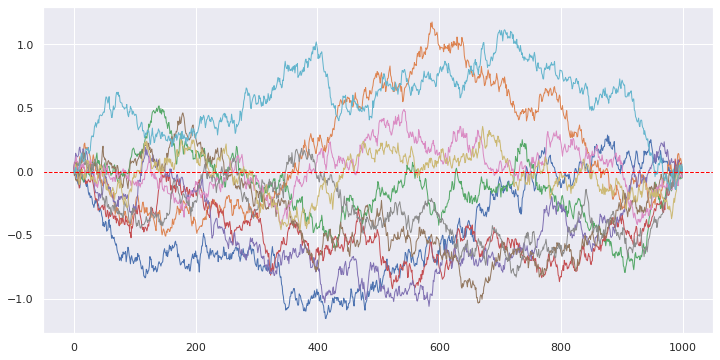

In [ ]:
import six

seed = 0
N = 1000
M = 10

np.random.seed(seed)

def sample_path_batch(M, N):
    dt = 1.0 / (N -1)
    dt_sqrt = np.sqrt(dt)
    B = np.empty((M, N), dtype=np.float32)
    B[:, 0] = 0
    for n in six.moves.range(N - 2):
         t = n * dt
         xi = np.random.randn(M) * dt_sqrt
         B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
    B[:, -1] = 0   # Set last B to zero
    return B

sns.set(rc={'figure.figsize':(12, 6), "lines.linewidth": 1.0})
B = sample_path_batch(M, N)
plt.plot(B.T)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.0)
plt.show()

**Ornstein-Uhlenbeck Process**

> Simulating a stochastic differential equation

* the Ornstein–Uhlenbeck process is a **stochastic process** with applications in financial mathematics and the physical sciences. 

* Its original application in physics was as a model for the **<u>velocity</u> of a massive Brownian particle under the influence of <u>friction</u>**. It is named after Leonard Ornstein and George Eugene Uhlenbeck.

* The Ornstein–Uhlenbeck process is a **stationary Gauss–Markov process**, which means that it is a **Gaussian process, a Markov process, and is temporally homogeneous**. In fact, it is the only nontrivial process that satisfies these three conditions, up to allowing linear transformations of the space and time variables.

* Over time, the process tends to **drift towards its mean function**: such a process is called **mean-reverting**.

* The process can be considered to be a **modification of the random walk in continuous time, or Wiener process**, in which the properties of the process have been changed so that there is a tendency of the walk to move back towards a central location, with a greater attraction when the process is further away from the center. 

* The Ornstein–Uhlenbeck process can also be considered as the **continuous-time analogue of the discrete-time AR(1) process**.

* The Ornstein–Uhlenbeck process can be interpreted as a **scaling limit of a discrete process**, in the same way that Brownian motion is a scaling limit of random walks.

* Generalization: It is possible to extend Ornstein–Uhlenbeck processes to processes where the background driving process is a Lévy process (instead of a simple Brownian motion).

* In addition, in finance, stochastic processes are used where the volatility increases for larger values of C.

* The Ornstein–Uhlenbeck process (just like the Brownian Bridge) a is an example of a **Gaussian process whose increments are not independent**. Look for stock returns devoid of explanatory factors, and analyze the corresponding residuals as stochastic processes. (e.g. mean reverting?). Can residuals be fitted to (increments of) OU processes or other MR processes? If so, what is the typical correlation time-scale? Mean reversion days: how long does it take to converge (e.g. model distribution of days).

**In Financial Mathematics**

* The Ornstein–Uhlenbeck process is one of several approaches used to model (with modifications) interest rates, currency exchange rates, and commodity prices stochastically. 

* The parameter μ (mu) represents the equilibrium or mean value supported by fundamentals; σ (signa) the degree of volatility around it caused by shocks, and θ (theta) the rate by which these shocks dissipate and the variable reverts towards the mean. 

* One application of the process is a trading strategy known as pairs trade.

* Stationary and mean-reverting around mean=10 (red dotted line)
* **In financial engineering: how long does it take in average to converge? mean-reversion is an investment opportunity!**
* Now, we are going to take a look at the time evolution of the distribution of the process. To do this, we will simulate many independent realizations of the same process in a vectorized way. We define a vector X that will contain all realizations of the process at a given time (that is, we do not keep all realizations at all times in memory). This vector will be overwritten at every time step. We will show the estimated distribution (histograms) at several points in time:

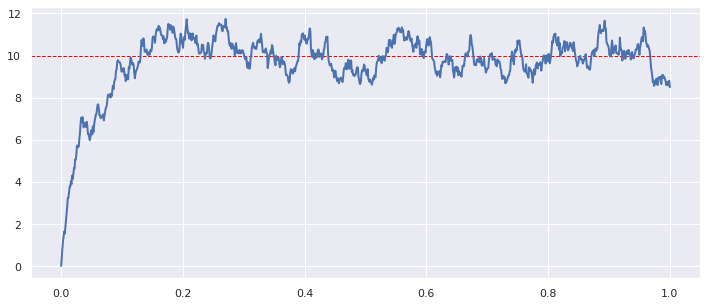

In [ ]:
# Ornstein-Uhlenbeck Process

# Function parameters

sigma = 1.  # Standard deviation.
mu = 10.  # Mean.
tau = .05  # Time constant

# Simulation parameters

dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times

# Define renormalized variables (to avoid recomputing these constants at every time step)

sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

# Create a vector that will contain all successive values of our process during the simulation:
x = np.zeros(n)

# simulate the process with the Euler-Maruyama method. 
# It is really like the standard Euler method for ODEs, but with an extra stochastic term 
# (which is just a scaled normal random variable).

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + \
        sigma_bis * sqrtdt * np.random.randn()

sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
fig, ax = plt.subplots(1, 1)
plt.axhline(y=10, color='red', linestyle='--', linewidth=1.0)
ax.plot(t, x, lw=2)

**Jump diffusion**

* [Jump diffusion](https://en.m.wikipedia.org/wiki/Jump_diffusion) is a stochastic process that involves jumps and diffusion. 

* It has important applications in magnetic reconnection, coronal mass ejections, condensed matter physics, option pricing, and pattern theory and computational vision.



**Lévy Process** 

* A Lévy process is a stochastic process with **[independent, stationary increments](https://de.m.wikipedia.org/wiki/Prozess_mit_unabhängigen_Zuwächsen)** (= the course of the future of the process is independent of the past): it represents the motion of a point whose successive displacements are random and independent, and statistically identical over different time intervals of the same length. 

* A Lévy process may thus be viewed as the **continuous-time analog of a random walk**.

* The most well known **examples of Lévy processes are Wiener process (~ Brownian motion), and Poisson process**. Aside from Brownian motion with drift, all other proper (that is, not deterministic) Lévy processes have discontinuous paths.

**Bernoulli Process**

* The outcomes of a Bernoulli process will follow a [Binomial distribution](https://en.m.wikipedia.org/wiki/Binomial_distribution).

* https://machinelearningmastery.com/discrete-probability-distributions-for-machine-learning/

* A Bernoulli process is a finite or infinite sequence of binary random variables, so it is a discrete-time stochastic process that takes only two values, canonically 0 and 1. 

* The component Bernoulli variables X<sub>i</sub> are [identically distributed and independent](https://en.m.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). Prosaically, a Bernoulli process is a repeated coin flipping, possibly with an unfair coin (but with consistent unfairness). 

* Every variable X<sub>i</sub> in the sequence is associated with a Bernoulli trial or experiment. They all have the same Bernoulli distribution. Much of what can be said about the Bernoulli process can also be generalized to more than two outcomes (such as the process for a six-sided dice); this generalization is known as the **Bernoulli scheme**.

* The problem of determining the process, given only a limited sample of Bernoulli trials, may be called the problem of checking whether a coin is fair.

**Poisson (Point) Process**

* Poisson point process is a type of random mathematical object that consists of points randomly located on a mathematical space

* Its name derives from the fact that if a collection of random points in some space forms a Poisson process, then the number of points in a region of finite size is a random variable with a Poisson distribution. 

* The process was discovered independently and repeatedly in several settings, including experiments on radioactive decay, telephone call arrivals and insurance mathematics. The Poisson point process is often defined on the real line, where it can be considered as a stochastic process. 

* On the real line, the Poisson process is a type of **continuous-time Markov process** known as a birth-death process (with just births and zero deaths) and is called a pure or simple birth process.

* In this setting, it is used, for example, in queueing theory to model random events, such as the arrival of customers at a store, phone calls at an exchange or occurrence of earthquakes, distributed in time. In the plane, the point process, also known as a spatial Poisson process, can represent the locations of scattered objects such as transmitters in a wireless network, particles colliding into a detector, or trees in a forest.

* In all settings, the Poisson point process has the property that each point is stochastically independent to all the other points in the process, which is why it is sometimes called a purely or completely random process.

* Despite its wide use as a stochastic model of phenomena representable as points, the inherent nature of the process implies that it does not adequately describe phenomena where there is sufficiently strong interaction between the points. This has inspired the proposal of other point processes, some of which are constructed with the Poisson point process, that seek to capture such interaction.

* https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a

##### <font color="blue">*Measure & Probability Theory*

###### *Measure (Maß)*

* Ein Maß ist in der Mathematik **eine Funktion**, die geeigneten Teilmengen einer Grundmenge Zahlen zuordnet, die als „Maß“ für die Größe dieser Mengen interpretiert werden können.

* Es sei $\mathcal{A}$ eine o-Algebra über einer nicht-leeren Grundmenge $\Omega .$ Eine Funktion $\mu: \mathcal{A} \rightarrow[0, \infty]$ heißt Maß auf $\mathcal{A}$, wenn die beiden folgenden Bedingungen erfüllt sind:

> $\mu(\emptyset)=0$

> Additivität: Für jede Folge $\left(A_{n}\right)_{n \in \mathbb{N}}$ paarweise disjunkter Mengen aus $\mathcal{A}$ gilt $\mu\left(\bigcup_{n=1}^{\infty} A_{n}\right)=\sum_{n=1}^{\infty} \mu\left(A_{n}\right)$

* Ist die o-Algebra aus dem Zusammenhang klar, so spricht man auch von einem Maß auf $\Omega$.

* Eine Teilmenge von $\Omega$, die in $\mathcal{A}$ liegt, wird messbar genannt. Für solch ein $A \in \mathcal{A}$ heißt $\mu(A)$ das Maß der Menge $A$. 

* Das **Tripel $(\Omega, \mathcal{A}, \mu)$ wird Maßraum** genannt.

* Das Paar $(\Omega, \mathcal{A})$ bestehend aus der Grundmenge und der darauf definierten $\sigma$-Algebra **heißt Messraum oder auch messbarer Raum**. 

* **Ein Maß $\mu$ ist also eine auf einem Messraum definierte nicht-negative [$\sigma$ -additive](https://de.m.wikipedia.org/wiki/Σ-Additivität) [Mengenfunktion](https://de.m.wikipedia.org/wiki/Mengenfunktion) mit $\mu(\emptyset)=0$.**

* Das Maß $\mu$ heißt Wahrscheinlichkeitsmaß (oder normiertes Maß), wenn zusätzlich $\mu(\Omega)=1$ gilt. Ein Maßraum $(\Omega, \mathcal{A}, \mu)$ mit einem Wahrscheinlichkeitsmaß $\mu$ ist ein Wahrscheinlichkeitsraum. 

* Ist allgemeiner $\mu(\Omega)<\infty,$ so nennt man $\mu$ ein [endliches Maß](https://de.m.wikipedia.org/wiki/Endliches_Maß). Existieren abzählbar viele Mengen, deren Maßendlich ist und deren Vereinigung ganz $\Omega$ ergibt, dann wird $\mu$ ein [$\sigma$ -endliches](https://de.m.wikipedia.org/wiki/Σ-Endlichkeit) (oder $\sigma$ -finites) Maß genannt. $^{[4]}$

https://de.m.wikipedia.org/wiki/Messbare_Funktion

https://de.m.wikipedia.org/wiki/Maß_(Mathematik)

https://de.m.wikipedia.org/wiki/Σ-Additivität

**Zählmaß**

$\mu$ (A) := 
* #A, wenn A endlich
* ∞, sonst

Rechenregeln in [0, ∞] : 
* x + ∞ := ∞ für alle x ∈ [0, ∞]
* x * ∞ := ∞ für alle x ∈ [0, ∞]
* 0 * ∞ := 0 (in der Maßtheorie sinnvoll)

**Dirac Maß**

p ∈ X (Punktmaß, weil es einem Punkt ein Maß zuordnet, und sonst Null).

Ist p innerhalb eine Menge A als Teilmenge von X, dann ist Diracmaß = 1, sonst 0.

δ<sub>p</sub> (A) :=
* 1, wenn p ∈ A
* 0, wenn sonst.

(δ = delta klein)

https://de.m.wikipedia.org/wiki/Diracmaß

**Lebesgue Maß**

* Das Lebesgue-Maß ist das **Maß im euklidischen Raum**, das geometrischen Objekten ihren Inhalt (Länge, Flächeninhalt, Volumen, …) zuordnet.

* Das Lebesgue-Borel-Maß auf der Borel-$\sigma$-Algebra $\mathcal{B}\left(\mathbb{R}^{n}\right)$ (auch als Borel-Lebesgue-Maß oder nur Bore/-Maß bezeichnet) ist das eindeutige Maß $\lambda$ mit der Eigenschaft, dass es $n$ -dimensionalen
Hyperrechtecken ihr $n$ -dimensionales Volumen zuordnet:

>$\lambda\left(\left[a_{1}, b_{1}\right] \times \cdots \times\left[a_{n}, b_{n}\right]\right)=\left(b_{1}-a_{1}\right) \cdots \cdots\left(b_{n}-a_{n}\right)$

* Das heißt, **es ist das Maß, das Intervallen inre Länge zuordnet (im Eindimensionalen), Rechtecken ihren Flächeninhalt zuordnet (im Zweidimensionalen), Quadern ihr Volumen zuordnet (im Dreidimensionalen) usw.** 

* Durch diese Bedingung wird der Inhalt $\lambda(B)$ beliebiger Borel-Mengen eindeutig festgelegt. Die BorelMengen werden auch Borel-messbar oder $B$ -messbar genannt. **Das Borel-Maß ist bewegungsinvariant und normiert, aber nicht vollständig.**

* Das Lebesgue-Maß ist das Haar-Maß **auf der lokalkompakten topologischen Gruppe** $\mathbb {R} ^{n}$ mit der Addition, die Existenz folgt daher bereits aus der Existenz des Haarmaßes. 

* Insbesondere ist es translationsinvariant, das bedeutet, dass sich das Maß einer Menge unter Translation nicht ändert. Zudem ist es invariant unter Spiegelungen und Drehungen, also sogar bewegungsinvariant. Das Lebesgue-Maß ist σ-endlich und regulär.

https://de.m.wikipedia.org/wiki/Lebesgue-Maß

**Haarsches Maß**

* Das Haarsche Maß wurde eingeführt, um Ergebnisse der **Maßtheorie in der Gruppentheorie anwendbar zu machen**.

* Beispiel: Das Lebesgue-Maß $B$ auf $\mathbb{R}^{n}$ und $\mathbb{C}^{n}$ ist das Haarsche Maß auf den additiven Gruppen $\left(\mathbb{R}^{n},+\right)$ bzw. $\left(\mathbb{C}^{n},+\right)$.

* Es ist eine Verallgemeinerung des Lebesgue-Maßes. Das Lebesgue-Maß ist ein Maß auf dem euklidischen Raum, das unter Translationen invariant ist. 

* Der euklidische Raum ist eine lokalkompakte topologische Gruppe bezüglich der Addition. Das Haarsche Maß ist für jede lokalkompakte (im Folgenden immer als hausdorffsch vorauszusetzende) topologische Gruppe definierbar, insbesondere also für jede Lie-Gruppe. 

* Lokalkompakte Gruppen mit ihren Haarschen Maßen werden in der [harmonischen Analyse](https://de.m.wikipedia.org/wiki/Harmonische_Analyse) untersucht.

https://de.m.wikipedia.org/wiki/Haarsches_Maß

**Haussdorf Maß**

* Das Hausdorff-Maß ist eine Verallgemeinerung des Lebesgue-Maßes auf nicht notwendig ganzzahlige Dimensionen. Mit seiner Hilfe lässt sich die Hausdorff-Dimension definieren, ein Dimensionsbegriff, mit dem beispielsweise fraktale Mengen untersucht werden können.

https://de.m.wikipedia.org/wiki/Hausdorff-Maß

**Jordan Maß**

* Mit dem Jordan-Maß kann man beschränkten Teilmengen des $\mathbb {R} ^{n}$ einen Inhalt zuordnen und erhält einen Integralbegriff, der dem [riemannschen Integralbegriff](https://de.m.wikipedia.org/wiki/Riemannsches_Integral) analog ist.

* Das Jordan-Maß ist kein Maß im Sinne der Maßtheorie.

https://de.m.wikipedia.org/wiki/Jordan-Maß

Siehe auch: https://de.m.wikipedia.org/wiki/Inhalt_(Maßtheorie)

**Radon Maß**

Es handelt sich um ein spezielles Maß auf der Borelschen σ-Algebra eines Hausdorff-Raums mit bestimmten Regularitätseigenschaften. Der Begriff wird in der Fachliteratur jedoch nicht einheitlich verwendet. 

https://de.m.wikipedia.org/wiki/Radonmaß

**Measurable Space (Messbarer Raum)**

Das Tupel $(\Omega, \mathcal{A}, \mu)$ heißt Maßraum, wenn

* $\Omega$ eine beliebige, nichtleere Menge ist. $\Omega$ wird dann auch Grundmenge (universe / Set) genannt.

* $\mathcal{A}$ eine $\sigma$ -Algebra über der Grundmenge $\Omega$ ist.

Zusammen mit einem Maß $\mu$ wird aus einem messbaren Raum ein Maßraum.

* **A measurable space or Borel space is a basic object in measure theory**. It consists of a set and a σ-algebra, which defines the subsets that will be measured.

* Note that in contrast to a measure space, **no measure is needed for a measurable space**.

**Messraum und Maßraum sind spezielle σ-Algebren.**

**Example**

Look at the set

X=\{1,2,3\}

One possible $\sigma$ -algebra would be

$\mathcal{A}_{1}=\{X, \emptyset\}$

Then $\left(X, \mathcal{A}_{1}\right)$ is a measurable space. 

Another possible $\sigma$ -algebra would be the power set on $X$ :

$\mathcal{A}_{2}=\mathcal{P}(X)$

With this, a second measurable space on the set $X$ is given by $\left(X, \mathcal{A}_{2}\right)$.

**Types**

* If $X$ is finite or countable infinite, **the $\sigma$ -algebra is most of the times the power set on $X$**, so $\mathcal{A}=\mathcal{P}(X) .$ This leads to the measurable space $(X, \mathcal{P}(X))$

* **If $X$ is a topological space, the $\sigma$ -algebra is most commonly the Borel $\sigma$ -algebra $\mathcal{B}$**, so $\mathcal{A}=\mathcal{B}(X)$. This leads to the measurable space $(X, \mathcal{B}(X))$ that is common for all topological spaces such as
the real numbers $\mathbb{R}$.


https://en.m.wikipedia.org/wiki/Measurable_space

**Riemann vs Lebesgue Integral**

https://de.m.wikipedia.org/wiki/Integralrechnung

https://de.m.wikipedia.org/wiki/Maßtheorie

https://de.wikipedia.org/wiki/Satz_von_Fubini

###### *Measure Space (Maßraum)*

> One important example of a measure space is a probability space.

Ein Maßraum ist eine spezielle mathematische Struktur, die eine essentielle Rolle in der Maßtheorie und dem axiomatischen Aufbau der Stochastik spielt.

Das Tripel $(\Omega, \mathcal{A}, \mu)$ heißt Maßraum, wenn

* $\Omega$ eine beliebige, nichtleere Menge ist. $\Omega$ wird dann auch Grundmenge genannt.

* $\mathcal{A}$ eine [$\sigma$ -Algebra](https://de.m.wikipedia.org/wiki/Σ-Algebra) über der Grundmenge $\Omega$ ist.

* $\mu$ ein [Maß](https://de.m.wikipedia.org/wiki/Maß_(Mathematik)) ist, das auf $\mathcal{A}$ definiert ist.

Alternativ kann man einen Maßraum auch als einen [Messraum](https://de.m.wikipedia.org/wiki/Messraum_(Mathematik)) $(\Omega, \mathcal{A})$ versehen mit einem Maß $\mu$ definieren.

A measure space is a triple $(X, \mathcal{A}, \mu),$ where

* $X$ is a set

* $\mathcal{A}$ is a $\sigma$ -algebra on the set $X$

* $\boldsymbol{\mu}$ is a measure on $(X, \mathcal{A})$

**Messraum und Maßraum sind spezielle σ-Algebren.**

https://en.m.wikipedia.org/wiki/Measure_space

**Beispiele**

* Ein einfaches Beispiel für einen Maßraum sind die natürlichen Zahlen als Grundmenge $\Omega=\mathbb{N}$, als $\sigma$ Algebra wählt man die Potenzmenge $\mathcal{A}=\mathcal{P}(\mathbb{N})$ und als Maß das Diracmaß auf der $1: \mu=\delta_{1}$

* Ein bekannter Maßraum ist die Grundmenge $\mathbb{R}$, versehen mit der borelschen $\sigma$ -Algebra $\mathcal{B}(\mathbb{R})$ und dem Lebesgue-Maß. **Dies ist der kanonische Maßraum in der Integrationstheorie.**

* Die in der Wahrscheinlichkeitstheorie verwendeten **[Wahrscheinlichkeitsräume](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsraum)** $(\Omega, \mathcal{A}, P)$ sind allesamt Maßräume. Sie bestehen aus der Ergebnismenge $\Omega$, der Ereignisalgebra $\mathcal{A}$ und dem Wahrscheinlichkeitsmaß $P$ (= synonym 'Wahrscheinlichkeitsverteilung' oder einfach 'Verteilung'). Mit den Eigenschaften: Die drei Forderungen Normiertheit, σ-Additivität und Werte im Intervall zwischen 0 und 1 werden auch die Kolmogorow-Axiome genannt. ([Source](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsma%C3%9F))

**Klassen von Maßräumen**

https://de.m.wikipedia.org/wiki/Σ-Endlichkeit

https://de.m.wikipedia.org/wiki/Vollständiges_Maß

und mehr..

* Verzichtet man auf Abstände und Winkel, behält jedoch das Volumen geometrischer Körper bei, gelangt man in das Gebiet der Maßtheorie. (für ein wahrscheinlichkeitsmaß volumen = 1)

* Der Maßtheorie gelang es, den Begriff des Volumens (oder eines anderen Maßes) auf eine enorm große Klasse von Mengen auszudehnen, die sogenannten messbaren Mengen. In vielen Fällen ist es jedoch unmöglich, allen Mengen ein Maß zuzuordnen (siehe Maßproblem).
Die messbaren Mengen bilden dabei eine σ-Algebra. Mit Hilfen von messbaren Mengen lassen sich messbare Funktionen zwischen Messräumen definieren.

* Um einen topologischen Raum zu einem Messraum zu machen, muss man ihn mit einer σ-Algebra ausstatten. Die σ-Algebra der Borel-Mengen ist die verbreitetste, aber nicht die einzige Wahl.

* Ein Maßraum ist ein Messraum, der mit einem Maß versehen ist. Ein euklidischer Raum mit dem [Lebesgue-Maß](https://de.m.wikipedia.org/wiki/Lebesgue-Maß) ist beispielsweise ein Maßraum. In der Integrationstheorie werden Integrierbarkeit und Integrale messbarer Funktionen auf Maßräumen definiert. Mengen vom Maß null werden Nullmengen genannt.

* A measure space is a basic object of measure theory, a branch of mathematics that studies generalized notions of volumes. 

* It contains an underlying set, the subsets of this set that are feasible for measuring (the σ-algebra) and the method that is used for measuring (the measure). 

* **One important example of a measure space is a probability space**.

* A measurable space consists of the first two components without a specific measure.

A **complete measure** (or, more precisely, a complete measure space) is a measure space in which every subset of every null set is measurable (having measure zero). 

https://en.m.wikipedia.org/wiki/Complete_measure

**Probability Space (Wahrscheinlichkeitsraum)**

Gegeben sei

* eine Menge $\Omega$, der sogenannte **Ergebnisraum**,

* eine o-Algebra $\Sigma$ auf dieser Menge, das **Ereignissystem**.

Dann heißt eine Abbildung (=Funktion)

>$P: \Sigma \rightarrow[0,1]$

mit den Eigenschaften

*  Normiertheit: Es ist $P(\Omega)=1$

* $\sigma$-Additivität: Für jede abzählbare Folge von paarweise disjunkten Mengen $A_{1}, A_{2}, A_{3}, \ldots$ aus $\Sigma$ gilt $P\left(\bigcup_{i=1}^{\infty} A_{i}\right)=\sum_{i=1}^{\infty} P\left(A_{i}\right)$

ein Wahrscheinlichkeitsmaß oder eine Wahrscheinlichkeitsverteilung.

Die drei Forderungen Normiertheit, $\sigma$-Additivität und Werte im Intervall zwischen O und 1 werden auch die [Kolmogorow-Axiome](https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitstheorie#Axiome_von_Kolmogorow) genannt.

https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsmaß

* **One important example of a measure space is a probability space.**

* Ein Wahrscheinlichkeitsraum ist ein Maßraum, bei dem das Maß des ganzen Raums gleich 1 ist.

* In der Wahrscheinlichkeitstheorie werden für die verwendeten maßtheoretischen Begriffe meist eigene Bezeichnungen verwendet, die der Beschreibung von Zufallsexperimenten angepasst sind: Messbare Mengen werden Ereignisse und messbare Funktionen zwischen Wahrscheinlichkeitsräumen werden Zufallsvariable genannt; ihre Integrale sind Erwartungswerte.

* Das Produkt einer endlichen oder unendlichen Familie von Wahrscheinlichkeitsräumen ist wieder ein Wahrscheinlichkeitsraum. Im Gegensatz dazu ist für allgemeine Maßräume nur das Produkt endlich vieler Räume definiert. Dementsprechend gibt es zahlreiche unendlichdimensionale Wahrscheinlichkeitsmaße, beispielsweise die Normalverteilung, aber kein unendlichdimensionales Lebesgue-Maß.
Diese Räume sind weniger geometrisch. Insbesondere lässt sich die Idee der Dimension, wie sie in der einen oder anderen Form auf alle anderen Räume anwendbar ist, nicht auf Messräume, Maßräume und Wahrscheinlichkeitsräume anwenden.

* Es handelt sich um ein mathematisches Modell zur Beschreibung von Zufallsexperimenten. Hierbei werden die verschiedenen möglichen Ausgänge des Experiments zu einer Menge zusammengefasst. Teilmengen dieser Ergebnismenge können dann unter bestimmten Voraussetzungen Zahlen zwischen 0 und 1 zugeordnet werden, die als Wahrscheinlichkeiten interpretiert werden.

* Ein Wahrscheinlichkeitsraum ist ein Maßraum (Ω, Σ, P) dessen Maß P ein Wahrscheinlichkeitsmaß ist. Im Einzelnen bedeutet das: 

* Ω ist eine beliebige nichtleere Menge, genannt die Ergebnismenge. Ihre Elemente heißen Ergebnisse.

* Σ (Sigma) ist eine σ-Algebra über der Grundmenge Ω (Omega), also eine Menge bestehend aus Teilmengen von Ω, die Ω enthält und abgeschlossen gegenüber der Bildung von Komplementen und abzählbaren Vereinigungen ist. Die Elemente von Σ heißen Ereignisse. Die σ-Algebra Σ selbst wird auch Ereignissystem oder Ereignisalgebra genannt.

* P : Σ –> [0,1] ist ein Wahrscheinlichkeitsmaß, das heißt eine Mengenfunktion, die den Ereignissen Zahlen zuordnet, derart dass P(∅) = 0 ist, P (A1 ∪ A2 ∪ … ) = P(A1) + P(A2) + … für paarweise disjunkte (d. h. sich gegenseitig ausschließende) Ereignisse A1, A2, … gilt (3. Kolmogorow-Axiom) und P(Ω) = 1 ist (2. Kolmogorow-Axiom).

* Der Messraum (Ω, Σ) wird auch Ereignisraum genannt. Ein Wahrscheinlichkeitsraum ist also ein Ereignisraum, auf dem zusätzlich ein Wahrscheinlichkeitsmaß gegeben ist.

https://de.m.wikipedia.org/wiki/Wahrscheinlichkeitsraum

###### *Measurable Space (Messraum)*

* [Messraum](https://en.wikipedia.org/wiki/Measurable_space) und Maßraum sind spezielle σ-Algebren.

###### *Field of Sets (Algebra oder Mengensystem)*

**Mengensystem** oder **Mengenalgebra** oder **Fields of Sets**

* **A field of sets is a pair $\langle X, \mathcal{F}\rangle$ where $X$ is a set and $\mathcal{F}$ is an algebra over $X$** 

* i.e., a subset of the power set of $X$, closed under complements of individual sets and under the union (hence also under the intersection) of pairs of sets, and satisfying $X \in \mathcal{F}$. 

* In other words, $\mathcal{F}$ forms
a subalgebra of the power set Boolean algebra of $X$ (with the same identity element $X \in \mathcal{F}$ ).
(Many authors refer to $\mathcal{F}$ itself as a field of sets.) Elements of $X$ are called points and those of $\mathcal{F}$
are called complexes and are said to be the admissible sets of $X$.

Ω (Omega) sei eine beliebige (Grund-)Menge. Ein System $\mathcal{A}$ (oder $\mathcal{F}$) von Teilmengen von Ω heißt eine Mengenalgebra oder Algebra über Ω, wenn folgende Eigenschaften erfüllt sind:

1. $\mathcal{A} \neq \emptyset$ ( $\mathcal{A}$ ist nicht leer)

2. $A, B \in \mathcal{A} \Rightarrow A \cup B \in \mathcal{A}$ (Stabilität/Abgeschlossenheit bezüglich Vereinigung)

3. $A \in \mathcal{A} \Rightarrow A^{\mathrm{c}} \in \mathcal{A}$ (Stabilität/Abgeschlossenheit bezüglich Komplementbildung $\left.A^{c}=\Omega \backslash A\right)$

* In der Mathematik ist (Mengen-)Algebra ein Grundbegriff der Maßtheorie. Er beschreibt ein nicht-leeres Mengensystem, das vereinigungs- und komplementstabil ist.

* A field of sets is a **pair ⟨X,F⟩** where X is a set and F is an algebra over X i.e., a subset of the power set of X, closed under complements of individual sets and under the union (hence also under the intersection) of pairs of sets, and satisfying X ∈ F. 

* In other words, F forms a subalgebra of the power set Boolean algebra of X (with the same identity element X ∈ F). (Many authors refer to F itself as a field of sets.) 

* **Elements of X are called points and those of F are called complexes and are said to be the admissible sets of X.**

* For arbitrary set $Y$, its power set (Potenzmenge) $2^{Y}$ (or, somewhat pedantically, the pair $\left\langle Y, 2^{Y}\right\rangle$ of this set and its power set) is a field of sets. 

* If $Y$ is finite (namely, $n$ -element), then $2^{Y}$ is finite (namely, $2^{n}$ element). 

* It appears that every finite field of sets (it means, $\langle X, \mathcal{F}\rangle$ with $\mathcal{F}$ finite, while $X$ may be infinite) admits a representation of the form $\left\langle Y, 2^{Y}\right\rangle$ with finite $Y ;$ it means a function $f: X \rightarrow Y$ that establishes a one-to-one correspondence between $\mathcal{F}$ and $2^{Y}$ via inverse image:
$S=f^{-1}[B]=\{x \in X \mid f(x) \in B\}$ where $S \in \mathcal{F}$ and $B \in 2^{Y}$ (that is, $B \subset Y$ ). 

* One notable consequence: the number of complexes, if finite, is always of the form $2^{n}$.

**Beispiele für Algebra**

* Für jede beliebige Menge $\Omega$ ist $\{\emptyset, \Omega\}$ die kleinste und die Potenzmenge $\mathcal{P}(\Omega)$ die größtmögliche Mengenalgebra.
* Jede $\sigma$ -Algebra ist eine Mengenalgebra.
* Für jede Menge $\Omega$ ist das Mengensystem $\mathcal{A}=\left\{A \subseteq \Omega \mid A \text { endlich oder } A^{c} \text { endlich }\right\}$ eine Mengenalgebra. Wenn $\Omega$ unendich ist, dann ist $\mathcal{A}$ keine $\sigma$ -Algebra.

**Separative and compact fields of sets: towards Stone duality**

* A field of sets is called **separative (or differentiated)** if and only if for every pair of distinct points there is a complex containing one and not the other.

* A field of sets is called **compact** if and only if for every proper filter over X the intersection of all the complexes contained in the filter is non-empty.

Given a field of sets $\mathbf{X}=\langle X, \mathcal{F}\rangle$ the complexes form a base for a topology. We denote by $T(\mathbf{X})$ the corresponding topological space, $\langle X, \mathcal{T}\rangle$ where $\mathcal{T}$ is the topology formed by taking arbitrary unions of complexes. Then

1. $T(\mathbf{X})$ is always a [zero-dimensional space](https://en.m.wikipedia.org/wiki/Zero-dimensional_space)

2. $T(\mathbf{X})$ is a [Hausdorff space](https://en.m.wikipedia.org/wiki/Hausdorff_space) if and only if $\mathbf{X}$ is separative.

3. $T(\mathbf{X})$ is a compact space with compact open sets $\mathcal{F}$ if and only if $\mathbf{X}$ is compact.

4. $T(\mathbf{X})$ is a Boolean space with clopen sets $\mathcal{F}$ if and only if $\mathbf{X}$ is both separative and compact (in which case it is described as being descriptive)

https://en.m.wikipedia.org/wiki/Field_of_sets

###### *σ-algebra (Sigma Algebra)*

**σ-algebra (Sigma Algebra)**

* https://mathepedia.de/Sigma-Algebren.html

* Sei $\Omega \neq \emptyset$ eine Menge, $\mathfrak{P}(\Omega)$ die Potenzmenge und $\mathcal{F} \subseteq \mathfrak{P}(\Omega)$ ein Mengensystem (=field of sets).

Definition

$\mathcal{F}$ heißt Algebra, wenn folgende Eigenschaften gelten:

(1) $\quad \emptyset \in \mathcal{F}$

(2) $\quad A \in \mathcal{F} \Rightarrow A^{c} \in \mathcal{F}$

(3) $\quad A, B \in \mathcal{F} \Rightarrow A \cup B \in \mathcal{F}$

$\mathcal{F}$ heißt $\sigma$ -Algebra, wenn die Punkte (1) und (2) gelten
und zusätzlich

(4) $\quad A_{1}, A_{2}, \ldots \in \mathcal{F} \Rightarrow \bigcup A_{k} \in \mathcal{F}$

gilt.

Algebren sind bezüglich der endlichen Vereinigung abgeschlossene Mengensysteme und $\sigma$ -Algebren sind bezüglich der abzählbaren Vereinigung abgeschlossene
Mengensysteme. Wegen (1) und (2) gilt stets $\Omega \in \mathcal{F}$.

* If an algebra over a **set is closed under countable unions** (hence also under countable intersections), it is called a **sigma algebra** and **the corresponding field of sets (Mengensystem) is called a measurable space**. The complexes of a measurable space are called measurable sets.

* * **A measure space is a triple $\langle X, \mathcal{F}, \mu\rangle$ where $\langle X, \mathcal{F}\rangle$ is a measurable space and $\mu$ is a measure defined on it.** (Alternative: $\langle$ Ω , $\mathcal{F}$, $\mu$ $\rangle$)

* If $\mu$ is in fact a probability measure we speak of a probability space and call its underlying measurable space a sample space. 

* The points of a sample space are called samples and represent potential outcomes while the measurable sets (complexes) are called events and represent properties of outcomes for which we wish to assign probabilities. (Many use the term sample space simply for the underlying set of a probability space, particularly in the case where every subset is an event.) 

* Measure spaces and probability spaces play a foundational role in measure theory and probability theory respectively.

* https://de.m.wikipedia.org/wiki/Algebra_(Mengensystem)

**Pain Point**

* How to define a messbare Menge?

* Wenn wir eine Menge aus den reellen Zahlen haben und mochten eine Teilbereich [a bis b] messen, dann brauchen wir einen allgemeinen Massbegriff unabhangig von der konkreten Menge. Hier kommt Masstheorie und Sigma-Algebra.

**Definition**

* A σ-algebra defines the **set of events that can be measured**, which in a probability context is equivalent to events that can be discriminated, or "questions that can be answered at time t".

* Exkurs: Ergebnis vs Ereignis. Die möglichen Ausgänge eines Zufallsexperimentes nennt man **Ergebnisse** (zB auf einem Wüfel die Zahlen 1,2,3..). Wenn man alle möglichen Ergebnisse eines Zufallsexperimentes in einer Menge zusammenfasst, erhält man die **Ergebnismenge**. Sie wird üblicherweise mit dem Symbol Ω (sprich Omega) bezeichnet. Beim Würfeln ist Ω= {1; 2; 3; 4; 5; 6} die Ergebnismenge. Jede Zusammenfassung von einem oder mehreren Ergebnissen eines Zufallsexperimentes in einer Menge nennt man **Ereignis** (zB auf einem Würfel die Menge an geraden Zahlen {2,4,6} und ungeraden Zahlen {1,3,5}.

* Eine Sigma-Algebra F ist ein System, um alle möglichen **Ereignisse** (nicht Ergebnisse!) eines Zufallsexperiment zu beschreiben. Ereignisse sind an sich selbst Mengen, die man wie jede Menge vereinigen oder schneiden bzw. auch das Komplement bilden kann um so das Gegenereignis zu erhalten. Fasst man hier alle möglichen Kombinationen an Ereignissen in einer Menge zusammen, bekommt man eine Menge, die wiederum Mengen als Elemente enthält - eine Menge von Mengen sozusagen. Oft sagt man dazu auch einfach Mengensystem. Welche Eigenschaften ein Mengensystem genau haben muss, damit es eine Sigma-Algebra ist steht weiter unten.

* Beispiel: Glücksrad mit blau, rot und grün. Dann haben wir folglich drei Ergebnisse, die wir auch abkürzen können: Ω={B,R,G}. Generell kann man sich schon merken: Ω und ∅ sind immer Elemente einer Sigma-Algebra. Daher haben wir hier 8 mögliche Teilmengen von Ω, die wir als Ereignis betrachten können und demnach als Menge in der Sigma-Algebra zusammenfassen (Potenzmenge von Omega): F ={∅, {B}, {R}, {G}, {B,R}, {B,G}, {R,G}, {B,R,G}} ([Source](https://www.massmatics.de/merkzettel/#!876:Ereignisraum_&_Sigma-Algebra)).

* Bei diskreten Ergebnismengen kann man für die Sigma-Algebra immer die Potenzmenge P(Ω)nehmen und hat demnach dann stets diesen **Ereignisraum: (Ω,P(Ω))**

* Und für die reellen Zahlen gibt es die sogenannte **Borelsche Sigma-Algebra B**, die man dann auch in der Regel benutzt. Ist die Ergebnismenge Ω eine Teilmenge der reellen Zahlen (oder ℝ selbst), so nehmen wir die Borelsche-Sigma B und der Ereignisraum lautet (Ω,B).

* Wenn wir eine Sigma Algebra A gegeben haben, dann heisst jede Teilmenge in diesem Mengensystem (jedes Element aus dieser Sigma Algebra A) eine messbare Teilmenge (=die Mengen die wir messen wollen).

* **<u>Die Elemente der Sigma Algebra sind die messbaren Teilmengen von unserer Grundmenge X</u>** (Und messbar ist der wesentliche Begriff). Das ist zB die Menge an vergangenen Trading-Events am Finanzmarkt bis zum Zeitpunkt t.

* Sigma Algebra ist ein **Mengensystem von einer Teilmenge einer gegebenen Grundmenge** = der Raum, **den wir beschreiben wollen** (mit drei Eigenschaften). Die Menge einer Sigma-Algebra nennt man „**messbare Teilmengen**“.

**Eigenschaften**

* **A $\subseteq$ P(X) (=Potenzmenge) heisst Sigma Algebra, wenn gilt** (Die Mengen, die in dieser Sigma Algebra liegen, das sind jene, die folgende drei Eigenschaften erfüllen, und sind die, die wir messen wollen (=diesen Mengen wollen wir ein Mass zuordnen). Potenzmenge selbst soll eine Sigma Algebra sein. Sollten gewissen Eigenschaften der Potenzmenge fordern). **<u>A collection of subsets</u> A is called a σ-algebra on a set X if the following properties are met:**

1. **A contains X (the set itself)**: $\quad \phi, X \in A$ (Leere Menge (sollte Länge oder Volumen Null haben) und ganze Grundmenge selbst haben wir im Mengensystem / sollen messbar sein. Das ist was Sigma Algebra sagt). **Ω ∈ F (Ergebnismenge muss enthalten sein)**

2. **If A contains a subset S, then A also contains the complement of S**: $A \in A \Rightarrow A^{c}:=X \backslash A \in A$ (Irgendein Element in der Algebra: dann sollte auch dessen Komplement im Mengensystem enthalten sein.) Hiermit ist auch Regel 1 eingeschlossen! Deswegen liegt auch die leere Menge (Gegenereignis von Ω) in F.

3. **Consider a countable collection of subsets. If each subset is included in A, then A must also contain their reunion.**: $A_{i} \in A$ fur i $\in N \Rightarrow \bigcup_{i=1}^{\infty} A_{i} \in A$ ((Letzter Punkt macht das Sigma aus): Abzählbarkeit, abzählbare Summe (A i‘s aus unseren Mengensystem A): wir haben endlich viele bzw. abzählbar viele, dann können wir die Vereinigung bilden / abziehbare Vereinigung. Die abzählbare Vereinigung soll wieder in der Sigma Algebra liegen = Wenn wir Längen haben, dann sollten wir die auch addieren können, auch wenn sich die Addition bis unendlich streckt! (blick auf messbarkeit))

Having defined such a σ-algebra A, we call **the elements of σ-algebra A measurable sets** and the couple (X, A) a measurable space. An arbitrary set X can be a member of a multitude of σ-algebras. We denote the set of all σ-algebras that contain X with M(X). The **intersection of all those σ-algebras is called the σ-algebra generated by X**.

**A σ-algebra (also σ-field) on a set X is a collection Σ of subsets of X that includes X itself, is closed under complement, and is closed under countable unions**. The definition implies that it also includes the empty subset and that it is closed under countable intersections. The pair (X, Σ) is called a measurable space or Borel space. A σ-algebra is a type of algebra of sets. An algebra of sets needs only to be closed under the union or intersection of finitely many subsets, which is a weaker condition.

**Borel‘sche Sigma-Algebra**

* T ist ein topologischer Raum (oder ein metrischer Raum im engeren Sinn.) und X eine Menge darin. „Offene Mengen“.

* Die Borel’sche Sigma Algebra auf topologischen Raum X ist jene kleinste Sigma Algebra, die von den offenen Mengen erzeugt wird. 

* B(X) := (T)

**Measurable function**

* **A set is measurable when it’s included in a σ-algebra.**

* We can also extend the “measurable” attribute to functions. Here’s how:

* Let’s consider (X, A) and (Y, B) two measurable spaces. A function f from A to B is called measurable if every set from B comes from applying f to a set from A. Formally, we say that for any element S of B, the pre-image of S under the function f is in A.


**Application**

* The main use of σ-algebras is in the definition of measures; specifically, the collection of those subsets for which a given measure is defined is necessarily a σ-algebra. 

* This concept is important in mathematical analysis as the **foundation for Lebesgue integration**, and in probability theory, where it is **interpreted as the collection of events which can be assigned probabilities**. 

* Also, **in probability, σ-algebras are pivotal in the definition of conditional expectation**.

* In statistics, (sub) σ-algebras are needed for the formal mathematical definition of a sufficient statistic, particularly when the statistic is a function or a random process and the notion of conditional density is not applicable.

**Examples**

1. **Minimum**: Sigma Algebra A enthält leere Menge und Grundmenge selbst (kleinste Sigma Algebra die möglich ist): A = {𝜙,X}
2. **Maximum**: Sigma Algebra enthält die Potenzmenge (beinhaltet alle Teilmengen von X): A = P(X)

* If {A1, A2, A3, …} is a countable partition of X then the **collection of all unions of sets in the partition** (including the empty set) is a σ-algebra.

* A more useful example is the set of subsets of the real line formed by starting with all open intervals and adding in all countable unions, countable intersections, and relative complements and continuing this process (by transfinite iteration through all countable ordinals) until the relevant closure properties are achieved - the σ-algebra produced by this process is known as the Borel algebra on the real line, and can also be conceived as the smallest (i.e. "coarsest") σ-algebra containing all the open sets, or equivalently containing all the closed sets. It is foundational to measure theory, and therefore modern probability theory, and a related construction known as the Borel hierarchy is of relevance to descriptive set theory.

###### *Measure-theoretic probability theory*

**Measure-theoretic probability theory**

* The raison d'être of the measure-theoretic treatment of probability is that it unifies the discrete and the continuous cases, and makes the difference a question of which measure is used. Furthermore, it covers distributions that are neither discrete nor continuous nor mixtures of the two.

* Other distributions may not even be a mix, for example, the Cantor distribution has no positive probability for any single point, neither does it have a density. 

* The modern approach to probability theory solves these problems using measure theory to define the probability space:

Given any set $\Omega$ (also called sample space) and a $\sigma$ -algebra $\mathcal{F}$ on it, a measure $P$ defined on $\mathcal{F}$ is
called a probability measure if $P(\Omega)=1$

If $\mathcal{F}$ is the Borel $\sigma$ -algebra on the set of real numbers, then there is a unique probability measure on
$\mathcal{F}$ for any cdf, and vice versa. The measure corresponding to a cdf is said to be induced by the cdf.

This measure coincides with the pmf for discrete variables and pdf for continuous variables, making the measure-theoretic approach free of fallacies.

The probability of a set $E$ in the $\sigma$ -algebra $\mathcal{F}$ is defined as

$P(E)=\int_{\omega \in E} \mu_{F}(d \omega)$

where the integration is with respect to the measure $\mu_{F}$ induced by $F$

Along with providing better understanding and unification of discrete and continuous probabilities, measure-theoretic treatment also allows us to work on probabilities outside R<sup>n</sup>, as in the theory of stochastic processes. For example, to study Brownian motion, probability is defined on a space of functions.

When it's convenient to work with a dominating measure, the Radon-Nikodym theorem is used to define a density as the Radon-Nikodym derivative of the probability distribution of interest with respect to this dominating measure. 

* Discrete densities are usually defined as this derivative with respect to a counting measure over the set of all possible outcomes. 

* Densities for absolutely continuous distributions are usually defined as this derivative with respect to the Lebesgue measure. 

* If a theorem can be proved in this general setting, it holds for both discrete and continuous distributions as well as others; separate proofs are not required for discrete and continuous distributions.


https://en.m.wikipedia.org/wiki/Probability_theory

###### *Filtrations*

**Filtrations**

* https://de.m.wikipedia.org/wiki/Filtrierung_(Wahrscheinlichkeitstheorie)

* In martingale theory and the theory of stochastic processes, a **filtration is an increasing sequence of σ-algebras on a measurable space**.

* That is, given a measurable space $(\Omega, \mathcal{F}),$ a filtration is a sequence of $\sigma$ -algebras $\left\{\mathcal{F}_{t}\right\}_{t \geq 0}$ with $\mathcal{F}_{t} \subseteq \mathcal{F}$ where each $t$ is a non-negative real number and 

> $t_{1} \leq t_{2} \Longrightarrow \mathcal{F}_{t_{1}} \subseteq \mathcal{F}_{t_{2}}$

* The exact range of the "times" $t$ will usually depend on context: the set of values for $t$ might be discrete or continuous, bounded or unbounded. For example,

> $t \in\{0,1, \ldots, N\}, \mathbb{N}_{0},[0, T]$ or $[0,+\infty)$

* **A σ-algebra defines the set of events that can be measured, which in a probability context is equivalent to events that can be discriminated, or "questions that can be answered at time t".** 

* **Therefore, a filtration is often used to represent the change in the set of events that can be measured, through gain or loss of information**. 

* A typical example is in mathematical finance, where a filtration represents the information available up to and including each time t, and is more and more precise (the set of measurable events is staying the same or increasing) as more information from the evolution of the stock price becomes available.

A Filtration is a growing sequence of sigma algebras

> $\mathcal{F}_{1} \subseteq \mathcal{F}_{2} \ldots \subseteq \mathcal{F}_{n}$

When talking of martingales we need to talk of conditional expectations, and in particular conditional expectations w.r.t σ algebra's. So whenever we write

> $E\left[Y_{n} \mid X_{1}, X_{2}, \ldots, X_{n}\right]$

which can be written as

> $E\left[Y_{n+1} \mid \mathcal{F}_{n}\right]$

where F𝑛 is a sigma algebra that makes random variables

> $X_{1}, \ldots, X_{n}$

measurable. Finally a flitration F1,…Fn is simply an increasing sequence of sigma algebras. That is **we are conditioning on growing amounts of information**.

> **Der Begriff der Filtrierung ist unerlässlich, um, ausgehend vom Begriff des stochastischen Prozesses, wichtige Begriffe wie Martingale oder Stoppzeiten einzuführen.**

* Als Menge $T$ wird wie bei stochastischen Prozessen meist $\mathbb{R}_{+}$ oder $\mathbb{N}_{0}$ gewählt und $t \in T$ als Zeitpunkt interpretiert.

* **$\sigma$ -Algebren modellieren verfügbare Information**. Die Mengen der $\sigma$ -Algebra $\mathcal{F}_{t}$ geben zu jedem Zeitpunkt $t$ an, wie viele Informationen zur Zeit bekannt sind. Für jedes Ereignis $A \subseteq \Omega$ bedeutet $A \in \mathcal{F}_{t}$ übersetzt, dass zum Zeitpunkt $t$ die Frage $,$ ist $\omega \in A ?^{\prime \prime}$ eindeutig mit $,$ ja" oder $,$ nein" beantwortet werden kann. 

* Dass die Filtrierung stets aufsteigend geordnet ist, bedeutet demnach, **dass eine einmal erlangte Information nicht mehr verloren geht.**

* Ist ein stochastischer Prozess $\left(X_{t}\right)_{t \in T}$ an eine Filtrierung $\left(\mathcal{F}_{t}\right)_{t \in T}$ adaptiert, bedeutet dies also, dass der Verlauf der Funktion $s \mapsto X_{s}(\omega)$ im Intervall $[0, t]$ zum Zeitpunkt $t$ (für beliebiges, aber unbekanntes $\omega \in \Omega$ und in Hinsicht auf die durch Ereignisse $A \in \mathcal{F}_{s}, s \in[0, t]$ formulierbaren Fragen bekannt ist.

* Der Begriff wird aufgrund seiner Bedeutung in den meisten fortgeschrittenen Lehrbüchern über stochastische Prozesse definiert. In einigen Lehrbüchern, zum Beispiel im Buch Probability von Albert N. Schirjajew, wird der Begriff aus didaktischen Gründen zunächst umfassend für Prozesse mit diskreten
Werten in diskreter Zeit eingeführt.

**Filtration in Finance**

* In a multiperiod market, information about the market scenario is revealed in stages. 

* Some events may be completely determined by the end of the first trading period, others by the end of the second, and others not until the termination of all trading. 

* This suggests the following classification of events: for each t ≤ T ,

(1) Ft = {all events determined in the first t trading periods}.

* The finite sequence (Ft)0≤t≤T is a filtration of the space Ω of market scenarios. 

* In general, a filtration of a set Ω (not necessarily finite) is defined to be a collection Ft, indexed by a time parameter t (time may be either discrete or continuous), such that

(a) each Ft is a σ−algebra of subsets (events) of Ω; and 

(b) if s<t then Fs ⊆Ft.

**Beispiel**

* Betrachtet man als Beispiel einen Wahrscheinlichkeitsraum $(\mathbb{Z}, \mathcal{P}(\mathbb{Z}), P)$ mit abzählbarer Grundmenge $\mathbb{Z}$ die standardmäßig mit der Potenzmenge als $\sigma$ -Algebra ausgestattet ist, so wäre eine mögliche Filtrierung beispielsweise

> $\mathcal{F}_{n}:=\sigma(\mathcal{P}(\{-n, \ldots, n\}))$

* Sie modelliert die Informationen, dass man bis zum n-ten Zeitschritt sich bis zu n Schritte vom Ursprung entfernt hat und wäre beispielsweise die passende Filtrierung für einen einfachen symmetrischen Random
Walk.

**Filtration and Stochastic Processes**

*  https://almostsure.wordpress.com/2009/11/08/filtrations-and-adapted-processes/

* In mathematics, a filtration $\mathcal{F}$ is an indexed family $\left(S_{i}\right)_{i \in I}$ of subobjects of a given algebraic structure $S,$ with the index $i$ running over some totally ordered index set $I$, subject to the condition
that

> if $i \leq j$ in $I,$ then $S_{i} \subset S_{j}$

* If the index i is the time parameter of some stochastic process, then the filtration can be interpreted as **representing all historical but not future information available about the stochastic process**, with the algebraic structure S<sub>i</sub> gaining in complexity with time. 

* Hence, a process that is adapted to a filtration F, is also called **non-anticipating**, i.e. one that cannot see into the future.

* Eine Filtrierung (auch Filtration, Filterung oder Filtern) ist in der Theorie der stochastischen Prozesse eine Familie von verschachtelten σ-Algebren. Sie modelliert die zu verschiedenen Zeitpunkten verfügbaren Informationen zum Verlauf eines Zufallsprozesses.

###### *Martingale*

**Martingale**

* Let (Ω,F,P) be a probability space and (Ft)0≤t≤T or (Ft)0≤t<∞ a filtration by sub- σ−algebras of F. An adapted sequence Xt of integrable random variables is defined to be a

  * martingale if E(Xt+1|Ft) = Xt ∀t (=for all t).
  * submartingale if E(Xt+1|Ft) ≥ Xt ∀t.
  * supermartingale if E(Xt+1|Ft) ≤ Xt ∀t.

> A measure space is a triple $\langle X, \mathcal{F}, \mu\rangle$ where $\langle X, \mathcal{F}\rangle$ is a measurable space and $\mu$ is a measure defined on it. If $\mu$ is in fact a probability measure we speak of a probability space and call its
underlying measurable space a sample space. The points of a sample space are called samples
and represent potential outcomes while the measurable sets (complexes) are called events and
represent properties of outcomes for which we wish to assign probabilities. (Many use the term
sample space simply for the underlying set of a probability space, particularly in the case where
every subset is an event.) Measure spaces and probability spaces play a foundational role in
measure theory and probability theory respectively.

* In probability theory, a martingale is a sequence of random variables (for example **a stochastic process**) for which, at a particular time, the conditional expectation of the next value in the sequence, given all prior values, is equal to the present value.

* A **martingale is characterized by the fact that it is fair on average**. Martingales arise naturally from the modeling of fair gambling.(In a fair game of chance, **the expected value of each win is zero**)

* The closely related to the martingales are the super martingales, which are stochastic processes with an average loss and submartingales, which are stochastic processes with an average gain.

* The property of being a (sub- / super-) martingale does not belong to stochastic processes alone, but always to a stochastic process **in combination with filtration**. Therefore, the filtration should always be specified.

A **basic definition** of a discrete-time martingale is a discrete-time stochastic process (i.e., a sequence of random variables) X1, X2, X3, ... that satisfies for any time n,


> $\begin{array}{l}
\mathbf{E}\left(\left|X_{n}\right|\right)<\infty \\
\mathbf{E}\left(X_{n+1} \mid X_{1}, \ldots, X_{n}\right)=X_{n}
\end{array}$

That is, the conditional expected value of the next observation, given all the past observations, is equal to the most recent observation.

A **continuous-time martingale** with respect to the stochastic process X<sub>t</sub> is a stochastic process Y<sub>t</sub> such that for all t

> $\begin{array}{l}
\mathbf{E}\left(\left|Y_{t}\right|\right)<\infty \\
\mathbf{E}\left(Y_{t} \mid\left\{X_{\tau}, \tau \leq s\right\}\right)=Y_{s} \quad \forall s \leq t
\end{array}$

This expresses the property that the conditional expectation of an observation at time t, given all the observations up to time s, is equal to the observation at time s (of course, provided that s ≤ t). Note that the second property implies that Yn is measurable with respect to X1 … Xn.

In **full generality**, a stochastic process Y : T × Ω → S taking value in a [Banach space](https://en.m.wikipedia.org/wiki/Banach_space) S is a martingale with respect to a filtration Σ∗ and probability measure P if

**Examples of martingales**

* An unbiased random walk (in any number of dimensions)

* A Wiener process Wt is a martingale, and for a Wiener process the processes W<sub>t</sub><sup>2</sup> - t and the geometric Brownian movement without drift are martingales.

* Stopped Brownian motion, which can be used to model the trajectory of such games

* A gambler's fortune (capital) is a martingale if all the betting games which the gambler plays are fair. To be more specific: suppose Xn is a gambler's fortune after n tosses of a fair coin, where the gambler wins USD 1 if the coin comes up heads and loses USD 1 if it comes up tails. The gambler's conditional expected fortune after the next trial, given the history, is equal to their present fortune. This sequence is thus a martingale.

* If { Nt : t ≥ 0 } is a Poisson process with intensity λ, then the compensated Poisson process { Nt − λt : t ≥ 0 } is a continuous-time martingale with [right-continuous/left-limit](https://en.m.wikipedia.org/wiki/Classification_of_discontinuities) sample paths.

* ([Likelihood-ratio testing](https://en.m.wikipedia.org/wiki/Likelihood-ratio_test) in statistics) A random variable X is thought to be distributed according either to probability density f or to a different probability density g. A random sample X1, ..., Xn is taken. Let Yn be the "likelihood ratio":

> $Y_{n}=\prod_{i=1}^{n} \frac{g\left(X_{i}\right)}{f\left(X_{i}\right)}$

If X is actually distributed according to the density f rather than according to g, then { Yn : n = 1, 2, 3, ... } is a martingale with respect to { Xn : n = 1, 2, 3, ... }.

* [**Stopped Brownian Motion**](https://en.m.wikipedia.org/wiki/Stopped_process#Brownian_motion): a stopped process is a stochastic process that is forced to assume the same value after a prescribed (possibly random) time.

Martingale Property vs Markov Property

* In order to formally define the concept of Brownian motion and utilise it as a basis for an asset price model, it is necessary to define the Markov and Martingale properties. These provide an intuition as to how an asset price will behave over time.

* The **Markov property** states that a stochastic process essentially has "no memory". This means that the conditional probability distribution of the future states of the process are independent of any previous state, with the exception of the current state. 

* The **Martingale property** states that the future expectation of a stochastic process is equal to the current value, given all known information about the prior events.

* https://www.quantstart.com/articles/The-Markov-and-Martingale-Properties/

**Simulate Martingale Process**: Toss a coin. toss results (1=lose 0=win). The first step is to find the edges of the losing runs, (steps + edges). You then need to take the difference of the sizes of the steps and shove those values back into the original data. When you take a cumsum of toss2 it gives you the current length of your losing streak. Your bet is then 2 ** cumsum(toss2).

###### *Adapted (Stochastic) Process*

[Adapted (Stochastic) Process](https://de.m.wikipedia.org/wiki/Adaptierter_stochastischer_Prozess)

* for exmaple in Finance

* The share prices of assets in a multiperiod market depend on market scenarios, but evolve in such a way that their values at any time t, being observable at time t, do not depend on the unobservable post-t futures of the scenarios. 

* Thus, the price process St of a traded asset is **adapted to the natural filtration** (Ft)0≤t≤T defined by (1). 

* In general, a sequence Xt of random variables is said to be **adapted to a filtration** (Ft)0≤t≤T if, for each t, the random variable Xt is **Ft−measurable**, that is, if all events of the form {ω : Xt(ω) ∈ B}, where **B is a Borel** subset of the real numbers R, are members of the σ−algebra Ft.

###### *Stopping Time*

**Stopping Time**

* [Stoppzeit (Markov Moment)](
https://de.m.wikipedia.org/wiki/Stoppzeit): In der Stochastik bezeichnet der Begriff der Stoppzeit eine spezielle Art von Zufallsvariablen, die auf filtrierten Wahrscheinlichkeitsräumen definiert werden.

  * Stoppzeiten sind nicht nur von Bedeutung für die Theorie der stochastischen Prozesse (beispielsweise bei der Lokalisierung von Prozessklassen oder Untersuchungen von gestoppten Prozessen), sondern auch von praktischer Relevanz, etwa für das Problem des optimalen Ausübungszeitpunkts für amerikanische Optionen.

  * Eine Stoppzeit kann man als die Wartezeit interpretieren, die vergeht, bis ein bestimmtes zufälliges Ereignis eintritt. Wenn wie üblich die Filtrierung die vorhandene Information zu verschiedenen Zeitpunkten angibt, bedeutet die obige Bedingung also, dass zu jeder Zeit bekannt sein soll, ob dieses Ereignis bereits eingetreten ist oder nicht.

* Optional Stopping Theorem: Das [Optional Stopping Theorem](https://de.m.wikipedia.org/wiki/Optional_Stopping_Theorem) ist ein mathematischer Satz über Martingale, eine spezielle Klasse von stochastischen Prozessen, und damit der Wahrscheinlichkeitstheorie zuzuordnen.

* [Optional Sampling Theorem](https://de.m.wikipedia.org/wiki/Optional_Sampling_Theorem): Eine populäre Version dieses Theorems besagt, dass es bei einem fairen, sich wiederholenden Spiel keine Abbruchstrategie gibt, mit der man seinen Gesamtgewinn verbessern kann.

* [Starke Markoweigenschaft](https://de.m.wikipedia.org/wiki/Starke_Markoweigenschaft)

* Filtrierung von Stoppzeiten:

  * Eine Stoppzeit $\tau: \Omega \rightarrow[0, \infty]$ bezüglich einer beliebigen Filtrierung $\left(\mathcal{F}_{t}\right)_{t \in[0, \infty)}$ erzeugt in Analogie zur natürlichen Filtrierung eine $\sigma$ -Algebra, die sogenannte $\sigma$ -Algebra der $\tau$ -Vergangenheit

  > $\mathcal{F}_{\tau}:=\left\{A \in \mathcal{F}_{\infty} \mid \forall t \in[0, \infty): A \cap\{\tau \leq t\} \in \mathcal{F}_{t}\right\} \text { mit } \mathcal{F}_{\infty}=\sigma\left(\bigcup_{t \in[0, \infty)} \mathcal{F}_{t}\right)$

  * Sei nun $\left(\tau_{j}\right)_{j \in J}$ eine geordnete Familie von Stoppzeiten mit $P\left(\tau_{i} \leq \tau_{j}\right)=1$ für alle $i, j \in J$ mit $i \leq j$ dann ist die Familie $\left(\mathcal{F}_{\tau_{j}}\right)_{j \in J}$ eine Filtrierung, diese ist beim Studium von Stoppzeiten stochastischer Prozesse von Bedeutung. 

  * In Analogie erzeugt man die rechtsstetige Version der Filtrierung $\left(\mathcal{F}_{\tau_{j}+}\right)_{j \in J}$ wobei:

  > $\mathcal{F}_{r+}:=\left\{A \in \mathcal{F}_{\infty} \mid \forall t \in[0, \infty): A \cap\{\tau \leq t\} \in \mathcal{F}_{t+}\right\} \text { und } \mathcal{F}_{t+}=\bigcap_{u \in(t, \infty)} \mathcal{F}_{u}$

  * Es gilt immer $\mathcal{F}_{\tau} \subseteq \mathcal{F}_{r+}$

* [Vorhersagbarer Prozess](https://de.m.wikipedia.org/wiki/Vorhersagbarer_Prozess)

###### *σ-Algebra der τ-Vergangenheit*

**σ-Algebra der τ-Vergangenheit**

* Die [σ-Algebra der τ-Vergangenheit](https://de.m.wikipedia.org/wiki/Σ-Algebra_der_τ-Vergangenheit) ist ein **Mengensystem**, sowie ein von der Stoppzeit abgeleitetes Konzept

* Die σ-Algebra der τ-Vergangenheit ist eine **spezielle σ-Algebra**, welche über die Filtrierung und die Stoppzeit definiert wird. Sie findet beispielsweise Anwendung bei der Definition der starken Markow-Eigenschaft und dem Optional Sampling Theorem.

* Sie entsteht durch Kombination einer Filtrierung mit einer Stoppzeit und findet meist Anwendung bei Aussagen über gestoppte Prozesse, also stochastische Prozesse, die an einem zufälligen Zeitpunkt angehalten werden. Zu diesen Aussagen gehören beispielsweise das Optional Stopping Theorem, das Optional Sampling Theorem und die Definition der starken Markow-Eigenschaft.

* Gegeben sei ein Wahrscheinlichkeitsraum $(\Omega, \mathcal{A}, P)$ sowie eine Filtrierung $\mathbb{F}=\left(\mathcal{F}_{t}\right)_{t \in T}$ bezüglich der Ober- $\sigma$ -Algebra $\mathcal{A}$ und eine Stoppzeit $\tau$ bezüglich $\mathbb{F}$. Dann heißt

$\mathcal{F}_{\tau}=\left\{A \in \mathcal{A} \mid A \cap\{\tau \leq t\} \in \mathcal{F}_{t} \text { für alle } t \in T\right\}$

die $\sigma$ -Algebra der $\tau$ -Vergangenheit.

### <font color="blue">**Geometry**

Zusammenfassung: https://www.maths2mind.com/geometrie/vektorrechnung-ebene-im-raum/vektoranalysis

##### <font color="blue">*Grundbegriffe der Vector Analysis*

**Background: Vector Analysis**

* Um einen Vektor mittels Koordinaten darstellen zu können, ist eine Basis nötig. Im n-dimensionalen Raum besteht diese aus n linear unabhängigen Vektoren, den Basisvektoren. 

* **Basis Vectors and Vector Components**: Jeder beliebige Vektor kann als Linearkombination der Basisvektoren dargestellt werden, wobei die Koeffizienten der Linearkombination die <u>Komponenten des Vektors</u> genannt werden.

* [Orthogonal Coordinates](https://en.m.wikipedia.org/wiki/Orthogonal_coordinates) und [Cartesian tensor](https://en.m.wikipedia.org/wiki/Cartesian_tensor)

* **Geradlinige Koordinaten mit Globaler Basis**: **Globale Basen** zeichnen sich dadurch aus, dass die Basisvektoren in jedem Punkt identisch sind, was nur für lineare bzw. affine Koordinaten (die Koordinatenlinien sind geradlinig, aber im Allgemeinen schiefwinklig) möglich ist. Folge: **Bei geradlinigen Koordinatensystemen steckt die Ortsabhängigkeit eines Vektorfeldes allein in den Koordinaten (und nicht in den Basen)**.

* **Curvilinear Coordinate mit local basis**: [Curvilinear Coordinates](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten): Für echt krummlinige (also nicht-geradlinige) Koordinaten variieren Basisvektoren und Komponenten von Punkt zu Punkt, weshalb die Basis als lokale Basis bezeichnet wird. Die Ortsabhängigkeit eines Vektorfeldes verteilt sich auf die Koordinaten sowie auf die Basisvektoren. [Verschiedene Basen bei krummlinigen Koordinaten](https://de.m.wikipedia.org/wiki/Krummlinige_Koordinaten#Verschiedene_Basen). **Die Koordinatenachsen sind als Tangenten an die Koordinatenlinien definiert**. Da die Koordinatenlinien im Allgemeinen gekrümmt sind, sind die Koordinatenachsen nicht räumlich fest, wie es für kartesische Koordinaten gilt. Dies führt auf das Konzept der **lokalen Basisvektoren**, deren Richtung vom betrachteten Raumpunkt abhängt – im Gegensatz zu globalen Basisvektoren der kartesischen oder affinen Koordinaten. Siehe auch [Tensors in curvilinear coordinates](https://en.m.wikipedia.org/wiki/Tensors_in_curvilinear_coordinates)

*Koordinatenflächen, Koordinatenlinien und Koordinatenachsen (entlang der Basisvektoren eines ausgewählten Ortes):*

![fff](https://upload.wikimedia.org/wikipedia/commons/5/57/General_curvilinear_coordinates_1.svg)



Maxwell equations: https://youtu.be/hJD8ywGrXks

Video: [Deepest Intuition for the 4 Maxwell Equations](https://youtu.be/hJD8ywGrXks)

https://youtube.com/playlist?list=PLBh2i93oe2quqhn4TZjMnBM2v7lG5QhDD

* Die [Vektoranalysis](https://de.m.wikipedia.org/wiki/Vektoranalysis) ist ein **Teilgebiet der Tensoranalysis**, beschäftigt sich hauptsächlich mit **Vektorfeldern in zwei oder mehr Dimensionen** 

* Die Vektoranalysis **verallgemeinert die Differential- und der Integralrechnung** (z.B. werden Verzerrungen auf Oberflachen bei der Integration berucksichtigt, oder Stroemungen bei Wegen)

* Betrachtet werden **Vektorfelder**, die jedem Punkt des Raumes einen Vektor zuordnen, und **Skalarfelder**, die jedem Punkt des Raumes einen Skalar zuordnen.

*  Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

https://de.m.wikipedia.org/wiki/Polarkoordinaten#Vektoranalysis

* **Kurven** in $\mathbb{R}^{2}$ oder $\mathbb{R}^{3}$: Wege bzw. **parametrisierte** Kurven in $\mathbb{R}^{n}$ sind **stetige** Abbildungen $\gamma$ [a, b] -> $\mathbb{R}^{n}$

* **Reguläre Wege** bzw. Kurven: **stetig + differenzierbar** und Norm der Ableitung ist die Summe der Komponenten: $\|\dot{\gamma}(t)\|^{2}=\left|\dot{\gamma}_{1}(t)\right|^{2}+\left|\dot{\gamma}_{2}(t)\right|^{2}+\left|\dot{\gamma}_{3}(t)\right|^{2} \neq 0$ fur alle t $\in$ [a,b]. Bedeutet auch: es gibt uberall einen Tangentialvektor.

* **Tangentialvektor**: Ableitung / Geschwindigkeitsvektor an einem Punkt, der in eine Richtung zeigt, der tangential zur Kurve zeigt. Den Vektor normiert man (dividiert durch Norm): $T_{\gamma}(t):=\frac{\dot{\gamma}(t)}{\|\dot{\gamma}(t)\|}$

* **Normalenvektor**: nur definiert in einer Ebene, also in R2. Sollte senkrecht auf der Kurve / senkrecht auf dem Tangentialvektor stehen (man muss also diesen Punkt $\dot{\gamma}(t)=\left(\begin{array}{l}\dot{\gamma}_{1}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$ um 90 Grad drehen, damit er senkrech steht): $N_{\gamma}(t):=\frac{1}{\|\dot{\gamma}(t)\|}\left(\begin{array}{c}-\dot{\gamma}_{2}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$. 

* **Die Norm im Normalenvektor (Jacobi-Determinante) gibt zB die Kruemmung / Verzerrung einer Flaeche an, die bei der Integration beruecksichtigt werden muss.**

* Eine [**vektorielle Größe**](https://de.wikipedia.org/wiki/Vektorielle_Größe) oder gerichtete Größe ist eine physikalische Größe, die – im Gegensatz zu den skalaren Größen – einen Richtungscharakter hat. 
  * Typische vektorielle Größen sind die kinematischen Größen Geschwindigkeit und Beschleunigung, die dynamischen Größen Impuls und Kraft bzw. Drehimpuls und Drehmoment sowie die Feldstärken der elektrischen und magnetischen Felder der Elektrodynamik. 
  * Vektorielle Größen werden sowohl zeichnerisch als auch rechnerisch wie geometrische Vektoren behandelt, wobei einige Besonderheiten zu beachten sind.

<font color="blue">**Arc Length (Bogenlänge)**

> $\begin{aligned} \text { Arclength } &=\int_{a}^{b} \sqrt{f^{\prime}(t)^{2}+g^{\prime}(t)^{2}+h^{\prime}(t)^{2}} d t \\ &=\int_{a}^{b}|\vec{v}(t)| d t \end{aligned}$

The arc length is that you integrate out the magnitude of the velocity vector (see first derivative in each!).

> **The arc length tells you the distance that you travelled along the curve**

It doesnt matter what parametrization you choose. It doesnt matter of one drove twice as fast as another one. It‘s always going to give the same arc length. That makes it independent of arbitrary choices, like specific paths which we drive along the curve.

Arc length is intrinsic to the curve, not the specific path that you take along the curve.



> **Arclength Parameter**
$
s(t)=\int_{a}^{t}|\vec{v}(\tau)| d \tau
$

* arc length parameter um zwischenwerte zu erhalten, zB wenn ich 5 minuten gefahren bin, wieviel weg habe ich hinter mir?

**Bogenlänge** (Länge der Kurve / [Arc Length](https://en.wikipedia.org/wiki/Arc_length)): Integration der Geschwindigkeitsvektoren in der Norm: $L[\gamma]=\int_{a}^{b}\|\dot{\gamma}(t)\| d t$

  * A curve in the plane can be approximated by connecting a finite number of points on the curve using [line segments](https://en.m.wikipedia.org/wiki/Line_segment) (Strecke) to create a polygonal path. 
  
  * Since it is straightforward to calculate the length of each linear segment (using the Pythagorean theorem in Euclidean space, for example), the total length of the approximation can be found by summation of the lengths of each linear segment; 
  
  * that approximation is known as the (cumulative) [chordal distance](https://en.m.wikipedia.org/wiki/Chord_(geometry)) (Sehne).



**Beispielaufgabe in der Vektoranalysis**

* Betrachten Sie die folgende parametrisierte Kurve: $
\gamma:[0, \infty) \rightarrow \mathbb{R}^{2}, \quad \gamma(t)=\left(\begin{array}{c}
t \cos (t) \\
t \sin (t)
\end{array}\right)
$

  * (a) Skizzieren Sie die Kurve, d. h. das Bild der Abbildung.

  * (b) Handelt es sich um einen regulären Weg?

  * (c) Geben Sie Tangenteneinheitsvektor und Normaleneinheitsvektor für jeden Punkt an.

**Mehrdimensionale Integration (Kurven, Oberflächen, Volumen)**

Mehrdimensionale Integration im Skalar- & Vektorfeld

* zB zur Berechnung der Laenge einer Kurve (zB an einer Spirale), die Oberflache eines Volumens, der Masse eines Koerpers

* Kurven-, Oberflächen-, Volumenintegral

https://www.youtube.com/watch?v=H1Pj4SMVZ8s

##### <font color="blue">*Felder*

###### <font color="black">*Skalarfeld*

* In der mehrdimensionalen Analysis, der Vektorrechnung und der Differentialgeometrie ist ein [skalares Feld (kurz Skalarfeld)](https://de.wikipedia.org/wiki/Skalarfeld) $\varphi$ **eine Funktion, die jedem Punkt eines Raumes eine reelle Zahl (Skalar) zuordnet**, z. B. eine Temperatur, Luftdruck.

* Wichtige Operationen im Zusammenhang mit Skalarfeldern sind: 

  * **[Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) eines Skalarfeldes, der ein Vektorfeld ist**.

  * [Richtungsableitung](https://de.wikipedia.org/wiki/Richtungsableitung) eines Skalarfeldes: die Richtungsableitung einer von mehreren Variablen abhängigen Funktion ist die **momentane Änderungsrate dieser Funktion in einer durch einen Vektor vorgegebenen Richtung**. (Eine Verallgemeinerung der Richtungsableitung auf unendlichdimensionale Räume ist das [Gâteaux-Differential](https://de.m.wikipedia.org/wiki/G%C3%A2teaux-Differential).)
  * Ein Skalarfeld ist das einfachste [Tensorfeld](https://de.m.wikipedia.org/wiki/Tensorfeld).

* Skalarfelder sind von großer Bedeutung in der Feldbeschreibung der Physik und in der mehrdimensionalen Vektoranalysis.

* Man unterscheidet dabei zwischen **reellwertigen** Skalarfeldern $\varphi\colon M\to \mathbb {R}$ und **komplexwertigen** Skalarfeldern $\displaystyle \varphi \colon M\to \mathbb {C} $.

* Man spricht von einem **stationären Skalarfeld**, wenn die Funktionswerte nur vom Ort abhängen. Hängen sie auch von der Zeit ab, handelt es sich um ein **instationäres Skalarfeld**.

* Beispiele für Skalarfelder in der Physik sind der Luftdruck, die Temperatur, Dichte oder allgemein **Potentiale (= Skalarpotentiale)**.

* Im Gegensatz zum Skalarfeld ordnet ein Vektorfeld jedem Punkt einen Vektor zu. Ein Skalarfeld ist das einfachste Tensorfeld

* Ein **Niveaufeld** ist ein Feld, wo überall die gleiche skalare Grösse vorliegt (zB die gleiche Temperatur ohne Änderungen (Steigungen, Senken)) = english: Level Fields

###### <font color="black">*Vektorfeld*

If you give a **magnitude and direction** at any given point, then you get a vector field.

https://en.m.wikipedia.org/wiki/Vector_field

Vector Fields in 2D: https://www.geogebra.org/m/cXgNb58T

Vector field 3D: https://www.geogebra.org/m/u3xregNW

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_027.jpg)

Wenn man ein Vector Field erstellt an jedem Punkt im Feld mit x,y Input

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_028.PNG)

Three different vector fields and their functions:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_029.jpg)

**Der Gradient eines Skalarfeldes ist ein Vektorfeld (zB: Skalar ist die Temperatur in einem Pool, und Temperaturveranderung uber Zeit ist die erste Ableitung dessen und dann ein Vektorfeld), und die zweite Ableitung ist die Beschleunigung der Temperaturveranderung.**

* In der mehrdimensionalen Analysis und der Differentialgeometrie ist ein [Vektorfeld](https://de.m.wikipedia.org/wiki/Vektorfeld) eine Funktion, die jedem Punkt eines Raumes einen Vektor zuordnet.

* Eine Abbildung $V: D \rightarrow \mathbb{R}^{n}, D \subseteq \mathbb{R}^{n}$ mit n = 1,2,3..

* Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

* Meist sind Vektorfelder stetig differenzierbar = Komponenten sind stetig differenzierbar, zB Vektor $v1$ mit (x,y,z) und ihren drei Ableitungen als Komponente des Vektorfeldes $V$

* Das duale Konzept zu einem Vektorfeld ist eine Funktion, die jedem Punkt eine [Linearform](https://de.m.wikipedia.org/wiki/Linearform), [zB [stetige lineare Funktionale](https://de.m.wikipedia.org/wiki/Funktional#Stetige_lineare_Funktionale)] zuordnet, eine solche Abbildung wird [pfaffsche Form](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) (One-Form) genannt. (Pfaffsche Formen sind die natürlichen Integranden für Wegintegrale.)

*Beispiele von Vektorfeldern*

**Gradientenfeld**: Ist $f: \Omega \rightarrow \mathbb{R}$ eine differenzierbare Funktion auf einer offenen Menge $\Omega \subset \mathbb{R}^{n},$ so wird das Gradientenfeld grad $f: \Omega \rightarrow \mathbb{R}^{n}$ von $f$ definiert durch die Zuordnung

>$
x \mapsto \operatorname{grad} f(x)=\left(\frac{\partial f}{\partial x_{1}}(x), \ldots, \frac{\partial f}{\partial x_{n}}(x)\right)
$

Oft schreibt man es mit dem Nabla-Symbol: grad $f=\nabla f$. **Ist ein Vektorfeld $v$ das Gradientenfeld einer Funktion $f$ (=Skalarfeld ist abgeleitet nach Ort), das heißt $v=\nabla f,$ so bezeichnet man $f$ als Potential**. Man sagt auch $v$ besitzt ein Potential. Beispiele von Gradientenfeldern sind das von einer Punktquelle nach allen Seiten
gleichmäßig fließende Feld einer Strömung und das elektrische Feld um eine Punktladung.

**Zentralfelder**: Sei $I$ ein Intervall, welches die Null enthält, und $K(I)=\left\{x \in \mathbb{R}^{n}:\|x\| \in I\right\} \subset \mathbb{R}^{n}$ eine Kugelschale. Zentralfelder auf der Kugelschale sind definiert durch $v(x)=a(\|x\|) \cdot x$ mit $a: I \rightarrow \mathbb{R}$. In $\mathbb{R}^{3} \backslash\{0\}$ ist das **Gravitationsfeld** $v(x)=-\frac{x}{\|x\|^{3}}$ ein solches Zentralfeld.


Weitere Beispiele sind im $\mathbb{R}^{3}$ die mathematisch diffizileren sogenannten **"Wirbelfelder"**. Sie lassen sich als Rotation eines Vektorpotentials A beschreiben, nach der Formel $\mathbf{v}(\mathbf{r})=\operatorname{rot} \mathbf{A}(\mathbf{s} . \mathbf{u}) .$
Prägnantes Beispiel eines Wirbelfeldes ist das in Kreislinien um den
Ausfluss einer , Badewanne" herumwirbelnde Strömungsfeld, oder das Magnetfeld um einen stromdurchflossenen Draht.

*Konservatives bzw. wirbelfreies Vektorfeld*

* **In Physik sind conservative forces jene, wo es keine Friktion, Air resistance etc. gibt**

* Vektorfelder, die Gradienten eines Skalarfelds sind, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als konservative Vektorfelder bezeichnet (siehe Eigenschaften unten unter Gradientenfeld)

* siehe mehr unten unter "Konservatives (bzw. wirbelfreies) Vektorfeld & Fundamental Theory of Calculus"

###### <font color="black">*Gradientenfeld*

https://de.m.wikipedia.org/wiki/Gradientenfeld

* Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde**, bzw. – kürzer formuliert – der Gradient des Skalarfelds (= **ein Skalarfeld, das nach dem Ort abgeleitet wird, ist ein Gradientenfeld**, mit Skalarpotenzial inkl. angegeben).

* Zur besseren Abgrenzung zwischen dem Gradienten als mathematischem Operator und dem Resultat seiner Anwendung bezeichnen manche Autoren die Vektoren, aus denen sich Gradientenfelder zusammensetzen, auch als Gradientvektoren, andere dagegen mit Blick auf die Potentiale, aus denen sie sich herleiten, als Potentialvektoren.

* Analog verwendet die überwiegende Zahl der Autoren den Begriff Potentialfeld nicht für das skalare Feld des Potentials selbst, sondern das sich aus ihm ableitende Gradientenfeld

> Ein Vektorfeld $\vec{F}: \vec{r} \mapsto \vec{F}(\vec{r})$ heißt Gradientenfeld, wenn es ein Skalarfeld $\Phi: \vec{r} \mapsto \Phi(\vec{r})$ gibt, so dass
$
\vec{F}(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

*  Dabei nennt man $\Phi$  das zu $F$ gehörige **Skalarpotential** oder einfach kurz das „Potential“ des Gradientenfelds 
${\vec {F}}$. (*Der Begriff darf jedoch nicht mit dem physikalischen Begriff des „Potentials“ verwechselt werden, mit dem die Fähigkeit eines konservativen Kraftfelds bezeichnet wird, einen dem Feld ausgesetzten Körper eine Arbeit verrichten zu lassen.*)

**Vektorfelder, die Gradienten eines Skalarfelds sind**, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als **konservative Vektorfelder** bezeichnet - ihnen allen gemeinsam sind dabei die folgenden drei einander äquivalenten Eigenschaften:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve $S$ innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des Ringintegrals für beliebige Randkurven** $S$ :
$
\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0
$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit** des Feldes:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$


##### <font color="blue">*Potentiale*

* Aus Physik > Mechanik > Kraft > Gleichgewicht

* Wieviel Kraft oder Moment kann auf ein System einwirken, bis dieses an Stabilitaet verliert?

* Potenzial U = negative Arbeit einer konservativen Kraft (nur Beginn und Endpunkt zählen)

* Betrachte das Potenzial bzw. die Arbeit, aus der sich das Potenzial ergibt

https://en.m.wikipedia.org/wiki/Potential_theory

potential theory is the study of harmonic functions.

https://en.m.wikipedia.org/wiki/Harmonic_function

In der Analysis heißt eine reellwertige, zweimal stetig differenzierbare Funktion harmonisch, wenn die Anwendung des Laplace-Operators auf die Funktion null ergibt, die Funktion also eine Lösung der Laplace-Gleichung ist. Das Konzept der harmonischen Funktionen kann man auch auf Distributionen und Differentialformen übertragen.

###### **Potentiale, Potentialtheorie & Potentialströmung**

See also: Fundamental Theorem of Calculus

**Potentiale (Conservative Vector Field)** - Die [Potentialtheorie](https://de.m.wikipedia.org/wiki/Potentialtheorie) oder die Theorie der wirbelfreien Vektorfelder behandelt die mathematisch-physikalischen Grundlagen konservativer (wirbelfreier) Kraftfelder.

https://de.m.wikipedia.org/wiki/Potentialtheorie

Das Potential oder auch Potenzial (lat. potentia, „Macht, Kraft, Leistung“) ist in der Physik die Fähigkeit eines konservativen Kraftfeldes, eine Arbeit zu verrichten. Es beschreibt die Wirkung eines konservativen Feldes auf Massen oder Ladungen unabhängig von deren Größe und Vorzeichen. Damit wird eine Rückwirkung des Probekörpers zunächst ausgeschlossen, kann aber auch gesondert berücksichtigt werden. Als Formelzeichen für das Potential wird meist 
Φ
\Phi , der große griechische Buchstabe Phi, benutzt.

https://de.m.wikipedia.org/wiki/Potential_(Physik)

Die Strömung eines Fluids (Flüssigkeit oder Gas) ist eine Potentialströmung, wenn das Vektorfeld der Geschwindigkeiten mathematisch so geartet ist, dass es ein Potential besitzt. Das Potential kann man sich anschaulich als die Höhe in einer Reliefkarte vorstellen, wo dann die Richtung der größten Steigung in einem Punkt der dortigen Geschwindigkeit entspricht. Ein solches Potential ist in einem homogenen Fluid vorhanden, wenn die Strömung rotationsfrei (wirbel- bzw. vortizitätsfrei) ist und keine Zähigkeitskräfte (Reibungskräfte) auftreten oder diese vernachlässigbar klein sind. Jede aus der Ruhe heraus beginnende Strömung eines homogenen, viskositätsfreien Fluids besitzt ein solches Potential.

https://de.m.wikipedia.org/wiki/Potentialströmung

###### <font color="black">**Skalarpotential**

> Das Skalarpotenzial ist ein Maß für die potenzielle Energie. Das heisst, wenn sich in einem konservativen Kraftfeld ein Körper entgegen der wirkenden Kraft bewegt, dann erhöht sich seine potenzielle Energie.

https://youtu.be/tb3KSeF0WrQ

Das [Skalarpotential](https://de.wikipedia.org/wiki/Skalarpotential), oft einfach auch nur Potential genannt, ist in der Mathematik ein - im Unterschied zum Vektorpotential - skalares Feld $\Phi(\vec{r})$, dessen Gradient gemäß folgender Formel

> $
\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

ein als "Gradientenfeld" genanntes Vektorfeld $\vec{F}(\vec{r})$ liefert. 

Kurz: **Die erste Ableitung des Skalarpotentials (= ein Skalarfeld) ergibt das Gradientenfeld (= ein spezielles Vektorfeld).**

* Ist $\vec{F}(\vec{r})$ ein **konservatives** Kraftfeld, in dem die Kraft $\vec{F}$ dem Prinzip des kleinsten Zwanges folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Definition
$
\vec{F}(\vec{r})=-\operatorname{grad} \Phi(\vec{r})=-\vec{\nabla} \Phi(\vec{r})
$

* Skalarpotentiale bilden u. a. die mathematische Grundlage der Untersuchung konservativer Kraftfelder wie des elektrischen und des Gravitationsfelds, aber auch von wirbelfreien sogenannten Potentialströmungen.

**Ein Skalarfeld $\Phi: \vec{r} \mapsto \Phi(\vec{r})$ ist genau dann ein Skalarpotential**, wenn es in einem einfach zusammenhängenden Gebiet

1. zweimal stetig differenzierbar ist, das heißt keine , Sprünge", Stufen oder andere
Unstetigkeitsstellen enthält;

2. zu ihm ein Vektorfeld $\vec{F}: \vec{r} \mapsto \vec{F}(\vec{r})$ existiert, so dass gilt:
$\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})$

$\vec{F}$ wird daher oft auch das zugehörige Gradientenfeld genannt, das als Gradient des Skalarpotentials $\Phi$ seinerseits stets folgende Bedingungen erfüllt:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve S innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des geschlossenen Kurvenintegrals für beliebige Randkurven S**:
$\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit des Feldes**:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$

![cc](https://upload.wikimedia.org/wikipedia/commons/d/d9/GravityPotential.jpg)

*Das Gravitationspotential einer homogenen Kugel*

*(Skalar-) Potential bei Kurvenintegralen in $\mathbb{R}^{3}$*

* Ein [Skalarpotential](https://de.wikipedia.org/wiki/Skalarpotential) ist eine reelle Funktion, die auf einem einfach zusammenhängenden Gebiet zwei mal stetig differenzierbar ist. 

* **Wenn ein Vektorfeld so ein Potential besitzt, lassen sich viele Rechnungen mit z.B. Kurvenintegralen vereinfachen**. Man kann dieses Potential berechnen.

Wenn es eine Funktion F : d -> $\mathbb{R}$ gibt, mit (Nabla ist der Tangent der Funktion mit den drei Komponenten x,y,z): 

> $\vec{\nabla} F(x, y, z)=\vec{v}(x, y, z)=\left(\begin{array}{l}v_{1}(x, y, z) \\ v_{2}(x, y, z) \\ v_{3}(x, y, z)\end{array}\right)$

* Anmerkungen:

  * leiten wir Nabla in die x-Richtung ab, bekommt man v1, fur y-Richtung v2 und fur z-Richtung v3

  * ist wie die Stammfunktion, bezeichnet man hier aber als Potential

> so gilt fur Kurve $\gamma:[a, b] \rightarrow R^{3}$,

  * Kurvenintegral ist unabhängig vom gewaehlten Weg, man kann verschiedene gehen. Wichtig ist nur von a nach b zu kommen.

* Nabla berechnen und es kommt Vektorfeld als Ergebnis heraus. **Solch eine Funktion F heisst Stammfunktion bzw. Potenzial zum Vektorfeld $\vec{v}$.**

* Ein Vektorfeld $\vec{v}$ das eine solche Stammfunktion hat, nennt man '**konservativ**' (dann kann man so ein Kointegral leicht ausrechnen).

Wichtiger Satz: Auf einem **einfach zusammenhängenden** Gebiet $G \subseteq \mathbb{R}^{3}$ (=keine Löcher, alle Kurven die geschlossen sind kann man immer kleiner zusammenziehen) hat ein stetig differenzierbares Vektorfeld $\vec{v}$ : G -> ${R}^{3}$ genau dann ein Potential, wenn $\frac{\partial v_{j}}{\partial x_{k}}=\frac{\partial v_{k}}{\partial x_{j}} \quad$ fur alle $j, k=1,2,3$. 

In drei Dimension, weil man das oft in Rotationen anwendet / ist aquivalent zu $\operatorname{rot}(\vec{v})=0$ (ich muss nur die Rotation ausrechnen, und weiss dann ob das Vektorfeld ein konservatives ist oder nicht, hat also eine Stammfunktion oder nicht).

https://www.youtube.com/watch?v=KPRvYY9WXGg&list=PLBh2i93oe2quqhn4TZjMnBM2v7lG5QhDD&index=9

https://www.youtube.com/watch?v=aM4ktp8yO-s

https://de.wikipedia.org/wiki/Skalarpotential

###### <font color="black">**Vektorpotential**

**Ist ein Vektorfeld $v$ das Gradientenfeld einer Funktion $f,$ das heißt $v=\nabla f$  (=Skalarfeld ist abgeleitet nach Ort), so bezeichnet man $f$ als Potential**.

* Wirbelfelder, die Rotationen eines anderen Vektorfelds sind, sind stets quellenfrei – quellenfreie Vektorfelder können daher umgekehrt immer auch als Rotation eines anderen Vektorfelds interpretiert werden, das man in diesem Fall als „Vektorpotential“ des betreffenden quellenfreien Vektorfelds bezeichnet

* Mathematisch ist das Vektorpotential (im Unterschied zum Skalarpotential) ein Vektorfeld $\mathbf{A}(\mathbf{r}),$ dessen Rotation ein zweites Vektorfeld $\mathbf{B}(\mathbf{r})$ liefert gemäß folgender Formel:

> $
\mathbf{B}(\mathbf{r}) \stackrel{\text { def }}{=} \operatorname{rot} \mathbf{A}(\mathbf{r})=\nabla \times \mathbf{A}(\mathbf{r})
$

Vektorpotentiale lassen sich u. a. dazu verwenden, die zur Beschreibung des elektromagnetischen Felds verwendeten Maxwell-Gleichungen zu entkoppeln und dadurch leichter lösbar zu machen.

Obwohl es zunächst nur als mathematisches Hilfsmittel eingeführt wurde, kommt ihm in der Quantenmechanik physikalische Realität zu, wie das [Aharonov-Bohm-Experiment](https://de.wikipedia.org/wiki/Aharonov-Bohm-Effekt) zeigte.

**Beziehungen zwischen Vektor- und Skalarpotential**: Gemäß dem helmholtzschen Theorem kann (fast) jedes Vektorfeld $\mathrm{K}(\mathrm{r})$ 

* als **Superposition zweier Komponenten $\mathbf{F}(\mathbf{r})$ und $\mathbf{G}(\mathbf{r})$ aufgefasst werden**, 

* deren erste der Gradient eines Skalarpotentials $\Phi(\mathbf{r})$ ist, die zweite dagegen die Rotation eines Vektorpotentials $\mathbf{\Gamma}(\mathbf{r}):$

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

* Ist $\mathbf{F}(\mathbf{r})$ ein konservatives Kraftfeld, in dem die Kraft $\mathbf{F}$ dem [Prinzip des kleinsten Zwanges](https://de.wikipedia.org/wiki/Prinzip_des_kleinsten_Zwanges) folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Schreibweise

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=-\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=-\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

https://de.wikipedia.org/wiki/Skalarpotential#Beziehungen_zwischen_Skalar-_und_Vektorpotential

https://de.wikipedia.org/wiki/Vektorpotential

##### <font color="blue">*Differentialoperatoren*

###### *Differentialoperator*

https://en.m.wikipedia.org/wiki/Differential_operator

Die drei kovarianten Differentialoperatoren (Covector-Maps!) 

**Folgende drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz **spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden**. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen. 

**Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.).

  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$

  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$

  * [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

Interpretiert man das Vektorfeld als Strömungsfeld einer Größe, für die die Kontinuitätsgleichung gilt, dann ist die [Divergenz](https://physik.cosmos-indirekt.de/Physik-Schule/Divergenz_eines_Vektorfeldes) die Quelldichte. Senken haben negative Divergenz. Ist die Divergenz überall gleich null, so bezeichnet man das Feld als quellenfrei.

###### *Gradient (grad)*

[Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. 

> $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$


* Der Gradient als Operator verallgemeinert die bekannten Gradienten, die den Verlauf von physikalischen Größen beschreiben. 

* **Als Differentialoperator kann er beispielsweise auf ein Skalarfeld angewandt werden und wird in diesem Fall ein Vektorfeld liefern, das Gradientenfeld genannt wird.**

* Der Gradient ist eine Verallgemeinerung der Ableitung in der mehrdimensionalen Analysis. Zur besseren Abgrenzung zwischen Operator und Resultat seiner Anwendung bezeichnet man solche Gradienten skalarer Feldgrößen in manchen Quellen auch als Gradientvektoren.

*Gradientenfeld*

Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld**, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde, bzw. – kürzer formuliert – der Gradient des Skalarfelds.

The gradient is a vector field and not a one-form. The associated one-form is a different object. It can only be defined with the help of a scalar product or some other isomorphism from the tangent space to it's dual. [Source](https://math.stackexchange.com/questions/1103667/how-to-visualize-the-gradient-as-a-one-form)

* To clear up some confusion in the comments: when Carroll refers to the gradient of a function $f$ as a 1 -form he probably intends to refer to the exterior derivative $d f$ of $f$. This is a 1 -form containing all of the information which is contained in the gradient, but which can be defined in the absence of a (pseudo-)Riemannian metric. 

* In particular it contains precisely the data needed to differentiate $f$ with respect to any tangent vector; the result tells you how fast $f$ is changing in a particular direction at a particular point, which is what the gradient is supposed to do.

* In the presence of a (pseudo-)Riemannian metric, one can identify 1 -forms and vector fields, and the vector field corresponding to $d f$ along this identification is what people usually call the gradient or gradient vector field of $f$. Unlike $d f$, it depends on a choice of (pseudo-)Riemannian metric. It's unusual and imprecise to refer to $d f$ itself as the gradient.

https://de.wikipedia.org/wiki/Gradient_(Mathematik)

https://de.wikipedia.org/wiki/Gradient

https://de.wikipedia.org/wiki/Partielle_Ableitung

###### *Divergence (div)*

Beispiel: elektrostatische Verbindung (von Ionenbindung): https://de.m.wikipedia.org/wiki/Elektrostatik

[Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. 

> $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$


* Die [Divergenz eines Vektorfeldes](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes) ist ein Skalarfeld, das an jedem Punkt angibt, wie sehr die Vektoren in einer kleinen Umgebung des Punktes auseinanderstreben (lateinisch divergere). 

* Interpretiert man das Vektorfeld als Strömungsfeld einer Größe, für die die Kontinuitätsgleichung gilt, dann ist die Divergenz die Quelldichte. Senken haben negative Divergenz. Ist die Divergenz überall gleich null, so bezeichnet man das Feld als quellenfrei.

* Man betrachtet zum Beispiel eine ruhige Wasseroberfläche, auf die ein dünner Strahl Öl trifft. Die Bewegung des Öls auf der Oberfläche kann durch ein zweidimensionales (zeitabhängiges) Vektorfeld beschrieben werden: An jedem Punkt ist zu jedem beliebigen Zeitpunkt die Fließgeschwindigkeit des Öls in Form eines Vektors gegeben. Die Stelle, an der der Strahl auf die Wasseroberfläche trifft, ist eine „Ölquelle“, da von dort Öl wegfließt, ohne dass es einen Zufluss auf der Oberfläche geben würde. Die Divergenz an dieser Stelle ist positiv. Im Gegensatz dazu bezeichnet man eine Stelle, an der das Öl beispielsweise am Rand aus dem Wasserbecken abfließt, als Senke. Die Divergenz an dieser Stelle ist negativ.


###### *Rotation (curl)*

> Curl = Circulation Density of a Vector Field (it's a velocity field)

Video: https://youtu.be/gWbfdPUynz0

[Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. 

> $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* Als [Rotation oder Rotor](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes) bezeichnet man in der Vektoranalysis, einem Teilgebiet der Mathematik, einen bestimmten Differentialoperator, der einem Vektorfeld im dreidimensionalen euklidischen Raum mit Hilfe der Differentiation ein neues Vektorfeld zuordnet.

* Die Rotation eines [Strömungsfeldes](https://de.wikipedia.org/wiki/Strömungsfeld) gibt für jeden Ort das Doppelte der Winkelgeschwindigkeit an, mit der sich ein mitschwimmender Körper dreht („rotiert“). Dieser Zusammenhang ist namensgebend.

* Es muss sich aber nicht immer um ein Geschwindigkeitsfeld und eine Drehbewegung handeln; beispielsweise betrifft das Induktionsgesetz die Rotation des elektrischen Feldes.

* [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* Siehe auch [Koordinatentransformation](https://de.wikipedia.org/wiki/Koordinatentransformation#Drehung_(Rotation)) sowie [Drehmatrix](https://de.wikipedia.org/wiki/Drehmatrix)

*Depiction of a two-dimensional vector field with a uniform curl.*:

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Uniform_curl.svg/480px-Uniform_curl.svg.png)

https://en.m.wikipedia.org/wiki/Curl_(mathematics)

**Curl in the 2-dimensional vector field:**

* we saw in Line Integrals that you can calculate the rotatioon along  apth in a vector field: $\oint_{C} \vec{F} \cdot d \vec{r}$

* but in this case I want to calculate it for a specific point

* what I do is I take a tiny rectangle and run its limit: you take the line integral along the entire curve (rectangle) by breaking it uop and taking the line integral for each of the four sides

* look at formular below on the bottom. You will still take a few re-arrangements to get partial derivatives and you get:

> $\oint_{C} \vec{F} \cdot d \vec{r}=\left(\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right) \Delta x \Delta y$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_032.PNG)

This is the formula you get and see what its component mean:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_033.PNG)

**Curl in the 3-dimensional vector field:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_083.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_084.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_085.jpg)

If I turn this spinner around this way then it's pointing in the $\hat{i}$ direction, so it represents the $M \hat{i}$ component:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_086.jpg)

Which means if I put all three directions together, I get the 3 dimensional curl (geometric intepretation):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_087.jpg)

Look what the del Operator is doing:

$\nabla=\frac{\partial}{\partial x} \hat{\imath}+\frac{\partial}{\partial y} \hat{\jmath}+\frac{\partial}{\partial z} \hat{i}$

We saw this earlier here when using in the gradient:

$\nabla f=\frac{\partial f}{\partial x} \hat{\imath}+\frac{\partial f}{\partial y} \hat{\jmath}+\frac{\partial f}{\partial z} \hat{k}$

Here we do something different, we compute the cross product of the del Operator with the vector field F (the result is a determinant):

$\nabla \times \vec{F}=\left|\begin{array}{ccc}\hat{\imath} & \hat{\jmath} & \hat{k} \\ \frac{\partial}{\partial x} & \frac{\partial}{\partial y} & \frac{\partial}{\partial z} \\ M & N & P\end{array}\right|$

$\left[\frac{\partial P}{\partial y}-\frac{\partial N}{\partial z}\right] \hat{\imath}+\left[\frac{\partial M}{\partial z}-\frac{\partial P}{\partial x}\right] \hat{\jmath}+\left[\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right] \hat{k}$

$=\operatorname{curl} \vec{F}$

This is our curl definition from previously!

**And what the curl of the gradient of f?**

$\nabla \times \nabla f=\left|\begin{array}{ccc}\hat{\imath} & \hat{\jmath} & \hat{k} \\ \frac{\partial}{\partial x} & \frac{\partial}{\partial y} & \frac{\partial}{\partial z} \\ f_{x} & f_{y} & f_{z}\end{array}\right|$

$=\left[f_{z y}-f_{y z}\right] \hat{\imath}+\left[f_{z x}-f_{x z}\right] \hat{\jmath}+\left[f_{y z}-f_{z y}\right] \hat{k}$

$=\overrightarrow{0}$ if $f$ has continuous
mixed $2^{\text {nd }}$ derivatives

So I can use this to test for conservativesness:

Recall:
$\vec{F}$ is conservative $\Leftrightarrow \vec{F}=\nabla f$

$
\Rightarrow \nabla \times \vec{F}=\overrightarrow{0}
$

This means that gravitational or electric fields have no curl!

$\Rightarrow\left[\frac{\partial P}{\partial y}-\frac{\partial N}{\partial z}\right] i+\left[\frac{\partial M}{\partial z}-\frac{\partial P}{\partial x}\right] \hat +\left[\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right] \hat{k}=\overrightarrow{0}$

Test for conservative:

$
\frac{\partial P}{\partial y}=\frac{\partial N}{\partial z}, \quad \frac{\partial M}{\partial z}=\frac{\partial P}{\partial x}, \quad \frac{\partial N}{\partial x}=\frac{\partial M}{\partial y}
$

###### *Nabla-Operator (Del operator)*

https://en.m.wikipedia.org/wiki/Del

The differential operator del, also called nabla, is an important vector differential operator. It appears frequently in physics in places like the differential form of Maxwell's equations. In three-dimensional Cartesian coordinates, del is defined as

> $\nabla=\hat{\mathbf{x}} \frac{\partial}{\partial x}+\hat{\mathbf{y}} \frac{\partial}{\partial y}+\hat{\mathbf{z}} \frac{\partial}{\partial z}$

Del defines the gradient, and is used to calculate the curl, divergence, and Laplacian of various objects.

*Koordinatenunabhängige Definition mit dem Nabla-Operator*

* Der [Nabla-Operator](https://de.wikipedia.org/wiki/Nabla-Operator) ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren.

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der Nabla-Operator ist auch in anderen Koordinatensystemen definiert und so kann mit ihm zum Beispiel die Rotation [koordinatenunabhängig](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes#Koordinatenunabhängige_Definition_mit_dem_Nabla-Operator) durch 

> $\operatorname{rot} \vec{F}:=\nabla \times \vec{F}$

definiert werden. Mit dem Nabla-Operator können auch der Gradient- sowie die Divergenz eines Vektorfeldes dargestellt und Produktregeln hergeleitet werden.

Formal ist der Nabla-Operator ein Vektor, dessen Komponenten die partiellen
Ableitungsoperatoren $\frac{\partial}{\partial x_{i}}$ sind:

> $
\vec{\nabla}=\left(\frac{\partial}{\partial x_{1}}, \ldots, \frac{\partial}{\partial x_{n}}\right)
$

###### *Laplace Operator*

Der [**Laplace-Operator**](https://de.wikipedia.org/wiki/Laplace-Operator) ist ein linearer Differentialoperator innerhalb der [mehrdimensionalen Analysis](https://de.wikipedia.org/wiki/Analysis#Mehrdimensionale_reelle_Analysis) ($\Delta \colon D(\Delta )\to L^{2}(\mathbb{R} ^{n})$ und ein unbeschränkter Operator). Der Laplace-Operator kommt in vielen Differentialgleichungen vor, die das Verhalten physikalischer Felder beschreiben. Beispiele sind die Poisson-Gleichung der Elektrostatik, die **Navier-Stokes-Gleichungen** für Strömungen von Flüssigkeiten oder Gasen und die Diffusionsgleichung für die Wärmeleitung.

Der Laplace-Operator ordnet einem zweimal differenzierbaren Skalarfeld $f$ **die Divergenz seines Gradienten zu**,

>$
\Delta f=\operatorname{div}(\operatorname{grad} f)
$

oder mit dem Nabla-Operator notiert

>$
\Delta f=\nabla \cdot(\nabla f)=(\nabla \cdot \nabla) f=\nabla^{2} f
$

**Laplacian in the Heat Equation**

$\frac{\partial T}{\partial t}=\alpha(\underbrace{\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}}_{\nabla^{2} T})$

${\nabla^{2}} T$ is called the "Laplacian" (the divergence of the gradient div(grad)f = $\nabla\nabla$f

**It checks how different is a point from the average of its neigbours.**

[**Kovariant**](https://de.wikipedia.org/wiki/Kovarianz_(Physik)) nennt man ein Transformationsverhalten, bei dem sich die Basisvektoren und die darin dargestellten Vektoren (Größen) in gleicher Weise transformieren. **Kontravariant** nennt man ein Transformationsverhalten, wenn sich die Basisvektoren und die darin dargestellten Vektoren (Größen) in unterschiedlicher Weise transformieren.

Das kovariante Transformationsverhalten garantiert die Formerhaltung von Gleichungen beim Wechsel des Bezugsystems (Koordinatensystems) bzw. bei Gruppentransformationen. Diese Aussagen gelten auch für die tensorielle Schreibweise.

Zum Beispiel: Unter Galilei-Transformationen transformieren sich die Beschleunigung und die Kraft in den newtonschen Bewegungsgleichungen im gleichen Sinne wie die Ortsvektoren. Daher sind die Newtonschen Bewegungsgleichungen und damit die klassische Mechanik kovariant bzgl. der Gruppe der Galilei-Transformationen.

###### <font color="gray">*Fundamentalzerlegung (Fundamentalsatz der Vektoranalysis)*

* der [Helmholtzscher Zerlegungssatz](https://de.m.wikipedia.org/wiki/Helmholtz-Theorem) ist der Fundamentalsatz der Vektoranalysis. Beschreibt den allgemeinen Fall. 

* Jedes Vektorfeld $\vec{F}$ lässt sich als eine Überlagerung eines Quellenanteils $\vec{F}_{Q}$ und eines Wirbelanteils $\vec{F}_{W}$ beschreiben.

###### <font color="gray">*Koordinatentransformationen und Funktionaldeterminante*

**Koordinatentransformation**

https://de.wikipedia.org/wiki/Differentialgeometrie#Koordinatentransformationen

* Fur die Berechnung des Flächen- oder Volumenintegrals eine geeignete Substitutionsfunktion zu finden ist nicht trivial. Sie transformiert das Volumenintegral oft von einem Koordinatensystem in ein anderes, um die Berechnung zu vereinfachen oder überhaupt zu ermöglichen. 

* Bei der Integration über geometrische Objekte ist es sogar oft unpraktisch, über kartesische Koordinaten zu integrieren. So lässt sich in der Physik das Integral über ein radialsymmetrisches Potentialfeld, dessen Wert nur von einem Radius r abhängt, wesentlich leichter in Kugelkoordinaten berechnen. Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$  an.

* Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$ an. Nach dem [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) gilt dann in diesem Beispiel:

> $
\int_{\Omega} U(\vec{r}) d V=\int_{\Phi^{-1}(\Omega)} U(\Phi(r, \theta, \varphi)) \cdot|\operatorname{det} D \Phi(r, \theta, \varphi)| \mathrm{d} r \mathrm{~d} \theta \mathrm{d} \varphi
$

* Der vektorielle Faktor ist das [Spatprodukt](https://de.wikipedia.org/wiki/Spatprodukt) aller partiellen Ableitungen von $\vec{\xi}(u, v, w)$

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}
$

Generell lassen sich Spatprodukte auch als Determinanten schreiben, so gilt hier:

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}=\operatorname{det}\left(\frac{\partial \vec{\xi}}{\partial u} \frac{\partial \vec{\xi}}{\partial v} \frac{\partial \vec{\xi}}{\partial w}\right)=\operatorname{det}\left(J_{\vec{\xi}}\right)
$

Die aneinandergereihten partiellen Gradienten $(\vec{\xi}$ ist eine vektorwertige Funktion)
formen gerade die Elemente der $3 \times 3$ Jacobi-Matrix. Die zugehörige Jacobi-Determinante, auch als [**Funktionaldeterminante**](https://de.wikipedia.org/wiki/Funktionaldeterminante) bezeichnet, berechnet genau den
zusätzlichen Faktor für eine Koordinatentransformation.

Ist das Volumenelement skalar, reduziert sich der Faktor auf dessen euklidische Norm $\|\vec{N}\| .$ Nachdem das Volumenintegral parametrisiert ist, kann mit Hilfe des [Satzes von Fubini](https://de.wikipedia.org/wiki/Satz_von_Fubini) das Integral Schritt für Schritt berechnet werden.

**Transformationssatz**

* Der [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) (auch Transformationsformel) beschreibt in der Analysis das Verhalten von Integralen unter Koordinatentransformationen. Er ist somit die Verallgemeinerung der Integration durch Substitution auf Funktionen höherer Dimensionen. 

* Der Transformationssatz wird als Hilfsmittel bei der Berechnung von Integralen verwendet, wenn sich das Integral nach Überführung in ein anderes Koordinatensystem leichter berechnen lässt.

* Es sei $\Omega \subseteq \mathbb{R}^{d}$ eine offene Menge und $\Phi: \Omega \rightarrow \Phi(\Omega) \subseteq \mathbb{R}^{d}$ ein [Diffeomorphismus](https://de.wikipedia.org/wiki/Diffeomorphismus) (=eine bijektive, stetig differenzierbare Abbildung, deren Umkehrabbildung auch stetig differenzierbar ist). Dann ist die Funktion $f$ auf $\Phi(\Omega)$ genau dann integrierbar, wenn die Funktion $x \mapsto f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))|$ auf $\Omega$ integrierbar ist. In diesem Fall gilt:

> $
\int_{\Phi(\Omega)} f(y) \mathrm{d} y=\int_{\Omega} f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))| \mathrm{d} x
$

* Dabei ist $D \Phi(x)$ die Jacobi-Matrix und $\operatorname{det}(D \Phi(x))$ die Funktionaldeterminante von $\Phi$.

**Funktionaldeterminante**

* Die [Funktionaldeterminante oder Jacobi-Determinante](https://de.wikipedia.org/wiki/Funktionaldeterminante) ist eine mathematische Größe, die in der mehrdimensionalen Integralrechnung, also der Berechnung von **Oberflächen- und Volumenintegralen**, eine Rolle spielt. Insbesondere findet sie in der [Flächenformel](https://de.wikipedia.org/wiki/Flächenformel) und dem aus dieser hervorgehenden Transformationssatz Verwendung.

* [Exkurs Determinante](https://de.wikipedia.org/wiki/Determinante): *die Determinante eine Zahl (ein Skalar), die einer quadratischen Matrix zugeordnet wird und aus ihren Einträgen berechnet werden kann. Sie gibt an, wie sich das **Volumen (oder der Flächeninhalt)** bei der durch die Matrix beschriebenen linearen Abbildung ändert*

* **Lokales Verhalten einer Funktion**: Die Funktionaldeterminante gibt zu einem gegebenen Punkt wichtige Informationen über das Verhalten der Funktion $f$ in der Nähe dieses Punktes. 

  * Wenn beispielsweise die Funktionaldeterminante einer stetig differenzierbaren Funktion in einem Punkt $p$ ungleich null ist, so ist die Funktion in einer Umgebung von $p$ invertierbar. 
  
  * Weiterhin gilt, dass bei positiver Determinante in $p$ die Funktion ihre Orientierung beibehält und bei negativer Funktionaldeterminante die Orientierung umkehrt. 
  
  * Der absolute Wert der Determinante im Punkt $p$ gibt den Wert an, mit dem die Funktion in der Nähe von $p$ expandiert oder schrumpft.

* Für eine differenzierbare Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ ist die Funktionaldeterminante definiert als die Determinante der Jacobi-Matrix von $f,$ also als
det $D f(x)$
mit

> $
D f(x)=\left(\frac{\partial f_{i}}{\partial x_{j}}(x)\right)_{i, j=1, \ldots, n}
$


**Beispiel: Polarkoordinaten**

**1. Koordinatentransformation**: Die Umrechnungsformeln von Polarkoordinaten in kartesische Koordinaten lauten:

> $
\begin{array}{l}
x=r \cos \varphi \\
y=r \sin \varphi
\end{array}
$

**2. Funktionaldeterminante** lautet also:

> $
\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}=\operatorname{det}\left(\begin{array}{ll}
\frac{\partial x}{\partial r} & \frac{\partial x}{\partial \varphi} \\
\frac{\partial y}{\partial r} & \frac{\partial y}{\partial \varphi}
\end{array}\right)=\operatorname{det}\left(\begin{array}{cc}
\cos \varphi & -r \sin \varphi \\
\sin \varphi & r \cos \varphi
\end{array}\right)=r \cdot(\cos \varphi)^{2}+r \cdot(\sin \varphi)^{2}=r
$

**3. Flächen- oder Volumenintegral**: Folglich ergibt sich für das Flächenelement $\mathrm{d} A$ (alternativ kann man bei dreidimensionalen Kugelkoordinaten an dieser Stelle auch das Volumenelement $\mathrm {d} V$ mit der Funktionaldeterminante berechnen):

> $
\mathrm{d} A=\left|\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}\right| \mathrm{d} r \mathrm{~d} \varphi=r \mathrm{~d} r \mathrm{~d} \varphi
$



##### <font color="blue">*Flow (Circulation) & Flux*

###### *Flow (special case: Circulation)*

$\vec{F}$ - Vectorfield

$\vec{T}$ - Curve or Path

$ds$ - Wegänderung / Weglänge

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_001.png)

> Flow - the degree to which my path is aligned with the vectorfield = Tangential to curve



* you will at inner product of tangent (derivative) of my path with each vector from the vectorfield

* **Flow Integral is equal to Line Integral**

For velocity field $\vec{F}=M(x, y) \hat{\imath}+N(x, y)$ and smooth curve $C$ parametrized by $\vec{r}(t)$

> $
F l o w=\int_{C} \vec{F} \cdot \vec{T} d s
$

* $\vec{T}$ -  tangential vector to the curve = I want to add up the contributions of the field in that tangential direction

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_002.png)

Source: [Flow Integrals and Circulation // Big Idea, Formula & Examples // Vector Calculus](https://www.youtube.com/watch?v=iXQpDrWrizc&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=11)

Get a parametrized version of this fornula for the use case below:

> $=\int_a^b \vec{F}(\vec{r}(t)) \cdot \frac{d \vec{r}}{d t} dt$

> $=\int_a^b M dx + \int_a^b N dx$

* dx = g'(t) dt

* dy = h'(t) dt

If the curve is closed, it's called a Circulaiton and has the sign 

> Circulation $=\oint_{C} \vec{F} \cdot \vec{T} d s$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_001.png)

**Example - Let's check left side:**

> $\vec{F}(x, y)=x \hat{\imath}+y \hat{\jmath}$

> $\vec{r}(t)=\cos t \hat{\imath}+\sin t \hat{\jmath}$ $\quad$ $t \in[0,2 \pi]$


* $\vec{r}(t)$ is the parametrization with $t \in$ being the limits

$\begin{aligned} F l o w &=\int_{a}^{b} M d x+\int_{a}^{b} N d y \\ &=\int_0^{2\pi} \cos t(-\sin t) d t \\ &=\int_0^{2\pi} \sin t(\cos t)dt  \\ &= 0\end{aligned}$ 

(the flow is 0)

**Example - Let's check right side:**

> $\vec{F}(x, y)=-y \hat{\imath}+x \hat{\jmath}$

> $\vec{r}(t)=\cos t \hat{\imath}+\sin t \hat{\jmath}$ $\quad$ $t \in[0,2 \pi]$


* $\vec{r}(t)$ is the parametrization with $t \in$ being the limits

$\begin{aligned} F l o w &=\int_{a}^{b} M d x+\int_{a}^{b} N d y \\ &=\int_0^{2\pi} -\sin t(-\sin t) d t \\ &=\int_0^{2\pi} \cos t(\cos t)dt  \\ &= 2 \pi \end{aligned}$

(the flow is $2\pi$)

###### *Flux*

Source: [Flux Integrals // Big Idea, Formula & Examples // Vector Calculus](https://www.youtube.com/watch?v=sX9s0JiWATM&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=12)

> Flow - the degree to which my path is normal to the vectorfield = Normal to curve


For continuous field $\vec{F}=M(x, y) \hat{\imath}+N(x, y) \hat{\jmath}$, smooth, simple, closed curve C
and $\vec{n}$ the outward normal

>$
F l u x=\oint_{C} \vec{F} \cdot \vec{n} \, d s
$

* smooth means you can take the first derivative at any point on the curve

* simple means that the curve doesn't overlap with itself (not intersections because otherwise inward ad outward looses its meaning)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_003.png)

Get the normal vector:

* BTW: there are actually 2 different normals on the plane, one outward and one upward

* how do you know what $\vec{n}$ is given a parametrization

* if I know one vector (the tangential one) I can take the **cross product** with the upward normal to get the outward normal

* Achtung: the direction is anticlockwise (right hand rule). If the curve is clockwise, it needs to be minus

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_004.png)

Example how to compute the normal $\vec{n}$ and get the Flux formular. This the differential form of computing a Flux integral:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_005.png)

Filling that in for the two curves in the two different vector fields:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_006.png)

In the following: place positive cos(t) instead of -cos(t) as your N. I am confused because how are you getting a positive cosine from a negative force in the "j" direction. Nonetheless, based on your answer, placing a negative in front of the cosine will grant the same answer, however, it won't need to integrate sin(2t), but instead 0. 

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_007.png)

###### *Flow and Flux (Summary)*

Vector Fields can represent different things, like force fields. Here we consider velcoity fields, like in some turbulent water or wind system. The vector tells you magnitude and direction water or wind is flowing at that particular point.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_008.png)

https://sites.und.edu/timothy.prescott/apex/web/apex.Ch15.S4.html

Let $\vec{F}=\langle M, N\rangle$ be a vector field with continuous components defined on a smooth curve $C$, parameterized by $\vec{r}(t)=\langle f(t), g(t)\rangle$, let $\vec{T}$ be the unit tangent vector of $\vec{r}(t)$, and let $\vec{n}$ be the clockwise $90^{\circ}$ degree rotation of $\vec{T}$.
- The flow of $\vec{F}$ along $C$ is

> $
\int_{C} \vec{F} \cdot \vec{T} \mathrm{~d} s=\int_{C} \vec{F} \cdot \overrightarrow{d r} .
$

- The flux of $\vec{F}$ across $C$ is

>$
\int_{C} \vec{F} \cdot \vec{n} \mathrm{~d} s=\int_{C} M \mathrm{~d} y-N \mathrm{~d} x=\int_{C}\left(M g^{\prime}(t)-N f^{\prime}(t)\right) d
$

https://en.m.wikipedia.org/wiki/Flux

##### <font color="blue">*Kurvenintegral (Line Integral)*

###### *Line Integrals (Kurvenintegral) - Introduction*

Source: [What is a LINE INTEGRAL? // Big Idea, Derivation & Formula](https://www.youtube.com/watch?v=WA5_a3C2iqY&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=3)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_011.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_012.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_013.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_014.png)

**Now what is the area of this rectangle? How can we calculate that?**

* the height is just the function value at whatever particular point you are at $f\left(x_{k}, y_{k}\right)$

* what is the size of the base? It's $\Delta s_k$, which is the Arc length

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_015.png)

**Standard definition of the line integral**

> $\Delta A_{k}=f\left(x_{k}, y_{k}\right) \Delta s_{k}$

wird zu:

> $\int_{C} f(x, y) d s$ 

> $= \lim _{n \rightarrow \infty} \sum_{k=1}^{\infty} f(x_{k}, y_{k}) \Delta s_{k}$

(standard Riemann integral definition)

**How can you get a quick calculation without computing the limits of sums, which is tedious?**

According to Pythagoras: 

$\Delta s_{k}=$$\sqrt{\left(\Delta x_{k}\right)^{2}+\left(\Delta y_{k}\right)^{2}}$

Which makes:
$\Delta A_{k}=f\left(x_{k}, y_{k}\right)\sqrt{\left(\Delta x_{k}^{2}\right)^{2}+\left(\Delta y_{k}\right)^{2}}$

Now I multiply with $\Delta t$

$=f\left(x_{k}, y_{k}\right) \sqrt{\left(\frac{\Delta x_{k}}{\Delta t}\right)^{2}+\left(\frac{\Delta y_{k}}{\Delta t}\right)^{2}} \cdot \Delta t$

And when I go to infinity $\boldsymbol{n} \rightarrow \infty$ I get to the first derivative of the x snd y component, which is easier to compute that integrals up to infinity:

> $d A=f(g(t), h(t))$ $\sqrt{g^{\prime}(t)^{2}+h^{\prime}(t)^{2}} d t$

And this is now my new formula for my line integral:

> $\int_{c} f(x, y) d s=$

> <font color="blue">$\int_{a}^{b} f(g(t), h(t))$ $\sqrt{g^{\prime}(t)^{2}+h^{\prime}(t)^{2}} d t$


https://en.m.wikipedia.org/wiki/Line_integral

https://www.youtube.com/watch?v=d_UX4_0KIGY

* z.B. zur Berechnung des Umfangs eines Objekts. welche Kraft ist noetig, um durch ein Vektorfeld auf einer Kurve entlang zu gehen?

* Das [Kurven-, Linien-, Weg- oder Konturintegral](https://de.wikipedia.org/wiki/Kurvenintegral) erweitert den gewöhnlichen Integralbegriff für die Integration 

  * in der komplexen Ebene (Funktionentheorie) oder 
  
  * im mehrdimensionalen Raum (Vektoranalysis).

* Den Weg, die Linie oder die Kurve, über die integriert wird, nennt man den Integrationsweg.

* Wegintegrale über geschlossene Kurven werden auch als Ringintegral, Umlaufintegral oder Zirkulation bezeichnet und mit dem Symbol 
∮ bzw. $\textstyle \oint$  geschrieben.

Auch Linienintegral. Berechne z.B. den kurzesten Weg zwischen zwei Punkten unter Berucksichtigung der Geschwindigkeit (eine gerade Linie ist nicht immer der kurzeste Weg oder ein moglicher Weg).

![ff](https://upload.wikimedia.org/wikipedia/commons/4/42/Line_integral_of_scalar_field.gif)

*The line integral over a scalar field f can be thought of as the area under the curve C along a surface z = f(x,y), described by the field*

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_01.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_02.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_03.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_04.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_05.png)

**Kurvenintegral 1. Art (über Skalarfelder, nicht-orientiert)**

* zB zur Berechnung der Masse eines Drahtes [entlang einer Helix](https://www.youtube.com/watch?v=8XcqTg1NPKg) mit einer gegebenen Dichte

Wegintegral erster Art ist das **Wegintegral einer stetigen Funktion**, $
f: \mathbb{R}^{n} \rightarrow \mathbb{R}
$ entlang eines stückweise stetig differenzierbaren Weges $
\gamma:[a, b] \rightarrow \mathbb{R}^{n}
$ ist definiert als

> $\int_{\mathcal{C}} f \mathrm{~d} s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\|_{2} \mathrm{~d} t$

Für eine stetige Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ und einem regulären Weg $\gamma:[a, b] \rightarrow \mathbb{R}^{n}$ definiert man das Kurvenintegral von $f$ längs $\gamma$ durch: $\int_{\gamma} f d s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\| d t$

  * $ds$ sowie $ \|\dot{\gamma}(t)\| d t$ sind das '**Linienelement**'

  * $ \|\dot{\gamma}(t)\|$ ist die Norm von der Ableitung, die man berucksichtigen muss beim Integrieren wie schnell man durch die Kurve lauft (Gewichtungsfaktor)

**Kurvenintegral 2. Art (über Vektorfelder, orientiert)**

* nicht mehr skalare, sondern vektorielle Funktion integrieren (Vektorfeld)

* ps: jedes Kurvenintegral zweiter Art ist auch ein Kurvenintegral erster Art

* z.B. um eine Arbeit, Zirkulation oder elektrische Spannung [zu berechnen](https://www.youtube.com/watch?v=HmgkyI_Q0Oo)

* nennt man daher auch "Arbeitsintegral", wenn man sich zB ein Kraftfeld v vorstellt. Oder Zirkulation mit Integral entlang des Weges berechnen, wenn v ein Geschwindigkeitsfeld ist. Oder elektrische Spannung, wenn es ein elektrisches Feld ist.

* Zunächst fragen: hat v ein Skalarpotential? Ist die betrachtete Menge einfach zusammenhängend und ist zB die Rotation des Vektorfeldes gleich der Nullvektor? Berechnung des Skalarpotentials: mit der Ansatzmethode oder mit der Kurvenintegralmethode

* Danach fragen, ob der Weg geschlossen oder offen ist? (geschlossen: Anfangspunkt = Endpunkt, wie bei Kreis oder Dreieck). Ist er geschlossen, ist der Wert des Kurvenintegrals gleich Null. (**Remember**: Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert.)

Das Wegintegral zweiter Art ist das **Wegintegral über ein stetiges Vektorfeld** $\mathbf{f}: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ mit einer ebenfalls so parametrisierten Kurve ist definiert als das Integral über das Skalarprodukt aus $\mathrm{f} \circ \gamma$ und $\dot{\gamma}$ :

> $\int_{\mathcal{C}} \mathbf{f}(\mathbf{x}) \cdot \mathrm{d} \mathbf{x}:=\int_{a}^{b} \mathbf{f}(\gamma(t)) \cdot \dot{\gamma}(t) \mathrm{d} t$

* Ist ein **Kurvenintegral 2. Art (weil man Vektorfelder integriert)** und ist orientiert (es ist wichtig, wie man den Weg durchlauft wegen den Vektoren!)

* Für ein stetiges Vektorfeld $\mathbf{v}: D \rightarrow \mathbb{R}^{3}$ mit $D \subset \mathbb{R}^{3}$ und einen regulären Weg $\gamma:[a, b] \rightarrow \mathbb{R}^{3}$ definiert man das Kurvenintegral von v längs $\gamma$ durch:

> $\int_{\gamma} v \cdot d \vec{s}$ $:=\int_{a}^{b} v(\gamma(t)) \cdot \dot{\gamma}(t) d t$

$v$ ist die Kraft

$d \vec{s}$ ist der Weg

Kraft * Weg = Arbeit, aber Weg ist nicht geradlinig, sondern eine verschnoerkelte Kurve. Man nimmt unendlich kleine Wegelemente und berechnet die Arbeit, und summieren die Teile auf (Integral).

* Anmerkungen:

  * der dicke Punkt steht fur das Skalarprodukt. 

  * $\dot{\gamma}(t) d t$ - keine Norm der Ableitung der Kurve notig (dieser Tangentialvektor ist nicht normiert), wie bei Kurvenintegralen uber Funktionen

  * $ d \vec{s}$ ist ein **vektorielles Linienelement**

* **Komponente des Vektorfeldes in Richtung des Weges - Das ist, was man berücksichtigen will im Integral: Wie viel von dem Vektorfeld ist in Wegrichtung? Und nur das macht einen Einfluss in das Integral.**

* Beim Durchlaufen des Weges werden wir entweder mit dem Vektorfeld (in Richtung des Vektorfeldes) getrieben, oder es haelt uns zurück. = die Energie, die wir brauchen, um den Weg zu durchlaufen (wenn das Vektorfeld uns hilft oder daran hindert, wie eine Strömung).

* **Die Komponente in Richtung des Weges ist wichtig, und die Komponente bekommt man durch das Skalarprodukt.** (siehe Bild unten)

![vv](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_vektorfeld.png)

###### *Line Integrals (Kurvenintegral) - Example*

Source: [Line Integral: Full Example](https://youtu.be/fqVEuFldFuA)

* I have the following circle on the x-y-plane and a function on top of it. I want to calculate the surface between the ccircle on the bottom and the function (=line integral)

* I have the form of the function on top, and the parametriztaion of the circle on the bottom

* then i want to write my function with x and y in terms of mz circle. So I add the components of the circle into the function

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_021.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_020.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_017.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_018.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_019.PNG)

###### *Line Integrals (Kurvenintegral) - in 3D*

So I have a curve $r(t)$ in 3D that's in the form of a Helix. 

And above this curve I have a certain function f(x,y):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_022.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_024.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_023.PNG)

This line integral doesn't represent the surface anymore like it did in 2D, but what could it represent?

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_025.PNG)

Or the water that fits into a pipe with different widths:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_026.PNG)

###### *Line Integrals (Kurvenintegral) - of Vector Fields*

Source: https://youtu.be/059LjQ2oLBM

> **Measures the degree to which the vector field goes along the path of the curve (how much are they aligned?)**

Let's look at physics: in this case we don't want to measure the whole force. We take the dot product - the proportion of the force of gravity in that tangential direction. That‘s the force we are interested in, it‘s not the entire force of gravity, just the proportion of the force in the tangential direction. And then you multiply that by the distance d. 

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_030.PNG)

In this case: what is the work done by that field when I move along the curve? **How much work is done is going to depend on the degree to which this curve is going tangential to the field.**. I compute the inner product to project my force on the tangential.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_031.jpg)

###### *Line Integrals (Kurvenintegral) - Fundamental Theorem of Line Integral*

Source: [The Fundamental Theorem of Line Integrals // Big Idea & Proof // Vector Calculu](https://www.youtube.com/watch?v=we88mTXj6Yc&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=14)

> This is now only valid for conservative vector fields!

**Reminder: Fundamental Theory of Calculus**:  if you integrate the derivative, then you get the endpoints - $\int_{C} \vec{F} \cdot d \vec{r}$

Other way of writing this: If $f^{\prime}(x)$ is continuous on $[a, b]$

>$
\int_a^b f^{\prime}(x) d x=f(b)-f(a)
$


**Fundamental Theorem of Line Integral**

Let $C$ be a smooth curve parameterized by $\vec{r}(t)$ from $\vec{r}(a)=A$ to $\vec{r}(b)=B$. For continuous $\vec{F}=\nabla f$

>$ \int_C
\vec{F} \cdot d \vec{r}=f(B)-f(A)
$


##### <font color="blue">*Oberfläche (Surface Area)*

###### *Introduction (Explicit, Implicit and Parametric)*

https://en.m.wikipedia.org/wiki/Surface_integral

* z.B. zur Berechnung der Oberfläche eines Balls, Funktion der Temperatur an jedem Punkt an einer Oberfläche, um die durchschnittliche Temperatur auf der Oberfläche zu berechnen (https://youtu.be/AIxiYG-gZ00 at min 3:00)

* Durch Parametrisierung wird z.B. die Kruemmung einer Ebene in $R^3$ beruecksichtigt. Man berechnet naemlich die Flaeche, in dem man von $R^3$ auf $R^2$ projiziert und dann das Integral berechnet (das geht, weil Flaeche in $R^3$ ist offen, stetig differenzierbar und bijektiv)

* Das Oberflächenintegral oder Flächenintegral ist eine Verallgemeinerung des Integralbegriffes auf ebenen oder gekrümmten Flächen. Das Integrationsgebiet $\mathcal{F}$ ist also nicht ein eindimensionales Intervall, sondern eine zweidimensionale Menge im dreidimensionalen Raum $\mathbb{R}^{3}$. Für eine allgemeinere Darstellung im $\mathbb{R}^{n}$ mit $n \geq 2$ siehe: Integration auf Mannigfaltigkeiten.

Es wird generell zwischen einem skalaren und einem vektoriellen Oberflächenintegral unterschieden, je nach Form des Integranden und
des sogenannten Oberflächenelements. Sie lauten

> $\iint_{\mathcal{F}} f \mathrm{~d} \sigma$ mit skalarer Funktion $f$ und skalarem Oberflächenelement $\mathrm{d} \sigma$ sowie 

> $\iint_{\mathcal{F}} \vec{v} \cdot \mathrm{d} \vec{\sigma}$ mit vektorwertiger Funktion $\vec{v}$ und vektoriellem Oberflächenelement $\mathrm{d} \vec{\sigma}$.

Allgemein lässt sich eine Fläche im $\mathbb{R}^{3}$ mit zwei Parametern $u$ und $v$ in
folgender Form darstellen:

> $
\varphi: B \rightarrow \mathbb{R}^{3}, \quad(u, v) \mapsto \vec{\varphi}(u, v)=\left(\begin{array}{l}
x(u, v) \\
y(u, v) \\
z(u, v)
\end{array}\right)
$

Auf der Fläche $\vec{\varphi}(u, v)$ bilden die Kurvenscharen $u=$ const bzw. $v=$ const die Koordinatenlinien. Diese überziehen die Fläche mit einem Koordinatennetz.
wobei durch jeden Punkt zwei Koordinatenlinien verlaufen. Somit hat ieder Punkt auf der Fläche eindeutige Koordinaten $\left(u_{0}, v_{0}\right)$.

Mit den Parametrisierungen und den Oberflächenelementen kann man nun die Oberflächenintegrale definieren. Diese mehrdimensionalen Integrale sind Lebesgue-Integrale, können aber in den meisten Anwendungsfällen als mehrfache Riemann-Integrale berechnet werden.

https://de.wikipedia.org/wiki/Oberflächenintegral

Introduction Video: [Describing Surfaces Explicitly, Implicitly & Parametrically // Vector Calculus](https://youtu.be/jZRqCfi5_Uo)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_047.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_048.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_049.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_050.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_051.PNG)

Consider this a transformation. The parametrization is a way to map the simple rectangle case to the complex cone case:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_052.PNG)

###### *Calculate surface area*

> Surface Area = $\int_{c}^{d} \int_{a}^{b}\left|\vec{r}_{u} \times \vec{r}_{v}\right| d u \, d v$

* ich parametrize zwischen a und b (zB zwischen 0 und 2 $\pi$ fur $\theta$) bzw c und d (zB zwischen 0 und $\pi$ fur $\phi$)

* ich bestimme das partielle Differential von ${r}$ with respect to $_{u}$ und dann nochmal das partielle Differential von ${r}$ with respect to $_{v}$

* dann nehme ich beide partiellen Differentiale und berechne das Cross Product

Source: https://youtu.be/hnjfY9hRIXk

If I can describe a surface parametrically, that means there is somewhere there is a u/v coordinate system with a region. And there is a map / transformation to a more squiggely version in 3D for example:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_053.PNG)

$\vec{r_u}$ is the partial derivative in the direction where $v$ is constant 

$\vec{r_v}$ is the partial derivative in the direction where $u$ is constant 

And above pointing is the cross product of $\vec{r_u}$  with $\vec{r_v}$

> Now comes the most important: the length of the cross product is the same as the area of the parallelogram of the two vectors that form the cross product. $\rightarrow$ With that I can approximate the surface area when I take the limit (and takes the definition of an integral).

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_054.PNG)

And here you get the final formula:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_055.PNG)

###### *Example 1: Calculation for a Sphere*

https://youtu.be/iTkdDnC0seQ

And see example calculation here for the surface of a sphere:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_058.PNG)

* First we take spherical coordinate, because it's more natural for a sphere

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_057.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_056.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_059.PNG)

$\vec{r}_{\phi}$ und $\vec{r}_{\theta}$ sind die partial derivatives with respect ti phi and theta jeweils

$\vec{r}_{\phi} \times \vec{r}_{\theta}$ ist das cross product (das ist die Determinante)

Dann nehme ich davon $\left|\vec{r}_{\phi} \times \vec{r}_{\theta}\right|$ (square root), um die Fläche der Oberfläche zu erhalten

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_060.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_061.PNG)

Then I plug it in into $A=\int_{0}^{2 \pi} \int_{0}^{\pi}\left|\vec{r}_{\phi} \times \vec{r}_{\theta}\right| d \phi \, d \theta$

* mit den Limits dass phi is zwischen 0 und pi

* und theta is zwischen 0 und 2*pi

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_062.PNG)

###### *Example 2: Surface area of the portion of a plane that lies within a cylinder*

Source: [Computing the Surface Area of a surface parametrically // Example 1](https://www.youtube.com/watch?v=e7-nwb_ncbk&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1&t=1s)

Find surface area of a plane z = -x that lies inside a cylinder $x^2 + y^2 = 4$

* First find a parametrization for the plane: i use standard polar coordinate with sin and cosine, and for the z-component (the height of the surface area) I can use -x

> $\vec{r}(r, \theta)=\langle r \cos \theta, r \sin \theta,-r \cos \theta \rangle$

* second, i know what my constraints are: $2\pi$, because the cylinder = 4 so radius = 2

> $0 \leq r \leq 2 \quad 0 \leq \theta \leq 2 \pi$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_063.png)

###### *Example 3: Surface area of the portion of a plane that lies within a cylinder*

Source: [Computing the Surface Area of a surface parametrically // Example 2](https://www.youtube.com/watch?v=e7-nwb_ncbk&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1&t=1s)

I make my parameters $\theta$ and $z$ (height) $\rightarrow$ die richtige (iS von einfachste) Parametrisierung ist sehr wichtig

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_064.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_065.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_066.png)

###### *Surface Area for Implicit Surfaces*

Source: [Surface Area for Implicit & Explicit Surfaces](https://www.youtube.com/watch?v=k13kwLzoTpo&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=1)

For cases where I don't have a parametrized version (like above), but an implicit version

Imagine two surfaces: one flat on the bottom and one curved above it. 

* Take the normal vector of both and compare them. 

* If both surfaces are flat, the inner product = 1 and its integrand of the above surface will give you the surface area of the bottom (since they are equal). 

* If the inner product is not 1, then there is a difference and it will compute the surface area of the above surface.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_067.png)

Implicit Surface F(x, y, z) = C

Assume:

* Smooth (i.e. F differentiable, $\nabla F \neq \vec{0}$
and continuous)

* The surface is 'above' a region in the xy-plane with $\nabla F \bullet \hat{k} \neq 0$

> Surface Area $=\iint_{R} \frac{|\nabla F|}{|\nabla F \cdot \hat{k}|} d A$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_069.png)

> The more the plane above is twisted, the more the gradient $|\nabla F \cdot \hat{k}|$ gets smaller, and if the denominator gets smaller, the total surface is bigger overall. We practically get a ratio between the original length of the gradient vector and then this portion of the gradient vector in the $\hat{k}$ direction -  that is our scaling factor! 

I change this now with a generic plane, because choosing the $\hat{k}$ direction was a bit arbitrary:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_068.png)

###### *Surface Area for Explicit Surfaces*

**Now let's turn to explicit surfaces**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_070.png)

Example video: [Computing the Surface Area of an Implicitly Defined Surface](https://www.youtube.com/watch?v=810yT1zQtxA&list=PLBn8lN0DcvpnIIfjhsT_n2DYZiqJAdfrr&index=2)

##### <font color="blue">*Oberflächenintegral (Surface integral)*

###### *Formulas & Examples*

Repetition of Surface Areas computed only with the cross product:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_071.jpg)

Moving on to surface integrals:

Now $G(x, y, z)$ defined on a smooth surface

> Surface Integral $=\iint_S G(x, y, z) d \sigma$

* g (x,y,z) is a function that is defined on that surface

> the surface integral is adding up the values of that function along each elements of the surface area

> It's like some 'height' is added: you have the position x and y. And z can be the temperature at each point on a surface, or the thickness, or else. It's like an abstract 'height'.

Changing our Surface Area (SA) definitions to Surface Integral (SI) definitions with cross product and function:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_072.PNG)

**Potential Applications of Surface Integrals:**

* Here: add up density * areas = surface integral to compute thickness

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_073.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_074.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_075.jpg)

###### *Orientable vs Non-Orientable Surfaces*

Source: https://youtu.be/S48JsV-pCBo

> <font color="blue">**Definition: A smooth surface is orientable if there is a continuous, field of unit normal vectors**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_076.jpg)

**Why is this important: I cannot assign a continuous, field of unit normal vectors to a Mobius strip**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_077.jpg)

###### *Flux across a Surface*

For example surface is located in a vector field. We will see why it is important to have an orientable surface (a continuous, field of unit normal vectors)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_078.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_079.jpg)

**Definition of Flux across a Surface:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_080.jpg)

I can simplify:

> $Flux =\iint_{S} \vec{F} \cdot \frac{\vec{r}_{u} \times \vec{r}_{v}}{\left|\vec{r}_{u} \times \vec{r}_{v}\right|}\left|\vec{r}_{u} \times \vec{r}_{v}\right| d u d v$

to this due to possible cancellations:

> $F l u x=\iint_{S} \vec{F} \cdot\left(\vec{r}_{u} \times \vec{r}_{v}\right) du \, dv$


**For implicit surfaces:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_082.jpg)

Auch das kann ich wieder vereinfachen:

> $F l u x=\iint_{S} \vec{F} \cdot \frac{\nabla g}{|\nabla g|} \frac{|\nabla g|}{|\nabla g \cdot \vec{p}|} d u d v$

in folgende Definition:

> $F l u x=\iint_{S} \vec{F} \cdot \frac{\nabla g}{|\nabla g \cdot \vec{p}|} d u d v$




Example Calculation: https://youtu.be/XiFu9GfTakw

##### <font color="blue">*Fundamental Theorem of Calculus*

*Konservatives (bzw. wirbelfreies) Vektorfeld & Fundamental Theory of Calculus*

Ein konservatives Feld kann geschrieben werden als Derivative eines **Potential Function** (siehe Skalarpotenzial):

> $\vec{F} = \Delta f$

> Das Skalarpotenzial ist ein Maß für die potenzielle Energie. Das heisst, wenn sich in einem konservativen Kraftfeld ein Körper entgegen der wirkenden Kraft bewegt, dann erhöht sich seine potenzielle Energie.

https://youtu.be/tb3KSeF0WrQ

Source: [Conservative Vector Fields // Vector Calculus](https://www.youtube.com/watch?v=76nzOtupeRc&list=PLHXZ9OQGMqxfW0GMqeUE1bLKaYor6kbHa&index=13)

Like electric (electromagnetic) fields or gravitational fields - the work done (i.e. by the force of gravity on a moving ball in the air) only depends on the endpoints, the differences in the height in this example (now matter which way the ball went).

A field $\vec{F}$ is conservative on an open domain if (the line integral along the curve c):

>$\int_{C} \vec{F} \cdot d \vec{r}$

is the same for ALL paths $C$ between points $A$ and $B$ in the domain.

**The work done is in all 3 cases the same, even though the paths are different:**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_009.png)

If you compute it you get the integral of the derivative at the end. We know from the **Fundamental Theory of Calculus** that if you integrate the derivative, then you get the endpoints! In the above case the work done is zero.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_010.png)

**When is a field conservative?**

A continuous field $\vec{F}$ is conservative * if and only if

>$
\vec{F}=\nabla f
$

For some differentiable 'potential function' $f$ (=scalar function).

*Konservatives bzw. wirbelfreies Vektorfeld*

* **In Physik sind conservative forces jene, wo es keine Friktion, Air resistance etc. gibt**

* Vektorfelder, die Gradienten eines Skalarfelds sind, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als konservative Vektorfelder bezeichnet (siehe Eigenschaften unten unter Gradientenfeld)

* Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert. 

* Deutet man $\vec{X}(\vec{r})$ als Kraftfeld, so ist das Kurvenintegral die gesamte längs der Randkurve $S$ gegen die Kraft $\vec{X}(\vec{r})$ verrichtete Arbeit.

* Wirbelfrei sind z. B. das ruhende elektrische Feld in der Elektrostatik und das Gravitationsfeld, aber auch Felder wie das Geschwindigkeitsfeld einer Potentialströmung.

> Ist $\vec{X}(\vec{r})$ wirbelfrei, dann gilt: $\operatorname{rot} \vec{X}(\vec{r})=\overrightarrow{0}$
d. h. die Rotation des Vektorfeldes ist gleich null. 

* Ist der Definitionsbereich einfach **zusammenhängend, so gilt auch die Umkehrung**.

> Wirbelfreie Vektorfelder lassen sich stets als **Gradient eines zugrundeliegenden skalaren Felds** $\Phi(\vec{r})$ formulieren (siehe Gradientenfeld): $
\vec{X}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

* Daraus folgt, dass für das skalare Feld $\Phi$ gilt: 
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\overrightarrow{0}$ (**siehe auch unten auch Gradientfeld & Skalarpotenzial**)

*Quellenfreie und wirbelfreie Vektorfelder; Zerlegungssatz*

Ein mindestens **zweimal stetig differenzierbares Vektorfeld** $\mathbf{v}(\mathbf{r})$ im $\mathbb{R}^{3}$ heißt quellenfrei (beziehungsweise wirbelfrel), wenn seine **Quellendichte (Divergenz) beziehungsweise Wirbeldichte (Rotation) dort überall Null ist**. Unter der weiteren
Voraussetzung, dass die Komponenten von $\mathbf{v}$ im Unendlichen hinreichend rasch verschwinden, gilt der sogenannte Zerlegungssatz: Jedes Vektorfeld $\mathbf{v}(\mathbf{r})$ ist
eindeutig durch seine Quellen bzw. Wirbel bestimmt, und zwar gilt die folgende
Zerlegung in einen wirbelfreien beziehungsweise quellenfreien Anteil:

> $
\mathbf{v}(\mathbf{r}) \equiv-\operatorname{grad}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{div}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}+\operatorname{rot}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{rot}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}
$

Dies entspricht der Zerlegung eines statischen elektromagnetischen Feldes in den elektrischen beziehungsweise magnetischen Anteil (siehe Elektrodynamik). Es sind also genau die Gradientenfelder (d. h. die , elektrischen Feldkomponenten") wirbelfrei bzw. genau die Wirbelfelder (d. h. die ,magnetischen Feldkomponenten") quellenfrei. Dabei sind grad $\phi(\mathbf{r}):=\nabla \phi,$ div $\mathbf{v}:=\nabla \cdot \mathbf{v}$ und rot $\mathbf{v}:=\nabla \times \mathbf{v}$ die bekannten, mit dem Nabla-Operator $(\nabla)$ der Vektoranalysis
gebildeten Operationen.

<font color="blue">**How do I know if a vector field is conservative?**

>$
\vec{F}=M(x, y, z) \hat{\imath}+N(x, y, z) \hat{\jmath}+P(x, y, z) \hat{k}
$

is conservative* if and only if

>$
\frac{\partial M}{\partial y}=\frac{\partial N}{\partial x} \quad \frac{\partial N}{\partial z}=\frac{\partial P}{\partial y} \quad \frac{\partial M}{\partial z}=\frac{\partial P}{\partial x}
$

*for $M, N, P$ continuous first partials, on an open simply connected domain

Source: https://youtu.be/ZGUvyGeNT44

<font color="blue">**How do we find the (scalar) potential function so $\vec{F}=\nabla f ?$**

* You take M, N and P and integrate them to get $\vec{F}$, because

> $\vec{F} = \nabla f=$ $\langle \frac{\delta f}{\delta x}, \frac{\delta f}{\delta y}, \frac{\delta f}{\delta z},\rangle$ = $M, N, P$ from above

* then you fill in a beginning and endpoint of the curve (parametrization), and according to the Fundamental theorem of Line Integrals (where only the beginning and endpoints count - no matter which path has been taken - you take the difference of the endpoint minus beginning

Source: https://youtu.be/jlza4rEFXKM

##### <font color="blue">*Green's Theorem*

###### <font color="black">*Green's Theorem: Curl or Circulation (Flow) Density (Circulation-Curl Form)*

[Satz von Green](https://de.wikipedia.org/wiki/Satz_von_Green)

* Der Satz von Green (auch Green-Riemannsche Formel oder Lemma von Green, gelegentlich auch Satz von Gauß-Green) 

* **erlaubt es, das Integral über eine ebene Fläche durch ein Kurvenintegral auszudrücken**. 

* Der Satz ist ein Spezialfall des Satzes von Stokes.



Integrals ̈atze (Gauss, Stokes, Greenschen Formeln, Lo ̈sung der Poissongleichung, Fundamentalsatz der Vektoranalysis II)

* We have the **local** Curl Density (seen under Differentialoperator: Rotation) at a specific point

> Circulation Density: $\left(\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right)$

* And we have the **global** flow (seen in Line Integral)

> Circulation: $=\oint_{C} \vec{F} \cdot d \vec{r}$

* with Green's Theorem we can now bring both together

Source Video: https://youtu.be/JB99RbQAilI

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_034.PNG)

First I take my region and cut in in half. The Intersection cancels each other out. I'm left with the path outside the region (what I want):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_035.PNG)

Then I can start seeing how the local and the global apporach starting to get connected:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_036.PNG)

So finally I take the double integral: At each point along the boundary this tendency to spin at that particular point is going to contribute to that portion of the circulation along the boundary. 

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_037.PNG)

It's at first a bit strange how the points inside are relevant for the curl on the path at the boundary. Circulation only occurs at the boundary. It doesn't matter what happens on the inside. Circluation is only a measure along the boundary.

But we are saying circulation is equal to a double integral. An area integral. An area integral with all our circulation densities where it really does matter what's going along in the middle, what these spinners are doing in the inside. They contribute at the end to the curl that happens at the boundary.

It's like in the Fundamental Theorem of Calculus (and Line Integral): you take the integral of a derivative and end up with the boundaries. It represents what happens at the boundary.  of some interval. And somehow the difference of the boundary of some interval is related to integrating over the entire integral.

And similarly here we are relating information over the entiore region, theb information of the circulation density and accumulating it all up, and that results in just a circulation along the boundary.

###### <font color="black">*Green's Theorem: Divergence or Flux Density (Divergence-Flux Form or Normal Form)*

Source: https://youtu.be/GsjJs71SBec

> The concept of Flux along a boundary: The tendency of the vector field to be aligned with the outward normal.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_038.PNG)

* Flux is a global property

* at the picture of can be gas leaving a source in the center

* If I want to have some notion of the degree to which my vector field is leaving away from one specific point, around which I draw a rectangle

* Let's draw this rectangle (like before, but we analysed whsat is the circlution around it) but this time compute flux:

> The Flux Density = is also called the Divergence ! (how much the vector field is spreading away from some point at one specific point)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_039.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_040.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_041.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_042.PNG)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_043.PNG)

###### <font color="black">*Green's Theorem: Exercise for 2D (Circulation & Flux)*

Source: https://youtu.be/ig62HfJLCG0

My field is: $\vec{F} = x^2 \hat{i} + xy \hat{j}$

* with M = $x^2$ and N = xy

My path around an area is a square: x = $\pm 1$, y = $\pm 1$

Remember when you compute a double integral: inside first for x and then outside after for y

How to get to the terms inside the double integral?

* Circulation-Curl Form: $\oint_{C} \vec{F} \cdot d \vec{r}=\iint_{R}\left(\frac{\partial N}{\partial x}-\frac{\partial M}{\partial y}\right) d x d y$

* Divergence Flux Form: $\oint_{C} \vec{F} \cdot \vec{n} d s=\iint_{R}\left(\frac{\partial M}{\partial x}+\frac{\partial N}{\partial y}\right) d x d y$

First let's calculate the circulation:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_044.PNG)

This example has 0 circulation:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_045.PNG)

Now let's calculate the flux - and it's also 0 in this case:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_046.PNG)

##### <font color="blue">*Stoke's Theorem*

> Stokes Theorem is a generalization of Green's Theorem on Curl or Circulation (Flow)

[Satz von Stokes](https://de.m.wikipedia.org/wiki/Satz_von_Stokes)

* sehr grundlegenden Satz über die Integration von Differentialformen, der den Hauptsatz der Differential- und Integralrechnung erweitert

*  eine Verbindungslinie von der Differentialgeometrie zur Algebraischen Topologie eröffnet. 

* Dieser Zusammenhang wird durch den Satz von de Rham beschrieben, für den der Satz von Stokes grundlegend ist.

* Im Folaenden ist $n=3$ und es wird die Schreibweise mit Mehrfachintegralen
verwendet.

Das qeschlossene Kurvenintegral einer vektoriellen Größe (rechte Seite) kann
mittels der Rotation in ein Flächenintegral über eine von dem geschlossenen
Integrationsweg $\Gamma=\partial A$ berandete, nicht notwendig ebene Fläche
umgewandelt werden (linke Seite). Dabei werden - wie auch beim
Gauß'schen Satz - die gewöhnlichen Orientierungseigenschaften
vorausgesetzt. Es gilt:

> $
\iint_{A} \operatorname{rot} \vec{F} \cdot \mathrm{d} \vec{A}=\oint_{\Gamma=\partial A} \vec{F}(\vec{r}) \cdot \mathrm{d} \vec{r}
$

Der Vektor $\mathrm{d} \vec{A}$ ist gleich dem Betrag der zur betrachteten Fläche $A$ bzw. zu
$\partial V$ gehörenden infinitesimalen Flächenelemente multipliziert mit dem
zugehörigen Normalenvektor. Auf der rechten Seite wird durch das
Kreissymbol im Integralzeichen daran erinnert, dass über eine geschlossene
Kurve integriert wird.

Explanation Video: https://youtu.be/0UvNF_cfBJ4

Example Calculation: https://youtu.be/ms4JjH0BANU

**Question: What is the circulation around the boundary??**

* it is influenced by the curling at each point along the boundary

* the tendency to curl within the surface is given by (cross product of del with F vector field) and inner product of that with the normal vector at each point

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_088.jpg)

**Green's theorem is a 2D version of Stokes Theorem:**

So we are rewriting Green's theorem (upgrade it):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_089.jpg)

Here is what happens (reminder! Look at Differentialoperator -> Curl (Rotation)):

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_090.jpg)

**Stoke‘s Theorem (difference to Green):**

* First difference is in the visualization: my surface is now a 3D surface versus a 2D surface, and also the vector field is 3 dimensional. But it‘s still the circulation around that boundary curve. 

* The right side of the equation: instead of having the curl dotted with k hat, it‘s the curl dotted with the normal vector. That‘s because as you move to different places on the surface, your normal vectors are different things (it‘s not just k hat everywhere as it was before).

* Instead if Green‘s Theorem where I was taking a little area down in the x y area (2D flat space), this is now a surface integral d sigma as opposed to dx dy or da as we had before. 

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_091.jpg)

Conditions on Stokes Theorem: For $S$ a piecewise smooth **oriented** surface with piecewise smooth boundary $C$ and $\vec{F}$ a field with **continuous first partials** for each component on an open region containing $S$

##### <font color="blue">*Divergence Theorem (Volumenintegral / Gaußscher Integralsatz)*

See also Volume Form: https://en.m.wikipedia.org/wiki/Volume_form

> Verallgemeinerung des Green'schen Theorem on Divergence

Deutsch: [Gaußscher Integralsatz](https://de.m.wikipedia.org/wiki/Gaußscher_Integralsatz)

* In vector calculus, the [divergence theorem](https://en.m.wikipedia.org/wiki/Divergence_theorem), also known as Gauss's theorem or Ostrogradsky's theorem, is a theorem which relates the flux of a vector field through a closed surface to the divergence of the field in the volume enclosed.

> More precisely, **the divergence theorem states that the surface integral of a vector field over a closed surface, which is called the flux through the surface, is equal to the [volume integral](https://en.m.wikipedia.org/wiki/Volume_integral) of the divergence over the region inside the surface**. 

* Intuitively, it states that the sum of all sources of the field in a region (with sinks regarded as negative sources) gives the net flux out of the region.



Beispiel: elektrostatische Verbindung (von Ionenbindung): https://de.m.wikipedia.org/wiki/Elektrostatik

Stokes and Greens theorem on manifolds (derivative and exterior derivative): https://youtu.be/1lGM5DEdMaw

[Integralsatz](https://de.wikipedia.org/wiki/Integralsatz) ist ein Namensbestandteil bestimmter mathematischer Sätze, in deren Aussage ein Integral vorkommt.

Unter dem Begriff der klassischen Integralsätze werden der **Satz von Gauß, der Satz von Green, der Satz von Stokes** und einige ihrer Spezialfälle zusammengefasst. Diese Sätze der Vektoranalysis hängen eng miteinander zusammen: der Integralsatz von Stokes umfasst die anderen beiden Sätze als Spezialfälle.

Außerdem gibt es neben den klassischen Integralsätzen noch weitere Sätze, die man kurz als Integralsätze bezeichnet. Zu diesen zählt beispielsweise der cauchysche Integralsatz, der ein zentrales Resultat aus der Funktionentheorie ist.

[Integralsatz von Gauß](https://de.m.wikipedia.org/wiki/Gaußscher_Integralsatz)

* Im Folgenden sei das „Integrationsvolumen“ V n-dimensional. 

* Das [Volumenintegral](https://de.m.wikipedia.org/wiki/Volumenintegral) über den Gradienten einer skalaren Größe $\phi$, kann dann in ein [Oberflächenintegral](https://de.m.wikipedia.org/wiki/Oberflächenintegral) (bzw. Hyperflächenintegral) über den Rand dieses Volumens umgewandelt werden:

> $
\int_{V} \operatorname{grad} \phi(\vec{x}) \mathrm{d} V=\oint_{\partial V} \phi \mathrm{d} \vec{A}
$

Explanation Video: https://youtu.be/pY4t-ikhzhU

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_092.jpg)

Simplify with the del operator:

$\nabla=\frac{\partial}{\partial x} \hat{\imath}+\frac{\partial}{\partial y} \hat{\jmath}+\frac{\partial}{\partial z} \hat{k}$

$\nabla \cdot \vec{F}=\frac{\partial M}{\partial x}+\frac{\partial N}{\partial y}+\frac{\partial P}{\partial z}$

$=D i v \vec{F}$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_093.jpg)

dV kann zB sein: dx dy dz

Conditions: For $S$ a piecewise smooth eriented closed surface, with piecewise smooth boundary $C$ and $\vec{F}$ a field with continuous first partials for each component on an open region containing $S$

Example Calculation: https://youtu.be/E7RUu1K8UDM

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_094.jpg)

Another Example calculation: [Divergence Theorem for regions bounded by two surfaces](https://youtu.be/RZE7iB71X7o) (Inside and outside surface, like inner sphere and outer sphere)

Another Example calculation: [Deriving Gauss's Law for Electric Flux via the Divergence Theorem from Vector Calculus](https://youtu.be/8PmIarVZmc8) (see here some background: https://de.m.wikipedia.org/wiki/Gaußsches_Gesetz)

<font color="black">**Exkurs: Volumenintegrale**

> [Volume integrals](https://en.m.wikipedia.org/wiki/Volume_integral) are especially important in physics for many applications, for example, to calculate flux densities.

* z.B. zur Berechnung des Volumeninhaltes eines Objektes

* Das [Volumenintegral](https://de.wikipedia.org/wiki/Volumenintegral) erweitert das Oberflächenintegral auf die Integration über ein beliebiges dreidimensionales Integrationsgebiet, wobei eine Funktion dreimal hintereinander integriert wird, jeweils über eine Richtung eines dreidimensionalen Raumes. 

* **Dabei muss es sich jedoch nicht notwendigerweise um ein Volumen eines geometrischen Körpers handeln**. 

* Zur vereinfachten Darstellung wird oft nur ein einziges Integralzeichen geschrieben und die Volumenintegration lediglich durch das Volumenelement $\mathrm {d} V$ angedeutet:

> $\iiint_{V} f(r) d^{3} r=\int_{V} f(\vec{x}) \mathrm{d} V$

* wobei die zu integrierende Funktion zumindest von drei Variablen ${\vec {x}}=(x,y,z)$ für eine (kartesische) Beschreibung im dreidimensionalen Raum $\mathbb{R^3}$ abhängt, **es sind aber auch höherdimensionale Räume möglich**.

* Es handelt sich um ein **skalares Volumenintegral**, wenn der Integrand $f$ und das Volumenelement $\mathrm{d} V$ skalar sind. Bei einem **vektoriellen Integranden**, z. B. einem Vektorfeld $\vec{f}$, ist auch das Volumenelement $\mathrm{d} \vec{V}$ ein Vektor, sodass sich ein vektorielles Volumenintegral ergibt.

* Um ein Volumenintegral zu berechnen, ist meist eine Parametrisierung des Integrationsgebiets nötig.

**Volumenform**

* Eine [Volumenform](https://de.m.wikipedia.org/wiki/Volumenform) ist ein mathematisches Objekt, welches zur Integration über Raumbereiche benötigt wird, insbesondere bei der Verwendung spezieller Koordinatensysteme, also ein Spezialfall eines Volumens.

* In der Physik und im Ingenieurwesen sind auch Bezeichnungen wie infinitesimales Volumenelement oder Maßfaktor gebräuchlich.

* Beispiele in 3 Dimensionen:

  * [Kartesische Koordinaten](https://de.m.wikipedia.org/wiki/Kartesisches_Koordinatensystem): $\mathrm{d} V=\mathrm{d} x \cdot \mathrm{d} y \cdot \mathrm{d} z$
  
  * [Zylinderkoordinaten](https://de.m.wikipedia.org/wiki/Polarkoordinaten#Zylinderkoordinaten) (ebene Polarkoordinaten um eine dritte Koordinate ergänzt): $\mathrm{d} V=\rho \cdot \mathrm{d} \rho \cdot \mathrm{d} \varphi \cdot \mathrm{d} z$
  
  * [Kugelkoordinaten](https://de.m.wikipedia.org/wiki/Kugelkoordinaten): $\mathrm{d} V=r^{2} \cdot \sin \theta \cdot \mathrm{d} r \cdot \mathrm{d} \theta \cdot \mathrm{d} \varphi$

* Das Volumenelement in drei Dimensionen lässt sich nach dem [Transformationssatz](https://de.m.wikipedia.org/wiki/Transformationssatz) mit Hilfe der [Funktionaldeterminante](https://de.m.wikipedia.org/wiki/Funktionaldeterminante) det $J$ berechnen. Die [Jacobi-Matrix](https://de.m.wikipedia.org/wiki/Jacobi-Matrix) für die Transformation von den Koordinaten $\left\{x_{1}, x_{2}, x_{3}\right\}$ zu $\left\{x_{1}^{\prime}, x_{2}^{\prime}, x_{3}^{\prime}\right\}$ ist hierbei definiert durch

>$
J=\frac{\partial\left(x_{1}, x_{2}, x_{3}\right)}{\partial\left(x_{1}^{\prime}, x_{2}^{\prime}, x_{3}^{\prime}\right)}
$

* Das Volumenelement ist dann gegeben durch

>$
\mathrm{d} V^{\prime}=|\operatorname{det} J| \mathrm{d} x_{1}^{\prime} \mathrm{d} x_{2}^{\prime} \mathrm{d} x_{3}^{\prime}
$

* Aus mathematischer Sicht ist **eine Volumenform auf einer $n$-dimensionalen Mannigfaltigkeit eine nirgends verschwindende Differentialform vom Grad $n$**. Im Fall einer orientierten riemannschen Mannigfaltigkeit ergibt sich eine kanonische Volumenform aus der verwendeten Metrik, die den Wert 1 auf einer positiv orientierten Orthonormalbasis annimmt. Diese wird [Riemann'sche Volumenform](https://de.m.wikipedia.org/wiki/Hodge-Stern-Operator#Riemannsche_Volumenform) genannt (Hodge-Stern-Operator in der Differentialgeometrie).

##### <font color="blue">*Summary & Unifying Principle*

> **Unifying Principle: Integrating a differential operator acting on a field over a domain is the same as adding the field components along the boundary (local to global transition!)**

Source: [A unified view of Vector Calculus (Stoke's Theorem, Divergence Theorem & Green's Theorem)](https://m.youtube.com/watch?v=PIoqMNL7tV0&feature=youtu.be)

Fundamental Theorem of Calculus: If $f(x)$ differentiable on $[a, b]$

>$
\int_a^b f^{\prime}(x) d x=f(b)-f(a)
$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_097.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_095.jpg)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/vector_096.jpg)

### <font color="blue">**Quantum**

##### <font color="blue">*Quantum Computers*

###### *Superconductivity*

> Video [Map of Superconductivity](https://youtu.be/bD2M7P6dTVA)


**Anyon (Quasi Particles)**

* https://de.m.wikipedia.org/wiki/Anyon

* PBS Video on Quasiparticles: https://youtu.be/le_ORQZzkmE

https://en.m.wikipedia.org/wiki/Jellium

https://de.m.wikipedia.org/wiki/Cooper-Paar

https://en.m.wikipedia.org/wiki/Bose–Einstein_condensate 

https://opg.optica.org/oe/fulltext.cfm?uri=oe-2-8-299&id=63264

https://de.m.wikipedia.org/wiki/Phonon


Part of this correlation is the formation of pairs of electrons called Cooper pairs. According to Josephson, under certain circumstances these Cooper pairs move from one superconductor to the other across the thin insulating layer. Such motion of pairs of electrons constitutes the Josephson current, and the process by which the pairs cross the insulating layer is called Josephson tunneling.

https://www.britannica.com/science/Josephson-effect


Meissner effect

Meissner effect, the expulsion of a magnetic field from the interior of a material that is in the process of becoming a superconductor, that is, losing its resistance to the flow of electrical currents when cooled below a certain temperature, called the transition temperature, usually close to absolute zero. The Meissner effect, a property of all superconductors, was discovered by the German physicists W. Meissner and R. Ochsenfeld in 1933.

https://slideplayer.com/slide/5010186/

Squid

###### *Josephson Junction*

**Superconducting integrated circuits**

- Conductance is not constant but varies with how much current is flowing, making it an unharmonic oscillator
- Potential of the conductor is a cosine
- Low energy excitations are pairs of electrons slashing back and forth between the two antenna pads
- From ground state to first excited state: 5 gigahertz
- From first excited state to second excited state transition: 4.9 Ghz (due to flattened curve of cosine)

More details: https://www.youtube.com/watch?v=uD69GCYF9Zg&t=2023s


Übergangsdipolmoment (Transition dipole moment)

https://de.m.wikipedia.org/wiki/Übergangsdipolmoment

###### *Transmon Qubit*

**Transmon and Fluxonium Qubit**

* Better hardware to protect against noise orders of magnitude better (to get down to 10^-5 instead of 10^-9
* they can show cherence times above 1 millisecond, they had single qubit errors of 0.9999 (only 4x) with Fluxonium


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1293.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1299.png)

*Source: https://theorie.physik.uni-konstanz.de/burkard/sites/default/files/images/Seminar_3_TrFl.pdf*


Video: [Google Keynote: Superconducting qubits for quantum computation: transmon vs fluxonium](https://www.youtube.com/watch?v=qsizrKrUZDg)

###### *Appendix*

https://bsiegelwax.medium.com/i-love-neutral-atoms-47dd41b7a8d5

**Quantum Hardware**

* [superconducting qubits](https://en.m.wikipedia.org/wiki/Superconducting_quantum_computing)

  * [Building a quantum computer with superconducting qubits](https://www.youtube.com/watch?v=uPw9nkJAwDY)

* [trapped ions](https://en.m.wikipedia.org/wiki/Trapped_ion_quantum_computer)

* [liquid and solid state nuclear magnetic resonance](https://en.m.wikipedia.org/wiki/Nuclear_magnetic_resonance_quantum_computer)

* [optical cluster states](https://en.m.wikipedia.org/wiki/One-way_quantum_computer)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1272.JPG)

**Hardware**
 

[Simulations Using a Quantum Computer Show the Technology’s Current Limits](https://physics.aps.org/articles/v15/175)

https://www.techexplorist.com/introducing-unimon-new-superconducting-qubit-quantum-computers/54880/?amp

Rydbergs atoms and measuring time: https://www.sciencealert.com/scientists-just-discovered-an-entirely-new-way-of-measuring-time

https://www.scinexx.de/news/physik/ein-moebiusband-aus-licht/

https://phys.org/news/2022-11-erbium-atoms-silicon-prime-candidate.html

https://medium.com/pasqal-io/why-analog-neutral-atoms-quantum-computing-is-the-most-promising-direction-for-early-quantum-77b462cefee0


https://phys.org/news/2022-11-quantum-component-graphene.amp

https://phys.org/news/2022-10-universal-parity-quantum-architecture-limitations.amp

https://www.golem.de/news/quantencomputer-silizium-chip-liest-quantenpunkte-in-rekordzeit-2211-169385.amp.html

https://aws.amazon.com/de/blogs/quantum-computing/an-illustrated-introduction-to-quantum-networks-and-quantum-repeaters/

https://scitechdaily.com/100-times-longer-than-previous-benchmarks-a-quantum-breakthrough/amp/

https://scitechdaily.com/physicists-create-first-quasiparticle-bose-einstein-condensate-the-mysterious-fifth-state-of-matter/amp/

https://www.eetimes.eu/quantum-computers-a-technology-assessment/

https://medium.com/qiskit/using-quantum-computers-to-tackle-complex-chemistry-simulations-with-quantum-embedding-7b7e4306b676

##### <font color="blue">*Quantum Error Correction*

Video: [Introduction to Toric Code](https://youtu.be/ZRqgAbBGg40) (very good!)

Video: [Gottesman 1](https://youtu.be/ltJ1jXQeDl8) and [Gottesman 2](https://youtu.be/cUqys29d0YA)

###### *Circuit Depth*

https://www.quantamagazine.org/new-algorithm-closes-quantum-supremacy-window-20230109/

If you imagine continually increasing the number of qubits as complexity theorists do, and you also want to account for errors, you need to decide whether you’re also going to keep adding more layers of gates — increasing the circuit depth, as researchers say. Suppose you keep the circuit depth constant at, say, a relatively shallow three layers, as you increase the number of qubits. You won’t get much entanglement, and the output will still be amenable to classical simulation. On the other hand, if you increase the circuit depth to keep up with the growing number of qubits, the cumulative effects of gate errors will wash out the entanglement, and the output will again become easy to simulate classically.

###### *Introduction*

Video: [Introduction to Toric Code](https://youtu.be/ZRqgAbBGg40) very good
Video: [The superconducting transmon qubit](https://youtu.be/dKTNBN99xLw)
Video: [The transmon qubit](https://youtu.be/cb_f9KpYipk)
Video: [Making quantum error correction practical](https://youtu.be/YPFpll1NFQc)
Video: [Steven Girvin](https://youtu.be/nhUKHf-GN_Y)
Video: [Quantum Industry Talks](https://youtu.be/eyICn3KCUPI)
Video: [Qiskit QEC](https://youtu.be/ZY8PddknCos), [Qiskit](https://youtu.be/SHr3uSv9Bts), [qiskit](https://youtu.be/96a0G4G5ZH8)

***Concepts:*** *Ancilla qubits, surface code, distance code, X (bit flip) and Z (phase flip) error, threshold theory, required fault-tolerance, logical vs physical qubit*

*Tasks: Error detection, error mitigation, error correction, error suppression*

Video [Progress Towards Quantum Error Correction with the Surface Code | Qiskit Seminar Series](https://www.youtube.com/watch?v=si5a9RJP01A)

Use more than one qubit to represent a state, use neighboring qubit check (so you don't measure the exact state which would collapse the quantum state). You can decode with it and see that the error was on the last qubit. Then you can correct the physical qubit to get back the correct logical qubit state:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1278.png)

[An Introduction to Quantum Error Correction and Fault-Tolerant Quantum Computation](https://arxiv.org/pdf/0904.2557.pdf)

For what do you need abelian groups in quantum computing?

In quantum computing, Abelian groups are used to describe the symmetry of a quantum system. Symmetry is a fundamental concept in quantum mechanics, and it refers to the idea that a physical system will remain unchanged under certain transformations. For example, the symmetry of a quantum system may be described by a group of rotations, translations, or reflections. Abelian groups are used to describe the symmetry of a quantum system because they have the useful property of being commutative, meaning that the order in which the transformations are applied does not affect the outcome. This property makes it possible to use Abelian groups to describe the symmetries of a quantum system in a way that is mathematically tractable and easy to work with.

**Classical Error detection and correction**

* https://en.m.wikipedia.org/wiki/Error_detection_and_correction

* https://en.m.wikipedia.org/wiki/Repetition_code

**Faut-Tolerant QC (Quantum Error Correction)**

* Bit flip (from 0 to 1) or dephasing (from superposition to exact state)

* Challenge: we need to keep that states correct without looking at them (because then WE dephase them)

* We need a method to **build relatively noiseless qubits (logical qubits)out of many noisy ones (physical qubits)**. This is quantum error correction.

* Solution: one way (repetition encoding), sit our qubits on a line. We then go along and ask every pair of next-door-neighbours whether they agree or disagree with each other. This tells us nothing about whether they are 0 or 1. But repetition encoding, which protects against bit flip errors so well, actually makes dephasing more likely!

* https://en.m.wikipedia.org/wiki/Quantum_error_correction


* Examples of QEC: **repetition code** (simplest QEC) and **surface code** (and color codes?)

* techniques: syndrome measurements, decoding, logical operations

* https://www.quantamagazine.org/how-space-and-time-could-be-a-quantum-error-correcting-code-20190103/


* [An introduction to Fault-tolerant Quantum Computing](https://arxiv.org/abs/1508.03695)

http://decodoku.blogspot.com/2016/02/5-story-so-far_57.html

* [INTRODUCTION TO
QUANTUM ERROR
CORRECTION](https://cpb-us-w2.wpmucdn.com/voices.uchicago.edu/dist/0/2327/files/2019/11/QECIntro.pdf)

**Exkurs: Error Mitigation**

* quantum error correction is long term goal, meanwhile we try to mitigate it

* Error mitigation techniques: statistical corrections (on histogram for example)

	* https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

	* https://arxiv.org/abs/2005.10189

###### *Fidelity (Error Probability)*

**Fidelity**: For Shor's algorithm with estimated 10^9 physical gates required, the error should be less than 10^-9, ideally 10^-10. We are still several orders of magnitude away from that accuracy / faut-tolerance.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1279.png)

Many applications call for error rates in the 10−15 regime [2–9], but state-of-the-art quantum platforms typically have physical error rates near 10−3
https://arxiv.org/pdf/2102.06132.pdf

To run quantum algorithms perfectly we need error probability of 1 in a billion or 1 in a trillion - but we are at 1 in a thousand

Video: [Suppressing quantum errors by scaling a surface code logical qubit](https://www.youtube.com/watch?v=dVkLNwSTBU0)

**Exkurs: Fidelity of quantum states**

* https://en.m.wikipedia.org/wiki/Fidelity_of_quantum_states

* Noise transforms pure states into mixed states. 

  * There are also simpler ones: Fidelity between two pure states

  * And there are also more complex ones: Fidelity between two mixed states

* fidelity is generally defined as the quantity:

> ${\displaystyle F(\rho ,\sigma )=\left(\operatorname {tr} {\sqrt {{\sqrt {\rho }}\sigma {\sqrt {\rho }}}}\right)^{2}}$

* most useless state is fidelity 0,5. because fidelity = 0 means orthogonal, and =1 means exactly the same.

* Video: [Fidelity](https://www.youtube.com/watch?v=GWi_HIVz2B4)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1275.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1276.png)

###### *Physical and Logical Qubits*

https://en.m.wikipedia.org/wiki/Physical_and_logical_qubits

###### *Quantum Threshold Theory & Code Distance*

Quantum **Threshold theory** ensure that there is a limit that helps to get error under control even with larger numbers of physical qubits. The **code distance** is then a result of the max error rate and represents the number of physical qubits for one state:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1280.png)

**Exkurs: Quantum Threshold Theorem**

* Challenge: quantum computer will not be able to perform gate operations perfectly, some small constant error is inevitable

* [quantum threshold theorem](https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem) (or quantum fault-tolerance theorem) states that a quantum computer 
  * **with a physical error rate below a certain threshold** can, 
  * **through application of quantum error correction schemes**, 
  * suppress the logical error rate to arbitrarily low levels. 

* This shows that quantum computers can be made fault-tolerant, as an analogue to von Neumann's threshold theorem for classical computation

* The formal statement of the threshold theorem depends on the types of error correction codes and error model being considered.

* for any particular error model (such as having each gate fail with independent probability p), use **error correcting codes** to build better gates out of existing gates. 

  * Though these "better gates" are larger, and so are more prone to errors within them, their error-correction properties mean that they have a lower chance of failing than the original gate (provided p is a small-enough constant). 
  
  * Then, one can use these better gates to recursively create even better gates, until one has gates with the desired failure probability, which can be used for the desired quantum circuit. 

* Current estimates put the threshold for the [surface code](https://en.m.wikipedia.org/wiki/Toric_code) (here: Toric code) on the order of 1%, though estimates range widely and are difficult to calculate due to the exponential difficulty of simulating large quantum systems.

* At a 0.1% probability of a [depolarizing](https://en.m.wikipedia.org/wiki/Depolarization) error, the surface code would require approximately 1,000-10,000 physical qubits per logical data qubit, though more pathological error types could change this figure drastically.




**Exkurs: Distance Code / Code Distance** 

* https://physics.stackexchange.com/questions/29397/what-is-the-code-distance-in-quantum-information-theory


* Over all 25 cycles of error correction, the distance-5 code realises lower logi- cal error probabilities pL than the average of the subset distance-3 codes - [Paper](https://arxiv.org/pdf/2207.06431.pdf)

* the distance is the shortest path in a certain "space of errors" which maps between two orthogonal quantum states that are in the code. 

* The natural space of errors is that of single qubit errors of the form 𝜎𝑋, 𝜎𝑌 or 𝜎𝑧, in the case where the Hilbert space is that of 𝑛 qubits. 
 
* So you can think of distance as the shortest path to get from one state to another by operations on single qubits, applied one at a time sequentially.
 
* [Source](https://physics.stackexchange.com/questions/29397/what-is-the-code-distance-in-quantum-information-theory)

###### *Types of Errors (Bit flip, phase flip, total loss)*

There are two types of errors that you want to detect: **Bit-flip** (represented with Pauli X gate) and **Phase-flip** (represented with Pauli-Z gate). But 1D string physical qubits cannot protect from bit and phase flip at the same time. You need a 2D string.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1281.png)

**Nota bene: Qubits können auch ganz verloren gehen**

* Inzwischen können Quantencomputer mit einer gewissen Anzahl von Rechenfehlern, wie zum Beispiel Bitflip- oder Phasenflip-Fehlern, umgehen. Zusätzlich zu diesen Fehlern können jedoch auch Qubits ganz aus dem Quantenregister verloren gehen. 

* Je nach Art des Quantencomputers kann dies auf den tatsächlichen Verlust von Teilchen wie Atomen oder Ionen zurückzuführen sein, oder darauf, dass Quantenteilchen beispielsweise in unerwünschte Energiezustände übergehen, welche nicht mehr als Qubit erkannt werden. Wenn ein Qubit verloren geht, wird die Information in den verbleibenden Qubits unlesbar und ungeschützt. Für das Ergebnis der Berechnung kann dieser Prozess zu einem potentiell verheerenden Fehler werden.

https://www.cosmos-indirekt.de/News/Neue_Methode_schützt_Quantencomputer_vor_Ausfällen.html

Resolving catastrophic error bursts from cosmic rays in large arrays of superconducting qubits. 

https://arxiv.org/abs/2104.05219

https://physicsworld.com/a/cosmic-ray-threat-to-quantum-computing-greater-than-previously-thought/

###### *Error Syndrome Measurement*

Syndrome: what qubit the error is on 

Error syndrome measurement: 

https://www.quora.com/Error-Correcting-Codes-What-is-a-syndrome: 

* The syndrome measurement provides information about the error that has happened, but not about the information that is stored in the logical qubit—as otherwise the measurement would destroy any quantum superposition of this logical qubit with other qubits in the quantum computer, which would prevent it from being used to convey quantum information. (https://en.m.wikipedia.org/wiki/Quantum_error_correction)

* It is the result of multiplying a parity check matrix times a vector. By convention, codewords of a code have syndrome zero, so that by linearity of the code, the syndrome of a word is the syndrome of the "error" vector. Typically from the syndrome you would either try to determine whether there was an error (is the syndrome nonzero?) and recover the error from it, so that in turn you can recover the data from the received word.

syndrome. = error?

here slide 4: https://people.engr.tamu.edu/andreas-klappenecker/689/stabilizer.pdf

###### *2D Surface Code*

**2D Surface code** protects from X error and Z error (X and Z - that's why 2 D). Errors typically arise only locally. The gate structure needs to fit the physical geometry of the quantum processor. Error per gate should be 0,5%, but overall threshold depends on case.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1282.png)

**Exkurs: Stabilizer Code $\rightarrow$ Surface Code $\rightarrow$ Toric Code**

* https://quantumcomputing.stackexchange.com/questions/2106/what-is-the-surface-code-in-the-context-of-quantum-error-correction

* **Surface codes**: family of quantum error correcting codes defined on a 2D lattice of qubits. 

* Each code has [stabilizers](https://en.m.wikipedia.org/wiki/Stabilizer_code) that are defined equivalently in the bulk, but differ from one another in their boundary conditions.

* The members of the surface code family are sometimes also described by more specific names: 

  * The [toric code](https://en.m.wikipedia.org/wiki/Toric_code) is a surface code with periodic boundary conditions, 
  
  * the planar code is one defined on a plane, etc.

* How many qubits are in a surface code? - While the surface code requires four-qubit measurements to encode a single logical qubit, we introduce families of quantum error correcting codes that use only three-qubit measurements. [Paper](https://www.ucl.ac.uk/quantum/news/2021/aug/subsystem-codes-outperform-surface-code)

* [Surface codes: Towards practical large-scale quantum computation](https://arxiv.org/abs/1208.0928)

* [Topological quantum memory (paper)](https://arxiv.org/abs/quant-ph/0110143)

* [Surface codes: Towards practical large-scale quantum computation (paper)](https://arxiv.org/abs/1208.0928)

* [My blog series introducing surface codes](http://decodoku.blogspot.com/2016/02/5-story-so-far_57.html)

* The surface codes can also be generalized to qudits. For more on that, [see here (Fault-tolerant quantum computation by anyons)](https://arxiv.org/abs/quant-ph/9707021)

**Exkurs: Toric Code**

* For the toric code we don’t put our qubits in a line, we put them in a grid pattern.

* Video: [INTRODUCTION TO TOPOLOGICAL ORDER, DEMONSTRATION VIA THE TORIC CODE](https://www.youtube.com/watch?v=Rs2NMe4Lsbw&t=456s)

* https://leftasexercise.com/2019/03/25/qec-an-introduction-to-toric-codes/

* http://decodoku.blogspot.com/2016/03/6-toric-code.html

* http://decodoku.blogspot.com/2016/03/6-toric-code-part-2.html

* http://decodoku.blogspot.com/2016/03/8-toric-code-part-3.html

* http://decodoku.blogspot.com/2016/04/9-toric-code-part-4.html

* http://decodoku.blogspot.com/2016/04/10-toric-code-part-5.html

###### *Parity Check Measurement, Stabilizer Code, Repition Code & Ancilla Qubit*

Stabilizer code with parity check circuits (for Z and X errors)

**Parity measurement**: is it even (correct) or odd (error)? You will have a square with one dimension for X error and another dimension for Z error measurement. You have an **ancilla qubit** to make the measurements with C-Z-gate and C-X gate (but you first put it into an equal superposition).

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1283.png)

You put both X and Z together and get a 2D lattice of surface code with a determined code distance. We have now data qubits, X ancilla qubits and Z ancilla qubits. 

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1284.png)

**Exkurs: Stabilizer Code & Ancilla qubits**

* A [stabilizer](https://en.m.wikipedia.org/wiki/Stabilizer_code) quantum error-correcting code appends [ancilla qubits](https://en.m.wikipedia.org/wiki/Ancilla_bit) to qubits that we want to protect.

**Exkurs: Stabilizer Code** 

**A stabilizer quantum error-correcting code appends ancilla qubits to qubits that we want to protect**. A unitary encoding circuit rotates the global state into a subspace of a larger Hilbert space. This highly entangled, encoded state corrects for local noisy errors.  

https://en.m.wikipedia.org/wiki/Stabilizer_code

In quantum computing, **a stabilizer code is a type of error-correcting cod**e that is used to protect quantum information from the effects of noise and decoherence. These codes are based on the concept of stabilizer operators, which are a special type of operator that can be used to detect and correct errors in a quantum system. The basic idea behind stabilizer codes is to encode the quantum information using a set of stabilizer operators, such that any errors that occur in the system can be detected and corrected by measuring the values of these operators. GPT


Many quantum error correction schemes can be classified as stabilizer codes, where a single bit of **quantum information is encoded in the joint state of many physical qubits**, which we refer to as data qubits. Interspersed among the data qubits are **measure qubits**, which periodically measure the parity of chosen combinations of data qubits. https://arxiv.org/pdf/2102.06132.pdf


https://www.youtube.com/watch?v=Rs2NMe4Lsbw&t=456s

https://leftasexercise.com/2019/01/28/basics-of-quantum-error-correction/

https://leftasexercise.com/2019/02/04/q-fault-tolerant-quantum-computing/

https://leftasexercise.com/2019/03/25/qec-an-introduction-to-toric-codes/

https://leftasexercise.com/2019/04/08/quantum-error-correction-the-surface-code/

https://leftasexercise.com/2019/02/11/quantum-error-correction-with-stabilizer-codes/

https://leftasexercise.com/2018/09/10/quantum-computing-an-overview/

**Exkurs: Repetition Codes**

* look at majority of bits

* https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html

* repetition code: redundancy (repetition) is a way to make sure the message gets delivered (i.e. with majority voting, for d repetition: $P=\sum_{n=0}^{[ a / 2]}\left(\begin{array}{l}d \\ n\end{array}\right) p^{n}(1-p)^{d-n} \sim\left(\frac{p}{(1-p)}\right)^{[ d / 2]}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_100.png)

###### *Magic States*

**Magic States**

* [Magic states](https://en.wikipedia.org/wiki/Magic_state_distillation#Magic_states) are certain states that have very nice properties with respect to fault-tolerant quantum computation.

* https://quantumcomputing.stackexchange.com/questions/13629/what-are-magic-states

###### ***Distance 2 Qubit Surface Code (Gate Circuit)***

Let's go down from a seven qubit surface code to a simpler two qubit surface code. Smallest meaningful is a 2x2 lattice. But it's just an error detection code, because it's too small to do error correction.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1286.png)

**Green line is a flux line**. We put a magnetic flux through the script loop of each qubit to put a a specific frequency where we want it to be. **Pink line is a charge line** that is used for single qubit gates. All the rest (red, blue, purple box) are part of the readout. It's very important to have a good readout - we need to measure the ancilla qubits during the operation to see if there wasn't an error. You see that sort of resonator over each Qubit (die dinger die aussehen wir alte Heizungskoerper) - this is very standard, there is a harmonic oscillator.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1287.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1288.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1289.png)

###### ***7 Qubit Surface Code (Gate Circuit)***

Build a 7 qubit gate circuit. You can't correct the error, but you can detect it. At the end we verify by measuring the actual state of each qubit.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1290.png)


We can run multiple measurements in (20) microseconds for Z and X operator:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1291.png)

**D = 3 Surface Code Stabilizer Gate Sequence**

* Red: data qubits
* Blue: X-type ancilla qubit
* Green Z-type ancilla qubit

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1300.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1301.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1302.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1303.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1304.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1305.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1306.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1307.png)


![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1308.png)



###### *ZZ-Crosstalks*

**ZZ: Residual ZZ coupling, circular ZZ coupling, ZZ crosstalk**

*  Noise is a significant obstacle to quantum computing, and 𝑍 𝑍 cross- talk is one of the most destructive types of noise affecting supercon- ducting qubits. Previous approaches to suppressing 𝑍𝑍 crosstalk have mainly relied on specific chip design that can complicate chip fabrication and aggravate decoherence. To some extent, special chip design can be avoided by relying on pulse optimization to sup- press 𝑍𝑍 crosstalk. However, existing approaches are non-scalable, as their required time and memory grow exponentially with the number of qubits involved. https://arxiv.org/pdf/2202.07628.pdf

* In superconductors a destructive type of noise known as 𝑍𝑍 crosstalk. This refers to an always-on 𝜎𝑧 ⊗ 𝜎𝑧 inter- action between qubits connected by couplings, which originates from the interaction between the computational and non-computational energy levels of qubits.

* different types of crosstalks:

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1295.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1296.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1297.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1298.png)


*Source: https://www.youtube.com/watch?v=si5a9RJP01A&t=3645s*

* second graph: top red is perfect readout, and black light is for max 10% readout
* We need very good readout and very small ZZ error

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1294.png)

###### *Future of Quantum Error Correction*

**Future of quantum error correction**
* we still have problems like leakage etc
  * When they ask about thresholds, they are also derived from ideal models. Things like circular ZZ coupling can make it much harder.
  * If you add leakage to your CZ gates, you could take a surface code that would sort of there was zero leakage below the physical error rate. But if you add leakage to that 0.1 percent degrees (the red line), which is a second. When you do the decoding (the green line), suddenly you are not below the threshold anymore
* Also, if we want distance n=17 (mentioned in the beginning) you have an insane amount of data coming out of the device:
  * we need ($n^2 -1$) physical qubits for error correction. So if one readout is 1 bit, we need 288 bits per microsecond ($\mu$s) per qubit). 
  * This amounts to 288 Gbits per s for 1000 logical qubits

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1292.png)

**Color Code**

* [Fault-tolerant quantum computing with color codes](https://arxiv.org/abs/1108.5738)

* https://physics.stackexchange.com/questions/169176/quantum-error-correction-surface-code-vs-color-code

The color code and surface code are very similar. They are stabilizer codes composed of qubits arranged in two dimensions, requiring only geometrically local stabilizer measurements.

From the theory point of view, the codes are very similar. In fact, with collaborators we have proven that the color code is equivalent to a surface code (paper) up to a geometrically local unitary (one which only makes nearby qubits interact). One can think by analogy of the surface code* as a napkin with two rough and two smooth sides and the color code as folding this napkin along its diagonal. Because in the folded napkin, there are new things that are now close, it is possible to do more logical gates "transversally". This is good because it keeps errors from propagating and is relatively easy. However, the color code needs more qubits to interact in each stabilizer so ends up leading to a lower noise threshold. So one can say that although very similar, each code has its advantages and disadvantages.

At this point, only very small versions of either of these codes are being demonstrated. The Rainer Blatt group demonstrated the smallest possible color-code which also uses 7 qubits (this instance is also referred to as the Steane code). However, the underlying geometry in which the qubits are laid out in the Blatt setup is a linear chain of ions, so I would say that this is not the natural setting to extend to larger and larger system sizes.

**The superconducting qubit people (Martinis, IBM, DiCarlo, ...) on the other hand, are concentrating more on surface codes**. While in principle, their architecture should allow them to go full fledge 2D, for now, they are having the classical logic come in from the sides, which is something that needs to change.

*There is actually an ambiguity as to what to call surface codes, but I will refer to the quantum double of Z2 with rough and smooth boundaries defined by Bravyi and Kitaev (paper).

##### <font color="blue">*Quantum Gates*

###### *Qubits & Quantum Gates*

**Gate Depth** 

Increasing qubit numbers on Quantum Hardware are good. However, an important question is how much gate depth will be allowed within the single qubit decoherence time window? I would like to know the state-of-the-art on this subject, in terms of noise models, analytical bounds or experimental findings. It will help assess the practical limitations on the Quantum circuits we design or Quantum Algorithms we formulate. From my end I found these two papers, it will be great if fellow LinkedIn friend can advise more apers on the state-of-the-art,

1.https://https://Inkd.in/dTM3NJsU

2.https://https://Inkd.in/dMCTcCzR

https://medium.com/qiskit/the-atoms-of-computation-ae2b27799eaa

https://qutech.nl/wp-content/uploads/2018/02/t7-Luke-Schaeffer-tuesday_schaeffer.pdf

**Qubits and Quantum Gates**

* a [quantum logic gate](https://en.m.wikipedia.org/wiki/Quantum_logic_gate) (or simply quantum gate) is a basic quantum circuit operating on a small number of qubits. They are the building blocks of quantum circuits, like classical logic gates are for conventional digital circuits.

* Types of Qubits:

  * **Unary**: one qubit (X, Y, Z, Hadamard and rotation gates)

  * **Binary**: two qubits (CNOT can entangle two qubits, CZ gate, Swap gate)

  * **Terniary**: three qubits (Fredkin = CSWAP gate, and Toffoli = CCNOT)

* **Charge qubit & Transmon**

  * In quantum computing, a [charge qubit](https://en.m.wikipedia.org/wiki/Charge_qubit) (also known as Cooper-pair box) is a qubit whose basis states are charge states (i.e. states which represent the presence or absence of excess Cooper pairs in the island)

  * [transmon](https://en.m.wikipedia.org/wiki/Transmon) is a type of superconducting charge qubit that was designed to have reduced sensitivity to charge noise

  * Google video superconductors: https://youtu.be/uPw9nkJAwDY
  
  * Google Video: transmon vs fluxion: https://youtu.be/qsizrKrUZDg

* **Fun Facts & important to know** 

  * all gates are reversable, because irreversable gates will destroy the entanglement and superposition

  * a classical computer can theoretically simulate a quantum computer in any size, assuming they have enough bits, we can't solve something like the Halting problem with a quantum computer. It can solve a certain set of problems faster, but not everything faster.

  * If we use four qubits, for example, then there are 2^4=16 different states. Starting from |0000⟩, to |0001⟩, ending at |1111⟩. Each qubit can have a specific meaning. We could interpret it as a letter. A letter that does not have 26 different options but only two, |0⟩ and |1⟩. **With a sufficient number of qubits, we could represent all living humans. With 33 qubits, we can represent around 8.5 billion different states**. A phonebook of mankind. And we haven’t sorted it. https://javafxpert.github.io/grok-bloch/

* **Essential Gates** 

  * the **minimal set** of gates is {T, H, CNOT} = Toffoli Gate

  * Hadamard + Toffoli gates constitute a **universal quantum gate**.
  
  * Toffoli cannot be constructed directly, builds up on others.

  * T-gate is the **most expensive gate**

**Quantum Circuits (and Quantum Turing machines)**

* A [quantum Turing machine (QTM)](https://en.m.wikipedia.org/wiki/Quantum_Turing_machine) or universal quantum computer is an abstract machine used to model the effects of a quantum computer. 

* It provides a simple model that captures all of the power of quantum computation—that is, any quantum algorithm can be expressed formally as a particular quantum Turing machine. 

* However, the computationally equivalent [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is a more common model.


###### *Special: Toffoli-Gate*

**Toffoli Gate**

* Google search: toffoli gates in quantum algorithms

* **The Toffoli can be constructed from single qubit gates and a few CNOTs; the minimal cir- cuit to implement the Toffoli involves six CNOTs and a number of Hadamard and T and T† gates**

* **The Toffoli gate is universal when combined with the single qubit Hadamard gate.**

* Hence in principle the Toffoli gate itself is not needed, i.e. it is not a “fundamental” gate; however, it is very useful, and “expensive” to implement with more fun- damental gates, so a hardware system that supports the Toffoli can afford some computational efficiency.

* Source: An introduction to the surface code, Andrew N. Cleland, University of Chicago, Chicago IL 60637, USA

* What is the use of Toffoli gate? **The Toffoli gate is a key component for many important quantum algorithms**, notably

  * the Shor algorithm,39 quantum error correction,20 fault-tolerant computation40 and quantum arithmetic operations,18 and, together with the Hadamard gate, is universal for quantum computation.

* https://www.nature.com/articles/npjqi201619

* https://quantumcomputing.stackexchange.com/questions/11915/are-toffoli-gates-actually-used-in-designing-quantum-circuits That said, recently there has been work assuming a Clifford+T gate set where the T gate is the most expensive, based on the surface code

*3 Qubits - Toffoli gate (CCNOT): Negate a target bit if both control qubits are 1*

TOFFOLI gate can be used to simulate standard boolean operations. It negates a target bit if both control qubits are 1.

> **The Toffoli gate is essentially the atom of mathematics. It is the simplest element, from which every other problem-solving technique can be compiled**.

* The [Toffoli gate](https://en.m.wikipedia.org/wiki/Toffoli_gate), named after Tommaso Toffoli; also called CCNOT gate or Deutsch gate $D(\pi / 2)$; is a 3-bit gate, which is universal for classical computation but not for quantum computation. 

* The quantum Toffoli gate is the same gate, defined for 3 qubits. If we limit ourselves to only accepting input qubits that are $|0\rangle$ and $|1\rangle$, then if the first two bits are in the state $|1\rangle$ it applies a Pauli- $X$ (or NOT) on the third bit, else it does nothing. 

* It is an example of a controlled gate. Since it is the quantum analog of a classical gate, it is completely specified by its truth table. 

* **The Toffoli gate is universal when combined with the single qubit Hadamard gate. $^{[13]}$**

###### *Special: CNOT-Gate (Non-Clifford)*

https://en.m.wikipedia.org/wiki/Controlled_NOT_gate

###### *Special: T-Gate (Non-Clifford)*

**T-Gate**

* T-gate is the most expensive gate

* is not a Clifford gate

*T Gate $\frac{\pi}{4}$ and R8 Gate $\frac{\pi}{8}$: Change Phase (Parametrizing it as continuous)*

*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

Calculate the algreba of T-gate applied:

$\mathbf{T}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$

First we have a qubit in state 0 and apply Hadamard:

$\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> $
H_{T}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$


###### *Special: Hadamard Gate (Clifford)*

*Hadamard Gate (Superposition)*

> $H=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)$

**The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states** 

because they are a combination of the two computational states:

> $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$

**Apply Hadamard gate on a qubit that is in the |0> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

**Now apply Hadamard gate on a qubit that is in the |1> state**:

> <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{-1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

Hence, in both cases (qubit |0> or qubit |1>) applying a Hadamard Gate gives an equal chance for the qubit to be 0 or 1' when measured.

Source: https://freecontent.manning.com/all-about-hadamard-gates/


**Herleitung Hadamard (Wichtig!)**

For an equal (or uniform) superposition of the two computational states, we can set the two coefficients equal to each other:

$a_{1}=a_{2}=a$

The normalization condition for a well-behaved quantum state requires that the sum of the squared magnitudes of the coefficients be equal to one; this is sufficient to find 
a
a for a uniform superposition:

$|a|^{2}+|a|^{2}=1$

$2|a|^{2}=1$

$|a|^{2}=\frac{1}{2}$

$a=\frac{1}{\sqrt{2}}$

In vector form, this state can represented as

> $\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

This is what we can use now to understand Hadamard, where you want "halfway" a 50/50 chance of basis states 0 and 1 (Bloch sphere representation of superposition state):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_025.jpg)

*Hadamard gate operations:*

> $\begin{aligned} H(|0\rangle) &=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle=:|+\rangle \\ H(|1\rangle) &=\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle=:|-\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)+\frac{1}{2}(|0\rangle-|1\rangle)=|0\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)-\frac{1}{2}(|0\rangle-|1\rangle)=|1\rangle \end{aligned}$

One application of the Hadamard gate to either a 0 or 1 qubit will produce a quantum state that, if observed, **will be a 0 or 1 with equal probability** (as seen in the first two operations). This is exactly like flipping a fair coin in the standard probabilistic model of computation. However, if the Hadamard gate is applied twice in succession (as is effectively being done in the last two operations), then the final state is always the same as the initial state (because quantum operations are reversable, unlike operations on classical computers).

###### *Clifford Gates*

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group).

Paper: [On Clifford groups in quantum computing](https://arxiv.org/abs/1810.10259)

List of Clifford gates: https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Clifford_qubit_gates

The [rotation operators](https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates) Rx(θ), Ry(θ), Rz(θ), the [phase shift gate](https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Phase_shift_gates) P(φ)[c] and [CNOT](https://en.m.wikipedia.org/wiki/Quantum_logic_gate#CNOT) form a widely used universal set of quantum gates.

https://en.m.wikipedia.org/wiki/Quantum_logic_gate

Clifford Gates are not universal

The Clifford group is generated by three gates, Hadamard, S and CNOT gates (arr all clifford gates themselves). Source: https://en.m.wikipedia.org/wiki/Clifford_gates


A common universal gate set is the Clifford + T gate set, which is composed of the CNOT, H, S and T gates. The Clifford set alone is not universal and can be efficiently simulated classically by the Gottesman–Knill theorem. https://en.m.wikipedia.org/wiki/Quantum_logic_gate

> In quantum computing and quantum information theory, the [Clifford gates](https://en.m.wikipedia.org/wiki/Clifford_gates) are the elements of the Clifford group (siehe [Clifford Algebra](https://de.m.wikipedia.org/wiki/Clifford-Algebra)), a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group). 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_122.png)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Quantum_Logic_Gates.png/500px-Quantum_Logic_Gates.png)

**Pauli-X Gate (Flip Computational States)**

> $X=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\sigma_{x}=\mathrm{NOT}$

* The Pauli- $X$ gate is the quantum equivalent of the [NOT gate](https://en.m.wikipedia.org/wiki/Inverter_(logic_gate)) for classical computers (its main function is to invert the input signal applied) with respect to the standard basis $|0\rangle,|1\rangle$, which distinguishes the $z$ axis on the Bloch sphere. It is sometimes called a bit-flip as it maps $|0\rangle$ to $|1\rangle$ and $|1\rangle$ to $|0\rangle .$ 

* The Pauli gates $(X, Y, Z)$ are the three Pauli matrices $\left(\sigma_{x}, \sigma_{y}, \sigma_{z}\right)$ and act on a single qubit. The Pauli $X_{1} Y$ and $Z$ equate, respectively, to a rotation around the $x, y$ and $z$ axes of the Bloch sphere by $\pi$ radians.

* Nice visualisations: https://medium.com/analytics-vidhya/quantum-gates-7fe83817b684



**Square Root of Pauli-X Gate**

The square root of NOT gate (or square root of Pauli- $X, \sqrt{X}$ ) acts on a single qubit. It maps the basis state $|0\rangle$ to $\frac{(1+i)|0\rangle+(1-i)|1\rangle}{2}$ and $|1\rangle$ to $\frac{(1-i)|0\rangle+(1+i)|1\rangle}{2} .$ 

In matrix form it is given by

>$
\sqrt{X}=\sqrt{\mathrm{NOT}}=\frac{1}{2}\left[\begin{array}{cc}
1+i & 1-i \\
1-i & 1+i
\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
e^{i \pi / 4} & e^{-i \pi / 4} \\
e^{-i \pi / 4} & e^{i \pi / 4}
\end{array}\right]$

such that

>$
(\sqrt{X})^{2}=(\sqrt{\mathrm{NOT}})^{2}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right]=X
$

> *This operation represents a rotation of $\pi / 2$ about $x$ -axis at the Bloch sphere*.

**Pauli-Y Gate (Phase Flip between i and -i)**

> $Y=\sigma_{y}=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right]$

* Similarly, the Pauli- $Y$ maps $|0\rangle$ to $i|1\rangle$ and $|1\rangle$ to $-i|0\rangle$ (NOT gate with i-multiple):


**Pauli-Z Gate ($\pi$ Flip Phase between +1 and -1)**

> $Z=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]=\sigma_{z}\quad Z=|0\rangle\langle 0|-| 1\rangle\langle 1|$

* Pauli Z gate is a phase flip gate that causes rotation around the z-axis by π radians. Z flippt zwischen den Polen der X Achse (+ und -).

* *Z Gate flippt zwischen den Hadamard gegenüberliegenden Richtungen auf der X-Achse. We change the phase (or sign) on a Qubit*:

> $\mathbf{Z}|0\rangle=|0\rangle$

> $\mathbf{Z}|1\rangle=-|1\rangle$

* Since |0⟩ and |1⟩ lie on the z-axis, the Z-gate will not affect these states. To put it in other terms *|0⟩ and |1⟩ are the two eigenstates of the Z-gate*. On the other hand, it flips |+⟩ to |-⟩ and |-⟩ to |+⟩.

* Pauli $Z$ leaves the basis state $|0\rangle$ unchanged and maps $|1\rangle$ to $-|1\rangle$. Due to this nature, it is sometimes called *phase-flip* (flips sign of second entangled state)

* *The Z gate is like the X gate but in the hadamard basis, flipping states*

**Pauli-S Gate: $\frac{\pi}{2}$ Flip Phase between Z and Y (with $\mu$=i and $\nu$=-i)**

> ${S}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & \sqrt{-1}\end{array}\right]=\sqrt{\mathbf{Z}}$

* The phase gate $\mathbf{Z}$ transforms $|+\rangle$ to $|-\rangle$, and we can find the gate that does "half of" this transformation by finding the square root of the matrix $\mathbf{Z}$

* fintuning Z gate in der Hadamard basis: S-gate is die Hälfte vom Z-Gate, und R-Gate ein viertel vom Z-Gate

* Use the matrix $\mathbf{S}$ to find the state $|\mu\rangle$ which is "halfway" between $|+\rangle$ and $|-\rangle$ :

> $\mathbf{S}|+\rangle=|\mu\rangle =\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

If you begin with $|+\rangle$ and apply the $\mathbf{S}$ gate three times in a row, you find a new state, $|\nu\rangle$ which appears to mirror the complex state $|\mu\rangle$ :

> $|\mu\rangle=\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

> $|\nu\rangle=\frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle) .$

We've already uncovered the gates we need to perform any rotations around the $x$ - and $z$-axes, which can bring us from an initialized qubit to any other quantum state.

Unfortunately, this result comes with a pretty serious caveat: all of the gates we have used so far are discrete. They perform rotations around the Bloch sphere, but since they rotate in discrete hops (of $\pi / 2$ or $\pi$ ), they are unable to reach most of the intermediate states on the surface of the sphere.

One solution to this problem is to define smaller and smaller rotations around these axes. The gate $\mathbf{S}$ is equal to $\sqrt{\mathbf{Z}}$ and halves its rotation angle from $\pi$ to $\pi / 2$. Even greater division of these gates is possible, and some of them have
common names:

$\mathbf{Z}=\mathbf{Z}=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]$ Rotation: $\pi$

$\mathbf{S}=\sqrt[2]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]$ Rotation: $\pi / 2$


$\mathbf{T}=\sqrt[4]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$ Rotation: $\pi / 4$ not clifford

$\mathbf{R 8}=\sqrt[8]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 8}\end{array}\right] \quad$ Rotation: $\pi / 8 .$ not clifford

**Swap Gate**

*2 Qubits - Swap Gate (& Swap Square root): Swap two Qubits (like in Quantum Fourier Transform)*

The swap gate **swaps two qubits**. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\text { SWAP }=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

**Square root of swap gate**

The $\sqrt{\text { SWAP }}$ gate performs half-way of a two-qubit swap. 

It is universal such that any many-qubit gate can be constructed from only $\sqrt{\text { SWAP }}$ and single qubit gates. 

The $\sqrt{\text { SWAP }}$ gate is not, however maximally entangling; more than one application of it is required to produce a Bell state from product states. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\sqrt{\mathrm{SWAP}}=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{2}(1+i) & \frac{1}{2}(1-i) & 0 \\
0 & \frac{1}{2}(1-i) & \frac{1}{2}(1+i) & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

This gate arises naturally in systems that exploit exchange interaction.

###### *Non-Clifford Gates*

**Relative Phase Gates**

https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates

includes t gate

**Rotation Operator Gates** 

https://en.m.wikipedia.org/wiki/List_of_quantum_logic_gates#Rotation_operator_gates

non clifford

**Non-Clifford swap gates**

*3 Qubits - Fredkin Gate (CSWAP or CS): Swap identity gate for qubit 2+3, if qubit 1 is in state 1*

The Fredkin gate is a universal reversible 3-bit gate that swaps the last two bits if the first bit is 1; a controlled-swap operation.

The [Fredkin gate](https://en.m.wikipedia.org/wiki/Fredkin_gate) (also CSWAP or CS gate), named after Edward Fredkin, is a 3-bit gate that performs a controlled swap. It is universal for classical computation. 

It has the useful property that the numbers of 0s and 1s are conserved throughout, which in the billiard ball model means the same number of balls are output as input.

The basic Fredkin gate[1] is a controlled swap gate that maps three inputs (C, I1, I2) onto three outputs (C, O1, O2). The C input is mapped directly to the C output. 

If C = 0, no swap is performed; I1 maps to O1, and I2 maps to O2. 

Otherwise, the two outputs are swapped so that I1 maps to O2, and I2 maps to O1. 

https://www.science.org/doi/10.1126/sciadv.1501531


###### *Block Encoding*

**Block Encoding** 

Block encoding is the framework or tool for developing a variety of quantum algorithms by encoding a matrix as a block of a unitary.There are various ways to implement the same as per requirement,one of the ways is by decomposing the matrices into linear combinations of displacement matrices.


block encodings (unitary, signal proicesing, transformation)

https://quantumcomputing.stackexchange.com/questions/18236/block-encoding-technique-what-is-it-and-what-is-it-used-for

##### <font color="blue">*Quantum Complexity Theory*

**Quantum Many Body problem as the basic challenge**


* It is widely believed that it is exponentially difficult for classical computers to simulate quantum systems. 

* This problem is known as the [quantum many body problem](https://en.m.wikipedia.org/wiki/Many-body_problem). 

* However, quantum computers can simulate many (though not all) Hamiltonians in [polynomial time with bounded errors](https://en.m.wikipedia.org/wiki/BQP) (BQP), which is one of the main appeals of quantum computing. 

* This is applicable to chemical simulations, drug discovery, energy production, [climate modeling](https://en.m.wikipedia.org/wiki/Climate_model) and fertilizer production (e.g. [FeMoco](https://en.m.wikipedia.org/wiki/FeMoco)) as well. Because of this, quantum computers may be better than classical computers at aiding design of further quantum computers.

*Source: https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem#Notes*


* [Many-body problem](https://en.m.wikipedia.org/wiki/Many-body_problem) article with examples and aproaches from below

* Examples:

  * Condensed matter physics (solid-state physics, nanoscience, superconductivity)
  * Bose–Einstein condensation and Superfluids
  * Quantum chemistry (computational chemistry, molecular physics)
  * Atomic physics
  * Molecular physics
  * Nuclear physics (Nuclear structure, nuclear reactions, nuclear matter)
  * Quantum chromodynamics (Lattice QCD, hadron spectroscopy, QCD matter, quark–gluon plasma)

* Approaches:

  * Mean-field theory and extensions (e.g. Hartree–Fock, Random phase approximation)
  * Dynamical mean field theory
  * Many-body perturbation theory and Green's function-based methods
  * Configuration interaction
  * Coupled cluster
  * Various Monte-Carlo approaches
  * Density functional theory
  * Lattice gauge theory
  * Matrix product state
  * Neural network quantum states
  * Numerical renormalization group




**Problems, that Quantum Computers can solve or not**

* *See: [Quantum complexity theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory), [Quantum_supremacy](https://en.m.wikipedia.org/wiki/Quantum_supremacy), [Quantum algorithms](https://en.m.wikipedia.org/wiki/Quantum_algorithm), [Hamiltonian simulation](https://en.m.wikipedia.org/wiki/Hamiltonian_simulation), [Quantum information science](https://en.m.wikipedia.org/wiki/Quantum_information_science)*

* Iterative improvements in classical algorithm have so far not paid off to transform a hard problem to an easy one. This is where quantum computing comes in: an “easy” problem that can be solved using a quantum computer in polynomial time is class BQP (Bounded-error Quantum Polynomial time), and a hard problem which can only be verified in polynomial time is class QMA (the playfully named Quantum Merlin Arthur, https://en.m.wikipedia.org/wiki/QMA). The hope in the field is that there is some overlap between the space of NP problems and BQP problems: that by leveraging quantum resources like superposition and entanglement, a hard problem can be transformed into an easy one.

*Problems, that Quantum Computers can definitely solve efficiently*
* [BQP](https://de.m.wikipedia.org/wiki/BQP) and [engl BQP](https://en.m.wikipedia.org/wiki/BQP), that are not in [BPP](https://de.m.wikipedia.org/wiki/BPP_(Komplexitätsklasse)) on a classical computer, like [Factorization](https://de.m.wikipedia.org/wiki/Faktorisierung) with [Shor's algorithm](https://de.m.wikipedia.org/wiki/Shor-Algorithmus)
  * Currently, we know that $P \subseteq B Q P$ (i.e. anything you can do with a classic computer you can do with a quantum computer). We don't know, strictly speaking, if that actually is a strict inequality! But many people will be very surprised if it turns out to not be one - not to mention the huge implications it would have. People think that $B Q P \neq N P$ but that neither $B Q P \subset N P$ nor $N P \subset B Q P$ - but proving this is very hard and has not been done either way. [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)

  * [Boson sampling](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Boson_sampling) under low enough error (quantum supremacy, but is it BQP class??)

  * BQP = P - Dequantized algorithms for such problems – high-rank matrix inversion, for example – would imply that classical computers can efficiently simulate quantum computers, i.e., BQP = P, which is not currently considered to be likely. https://arxiv.org/abs/1905.10415 

  * https://www.quora.com/What-is-the-relationship-between-BQP-and-NP-1

  * [Sampling the output distribution of random quantum circuits
  ](https://en.m.wikipedia.org/wiki/Quantum_supremacy#Sampling_the_output_distribution_of_random_quantum_circuits) - Google experiment (quantum supremacy, but is it BQP class??)

* [QMA](https://en.m.wikipedia.org/wiki/QMA): many interesting classes are contained in QMA, such as P, BQP and NP, all problems in those classes are also in QMA. However, there are problems that are in QMA but not known to be in NP or BQP. A [list of known QMA-complete problems](https://arxiv.org/abs/1212.6312)
  * Quantum circuit/channel property verification (V)
  * Hamiltonian ground state estimation (H), icl. Quantum k-SAT (S)
  * Density matrix consistency (C)

* [QIP](https://en.m.wikipedia.org/wiki/QIP_(complexity))

* **Contrary to decision problems that require yes or no answers, sampling problems ask for samples from probability distributions.** [Source](https://en.m.wikipedia.org/wiki/Quantum_supremacy), https://arxiv.org/abs/1702.03061

* Further topics
  * [How Big are Quantum States?](https://www.scottaaronson.com/democritus/lec13.html)
  * a quantum computer can run quantum algorithms! It should be noted that we only know about a handful of quantum algorithms that perform exponentially faster than their best-known classical counterparts - and Grover is not one of them.
  * if you solve any NP-complete problem, all other NP problems come as a 'freebie' (not just the NP-complete ones). In that sense, it would be a huge milestone. It is widely believed that quantum computers cannot solve NP-complete problems, but it has never been proven [Source](https://quantumcomputing.stackexchange.com/questions/16506/can-quantum-computer-solve-np-complete-problems)

*Problems, that Quantum Computers can maybe solve efficiently*
* Electronic structure
* P450, FeMoco (most definitely) and [quantum simulation in physics and chemistry](https://en.m.wikipedia.org/wiki/Quantum_simulator#Solving_physics_problems)

*Problems, that Quantum Computers can not solve efficiently*
* [np-complete](https://en.m.wikipedia.org/wiki/NP-completeness) (=the hardest of the problems to which solutions can be verified quickly), like [Halting problem](https://en.m.wikipedia.org/wiki/Halting_problem) or [3SAT](https://en.m.wikipedia.org/wiki/Boolean_satisfiability_problem) (except, one manages to create a reduction of Grovers algorithm on this NP-Complete algorithm)
* [np-hard](https://en.m.wikipedia.org/wiki/NP-hardness), like [travelling salesman](https://en.m.wikipedia.org/wiki/Travelling_salesman_problem) (only annealing can approach better than classical computers) [Sign Problem](https://en.m.wikipedia.org/wiki/Numerical_sign_problem) is NP hard. https://arxiv.org/pdf/1805.08219.pdf
* Big question in computer science: [P versus NP problem](https://en.m.wikipedia.org/wiki/P_versus_NP_problem), P vs NP videos: https://youtu.be/EHp4FPyajKQ and https://youtu.be/YX40hbAHx3s


**Complexity Classes & Algorithmic Efficiency (Runtime)**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1274.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1273.png)


* [Examples of runtime with big O](https://stackoverflow.com/questions/2307283/what-does-olog-n-mean-exactly), and see examples of [Computational complexity of mathematical operations](https://en.m.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra), [Brilliant: Complexity Theory](https://brilliant.org/wiki/complexity-theory/), [Complexity class](https://en.m.wikipedia.org/wiki/Complexity_class), [Computational Complexity Theory](https://en.m.wikipedia.org/wiki/Computational_complexity_theory), [Quantum complexity theory](https://en.m.wikipedia.org/wiki/Quantum_complexity_theory), [Quantum supremacy](https://en.m.wikipedia.org/wiki/Quantum_supremacy), [PH complexity](https://en.m.wikipedia.org/wiki/PH_(complexity)), [Finally, a Problem That Only Quantum Computers Will Ever Be Able to Solve](https://www.quantamagazine.org/finally-a-problem-that-only-quantum-computers-will-ever-be-able-to-solve-20180621/), 
* [Theory of computation](https://en.m.wikipedia.org/wiki/Theory_of_computation), [Big O notation (Landau)](https://en.m.wikipedia.org/wiki/Big_O_notation): Big (O) worste case / Big Ω (Omega) best case / Big θ (Theta) notation (Asymptotic Analysis of Algorithms) Omega=(O)
* [Time complexity](https://en.m.wikipedia.org/wiki/Time_complexity), Space Complexity = Auxiliary Space + Space used for input values, [Space time tradeoff](https://en.m.wikipedia.org/wiki/Space–time_tradeoff), [Garbage collection](https://de.m.wikipedia.org/wiki/Garbage_Collection), [Time and Space Complexity Analysis of Algorithm](https://afteracademy.com/blog/time-and-space-complexity-analysis-of-algorithm), [How to compute Time Complexity or Order of Growth of any program](https://www.rookieslab.com/posts/how-to-compute-time-complexity-order-of-growth-of-any-program)


https://de.m.wikipedia.org/wiki/FP_(Komplexitätsklasse)

https://de.m.wikipedia.org/wiki/Permanente

Hartree–Fock method

**Hidden subgroup problem** 

The dihedral hidden subgroup problem https://arxiv.org/abs/2106.09907

https://en.m.wikipedia.org/wiki/Hidden_subgroup_problem

**Quantum-inspired Algorithms**

* quantum computers still exhibit an exponential speedup over all known classical algorithms for sparse, full-rank matrix problems, including the quantum Fourier transform, eigenvector and eigenvalue analysis, linear systems, and others https://arxiv.org/abs/1905.10415
* Quantum algorithms for linear algebra are a flagship application of quantum computing, partic- ularly due to their relevance in machine learning. These algorithms typically [scale polylogarithmically](https://en.wikipedia.org/wiki/Polylogarithmic_function) with dimension, which, at the time they were reported, implied an asymptotic exponential speedup compared to state-of-the-art classical methods. For this reason, significant interest has been generated in the dequantization approach that led to breakthrough quantum- inspired classical algorithms for linear algebra problems with sublinear complexity https://arxiv.org/abs/1905.10415

* https://crypto.stackexchange.com/questions/48638/whats-the-difference-between-polylogarithmic-and-logarithmic

* For example, matrix chain ordering can be solved in polylogarithmic time on a Parallel Random Access Machine.

**Example: Efficiency of Matrix Multiplication**

* Matrix Multiplication was known to have cubic time complexity $O(n^3)$. Whether you manipulate the equations or take the matrix route, you’ll end up performing the same total number of computational steps to solve the problem. That number is the cube of the number of variables in the system ($n^3$). In case we have three variables, so it takes 33, or 27, computational steps. 

  * Achtung: researchers measure the speed of matrix multiplication purely in terms of the number of multiplications required

  * Generally, the number of additions is equal to the number of entries in the matrix, so four for the two-by-two matrices and 16 for the four-by-four matrices.

  * Source: [Matrix Multiplication Inches Closer to Mythic Goal](https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/)

* New research in matrix multiplication algorithms shows $O(n^{2.3728596})$. Via simple guessing and them use symmetry to compute just half ('Because the entries in the matrix are random, and coordination happens between them, the matrix itself ends up with certain symmetries. Those symmetries enable computational shortcuts. Just like with any highly symmetric object, you only need to know what one part of it looks like in order to deduce the whole.')

  * [Wiki: Matrix Multiplication Algorithm](https://en.m.wikipedia.org/wiki/Matrix_multiplication_algorithm)

  * [Wiki: Computational complexity of matrix multiplication](https://en.m.wikipedia.org/wiki/Computational_complexity_of_matrix_multiplication)

  * [Quanta: New Algorithm Breaks Speed Limit for Solving Linear Equations](https://www.quantamagazine.org/new-algorithm-breaks-speed-limit-for-solving-linear-equations-20210308/)

  * [Quanta: Matrix Multiplication Inches Closer to Mythic Goal](https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/)

* Simple number multiplication: The traditional grade-school method for matrix multiplication requires $n^2$ steps (linear problem), where n is the number of digits of the numbers you’re multiplying. So three-digit numbers require nine multiplications, while 100-digit numbers require 10,000 multiplications.

  * 1960: Karatsuba’s method made it possible to multiply numbers using only $n^{1.58}$ single-digit multiplications.

  * 1971: Arnold Schönhage and Volker Strassen published a method capable of multiplying large numbers in n × log n × log(log n) multiplicative steps, where log n is the logarithm of n. For two 1-billion-digit numbers, Karatsuba’s method would require about 165 trillion additional steps. **It introduced the use of a technique from the field of signal processing called a fast Fourier transform.**

  * 2007: Martin Fürer beat it and the floodgates opened. Over the past decade, mathematicians have found successively faster multiplication algorithms, each of which has inched closer to n × log n

  * 2019: Harvey and van der Hoeven got to n × log n (via improved version of the fast Fourier transform and replace even more multiplications with additions and subtractions)

  * Further improvements possible? Maybe. But: the design of computer hardware has changed. Two decades ago, computers performed addition much faster than multiplication. The speed gap between multiplication and addition has narrowed considerably over the past 20 years to the point where multiplication can be even faster than addition in some chip architectures. With some hardware, “you could actually do addition faster by telling the computer to do a multiplication problem, which is just insane,” Harvey said.

  * [A New Approach to Multiplication Opens the Door to Better Quantum Computers](https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/))

  * [Mathematicians Discover the Perfect Way to Multiply](https://www.quantamagazine.org/mathematicians-discover-the-perfect-way-to-multiply-20190411/)

* Addition takes only 2n steps

* Tang’s algorithm ran in polylogarithmic time — meaning the computational time scaled with the logarithm of characteristics like the number of users and products in the data set — and was exponentially faster than any previously known classical algorithm.

  * [Major Quantum Computing Advance Made Obsolete by Teenager](https://www.quantamagazine.org/teenager-finds-classical-alternative-to-quantum-recommendation-algorithm-20180731/))

**Quadratic Speedups**

https://en.m.wikipedia.org/wiki/Counting_problem_(complexity)

https://de.m.wikipedia.org/wiki/Polynomialzeit

https://de.m.wikipedia.org/wiki/Komplexitätstheorie

https://de.m.wikipedia.org/wiki/Speedup-Theorem

https://en.m.wikipedia.org/wiki/Nondeterministic_Turing_machine

https://en.m.wikipedia.org/wiki/Pushdown_automaton

https://de.m.wikipedia.org/wiki/Quadratische_Optimierung

Lineare Programmierung: immer quadratisch. Jedes lineare Optimierungsproblem ist ein quadratisches Optimierungsproblem. https://de.m.wikipedia.org/wiki/Quadratische_Optimierung

Nichtlineare programmierung: ein teil ist quadratisch - Quadratic programming is a type of nonlinear programming. (https://en.m.wikipedia.org/wiki/Quadratic_programming) 

Conversely, any such constrained least squares program can be equivalently framed as a Quadratic programming - https://en.m.wikipedia.org/wiki/Quadratic_programming

The use of a quadratic loss function is common, for example when using least squares techniques.  - https://en.m.wikipedia.org/wiki/Loss_function

https://en.m.wikipedia.org/wiki/Quantum_optimization_algorithms 

https://en.m.wikipedia.org/wiki/Optimization_problem

https://en.m.wikipedia.org/wiki/Convex_optimization

https://en.m.wikipedia.org/wiki/Mathematical_optimization

**QAOA** (Ryan)

https://arxiv.org/pdf/2011.04149.pdf

https://arxiv.org/pdf/2004.04197.pdf

https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.031015

https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020312

10^53 

Research team has done a lot of optimisation

Killer app - almost all business have logistics, scheduling, load balancing, portfolio optimisation - holy grail application, because it’s broad

Team has some attention on this topic, 2013 had most focus, at that time annealing /adbatic QC at that time

In real world: problem only on a couple of hundred bits, dicciutl to find good solution classically, formlery NP hard,determistic algorithm, formerly exponentially scaling, - classicl herutsics algorithm (simulated annealing) very good, have exponential runtime, contrast: algorithims that run exactly: but run in practice too long, in practice more heuristics, 

Just hundreds of bits: classical easy. Thousands bits to have truly challenging instances. Optimisation variable surely binary. But normally: real variable or multiple instances, need to map to binary qubits is difficult.  

The other things why so difficult: how dense , cost function being expressed as sum of products of bits, sum of pairwise products bits, like quadratic optimisation problem - quantum annealing: can just solve quadratic optimisation problem. There or four body (bits) problems, can be mapped to qudrtica function with 2 in qubits, but this causes overhead that increase asymptocatily like n to n^2 bits. 

Connectivity of graph - some optimisation have direst neuhbors on grid - turns out to be csolved easily classical. If local nature of connections. So you need problems, where the graph is not sparse and non local. If you use annealing: map problem hmailtoian to hardware graph, causes tons of overhead and qubits to get that plane. If you have digital approach like for qAOA or fault tolerant, increases number of swap gates (but not bits).

contrast: quantum chemistry simulation: true quantum nature not easy to solve on 16 or 18 bits, solution is single bit string (expressing). Optimisation: finding the solution is easy, but you can’t express it easily n^80, you can’t write down the quantum wave function. You need 10^100 more bits than you would for other applications in simulation, like quantum chemist than on optimisation.

Annealer some advantages for long range couples, sparse d of graph is increasing: but not practicalto engineer, our devices have this property. Requires number of wires  between wqubits increases with more qubits, which is impracticable. 

For error corrected otpimuzation : e don’t have the computers, but what we can prove? The problems are non oracular - 

You have to go to astronomical sizes to have advantages in error corrected with quadratic speedups

Introduce energy landscape to cquamtum computer - diagonal hamitlionaina under the cost function, in all forms of quantum optimisation. Every cost function has to have order n term in it (edges), you need high connectivity

Many hard problems are not even graphs, n^3 don’t need any edges, but n^1,5 you can’t have a sparse graphs. N needs to be order of thousands, number of bits, number of edges n^1,5 = 160.000, each of those edges needs at least x seizes. 300.000 edges (with rotations?), QC has 0.995 fidelity: 300.000 gates with that, raise that to power of 300.000 -> going against zero. 10^-220. 5 times n edges, we have 5000 edges, 2 seizes er edge=. 10..000 gates. I get 10^-22 fidelity. Number of circuit repetition required before seeing one error is over that, 5^25, repeated QC so many times, not going to happen. 

NISQ: is not scalable to 2000 qubits, not simulation, not optimisation, you have to have error correction. 50 -150 bits would be classically intractable, 0.995^300 = 0.2 fidelity, that sounds reasonable. Or 0.995^3000, we used a hundred bits, plus edges 2 seizes per edge, 2000 gates as result with 0.995 dfeiltiy, 4* 10^-5 = 22.000 samples in 2 seconds, something with hundred bit is ok, with thousands of bits is incredible.

Runtime of exact classuical alrogrhtm with heuristics algorithms compare - wrong!!

Maybe future for optimisation, but better approach apply QAOA to new problem is not going change speedup, you really need a close match between structure of algorithm and problem.

##### <font color="blue">*Quantum Applications*

###### *DiVincenzo's criteria*

**DiVincenzo's criteria**

[DiVincenzo's criteria](https://en.m.wikipedia.org/wiki/DiVincenzo%27s_criteria) are conditions necessary for constructing a quantum computer, conditions proposed in 2000 by the theoretical physicist David P. DiVincenzo.

**1. A scalable physical system with well-characterized qubits.**

**2. The ability to initialize the state of the qubits to a simple fiducial state, such as 000...).**

**3. Long relevant decoherence times, much longer than the gate operation time.**

**4. A "universal" set of quantum gates** (that approximate any unitary operation - a unitary transformation preserves the inner product, which is a property of the Hilbert space)

**5. A qubit-specific measurement capability** (ability to measure individual qubits)

* Trapped Ion and superconducting qubits do really well on all five criteria

6. *The ability to interconvert stationary and flying qubits.*

7. *The ability to faithfully transmit flying qubits between specified locations.*

* The DiVincenzo criteria consist of seven conditions an experimental setup must satisfy to successfully implement quantum algorithms such as Grover's search algorithm or Shor factorization. 

* The first five conditions regard quantum computation itself. Two additional conditions regard implementing quantum communication, such as that used in quantum key distribution. One can demonstrate that DiVincenzo's criteria are satisfied by a classical computer.

* Comparing the ability of classical and quantum regimes to satisfy the criteria highlights both the complications that arise in dealing with quantum systems and the source of the quantum speed up.

*Universal quantum computing and quantum annealer: not all criteria match the quantum annealers*

**Definition of Quantum Computing**

[Quantum computing](https://en.m.wikipedia.org/wiki/Quantum_computing) is a type of computation whose operations can harness the phenomena of quantum mechanics, such as superposition, interference, and entanglement to perform computation. Devices that perform quantum computations are known as quantum computers.

*Harnessing effects of quantum mechanics: by this definition also quantum annealers are quyantum computers.*

###### *Quantum Effects in Everyday Life*

**Exkurs: Quantum Effects in Biology**

*Casimir effect from quantum (zero point) energy* [Source](https://www.youtube.com/watch?v=Rh898Yr5YZ8)

  * Geckos are climbing with use of Van der Vals forces - essentially same things as Casimir force: Gekko's feet with Setae (microscopic hairs)**

  * These hairs split into millions of spatula shaped ends that are around point 2 micrometers in diameter

  * when a gecko presses its cute little feet onto any surface a Fraction of these hairs are close enough to the surface so that Casimir forces come into effect

  * Gecko is literally manipulate quantum vacuum energy to climb walls

*Quantum Tunneling* [Source](https://youtu.be/1zDzbXbt7Hc?t=537)

  * Microchips: Quantum tunneling of electrons through barrier of less than 1 nanometer. affects minimum size of electronic components in microchips

  * *Electrons in the process of photosynthesis via quantum tunneling (Hypothesis)**

  * Quantum tunneling maybe responsbile for aging and cancer (Hypothesis)

* Laser: in fiber optic cables https://youtu.be/Gbfj_FlEjI4

###### *Quantum Sensing*

**Quantum Sensing**

https://www.cosmos-indirekt.de/News/Neuartiger_Quantenzustand_durch_exotisches_Wechselspiel_der_Elektronen.html

https://singularityhub.com/2022/10/31/new-3d-quantum-accelerometer-leaves-classical-sensors-in-the-dust/

https://de.m.wikipedia.org/wiki/Beschleunigungssensor

Quantum sensing technology is capable of creating new measurement principles or sitting on top of conventional measurement technology and upgrading them (either as an component or theoretical concept).
This paper written by Mr. Reichert et. al. in pj Quantur Information is a prime example of such improvements!

###### *Applications*

**Sampling Problem**

https://arxiv.org/abs/2111.03011

https://en.wikipedia.org/wiki/Boson_sampling

**Quantum Machine Learning**

https://www.bsi.bund.de/SharedDocs/Downloads/DE/BSI/Publikationen/Studien/QML/Quantum_Machine_Learning.pdf

https://www.nature.com/articles/s41467-022-31679-5

https://arxiv.org/abs/2208.06198

###### *Quantum Fourier Transform*

> **Quantum Fourier Transform is the change from one basis (computational) to another (Fourier basis)**

* Quantum Fourier Transform is the inverse Discrete Fourier Transform)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_047.png)

**General formula**

* Remember: <font color="blue">$e^{2\pi i}$ = 1</font> (identity operation), and see why $e^{\pi i}$ = -1 in [this video](https://youtu.be/-AyE1Wpgo3Q) 


* In QFT we change the <font color="blue">$\theta$ = phase in $e^{2\pi i \theta}$</font> = Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩

* The phase $\theta$ is expressed as: <font color="blue">$\theta$ = $\frac{x_n}{2^{k_n}}$</font> with:

  * <font color="blue">$x_n$ = 0 or 1</font> state
  
  * <font color="blue">$k_n$</font> number of Qubits

* This is expressed in a so-called "controlled-R quantum gate" that **applies a relative phase change to |1>**

* The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i \frac{x_n}{ 2^{k_n}}}\end{array}\right)$</font>

*Quantum Fourier Transform with 3 Qubits: Introduction*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>, <font color="blue">$\tilde{x_2}$ = 0 or 1</font>, <font color="blue">$\tilde{x_3}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1, $k_2$ = 2, $k_3$ = 3</font>

> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^1}+\frac{x_{2}}{2^2}+\frac{x_{3}}{2^3}\right)}|1\rangle\right)$  = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* If only $\tilde{x_1}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_2}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If only $\tilde{x_3}$ is activated, then it is a 45° T-rotation of $\frac{\pi}{4}$ radians = between 1 and i

> <font color="blue">$\tilde{x_2}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^{k_1}}+\frac{x_3}{2^{k_2}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^1}+\frac{x_3}{2^2}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2}+\frac{x_3}{4}\right)}|1\rangle\right)$

* If only $\tilde{x_2}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_3}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If both $\tilde{x_2}$ and $\tilde{x_3}$ are activated, then it is a 180° + 90° = 170° rotation of $\pi + \frac{\pi}{2}$ radians = -i

> <font color="blue">$\tilde{x_3}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^1}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{\pi \mathrm{i}x_3}|1\rangle\right)$

* If $\tilde{x_3}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1


**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Here including the 8x8 matrix form for the complete operator:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0801.png)

*Quantum Fourier Transform with 1 Qubit*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1</font>


*Linear transformation of a qubit in the computational basis 0 and 1 each separately to the Fourier basis:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0813.png)

**Computational Basis in $|0\rangle$**

> <font color="blue">For $x_1$ = 0 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$  $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i} 0}$  = $\mathrm{e}^{0}$ = 1 (no rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0810.png)

**Computational Basis in $|1\rangle$**

> <font color="blue">For $x_1$ = 1 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$ $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}\right)}$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0811.png)

*Quantum Fourier Transform with 1 Qubit is a Hadamard transform!*

**One qubit QFT matrix**: $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & \mathrm{e}^{\pi i}\end{array}\right)$, where $\mathrm{e}^{\pi \mathrm{i}}$ = -1. So it is: <font color="blue"> QFT für x=1 = $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & -1\end{array}\right)$

**Compare with Hadamard transform matrix:** 

In quantum computing, the Hadamard gate is a one-qubit rotation, mapping the qubitbasis states $|0\rangle$ and $|1\rangle$ to two **superposition** states with **equal weight of the computational basis** states $|0\rangle$ and $|1\rangle$. Usually the phases are chosen so that

>$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> <font color="blue">$
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$

in the $|0\rangle,|1\rangle$ basis, also known as the computational basis. The states $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ are known as $|+\rangle$ and $|-\rangle$ respectively, and together constitute the polar basis in quantum computing.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_073.jpg)


**Why Hadamard transform is exactly a 1 qubit Quantum Fourier Transform:** (see result of + for 0 state and - for 1 state) - Matrix-Vector-Multiplication (Single Qubit)

> <font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

> <font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_045.png)

2 im denominator verschwindet hier. 2^n für n=1 qubit. mit 2 oben und unten verschwinden beide.

*Quantum Fourier Transform with 3 Qubits for $|001\rangle$*

**Computational Basis in $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0804.png)

**Fourier Basis for $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0805.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 0</font>, <font color="blue">$\tilde{x_2}$ = 0</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{0}{4}+\frac{1}{8}\right)}|1\rangle\right)$  = <font color="blue">$\frac{\pi i}{4}$</font> (45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = <font color="blue">$\frac{\pi i}{2}$</font> (90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is not activated because $x_2$ = 0:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Quantum Fourier Transform with 3 Qubits for $|111\rangle$*

**Computational Basis in $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0802.png)

**Fourier Basis for $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0803.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 1</font>, <font color="blue">$\tilde{x_2}$ = 1</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}+\frac{1}{8}\right)}|1\rangle\right)$ = $\mathrm{e}^{2 \pi i 0.875} = \mathrm{e}^{\pi i 1.75}$ (180° Z-rotation + 90° S-rotation + 45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = $e^{\pi i 1.5} =$ <font color="blue">$-i$</font> (180° Z-rotation + 90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Cirq Code for Quantum Fourier Transform*

*Compare the code above with the circuit activations below (how a circuits computes the results):* 

* $H$ gate = bring qubit in superposition. 

  * *For $x=0$, no further rotation*
  
  * *For $x=1$, then appy additional *$Z$ gate = 180° rotation = $\pi$**

* *$S$ gate = 90° rotation = $\frac{\pi}{2}$*

* *$T$ gate = 45° rotation = $\frac{\pi}{4}$*

$C R_{j}=C Z^{1 / 2^{j-1}}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse) 

* $S$ entspricht $\frac{\pi}{2}$, also wenn qubit 1 = 1, dann bei qubit 0 das $S$ transform anwenden (0,5)

  * S: The square root of Z gate, equivalent to cirq.Z ** 0.5

  * See: [Cirq Gates](https://quantumai.google/cirq/gates)

* $T$ entspricht $\frac{\pi}{4}$

In [ ]:
!pip install cirq -q
import cirq

def make_qft(qubits):

    # Generate list of qubits
    qreg = list(qubits)
    
    # Make sure list is longer than 0 qubits:
    while len(qreg) > 0:
    
    # Remove first qubit from list and return its value (set as head-qubit):
        q_head = qreg.pop(0)
    
    # Apply Hadamard superposition to this head-qubit
        yield cirq.H(q_head)

    # Enumerate through list with i (index position) and corresponding qubit value (0 or 1)
        for i, qubit in enumerate(qreg):

    # Apply Controlled-Z * Theta-Phase-Shift on target ('q-head') if control-qubit ('qubit') is in state 1
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

    # Do the inverse QFT as subroutine in quantum phase estimation
    #        yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Use inverse QFT as subroutine in quantum phase estimation
# phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Iterating through until "while len(qreg) = 0", then processes stops

"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(17)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0815.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Inverse Quantum Fourier Transform ('QFT Dagger' - Dagger is a complex conjugate operation!)*

Reminder of QFT:

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$

**Remember: Dagger is a complex conjugate operation!**

QFT inverse (see -2 turning i in -i which is a complex conjugate operation):

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ 


The operator is then (
We have already seen that the Hadamard gate is self-inverse, and the same is clearly true for the SWAP gate; the inverse of the rotations gate $R_k$ is given by):

> The matrix form of inverse QFT operator is: <font color="blue">${R^{\dagger}}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{-2 \pi i / 2^{k}}\end{array}\right)$</font> and compare with QFT operator:  <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

https://www.cl.cam.ac.uk/teaching/1920/QuantComp/Quantum_Computing_Lecture_9.pdf

###### *Quantum Phase Estimation*

**CNOT Gate and Phase Kickback** 

<font color="blue">*CNOT-Gate applied to the computational basis 0 and 1*

* https://qiskit.org/textbook/ch-gates/phase-kickback.html

* Main article about Phase Kickback: https://towardsdatascience.com/quantum-phase-kickback-bb83d976a448

The CNOT-gate is a two-qubit gate. Thus, it transforms qubit states whose state we represent by a four-dimensional vector.

>$
|\psi\rangle=\alpha|0\rangle|0\rangle+\beta|0\rangle|1\rangle+\gamma|1\rangle|0\rangle+\delta|1\rangle|1\rangle=\left[\begin{array}{c}
\alpha \\
\beta \\
\gamma \\
\delta
\end{array}\right]
$

Remember Vector-Vector-Multiplikation (Kronecker / tensor product):

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$. 

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ 

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

Accordingly, the CNOT-gate has a $4 \times 4$ transformation matrix.

>$
C N O T=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{array}\right]
$

There is no effect if the control qubit (at the left-hand position in the Dirac notation) is in state |0⟩, as in states |00⟩ and |01⟩.

> CNOT $\cdot|00\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=|00\rangle$

> CNOT $\cdot|01\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=|01\rangle$

<font color="blue">But if the control qubit is in state |1⟩, then the controlled (target) qubit switches from |0⟩ to |1⟩ and vice versa.</font>

> CNOT $\cdot|10\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=|11\rangle$

> CNOT $\cdot|11\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=|10\rangle$

When we describe the quantum states and operations in terms of mathematical formulae, we use the vectors |0⟩ and |1⟩ as a basis. |0⟩ and |1⟩ denote the standard or computational basis states. These states correspond to the possible measurements we might obtain when looking at the qubit. We measure a qubit in state |0⟩ as 0 with absolute certainty. And, we measure a qubit in state |1⟩ as 1, accordingly. While the basis {|0⟩,|1⟩} is convenient to work with mathematically, it is just a representation of the underlying physics.


<font color="blue">*CNOT-Gate applied to the superposition basis + and -*

The mathematical basis we chose leads to a specific representation of the CNOT-transformation. But this is not the only possible representation. In fact, there are infinitely many other possible choices. Our qubits are not limited to these two states. Qubits can be in a superposition of both states. For instance, there are the states that result from applying the Hadamard-gate on the basis states:

> $|+\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ and $|-\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}}\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

Now apply Hadamard gate on a qubit that is in the |1> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

Mathematically, the following matrix represents the application of Hadamard gates on each of the two qubits.

> $H \otimes H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}H & H \\ H & -H\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]$

So, if we apply this matrix on two qubits in state |00⟩, they end up in state |++⟩.

> $\begin{aligned} H \otimes H(|00\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

The input state |01⟩ results in state |+−⟩.

> $\begin{aligned} H \otimes H(|01\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|+-\rangle \end{aligned}$

The input state |10⟩ results in state |−+⟩.

> $\begin{aligned} H \otimes H(|10\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|-+\rangle \end{aligned}$

Finally, if we apply this transformation on two qubits in state |11⟩, we put them into state |−−⟩.

> $\begin{aligned} H \otimes H(|11\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

Now, let’s apply the CNOT-gate on qubits in superposition. We can calculate the overall transformation matrix by multiplying the matrices of the CNOT-gate and the H⊗H transformation. The CNOT-gate switches the second and fourth columns of the H⊗H-matrix.

> $\operatorname{CNOT}(H \otimes H)=\left[\begin{array}{cccc}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot \frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right]$

* And now, we apply this transformation to the four combinations of basis states.

<font color="blue">If the target qubit (at the right-hand side) is in state |1⟩, the state of the control qubit (at the left-hand side) flips from |+⟩ to |−⟩ and vice versa:

> 

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|00\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|01\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|10\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|-+\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|11\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|+-\rangle \end{aligned}$

In short, we can say:

> $\operatorname{CNOT}(|++\rangle)=|++\rangle$

> $\operatorname{CNOT}(|+-\rangle)=|--\rangle$

> $\operatorname{CNOT}(|-+\rangle)=|-+\rangle$

> $\operatorname{CNOT}(|--\rangle)=|+-\rangle$

The two states |+⟩ and |−⟩ have the same measurement probabilities of |0⟩ and |1⟩. They result in either value with a probability of 0.5. **So, the CNOT-gate does not have any directly measurable implications**. <font color="blue">However, the control qubit switches its phase. It takes on the phase of the controlled (target) qubit.</font>

> For the phase of the target qubit is kicked up to the control qubit, we call this phenomenon phase kickback.

We learned the CNOT-gate is not a one-sided operation. It clearly has the potential to affect the state of the control qubit. Even though the phase is not directly measurable, there are ways to exploit differences in the phase between states. In fact, prominent algorithms, such as Grover’s search algorithm, exploit this effect.


**Quantum Phase Estimation** 

* algorithm for determining the eigenvalues of a unitary operator

* the [quantum phase estimation algorithm](https://en.m.wikipedia.org/wiki/Quantum_phase_estimation_algorithm) (also referred to as quantum eigenvalue estimation algorithm), is a quantum algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator. 

* More precisely, given a unitary matrix $U$ and a quantum state $|\psi\rangle$ such that $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$, the algorithm estimates the value of $\theta$ with high probability within additive error $\varepsilon$, using $O(\log (1 / \varepsilon))$ qubits (without counting the ones used to encode the eigenvector state) and $O(1 / \varepsilon)$ controlled- $U$ operations. 

* The algorithm was initially introduced by Alexei Kitaev in 1995.

* Phase estimation is frequently used as a subroutine in other quantum algorithms, such as Shor's algorithm and the quantum algorithm for linear systems of equations.

<font color="blue">*One Qubit Phase Estimation (with Hadamard Gate):*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_117.png)

<font color="blue">*Multi-Qubit Phase Estimation (with inverse Quantum Fourier Transform):*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/a5/PhaseCircuit-crop.svg)

Remember in **Quantum Fourier Transform**: 


> x1 = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ 

* <font color="blue">$e^{2\pi i}$ = 1 = identity</font>

* In Quantum Fourier Transform we change the phase <font color="blue">$\theta$ in $e^{2\pi i}$</font> <font color="red">$^{\theta}$</font>

  * <font color="red">= Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩</font>

* Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

* A controlled-R quantum gate applies a relative phase change to |1>. The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

**Now in Phase Estimation**: 

> In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ mit dem Operator: $U^{2^n} = \phi$

Quantum phase estimation addresses the following problem:
* We have a $n$-qubit oracle function $U$, encoded in the form of a controlled- $U$ unitary.
* **$U$ has an eigenvalue $e^{2 \pi i \phi}$, associated with an eigenvector $|u\rangle$ which we can prepare.**
* <font color="red">**We wish to estimate the phase, $\phi$, of the eigenvalue to $t$ bits of precision.**

> <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$** $\quad$ (based on Eigenvalue equation)</font>

* Here $|\psi\rangle$ is an eigenvector / eigenstate and $e^{2 \pi i \theta}$ is the corresponding eigenvalue. 

* <font color="red">For example: the eigenvalues of X are −1 and 1 and have the eigenvectors |−⟩ and |+⟩ respectively.*</font>

*Since $U$ is unitary, all of its eigenvalues have a norm of 1.*

Reminder: QFT

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_084.png)

>**See below: <font color="red">Remember that a unitary matrix has eigenvalues of the form $e^{i \theta_{\psi}}$ (ohne $2 \pi$ wie oben bei QFT) and that it has eigenvectors that form an orthonormal basis**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_083.png)

The problem: in both cases the probability is 0,5, just differs by the phase added: $=e^{\frac{i \pi}{2}}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_078.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_079.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_080.png)

**The probability of measuring 0 and 1 is each 0,5, but there is a small factor that makes them differ from 0,5, depending on the phase (angle):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

> **In the different between the probability of measuring 0 or 1, you've encoded that phase! (In other words: you've taken that phase information and turned it into and amplitude that you can measure.**

* How to do this experimentally: you do a million shots of the experiment, collect statistics and check what the statistics say. How many times did I get zero? How many times did I get one? The hope is that the difference between the statistics of zero and one would allow us to back out theta

* Next level: now getting more precision with more qubits: (there is another circuit to prepare Psi yet, which is assumed to be given here)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_082.png)

writing out the calculation:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_085.png)

**Comparing QPE with QFT (QPE is the same as QFT with a different phase):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_086.png)

It's like applying a QFT of something (of a special phase $\frac{\theta_{\psi}}{2^{n}} 2 \pi$, the green box above!), and in order to get back to the original state you need to apply an inverse QFT at the end:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_087.png)

*Step 1: Set up the unitary and number of bits to use in phase estimation*

<font color="blue">*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

We first perform a Hadamard gate on the first qubit to get the state 

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$
  
  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =
  
  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

  * <font color="blue">this part above is the rule from tensor products: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition: $\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$
</font>

    * The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states because they are a combination of the two computational states:

    * State: $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$ so for + it is: $|\+\rangle=\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

  * we have intentionally omitted the normalization factor of 1/√2 for clarity

> $|+\rangle \otimes|\psi\rangle = \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}\psi\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \, [\psi] \\ 1 \, [\psi]\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $|+\rangle$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$ =  $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [ ]:
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.125

# Define the unitary U-Gate:
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

Here details about unitary U-Gate: 

$U$ = $Z^{2^{n-n}}$ 

Z = $e^{\pi}$ 

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse) 


then:

> <font color="blue">$U$ = $e^{\pi * 2^{n-n}}$


*Step 2: Build the first part of the circuit for phase estimation with controlled U-gate (Phase Kickback)*

We then perform a controlled U operation, which we have written as $U^{2^0}$. Here applies the **Phase Kickback!**

  * $|0\rangle|\psi\rangle+|1\rangle$ <font color="red">$U$</font> $|\psi\rangle$ =

  * $|0\rangle|\psi\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle|\psi\rangle$ =

  * $|0\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle) \otimes|\psi\rangle$

* Here are 2 things very important: 
  
    * The second qubit register containing |ψ⟩ hasn’t changed. We shouldn’t expect it to, **since |ψ⟩ is an eigenstate of U (Remember: <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$ based on the Eigenvalue equation**</font>). Thus, no matter how many times we apply U to this register, nothing happens to |ψ⟩**. But if we apply it more often it will 'amplify' the phase (Not in the sense of amplitude amplification) - we amplify it with adding more qubits and hence more $\phi$ to get more precision
    
    * what’s the point of applying U then? The effect was that **it wrote some information about the eigenvalue into the relative phase of the first qubit**. Namely, the entire effect was to
map: $|0\rangle+|1\rangle \mapsto|0\rangle+e^{2 \pi i 0. \phi_{1}}|1\rangle$

In [ ]:
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

# Set the input state of the eigenvalue register: Add gate to change initial state to |1>
phase_estimator.insert(0, cirq.X(u_bit))

# bit = cirq.LineQubit
for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))
    # explanation: U-rot control aktiviert wenn entsprechendes qubit in state 1 (??)
    # dann aktiviere formel: U^2^(n-1) ...U^2^(n-2) ...U^2^(n-n)

print(phase_estimator)

0: ───H───@───────────
          │
1: ───H───┼───@───────
          │   │
2: ───H───┼───┼───@───
          │   │   │
u: ───X───Z───S───T───


> <font color="blue">$U$ = $Z^{2^{n-n}}$ = $e^{\pi * 2^{n-n}}$ fur das erste Gate: = $e^{\pi * (-0.128)}$ ????


*Why are we adding Pauli-X? The initial state for u_bit is the  state, but the phase for this state is trivial with the operator we chose. Inserting a Pauli  operator at the begining of the circuit changes this to the  state, which has the nontrivial  phase.*

*The controlled u gate*:

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

**When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**. 
Sometimes this is shortened to just CX, CY and CZ.

<font color="blue">*Why should we use more than one control Qubit?*

**Remember from Eigenvalue problem: Ax = λx in our case with the unitary operator: Ux = λx**

> $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$

> Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* Since |λ| = 1, we can write it without loss of generality as λ = $e^{2πiφ}$, where <font color="red">$e^{2πi}$ = 1 (= identity, if you insert 2*π*i into exponent at random, you will not change the result. Sometimes it can be a useful identity [Source](https://www.physicsforums.com/threads/e-2-pi-i-where-from.430393/), from Euler identity)</font> and **0 ≤ φ ≤ 1 is called the phase. This is what we want to estimate!**

* We saw that in QFT, φ being between 0 and 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}$

> **The term “estimation” comes about not from the fact that quantum computation is probabilistic, but rather in the degree of precision that we are going to compute, or estimate, the phase to.**

* The phase φ is going to be between zero and one, so we can write it as a decimal in binary notation as follows: $φ = 0.φ_1 φ_2 ···φ_n$, where each φi is either zero or one

  * The expression $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n}$ is equivalent to $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n} \Longleftrightarrow \phi=\sum_{k=1}^{n} \phi_{k} 2^{-k}$. Some numbers as binary decimals: 
  
    * <font color="blue">The number 0.5 in decimal is 0.1 in binary, since 0.1 ≡ (1) · $2^{−1}$ = 1/2 = 0.5. So: $0.5_{10} = 0.1_2$. Note that 0.1 is the same as 0.100000....</font>

    * <font color="blue">The number 0.75 in decimal is 0.11 in binary, since 0.11 ≡ (1)·$2^{−1}$ +1·$2^{−2}$ = 1/2+1/4 = 3/4 = 0.75. To get this we need 2 Qubits. So we get more precision with more qubits</font>

    * 0.111 = 0.875

    * 0.1111 = 0.9375 in decimal, because: $0 \cdot 2^{0}+1 \cdot 2^{-1}+1 \cdot 2^{-2}+1 \cdot 2^{-3}+1 \cdot 2^{-4}=0 \cdot 1+1 \cdot 0.5+1 \cdot 0.25+1 \cdot 0.125+1 \cdot 0.0625=0+0.5+0.25+0.125+0.0625=0.937510$

  * Check also what is the value of the infinitely repeating binary decimal 0.1111111...
  
  * If it needed to be proved, the above exercise proves that 0 ≤ 0.φ1φ2 · · · ≤ 1


*Operator $U^{2^n}$ in QPE*

* $U^{2^0}$: 1 (decimal) = 00001

* $U^{2^1}$: 2 (decimal) = 00010

* $U^{2^2}$: 4 (decimal) = 00100

* $U^{2^3}$: 8 (decimal) = 01000

* $U^{2^4}$: 16 (decimal) = 10000


**So for falls die Phase 0.111 ist, wuerde bei 3 Qubits QPE berechnen:**

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

  * $2^0$ = 1 in decimal = 001 in binary

  * $2^1$ = 2 in decimal = 010 in binary

  * $2^2$ = 4 in decimal = 100 in binary

* in this case the phase $\theta$ = 0.111


**Compare that with Quantum Fourier Transform:**

* In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ 

* Let's say all $x_1, x_2$ and $x_3$ = 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{{1}}{2}+\frac{1}{4}+\frac{1}{8}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i}(0.5+0.25+0.125)}$ and in binary form: <font color="red">$\mathrm{e}^{2 \pi \mathrm{i}(0.100+0.010+0.001)}$</font>

* **We see that in QFT and QPE it's the same (both in red)!**

<font color="red">Jedes $U^{2^n}$ wird immer dann aktiviert, wenn im Control-Qubit oben eine 1 gemessen wird (siehe Bild hier unten):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_118.png)

*Step 3: Perform the inverse QFT on the estimation qubits and measure them*


How can we read out this information from the quantum state? Consider the effect of applying another Hadamard transformation on the first qubit (without another H we will always measure 50/50 % a 0 or 1), which will produce (ignoring the normalization factor of 1/2): 

  * $H(|0\rangle+$ <font color="red">$e^{2 \pi i 0 \cdot \phi_{1}}$</font> $|1\rangle)=$ $(1+$<font color="red">$e^{2 \pi i 0. \phi_{1}}$</font>$)|0\rangle$ + $(1-$<font color="red">$e^{2 \pi i 0 . \phi_{1}}$</font>$)|1\rangle$

  * this shares the phase with the first Qubit and allows us to read it out

  * Now, $\phi_{1}$ can only be zero or one. In the case that $\phi_{1}=0, e^{2 \pi i 0 . \phi_{1}}=1$, hence the state is exactly $|0\rangle$: $(\frac{1}{2}\left(1+e^{2 \pi i 0 . 0}\right)|0\rangle+\frac{1}{2}\left(1-e^{2 \pi i 0 . 0}\right)|1\rangle$ = $\frac{1}{2}\left(1+1\right)|0\rangle+\frac{1}{2}\left(1-1\right)|1\rangle$ = $|0\rangle$

  * these values in front of $|0\rangle$ and $|1\rangle$ are probabilities (here 0 has probability of being measured = 1, but small differences her reveal the phase and hence the Eigenvalue in other cases. See here:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

* **For 1 Qubit we can use a Hadamard Gate, and for more than 1 Qubit we use the inverse Fourier Transform**: on Quantum Phase Estimation $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ then the inverse Quantum Fourier transform:  <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font> so that: $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font>

  * inverse QFT for 1 Qubit is: $ \frac{1}{2^{\frac{1}{2}}} \sum_{x=0}^{2^{1}-1} e^{\frac{-2 \pi i k x}{2^{1}}}|x\rangle$ = $\frac{1}{\sqrt{2}} e^{-1 \pi i k x}$ fur $k$ = $\varphi$ = 0 and $x$ = 0. --> somehting is not right here yet!

Thus, we measure with certainty (i.e., not probabilistically) a state that tells us exactly what the phase,
and hence the eigenvalue, is.

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Do the inverse QFT
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

                           ┌────────┐
0: ───H───@───H───@─────────@────────────────────────M('m')───
          │       │         │                        │
1: ───H───┼───@───@^-0.5────┼──────H────@────────────M────────
          │   │             │           │            │
2: ───H───┼───┼───@─────────@^-0.25─────@^-0.5───H───M────────
          │   │   │
u: ───X───Z───S───T───────────────────────────────────────────
                           └────────┘


In [ ]:
# Syntax explanation for list(qubits)[::-1]: list[<start>:<stop>:<step>]
# So, when you do a[::-1], it starts from the end towards the first taking each element. 
# So it reverses a. This is applicable for lists/tuples as well.
# Example: >>> a = '1234' >>> a[::-1] will get you: '4321'

*Step 4: Simulate the circuit and convert from measured bit values to estimated θ values*

In [ ]:
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


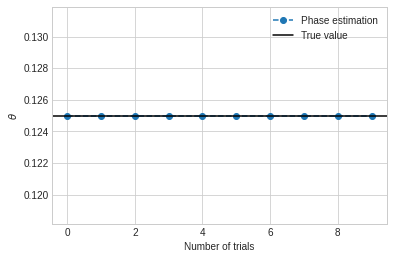

In [ ]:
"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(theta_estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of trials")
plt.ylabel(r"$\theta$");

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

In [ ]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

print(theta_estimates)
print(estimates)

"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

*Step 5: Compute the Eigenvalues from the theta value*

Eigenvalue: $e^{2 \pi i \theta}$ is the corresponding eigenvalue, so for $\theta$ = 0.125 $\rightarrow$ $e^{2 * \pi * i * 0.125}$ = <font color="blue">0.707106781 + 0.707106781 i (Eigenvalue of T-gate)</font>

* Verification: $
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$ $\rightarrow$ <font color="blue">$e^{\frac{i \pi}{4}}$ is the same as $e^{2 * \pi * i * 0.125}$ bzw. $e^{\frac{2 * \pi * i}{8}}$</font>

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

* ps: $e^{2 \pi i}$ =  1 (identity) - ohne theta, die phase

* From Eigenvalue euqation: $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$. Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* https://quantumcomputing.stackexchange.com/questions/9577/how-to-find-eigenvalues-and-eigenvector-for-a-quantum-gate


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_115.png)


###### *Shor's Algorithm*

**Classical Calculation**

* <font color="blue">Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

* all we need to do is find this nontrivial squareroot of unity, and we can factor whatever number we need. As promised, we can do this with period finding, specifically by computing the order of a random integer

* The order of some integer x modulo N is the smallest integer r such that $x^r$ = 1 mod N

*Modular Arithmetic*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_088.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_089.jpg)

**<font color="blue">Step 1: Pick coprime of N**

*Drei mögliche Verfahren zur Berechnung des ggT :*

Erstes Verfahren: Euklidischer Algorithmus 
* 15	:	13	  = 	1	  Rest  	2.	  Also ist ggT (15,13)= ggT (13,2)
* 13	:	2	  = 	6	  Rest  	1.	  Also ist ggT (13,2)= ggT (2,1)
* 2	:	1	  = 	2	  Rest  	0.	  Also ist ggT (2,1)= ggT (1,0)
* Ergebnis: Der ggT von 15 und 13 ist 1.

Zweites Verfahren: Vergleichen der Teilermengen .
* Die Teilermenge von 15 lautet: {1,3,5,15}.
* Die Teilermenge von 13 lautet: {1,13}.
* Die größte in beiden Teilermengen vorkommende Zahl ist 1. Also ist 1 der ggT von 15 und 13. 

Dritte Möglichkeit: Vergleichen der Primfaktorzerlegung
* Die Primfaktorzerlegung von 15 lautet: 15= 3·5.
* Die Primfaktorzerlegung von 13 lautet: 13= 13.
* Die gemeinsamen Primfaktoren sind: 1.
* Also ist 1 der ggT.

*Modulo (kurz: mod) berechnet den Rest einer Division zweier Zahlen. In Mathematischen Formeln wird modulo mit mod abgekürzt, beispielsweise: 23 mod 8 = 7. Bei dieser Rechnung kommt 7 heraus, weil die 8 zweimal in die 23 passt und dann 7 übrig bleiben.*

In [ ]:
# Product of two prime numbers (to check later if result is correct)
N=5 * 3

# Pick coprime (!) number to N to factorize N into primes
a=13

# Code Example to understand periodicity in the context of factoring prime numbers:

import math
# Compute greated common divisor between a and N
math.gcd(a, N)

1

**<font color="blue">Step 2: Find the period of $a^r$ $\equiv$ 1 $(modN)$:**

* <font color="blue">the order of x is just the period of the function f(i) = $x^i$ mod N. 

* <font color="blue">In quantum computing you use QFT in order to determine the period !!

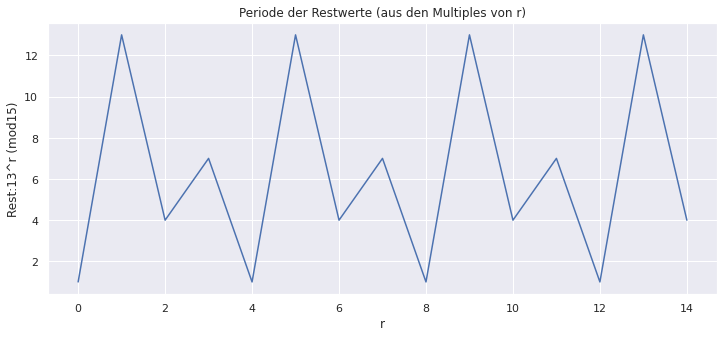

In [ ]:
import matplotlib. pyplot as plotter
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.5})

r = list(range(N))
y= [a**r0 % N for r0 in r]

plotter.plot (r, y)
plotter.xlabel('r')
plotter.ylabel('Rest:' f'{a}^r (mod{N})')
plotter.title('Periode der Restwerte (aus den Multiples von r)')
plotter.show()

<font color="red">**Beispiel: Choose any number $a$ and takes its multiple $r$ so many times, until the rest in modulo is 1, (except r=0)**</font>

> $13^0$ (mod 15) = 1 (mod 15) = 1

> $13^1$ (mod 15) = 13 

> $13^2$ (mod 15) = 169 (mod 15) = 4

* <font color="blue">*Erlauterung: Nimm 15 * 11 = 165, bis zur 169 verbleibt ein Rest 4*

> $13^3$ (mod 15) = 2197 (mod 15) = 7 

* <font color="blue">*Erlauterung: Nimm 15 * 146 = 2190, bis zur 2197 verbleibt ein Rest 7*

> $13^4$ (mod 15) = 28561 (mod 15) = 1 (<font color="blue"><u>hier started die Periode wieder, that's the r we are looking for!</u>)

> usw..

In [ ]:
r= r[y[1:].index(1)+1]
print(f'r = {r}')

r = 4


**<font color="blue">Step 3: Bestimme $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$**. Mindestens einer der beiden Primfaktoren von N={p,q} is beinhalted in gcd(x+1, N) bzw. gcd(x-1, N)

*In this case with a=13, N=15 and r=4:*

* $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$

* $x \equiv 13^{\frac{4}{2}}(\operatorname{mod} 15)$

* x = 169 (mod 15) = 4

  * gcd(x-1, N) = 3 = p

  * gcd(x+1, N) = 5 = q

Achtung: in einem anderen Beispiel: N=11*7 (Primzahlen), a=18, ergibt x=43. 

* Davon x-1=42 und x+1=44. 
* Das sind naturlich keine Primzahlen, 
* Aber deren Faktoren sind: 44 = 2 * 2 * 11 und 42 = 2 * 3 * 7
* das heisst, x-1 und x+1 kann auch die Primzahlen indirekt enthalten!

In [ ]:
if r % 2 == 0:
  x = (a**(r/2.)) % N
  print(f'x = {x}')
  if ((x + 1) % N) != 0:
    print(math.gcd((int(x)+1), N), math.gcd((int(x)-1), N))
  else:
      print ("x + 1 is 0 (mod N)")
else:
  print (f'r = {r} is odd')

x = 4.0
5 3


**Shor's Algorithm**

* When finding order using the period finding algorithm, it is important to use enough qubits. A sensible rule is that you need to use m qubits so that $2^m$ >> $N^2$, where N is the number we are trying to factor, because the order of a random number might be as large as N

* Example: Lets factor N=119. Suppose we pick the number 16 to start with. Wie viele Qubits m sollten wir mindestens nehmen? $N^2$ = $119^2$ =14.161 und $2^m$ muss deutlich grosser sein, also mindestens = $2^{14}$ = 16.384. Wir brauchen also mindestens 14 Qubits, um 119 zu faktorisieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_090.jpg)

* Because we know that the order of x will be even and $x^{s/2}$ will be a nontrivial square root with probability at least 1/2, we can be confident that we will be able to factor N in just a few runs of the algorithm. Because the time it takes to find the period grows as a polynomial in the number of bits, and the number of bits grows like 2logN(by the above requirement), we expect the time it takes to factor N to grow as a polynomial in logN.

* Here is the circuit for Shor’s Algorithm. It relies heavily on period finding, and so the circuit looks a lot like the circuit for period finding. The key difference is that we are finding the period of f(i) = xi, and the number of bits we need to input is very large.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_091.jpg)

**How does it work in the quantum circuit?**

That's the function in $U$: given an $x$, the $U$ will compute:

> $f_{a, N}(x) \equiv a^{x}(\bmod N)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_092.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_093.png)

**<font color="blue">Shor's Algorithm: Step by Step**

**Beispiel: a=13 und N=15, was macht Shor's Algorithm genau im Circuit an der Stelle $U_{f_{(a,N)}}$ und $QFT^{\dagger}$?**

ps: a muss ein Coprime von N sein. Wenn es kein Coprime ist, muessen wir nicht durch Shor's Algorithm gehen, weil a dann einen Faktor mit N teilt :) Aber es ist very unlikely to find a coprime of a large number N.

**First let's divide it into steps. 1-5:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

**Step 1**: Get Qubits in state 0 and apply Hadamard Superposition

We start with 4 Qubits all in zeros, mit den Registers x und w, und jedes 4 Mal Tensorproduct multipliziert, weil wir 4 Qubits haben: 

> $|0\rangle_{x}^{\otimes 4}$ $|0\rangle_{w}^{\otimes 4}$

All Hamadard Gates are applied to top 4 Qubits (x register), and right part (w register) gets nothing applied to it:

> $[H^{\otimes 4}|0\rangle] \,\, |0\rangle^{\otimes^{4}}$

> = $\frac{1}{4}[|0\rangle+|1\rangle+|2\rangle+\cdots+|15\rangle]$ $|0\rangle$

* Reminder 1: Multiplikation mit $\frac{1}{4}$, weil 4 Qubits in Hadamard-Superposition

* Reminder 2: this is the 4 bit representation of the decimal number, so for example 15 in binary = 1111. Daher kann man auch die 4 angeben als Erinnerung der Bit representation:

> = $\frac{1}{4}[|0\rangle_4+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $|0\rangle_4$


**Step 2**: Compute $U$ with $f_{a, N}(x) \equiv a^{x}(\bmod N)$ - Was passiert genau in der Box mit $U_{f_{(a,N)}}$?

**Given an $x$, the $U$ will compute: <font color="red">$f_{a, N}(x) \equiv a^{x}(\bmod N)$</font>**

Schauen wir nochmal im vorherigen Schritt und markieren eine Komponente:

> = $\frac{1}{4}[$ <font color="red">$|0\rangle_4$</font> $+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $\,$ $|0\rangle_4$

<font color="red">$U_{f_{(a,N)}}$</font> macht dann folgendes:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|  0 \bigoplus 13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left|0 \bigoplus 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left|0 \bigoplus 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left|0 \bigoplus 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]

Remember: $\bigoplus$ means "addition modular 2" bzw. "XOR". Anything XORs with 0, is thing itself: 0 $\bigoplus$ Z = Z. damit ergibt sich folgende Rechnung:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|   13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left| 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left| 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left| 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]


Aus der Modulo-Rechnung ergeben sich die Restwerte:

* <font color="red">$13^{0}(\bmod 15)$ = 1</font>

* $13^{1}(\bmod 15)$ = 13

* $13^{2}(\bmod 15)$ = 4

* $13^{3}(\bmod 15)$ = 7

* $13^{4}(\bmod 15)$ = 1

* usw..

Since it's periodic, it will repeat, with the x and w register:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\,\left|1\right\rangle_{4}$</font> + $|1\rangle_{4}\left|13\right\rangle_{4}$ + $|2\rangle_{4}\left|4\right\rangle_{4}$ + $|3\rangle_{4}\left|7\right\rangle_{4}$ etc..]

Hier nochmal untereinander mit denselben Restwerten zur besseren Visualisierung:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_094.png)

**Step 3: Measurement of the w register / bottom 4 Qubits**

* the outputs of the w-register measurements are either 1, 13, 4 or 7 (die Restwerte) with equal probability

* let's say we measure 7, what happens to x? X becomes either 3, 7, 11 or 15 (the value in front of the qubit with 7!) with equal probability:

  * after $|\omega\rangle$ = $|7\rangle_4$ , $|x\rangle$ becomes:

  * <font color="blue">$|x\rangle$ $|\omega\rangle$ = $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$ $\otimes |7\rangle_4$

  * Normalization has changed: before we had 16 combinations mit 1/4, here we have only 4 combinations with 1/2 (=one over square root of 4)

* **For the next step 4, the Restwert doesn't matter anymore, here: $\otimes |7\rangle_4$. We can ignore it. Because it step 4 we apply the measured $|x\rangle$ in the $QFT^{\dagger}$, and don't care about $|\omega\rangle$ anymore**. And $|x\rangle$ is in this case: $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

*Exkurs: Eine komplexe Zahl $z=a+b i$ und die zu ihr konjugiert komplexe Zahl $\bar{z}=a-b i$*:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Komplexe_konjugation.svg/294px-Komplexe_konjugation.svg.png)

Ändert man das Vorzeichen des Imaginärteils $b$ einer komplexen Zahl 

> $z=a+b \mathrm{i}$

so erhält man die zu $z$ konjugiert komplexe Zahl 

> $\bar{z}=a-b \mathrm{i}$ 

(manchmal auch $z^{*}$ geschrieben).

Die Konjugation $\mathbb{C} \rightarrow \mathbb{C}, z \mapsto \bar{z}$ ist ein (involutorischer) Körperautomorphismus, da sie mit Addition und Multiplikation verträglich ist, d. h., für alle $y, z \in \mathbb{C}$ gilt

>$
\overline{y+z}=\bar{y}+\bar{z}, \quad \overline{y \cdot z}=\bar{y} \cdot \bar{z}
$

In der Polardarstellung hat die konjugiert komplexe Zahl $\bar{z}$ bei unverändertem Betrag gerade den negativen Winkel von $z$. 

* **Man kann die Konjugation in der komplexen Zahlenebene also als die Spiegelung an der reellen Achse interpretieren**. 

* <font color="blue">**Insbesondere werden unter der Konjugation genau die reellen Zahlen auf sich selbst abgebildet**.

Das Produkt aus einer komplexen Zahl $z=a+b$ i und ihrer komplex Konjugierten $\bar{z}$ ergibt das Quadrat ihres Betrages:

> $
z \cdot \bar{z}=(a+b i)(a-b i)=a^{2}+b^{2}=|z|^{2}
$

Die komplexen Zahlen bilden damit ein triviales Beispiel einer [C*-Algebra](https://de.m.wikipedia.org/wiki/C*-Algebra).

**Step 4**: Apply inverse $QFT^{\dagger}$ on the $|x\rangle$ register

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$ (Reminder!)

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ (see -2 turning i in -i which is a **complex conjugate operation**)

* We want to know what QFT dagger is doing to (it is $\frac{1}{\sqrt{16}}$ because we have 4 Qubits)

  * $QFT^{\dagger}|3\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 3 y}{16}}|y\rangle$

  * $QFT^{\dagger}|7\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 7 y}{16}}|y\rangle$

  * $QFT^{\dagger}|11\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 11 y}{16}}|y\rangle$

  * $QFT^{\dagger}|15\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 15 y}{16}}|y\rangle$

Alltogether:

  * $QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}} \sum_{y=0}^{15}$ [ $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$] $|y\rangle$

    * with: $e^{-i\frac{ 3 \pi}{8}y}$ = $\cos \left(\frac{3 \pi}{8} y\right)-i \sin \left(\frac{3 \pi}{8} y\right)$ (und aquivalent fur alle anderen drei)

    * siehe coding rechnung unten was genau passiert hier!
  
  * <font color="blue">$QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}}$ [ $4|0\rangle_4$ + $4i|4\rangle_4$ $-4|8\rangle_4$ $-4i|12\rangle_4$ ]</font>
  
  * Remember we had a sum before: $\frac{1}{{8}} \sum_{y=0}^{15}$. And notice how all the other terms now vanished to zero, because you had equal contributions of plus and minus.

    * **This is exactly what it means when people tell you that quantum computers take advantage of interference!! = when a lot of the terms vanish, and the answer only converges to the terms that we care about.**

    * here is the calculation what happened, you see many zeros:

<font color="red">Hier Beispielrechnung fur y=1, um vanishing components zu verstehen</font>. Unten im Code die Ergebnisse, zum Beispiel fur y=1 als Ergebnis = 0, $QFT^{\dagger}|x\rangle$ fur y = 1: 
    
  * $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$ =
    
  * $e^{-i\frac{ 3 \pi}{8}1}$ + $e^{-i\frac{ 7 \pi}{8}1}$ + $e^{-i\frac{ 11 \pi}{8}1}$ + $e^{-i\frac{ 15 \pi}{8}1}$ =

    * $e^{-i\frac{ 3 \pi}{8}1}$ = <font color="green">0,382683432 - 0,923879533 i</font>

    * $e^{-i\frac{ 7 \pi}{8}1}$ = <font color="orange">-0,923879533 - 0,382683432 i</font>

    * $e^{-i\frac{ 11 \pi}{8}1}$ = <font color="green">-0,382683432 + 0,923879533 i</font>

    * $e^{-i\frac{ 15 \pi}{8}1}$ = <font color="orange">0,923879533 + 0,382683432 i</font>

  * Wie man sieht canceln sich die Terme aus (in gleicher Farbe), weshalb als Ergebnis fur y=1 Null entsteht.

In [ ]:
# Hier Beispiel fur y=1 und den ersten e-Term:
y = 1
pi = np.pi
coeff = np.exp(-1j*3*pi/8 * y)
if abs(coeff) < 1e-10: coeff= 0
print(y, coeff)

1 (0.38268343236508984-0.9238795325112867j)


In [ ]:
# Hier die komplette Rechnung fur alle y und alle 4 e-Terme:
import numpy as np

pi = np.pi
for y in range (15) :
  coeff = np.exp(-1j*3*pi/8 * y) + \
          np.exp(-1j*7*pi/8 * y) + \
          np.exp(-1j*11*pi/8* y) + \
          np.exp(-1j*15*pi/8* y)
  if abs(coeff) < 1e-10: coeff= 0
  print(y, coeff)

0 (4+0j)
1 0
2 0
3 0
4 (-5.757077917265737e-15+4j)
5 0
6 0
7 0
8 (-4-1.1514155834531474e-14j)
9 0
10 0
11 0
12 (2.2600304269997962e-14-4j)
13 0
14 0


**Step 5: Measure the |x> register**

* You get either 0 or 4 or 8 or 12 with equal probability

* Remaining steps are classical post-processing

* You can already see the periodicity in the result: the difference is always 4

* Analyse what happens for each outcome: **The measurement results peak near $j\frac{N}{r}$ for same integer j $\in Z$. And r is the period that we are looking for. N = $2^n$ Qubits!**

  * if we measure |4>$_4$: $j\frac{16}{r}$ = 4, true if j=1 and r=4

  * there are multiple values that would work, but this is the lowest one

* now check our protocoll for r=4:

  * Is r even? yes!

  * $x \equiv a^{r / 2}(\bmod N)$ = $13^{4 / 2}(\bmod 15)$ = 4

  * x+1 = 5 and x-1 = 3

* This looks good, now check:

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(5,15)=5$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(3,15)=3$

What do you do if r = 8 ?

* |8>$_4$: $j\frac{16}{r}$ = 8, true if j=1 and r=2 AND j=2 and r=4

* if r=4 we are back in the case before

* if r=2 then $x \equiv a^{r / 2}(\bmod N)$ = $13^{2 / 2}(\bmod 15)$ = 2, which brings x+1 = 3 and x-1 = 1

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(3,15)=3$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(1,15)=1$

* This leads you to a partial solution. Now you can back out the other solution, with checking 3 divides into 15

* If we get r=0, then we need to do the experiment again

Hier die Faktorisierungsergebnisse fur verschiedene QC-Ausgaben r. Mit r=0 geht es nicht, also kann man in 3 von 4 Faellen faktorisieren (und mit r=8 bekommt man eine partial solution, kann aber immer noch faktorisieren).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_097.png)

Aus dem 2001 Paper von IBM, Faktorisierung von 15 auf einem Quantum Computer:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_096.png)

**Appendix: What is the Gate structure in $U$?**

* $a^{x_1}$, $a^{x_2}$, $a^{x_n}$ tells you this is a controlled operation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_098.png)

* look now how the exponent doesn't contain $x_1$, $x_2$, .. $x_n$ anymore

* this is done by implementing it by doing these controls

* this is exactly like quantum phase estimation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_099.png)

**Der linke Term stammt aus QPE, der rechte Term ist der Teil $U$ aus Shor's Algorithms:**

> <font color="blue">$U^{2^{x}}=a^{2^{x}}(\bmod N)$</font>

continue: https://youtu.be/IFmkzWF-S2k?t=1181

###### *Grover Search*

> **[Grover’s algorithm](https://en.m.wikipedia.org/wiki/Grover's_algorithm) teaches us how we can search for an item in an unsorted list without needing to look at each item one by one but by looking at them all at once.**

It accomplishes that using two techniques:

  * First, it uses a quantum oracle to mark the searched state. 
  
  * Second, it uses a diffuser that amplifies the amplitude of the marked state to increase its measurement probability.

Grover's Algorithm : Suche in grossen Datenbanken (Squared speedup: get result in the square root of time that on classical computers)

* Auf einem klassischen Computer ist der prinzipiell schnellstmögliche Suchalgorithmus in einer unsortierten Datenbank die [lineare Suche](https://de.m.wikipedia.org/wiki/Lineare_Suche), die ${\mathcal {O}}\left(N\right)$ Rechenschritte erfordert (Der Suchaufwand wächst linear mit der Anzahl der Elemente in der Liste.)

* Die effizientere [Binäre Suche](https://de.m.wikipedia.org/wiki/Binäre_Suche) kann nur bei geordneten Listen benutzt werden. Die Binäre Suche ist deutlich schneller als die lineare Suche, welche allerdings den Vorteil hat, auch in unsortierten Feldern zu funktionieren. In Spezialfällen kann die [Interpolationssuche](https://de.m.wikipedia.org/wiki/Interpolationssuche) schneller sein als die binäre Suche.

* Makes use of Amplitude Amplification, Quantum Walk & Quantum Counting

> Grover's Algorithm uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states (=Phase Flip of Desired Outcome + Probability Amplitudes Inversion about the Mean to Amplify)

Grover’s algorithm solves oracles that **add a negative phase to the solution states**. I.e. for any state |x⟩ in the computational basis:

> $U_{\omega}|x\rangle=\left\{\begin{aligned}|x\rangle & \text { if } x \neq \omega \\-|x\rangle & \text { if } x=\omega \end{aligned}\right.$

We create a function $f$ that takes a proposed solution $x$, and returns 

* $f(x)=0$ if $x$ is not a solution ( $x \neq \omega)$ 

* $f(x)=1$ for a valid solution $(x=\omega)$.

The oracle can then be described as:

> $U_{\omega}|x\rangle=(-1)^{f(x)}|x\rangle$

* you can see this is an Eigenvalue equation

The oracle's matrix will be a diagonal matrix of the form:

> $U_{\omega}=\left[\begin{array}{cccc}(-1)^{f(0)} & 0 & \cdots & 0 \\ 0 & (-1)^{f(1)} & \cdots & 0 \\ \vdots & 0 & \ddots & \vdots \\ 0 & 0 & \cdots & (-1)^{f\left(2^{n}-1\right)}\end{array}\right]$

*Source: https://qiskit.org/textbook/ch-algorithms/grover.html*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_105.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_106.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_107.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_108.jpg)

*Step 1: Hadamard-Operator for Superposition + Assign a Phase -1 to the desired outcome*

Start with a balanced superposition, and assign a phase of -1 to the chosen ket, 111). Assigning -1 means applying a Pauli-Z-operator in the superposition to this one !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_102.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_101.jpg)

**<font color="blue">More about Amplitude Amplification**

* [Amplitude amplification](https://en.m.wikipedia.org/wiki/Amplitude_amplification) is a technique in quantum computing which **generalizes the idea behind the Grover's search algorithm**, and gives rise to a family of quantum algorithms.

* In a quantum computer, amplitude amplification can be used to **obtain a quadratic speedup over several classical algorithms**.

1. If there are $G$ good entries in the database in total, then we can find them by initializing a quantum register $|\psi\rangle$ with $n$ qubits where $2^{n}=N$ into a uniform superposition of all the database elements $N$ such that

>$| \psi \rangle=\frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}|k\rangle
$

2. and running the above algorithm. In this case the overlap of the initial state with the good subspace is equal to the square root of the frequency of the good entries in the database, $\sin (\theta)=|P| \psi\rangle \mid=\sqrt{G / N}$. If $\sin (\theta) \ll 1$, 

3. we can
approximate the number of required iterations as

>$
n=\left\lfloor\frac{\pi}{4 \theta}\right\rfloor \approx\left\lfloor\frac{\pi}{4 \sin (\theta)}\right\rfloor=\left\lfloor\frac{\pi}{4} \sqrt{\frac{N}{G}}\right\rfloor=O(\sqrt{N})
$

Measuring the state will now give one of the good entries with high probability.

Since each application of $S_{P}$ requires a single oracle query (assuming that the oracle is implemented as a quantum gate), we can find a good entry with just $O(\sqrt{N})$ oracle queries, thus obtaining a quadratic speedup over the best possible classical algorithm. (The classical method for searching the database would be to perform the query for every $e \in\{0,1, \ldots, N-1\}$ until a solution is found, thus costing $O(N)$ queries.) Moreover, we can find all $G$ solutions using $O(\sqrt{G N})$ queries.

* Now, let’s say four qubits are enough and Mr. Grover is known as |0010⟩. The oracle uses the specific characteristic of this state to identifying it. That is the state has a |1⟩ at the third position and |0⟩ otherwise.

* Since the quantum oracle takes all qubits as input, it can easily apply a transformation of this exact state. It doesn’t matter whether we use four qubits or 33. The oracle identifies Mr. Grover in a single turn.

* The transformation the oracle applies to the searched state is an inversion of the amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_109.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_110.png)

* In the representation above representation (the dark one) of the amplitudes, we can clearly see a difference between the searched state and all the other states. We could prematurely declare the search is over.

* The only difference is in the sign of the amplitude. For the measurement probability results from the amplitude’ absolute square, the sign does not matter at all.

* The amplitude originates from the concept that every quantum entity may be described not only as a particle but also as a wave. The main characteristic of a wave is that it goes up and down as it moves. The amplitude is the distance between the center and the crest of the wave.

* If we invert the amplitude of a wave at all positions, the result is the same wave shifted by half of its wavelength.

* These two waves differ only in their relative position. This is the phase of the wave. For the outside world, the phase of a wave is not observable. Observed individually, the two waves appear identical. So, the problem is we can’t tell the difference between these two waves.

> As a consequence, the system does not appear any different from the outside. Even though the oracle marked the searched state and it, therefore, differs from the other states, all states still have the same measurement probability.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_111.png)


*Step 2: Invert all probability amplitudes about the mean + Measure*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

* We need to turn the difference into something measurable. We need to increase the measurement probability of the marked state. This is the task of the diffuser. The diffuser applies an inversion about the mean amplitude.

* Let’s have a look at the average amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_112.png)

* With four qubits, we have 16 different states. Each state has an amplitude of 1/sqrt(16)=1/4. In fact, each but one state — the searched state has this amplitude. The searched state has an amplitude of −1/4. Thus, the average is (15∗1/4−1/4)/16=0.21875.

* The average is a little less than the amplitude of all states we did not mark. If we invert these amplitudes by this mean, they end up a little lower than the average at 0.1875.

* For the amplitude of the marked state is negative, it is quite far away from the average. The inversion about the mean has a greater effect. It flips the amplitude from −0.25 by 2∗(0.25+0.21875) to 0.6875 (bzw: =0,21875-(-0,25-0,21875)).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_113.png)

* The inversion about the mean works well if we search for a single or a few negative amplitudes among many positive amplitudes. Then, this operation increases the negative amplitudes we know are the correct ones. And this operation decreases the positive amplitudes, we know are wrong.

> This operation increases the negative amplitude by a large amount while decreasing the positive amplitudes by a small amount.

* But the more states we have, the lower the overall effect will be. In our example, we calculated the new amplitude of the searched state as 0.6875. The corresponding measurement probability is 0.6875^2=0.47265625. Accordingly, we measure this system only about every other time in the state we are looking for. Otherwise, we measure it in any other case.

* Of course, we could now measure the system many times and see our searched state as the most probable one. But running the algorithm so many times would give away any advantage we gained from not searching all the states.

> **Instead, we repeat the algorithm. We use the same oracle to negate the amplitude of the searched state. Then we invert all the amplitudes around the mean, again**.

However, we must not repeat this process too many times. There is an optimal number of times of repeating this process to get the greatest chance of measuring the correct answer. 

* The probability of obtaining the correct result grows until we reach about π/4*sqrt(N) with N is the number of states of the quantum system. Beyond this number, the probability of measuring the correct result decreases again.

* In our example with four qubits and N=16 states, the optimum number of iterations is 3.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_104.jpg)

https://towardsdatascience.com/towards-understanding-grovers-search-algorithm-2cdc4e885660

*Grover Search: Simple Examples (Z-Gate and I-Gate as amplifiers. with H as Diffuser)*

**Example 1: Z Gate to switch from 0 to 1**

* Let’s say the state |1⟩ depicts the favorable state we want to find. Then, the oracle consists of the Z-gate that switches the amplitude when the corresponding qubit is in state |1⟩.

* As a result, we see the amplitude changed for state |1⟩. The qubit is now in state |−⟩. Its two states |0⟩ and |1⟩ are in two different phases, now.

* In other words, we flipped the amplitude of state |1⟩ from positive to negative.

* Both states still have a measurement probability of 0.5. It is the task of the diffuser to magnify the amplitude to favor the searched state.

* **The diffuser in a single-qubit circuit is quite simple. It is another H-gate**. This circuit results in state |1⟩ with absolute certainty.

We apply an important sequence on the qubit, the HZH-circuit. This circuit is known as an identity to the NOT-gate (X-gate) that turns state |0⟩ into |1⟩ and vice versa.

The following equation proves this identity.

> $H Z H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right] \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=X$

Then, why would we use the HZH-sequence? If it is similar to the NOT-gate, why don’t we use that instead?

<font color="red">Simply put, the HZH-sequence is more flexible. It is the simplest form of Grover’s search algorithm.</font> It starts with all states being equal (the first H-gate). It applies an oracle (Z-gate). 

And, <font color="blue">**it uses a diffuser that amplifies the amplitude of the selected state |1⟩ (the second H-gate)**.

> While we could rewrite these two circuits more succinctly, the circuit identities of HZH=X and HIH=I let us use the general structure of Grover’s algorithm. Simply by changing the oracle, we can mark and amplify different states. We don’t need to come up with a new algorithm for each possible state we want to select out of a list. But we only need to find an appropriate oracle. This ability comes in handy the more states our quantum system has.

> The search for one of two possible states does not even deserve to be called a search. But the general structure of Grover’s algorithm is not different from this very simple example. **It uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states**.



**Quantum Counting**

> **In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration.**

* how many solutions exist?

* does there any solution exist?


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $\left|s^{\prime}\right\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $\left|s^{\prime}\right\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i \theta}$, and **we can extract this using quantum phase estimation (QPE) to estimate the number of solutions $(M)$**.

**First we want to get $\theta$ from measured_int. (phase estimation)** 

* You will remember that $\mathrm{QPE}$ gives us a measured value $=2^{n} \phi$ from the eigenvalue $e^{2 \pi i \phi}$, 

* so to get $\theta$ we need to do:

> $
\theta=\text { value } \times \frac{2 \pi}{2^{t}}
$

**Second, we calculate the inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle:$**

> $
\left\langle s^{\prime} \mid s\right\rangle=\cos \frac{\theta}{2}
$

* And that $|s\rangle$ (a uniform superposition of computational basis states) can be written in terms of $|\omega\rangle$ and $\left|s^{\prime}\right\rangle$ as:

> $
|s\rangle=\sqrt{\frac{M}{N}}|\omega\rangle+\sqrt{\frac{N-M}{N}}\left|s^{\prime}\right\rangle
$

* The inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle$ is:

> $
\left\langle s^{\prime} \mid s\right\rangle=\sqrt{\frac{N-M}{N}}=\cos \frac{\theta}{2}$

* From this, we can use some trigonometry and algebra to show:

> $
N \sin ^{2} \frac{\theta}{2}=M
$

**Third, calculate number of solutions**

* From the Grover's algorithm chapter, you will remember that a common way to create a diffusion operator, $U_{s}$, is actually to implement $-U_{s}$. 

* This implementation is used in the Grover iteration provided in this chapter. In a normal Grover search, this phase is global and can be ignored, but now we are controlling our Grover iterations, this phase does have an effect. 

* The result is that we have effectively searched for the states that are not solutions, and our quantum counting algorithm will tell us how mâny states are not solutions. To fix this, we simply calculate 

> $N-M$

The ability to perform quantum counting efficiently is needed in order to use Grover's search algorithm (because running Grover's search algorithm requires knowing how many solutions exist). Moreover, this algorithm solves the quantum existence problem (namely, deciding whether any solution exists) as a special case.

###### *Harrow-Hassidim-Lloyd Algorithm (HHL)*

<font color="blue">**Solving a system of linear equations with a quantum computer (HHL)**

* **Given a matrix $A \in \mathbb{C}^{N \times N}$ and a vector $\vec{b} \in \mathbb{C}^{N}$, find $\vec{x} \in \mathbb{C}^{N}$ satisfying $A \vec{x}=\vec{b}$**

* The spectrum of $A$ is given by: $A\left|v_{j}\right\rangle=\lambda_{j}\left|v_{j}\right\rangle, 1 \geq\left|\lambda_{j}\right| \geq 1 / \kappa$


**Objective: We want to solve a system of linear equations by finding $\vec{x}$**

* Familiar methods of solutions: Substitution method, Graphical method, Matrix method, Cramer's rule, Gaussian elimination

* The classical algorithm returns the full solution, while the HHL can only approximate functions of the solution vector.


> $A \vec{x} = \vec{b}$

Classically you would take the inverse of $A$ (via spectral decomposition / eigendecomposition):

> $\vec{x} = A^{-1} \vec{b}$

The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language. 

* By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$. 

* Usually the mapping used is such that $i^{\text {th }}$ component of $\vec{b}$ (resp. $\vec{x}$ ) corresponds to the amplitude of the $i^{\text {th }}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$ ). 

From now on, we will focus on the rescaled problem

><font color="blue">$A|x\rangle=|b\rangle
$</font> $\quad$ (System of linear equations in a quantum state)

And we want to find this:

><font color="blue">$|x\rangle=A^{-1}|b\rangle$</font> $\quad$ (the solution is: $|x\rangle = \sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle$)

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:
 
>$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

>$
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

and the right hand side of the system can be written in the eigenbasis of $A$ as

>$
|b\rangle=\sum_{j=0}^{N-1} b_{j}\left|u_{j}\right\rangle, \quad b_{j} \in \mathbb{C}
$

It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state

>$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle
$

Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

**HHL-Algorithm**

*Main Subroutines in HHL: Hamiltonian simulation, Phase estimation (newer: linear combination of unitaries) and (Variable-time) amplitude amplification*

1. Prepare the initial state $|b\rangle$. Note that $|b\rangle=\sum_{j} c_{j}\left|v_{j}\right\rangle$.

2. Use the so-called phase estimation algorithm to perform the map
$|b\rangle \rightarrow \sum_{j} c_{j}\left|v_{j}\right\rangle\left|\tilde{\lambda}_{j}\right\rangle$

* $|\tilde{\lambda}_{j}\rangle$ -> This register contains the eigenvalue estimates.

3. Apply a one-qubit conditional rotation to perform the map
$|0\rangle \rightarrow \frac{1}{\kappa \tilde{\lambda}_{j}}|0\rangle+\sqrt{1-\frac{1}{\kappa^{2} \tilde{\lambda}_{j}^{2}}}|1\rangle$

4. Undo step 2 - apply the inverse of phase estimation
$\sum_{j} \frac{c_{j}}{\kappa \tilde{\lambda}_{j}}\left|v_{j}\right\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle \approx \frac{1}{\kappa A}|b\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle$

5. Use amplitude amplification to get rid of the „bad“ part of the state with |1>


**Applications of HHL**

* Systems of linear equations arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation. 

* Used in many quantum machine learning algorithms as a building block


* The quantum algorithm for linear systems of equations has been applied to a support vector machine, which is an optimized linear or non-linear binary classifier (https://arxiv.org/abs/1307.0471v2)

* for Least-squares fitting (https://arxiv.org/abs/1204.5242)

* for finite-element-methods (https://arxiv.org/abs/1512.05903) (but only for higher problems which include solutions with higher-order derivatives and large spatial dimensions. For example, problems in many-body dynamics require the solution of equations containing derivatives on orders scaling with the number of bodies, and some problems in computational finance, such as Black-Scholes models, require large spatial dimensions)

**Promise**: 

* Solving 10,000 linear equation: a classical computer needs in best case 10,000 steps. HHL just 13. The [quantum algorithm for linear systems of equations](https://en.m.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) designed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd: Provided the linear system is sparse and has a low condition number $\kappa_{1}$ and that the user is interested in the result of a scalar measurement on the solution vector, instead of the values of the solution vector itself, then the algorithm has a runtime of $O\left(\log (N) \kappa^{2}\right)$, where $N$ is the number of variables in the linear system. This offers an exponential speedup over the fastest classical algorithm, which runs in $O(N \kappa)$ (or $O(N \sqrt{\kappa})$ for positive semidefinite matrices).

* Unlike the classical solutions to the Deutsch-Jozsa and search problems, most of our classical methods for matrix manipulation do work in polynomial time. However, as data analysis becomes more and more powerful (and more and more demanding on today’s computers), the size of these matrices can make even polynomial time too long.

**Disadvantages:**

* solution vector is not yielded (rather it prepares a quantum state that is proportional to the solution): Actually reading out the solution vector would take O(N)time, so we can only maintain the logarithmic runtime by sampling the solution vector like ⟨x|M|x⟩, where M is a quantum-mechanical operator. Therefore, **HHL is useful mainly in applications where only samples from the solution vector are needed**. 

* Entries of matrix have to be sparse: Additionally, although HHL is exponentially faster than Conjugate Gradient in N, it is polynomially slower in s and 𝜅, so HHL is restricted to only those matrices that are sparse and have low condition numbers.

* Must satisfy robust invertibility (means that entries of matrix must all approx. of same size)

* Preparation of input vector is complicated


**Sources:**

* https://en.m.wikipedia.org/wiki/System_of_linear_equations#Matrix_solution

* [Peter Witteg: Quantum Machine Learning - 37 - Overview of the HHL Algorithm](https://m.youtube.com/watch?v=hQpdPM-6wtU)

* https://qiskit.org/textbook/ch-applications/hhl_tutorial.html

* https://github.com/quantumlib/Cirq/blob/master/examples/hhl.py

* [Google Quantum: Quantum Algorithms for Systems of Linear Equations (Quantum Summer Symposium 2020)](https://m.youtube.com/watch?v=Xvp56xeNZo4)

* https://www.quantamagazine.org/new-quantum-algorithms-finally-crack-nonlinear-equations-20210105/

* [A New Approach to Multiplication Opens the Door to Better Quantum Computers](https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/)

* https://www.quantamagazine.org/new-algorithm-breaks-speed-limit-for-solving-linear-equations-20210308/

* https://www.quantamagazine.org/teenager-finds-classical-alternative-to-quantum-recommendation-algorithm-20180731/

* https://www.quantamagazine.org/mathematicians-inch-closer-to-matrix-multiplication-goal-20210323/

* https://www.quantamagazine.org/a-new-approach-to-multiplication-opens-the-door-to-better-quantum-computers-20190424/

###### *Data Encoding (Embedding)*

> **The easiest way for a parameter to enter a circuit is through a rotation of a single qubit, in proportion to the value of a single datapoint, so a single scalar value:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_190.png)

> **You can also use a sequence of rotations to embedd data (reuploding).** And maybe there is free parameters in between as well. Can make a more complex function available than if you upload only once in a single rotation.

> **Learnable embeddings**: The other idea is to actually have a trainable embedding layer. Not to worry about training the unitary of the circuit, but worry about training the embedding and then use standard quantum information metrics to classify the data.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_191.png)

**Basis (State) Encoding**

* We gave data points x12 and x2

* We first need to represent data in binary form, like 00 and 10

* Then we encode it into a QC in a way, such that we have basis states that represents them like |00> and |10> 

* with all other basis states having probability zero - represented in the amplitude vector

* So we encode data in quantum state that is aligned with basis states

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_856.png)

**Amplitude Encoding**

* we want to encode our classical information into an amplitude vector

* you have a classical data vector with 4 entries (features) x1

* now construct a circuit, so that we have an amplitude vector that corresponds to the values in the classical data vector:

	* we have 2 qubits initialized in the ground state

	* then we apply some operations U (x1) on these qubits

	* and then we get a quantum state that corresponds to an amplitude vector that exactly represents our classical data points

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_857.png)

**Angle Encoding**

* we have 2 dimension data that we can write in a two dimensional vector

* then I take the number of qubits equal to the number of features (rows / entries in a classical vector)

* then I apply rotations to each of these qubits that are equal to the value of the features 

	* for example I rotate the first qubit about some axis Z. The rotation value / rotation angle is equal to the first classical feature value 

	* the I take my second qubit and rotate it, for example again by the Z axis, and the angle of the rotation is equal to the second feature value of my data point

* for higher dimensional data, for example a third dimension classical vector, then I simply add more qubits to my system to encode this information

* For example:  [z feature map (Qiskit)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html#qiskit.circuit.library.ZFeatureMap):
	* apply Hadamard operator first to each of the qubits, and then encode data values in rotations
	* and then repeat this as many times as you want (stacking operations sequentially like in the image) to encode data multpiple times in a row

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_858.png)

**Higher Order Encoding**

* there is no theoretical reason why doing this or if it's better or not

* the idea comes from the paper [Supervised learning with quantum enhanced feature spaces](https://arxiv.org/abs/1804.11326)

* Basic idea: let's do an encoding that is hard to reproduce classically and simulate, and then maybe we get some quantum advantage in doing this

* we have some two dimensional data with a vector with 2 entries

	* choose number of qubits = number of feature values

	* then apply an hadarmard on each qubit

	* and then do rotations about some axis Z, and the first angle is the first feature value, and the same with the second qubit

	* and then we apply some entanglement gates between these qubits

	* then we do another rotation (for example again Z axis), but this rotation angle depends on some function of the product of the feature values R(x^1 * x^2)

	* this is where the name comes from: we encode in a higher order product space

	* and this whole block of this encoding can be repeated, which is called the depth of the feature maps

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_860.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_861.png)

**Other Encodings**

* Hamiltonian evolution ansatz encoding

* Displacement Encoding

* IQP Encoding (Instantaneous quantum polynomial)

* Squeezing Encoding

* QAOA Encoding

##### <font color="blue">*Scientific Computing*

###### *Code examples*

In [ ]:
#@title
import math
import sympy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

https://www.spektrum.de/news/zehn-algorithmen-die-die-wissenschaft-veraendert-haben/1836355

In [ ]:
# Define input
x = 4
y = 8
z = 20

# Define function
def square_point(x, y, z):
  x_squared = x * x
  y_squared = y * y
  z_squared = z * z
  return x_squared, y_squared, z_squared

# Run function
data=square_point(x, y, z)
print('Result:', square_point(x, y, z))

# Visualize result
sns.set(rc={'figure.figsize':(8, 4), "lines.linewidth": 1.0})
table = pd.DataFrame(data, index=[x, y, z], columns=['Result'])
table = table.reset_index().rename(columns={"index": "Input"})
table.plot(x ='Input', y='Result', kind = 'bar')	

In [ ]:
# Define input
x = 25

# Define functions - Returning multiple values for same function (Iterating through a list)
def square(i):
 return (i**2)

def my_function(x):
  for i in range(10,x,5):  # Start, Stop, Steps
    print(i, square(i))

# Run function
my_function(x)

In [ ]:
# Simple function for one value and Add a conditional

x = 10

def my_function(x):
  if x < (10):
    return (int(math.sqrt(x + 2)), math.sqrt(x + 2))
  else:
    return x**3

my_function(x)

In [ ]:
# For (Loop) with append function

input_list = [1,4,9]
result_list = []

for n in input_list:
    result_list.append(n**3)

print(result_list)

In [ ]:
# For loop with range and as function

x = 10

def my_function(x):
  for i in range(2,x,2):  # Start, Stop, Steps
    print(i, i**2)

my_function(x)

In [ ]:
# Calculate the internal energy of a quantum simple harmonic oscillator at temperature T
from math import exp

terms = 10    # 1000
beta = 1/100
S = 0.0
Z = 0.0
for n in range(terms):
    E = n + 0.5
    weight = exp(-beta*E)
    S += weight*E
    Z += weight
    print('Intermediate value:', S/Z)

print('Final value:', S/Z)

In [ ]:
# Print out the wavelengths of hydrogen lines
R = 1.097e-2
for m in range(1,4,2): # Start, Stop, Steps
    print("Series for m =",m)

    for n in range(m+1,m+6):
        invlambda = R*(1/m**2-1/n**2)
        print("  ",1/invlambda,"nm")

In [ ]:
# Yield and enumerate

# Yield gives you a generator. You'd use it where you would normally use a return in a function.
# yield	generator: ends a function, returns a generator
# When you have a function that returns a sequence and you want to iterate over that sequence, 
# but you do not need to have every value in memory at once.

# Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object

def fibonacci():
    a, b = 0, 1
    while True:
        yield a
        a, b = b, a+b

for i, f in enumerate(fibonacci()):
    print(i, f)
    if i >= 10: break

In [ ]:
# Lambda Function: Add 10 to argument a, and return the result

x = lambda a : a + 10
print('Result 1:', x(5))

# Multiply argument a with argument b and return the result:
x = lambda a, b, c : (a * b) + c
print('Result 2:', x(5, 6, 3))


# function definition that takes one argument, and that argument will be multiplied with an unknown number:
n = 3
a = 12 
def myfunc(n):
  return lambda a : a * n

mytripler = myfunc(n)

print('Result 3:', mytripler(a))

In [ ]:
# Lambda with filter, map, reduce, sorted etc
# https://towardsdatascience.com/lambda-functions-in-python-15b60ff4207d

# Calculate the squares of the elements in a given iterable:
iterable = [1, 3, 5, 6, 9, 11, 15, 16, 21]
list(map(lambda x: x ** 2, iterable))

In [ ]:
# Create a class with a property x:
class MyClass:
  x = 5

# Create an object p1 using the class MyClass, and print the value of x:
p1 = MyClass()
print(p1.x)

# Create a class named Person, use the __init__() function to assign values for name and age:
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

print(p1.name)
print(p1.age)

In [ ]:
# __str__() function controls what should be returned when the class object is represented as a string
class Person:
  def __init__(my_object, name, age):    # Using "my_object" instead of "self"
    my_object.name = name
    my_object.age = age

  def __str__(my_object):
    return f"{my_object.name}, {my_object.age}"

p1 = Person("John", 36)
print(p1)

In [ ]:
# Including object methods:
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

  def myfunc(self):
    print("Hello my name is " + self.name)

p1 = Person("John", 36)
p1.myfunc()

###### *Calculate complexity*

https://towardsdatascience.com/space-and-time-complexity-in-computer-algorithms-a7fffe9e4683

https://towardsdatascience.com/python-performance-and-gpus-1be860ffd58d

https://urban-institute.medium.com/using-multiprocessing-to-make-python-code-faster-23ea5ef996ba

> The VM used for Colaboratory appears to have 13GB RAM and 2 vCPU when checking using psutil (so a n1-highmem-2 instance)

- 2-core Xeon 2.2GHz
- 13GB RAM
- 33GB HDD

maximum lifetime of a VM is 12 hours. Idle VMs time out after 90m

In [ ]:
!nvidia-smi

In [ ]:
from psutil import *
cpu_count()

In [ ]:
cpu_stats()

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!df -h

In [ ]:
virtual_memory()

In [ ]:
# Compute and display complexity of Fibonacci

import time

def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)


# My input data for the function
my_tuple = 5,10,15,20,25

# Define empty bucket
rows_list = []

for n in my_tuple:

    # Begin tracking CPU time
    st = time.process_time(),

    # Run algorithms
    result = fibonacci(n),

    # Finish tracking CPU time
    et = time.process_time(),

    # Calculate performance (end - begin)
    performance = [x - y for x, y in zip(list(et), list(st))]

    # Collect results in a list
    rows_list.append(performance)

# Write results in a table
df = pd.DataFrame(rows_list, index=my_tuple, columns=['CPU Performance in sec']) 
print(df)

# Visualize results in a graph
df = df.reset_index().rename(columns={"index": "Datasize"})
df.plot(x ='Datasize', y='CPU Performance in sec', kind = 'bar')	

In [ ]:
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer

# normal function to run on cpu
def func(a):								
	for i in range(10000000):
		a[i]+= 1	

# function optimized to run on gpu
@jit(target_backend='cuda')						
def func2(a):
	for i in range(10000000):
		a[i]+= 1
if __name__=="__main__":
	n = 10000000							
	a = np.ones(n, dtype = np.float64)
	
	start = timer()
	func(a)
	print("without GPU:", timer()-start)	
	
	start = timer()
	func2(a)
	print("with GPU:", timer()-start)


https://www.geeksforgeeks.org/running-python-script-on-gpu/

* does it consider several CPUs? 
* how to check distribution of a process?
* is it important to consider GPUs? 

**time.process_time()** function always returns the float value of time in seconds. 
* Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process.
* It does not include time elapsed during sleep. 
*The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid.

Note: **process_time()** is very different from **pref_counter()**, as perf_counter() calculates the program time with sleep time and if any interrupt is there but process_counter only calculates the system and the CPU time during the process it not includes the sleep time.

Advantages of **process_time()** :
1. process_time() provides the system and user CPU time of the current process.
2. We can calculate float and integer both values of time in seconds and nanoseconds.
3. Used whenever there is a need to calculate the time taken by the CPU for the particular process.

In [ ]:
import time

# My input data for the function
my_tuple = 10, 15, 20, 25

# Define empty bucket
rows_list = []

for n in my_tuple:

    # Begin tracking CPU time
    st = time.process_time(),

    # Run algorithms
    #result = n**2,
    result = math.factorial(n)

    # Finish tracking CPU time
    et = time.process_time(),

    # Calculate performance (end - begin)
    performance = [x - y for x, y in zip(list(et), list(st))]

    # Collect results in a list
    rows_list.append(performance)

# Write results in a table
df = pd.DataFrame(rows_list, index=[10, 15, 20, 25], columns=['CPU Performance in sec']) 
print(df)

# Visualize results in a graph
df = df.reset_index().rename(columns={"index": "Datasize"})
df.plot(x ='Datasize', y='CPU Performance in sec', kind = 'bar')	

**%time**

* Time execution of a Python statement or expression.

* The CPU and wall clock times are printed, and the value of the expression (if any) is returned. Note that under Win32, system time is always reported as 0, since it can not be measured.

* This function can be used both as a line and cell magic:

  * In line mode you can time a single-line statement (though multiple ones can be chained with using semicolons).

  * In cell mode, you can time the cell body (a directly following statement raises an error).

* This function provides very basic timing functionality. Use the timeit magic for more control over the measurement.

https://ipython.readthedocs.io/en/stable/interactive/magics.html

In [ ]:
# Counting until number x and tracking computation time
n = 0
x = 100000000

while(n < x):
  n+=1

%time print(n)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1217.png)


Two ways:

* **time.process_time()** function with start and stop

* **%time** magic function

Sources: 

* https://www.geeksforgeeks.org/time-process_time-function-in-python/

* https://www.askpython.com/python/examples/python-wait-for-a-specific-time

* https://pynative.com/python-get-execution-time-of-program/

https://gertingold.github.io/tools4scicomp/profiling.html

https://de.m.wikipedia.org/wiki/Landauer-Prinzip

https://de.m.wikipedia.org/wiki/Bremermann-Grenze

https://www.hri.res.in/~qipa13/QIPA/docu/7.12.2013/morning%20session/2-pjoag-Quantum%20Algorithm%20for%20LP--2007.pdf

https://arxiv.org/pdf/2010.07852.pdf

https://arxiv.org/pdf/2203.15421.pdf

https://en.wikipedia.org/wiki/Time_complexity

https://en.wikipedia.org/wiki/Karp%27s_21_NP-complete_problems

https://en.wikipedia.org/wiki/Integer_programming

https://en.wikipedia.org/wiki/COIN-OR

Total CPU time vs Wallclock time:

https://pythonspeed.com/articles/blocking-cpu-or-io/

###### *Machine Learning Example*

In [ ]:
import tensorflow as tf
from tensorflow import keras
!pip install livelossplot -q
from livelossplot import PlotLossesKerasTF


learning_rate = 0.001
momentum = 0.9 # for RMSProp 0.0 / for SGD 0.9
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False)

# Load & Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile Model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
model.fit(x=x_train, 
          y=y_train, 
          epochs=2, 
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKerasTF()],
          verbose=1)

###### *Regularization*

*An L2-regularized version of the cost function used in SGD for NN [Source](https://towardsdatascience.com/understanding-the-scaling-of-l%C2%B2-regularization-in-the-context-of-neural-networks-e3d25f8b50db)*

> $J_{\text {regularited }}=\underbrace{-\frac{1}{m} \sum_{i=1}^m\left(y^{(i)} \log \left(a^{[L](i)}\right)+\left(1-y^{(i)}\right) \log \left(1-a^{[L](i)}\right)\right)}_{\text {crossentropy cost }}+\underbrace{\frac{1}{m} \frac{\lambda}{2} \sum_l \sum_l \sum_j W_{i, j}^{[m 2}}_{\text {L. reguatization cos }}$


**Problem Statement**

* Regularization is a technique for preventing a model from overfitting 
* Overfitting = a complicated model that gives worse predictions than a simpler model
* Solution: e.g. preventing over-fitting by penalizing a model for having large weights (A network with large network weights can be a sign of an unstable network where small changes in the input can lead to large changes in the output)
* A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called [weight regularization](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/).

**Trivial Regularization Approaches**

* Add more data
* Simpler model (reduce variance by taking into account fewer variables and parameters, thereby removing some of the noise in the training data)
* Use ensemble models

**Particular Regularization Techniques**
* Weight regularization
* Vectornorm (L1, L2, or Elastic Net): Traditional methods like cross-validation, stepwise regression to handle overfitting and perform feature selection work well with a small set of features but vectornorm regularization is a great alternative when dealing with a large set of features.
* Dropout
* Jitter (add noise)
* Batch size
* Early stopping (this is not a formal regularization method, but can effectively limit overfitting). 

**Overfitting: Consider Variance-Bias-Tradeoff**: [Regularization and Geometry](https://towardsdatascience.com/regularization-and-geometry-c69a2365de19) & [The Bias-Variance Tradeoff](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9)

**Benefits of regularization from a mathematical optimization point of view**

* Minimize a cost function. Neural networks are non-convex cost functions. Numerical optimization methods (gradient descent) can easily get stuck in local minima (stationary points)

* Regularization can be used as a way of ‚convexifying‘ a non-convex cost function. 

* The L2 regularizer, being an upward-facing convex function, can unflatten flat regions and curve up some stationary points without severely changing the minimum locations (e.g L2 regularized cost no longer has an issue with saddle points, as the region surrounding it has been curved upwards).

* Regularization can also help with the optimization of convex machine learning problems, when is not invertible. For example the solution to the L2 regularized version of linear regression is given by is the regularization parameter, which can be set large enough so that becomes invertible.

**Theoretical Foundation** 

Modify cost function J by adding 'preference' to certain parameter values:

$J(\underline{\theta})=\frac{1}{2}\left(\underline{y}-\underline{\theta} \underline{X}^{T}\right) \cdot\left(\underline{y}-\underline{\theta} \underline{X}^{T}\right)^{T}+\alpha \theta \theta^{T}$

New solution (derive the same way) - problem is now well-posed for any degree:

$\underline{\theta}=\underline{y} \underline{X}\left(\underline{X}^{T} \underline{X}+\alpha I\right)^{-1}$

* Shrinks parameters towards zero
* Alpha large: we prefer small theta to small MSE
* Regularization term is independent of the data: paying more attention reduces variance.

**L1 (Lasso) Vectornorm Penalty Term to Cost Function**

$\sum_{i=1}^{n}\left(Y_{i}-\sum_{j=1}^{p} X_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$

* Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
* If lambda is zero then we will get back OLS whereas very large value will make coefficients zero hence it will under-fit. 
* Learn more on [Google Course](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/lambda): Regularization for Simplicity: Lambda

<p>
$\sum_{i=1}^{n}\left|u_{i}\right|=\sum_{i=1}^{n}\left|y_{i}-b_{0}-b_{1} x_{i}\right|$
</p><br>


$d_{1} \equiv d_{\mathrm{SAD}}:(x, y) \mapsto\|x-y\|_{1}=\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|$

* **Synonyms**: Lasso, Manhatten distance, least absolute deviations (LAD method), least absolute errors (LAE)
* **Fun Fact**: L1 Regularization is analytical equivalent to Laplacean prior
* **Summary**: Sum of the absolute weights. Gives sparse solutions, since it does not take all features. Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.
* **Advantages**: less influenced by outliers (robust). Can shrink some coefficients to zero while lambda increases, performing variable selection. generates sparse feature vectors (Sparse: only very few entries in a matrix or vector is non-zero. L1-norm has property of producing many coefficients with zero values or very small values with few large coefficients). Sparse is sometimes good eg. in high dimensional classification problems. sparsity properties: calculation more computationally efficient.
* **Disadvantages**: L1 regularization doesn’t easily work with all forms of training. gives a solution with more large residuals, and a lot of zeros in the solution.
* **Use Cases**: 
  * if only a subset of features are correlated with the label, as in lasso model some coefficient can be shrunken to zero. 
  * very useful when you want to understand exactly which features are contributing to a decision. 
  * if you can ignore the ouliers in your dataset or you need them to be there. 
  * use L1 when constraints on feature extraction: easily avoid computing a lot of computationally expensive features  at the cost of some of the accuracy, since the L1-norm will give us a solution which has the weights for a large set of features set to zero (real-time detection or tracking of an object/face/material using a set of diverse handcrafted features with a large margin classifier like an SVM in a sliding window fashion - you'd probably want feature computation to be as fast as possible in this case).
* **Bayesian**: L1 usually corresponds to setting a Laplacean prior: Some of the coefficients will shrink to zero: similar effect would be achieved in Bayesian linear regression using a Laplacian prior (strongly peaked at zero) on each of the beta coefficients.



**L2 (Ridge) Vectornorm Penalty Term to Cost Function**

$\sum_{i=1}^{n}\left(y_{i}-\sum_{j=1}^{p} x_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}$

* Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.
* If lambda is zero then you can imagine we get back OLS. However, if lambda is very large then it will add too much weight and it will lead to under-fitting. Having said that it’s important how lambda is chosen.

<p>
$\sum_{i=1}^{n} u_{i}^{2}=\sum_{i=1}^{n}\left(y_{i}-b_{0}-b_{1} x_{i}\right)^{2}$
</p><br>

* **Synonyms**: Weight Decay, Ridge Regression, KQ-Methode, kleinste Quadrate, [Tikhonov regularization](https://en.m.wikipedia.org/wiki/Tikhonov_regularization), Euclidean distance, least squares error (LSE)
* **Fun Fact**: L2 Regularization is analytically equivalent to Gaussian prior
* **Summary**: Sum of the squared weights. Is the most common type of regularization, also called simply “weight decay,” with values often on a logarithmic scale between 0 and 0.1, such as 0.1, 0.001, 0.0001, etc.
* **Advantages**: Shrinks all the coefficient by the same proportions, but eliminates none. Leads to small distributed weights in neural networks. The L2 regularization heavily penalizes "peaky" weight vectors and prefers diffuse weight vectors. Empirically performs better than L1. The fit for L2 will be more precise than L1. Works with all forms of training. Smoother: fewer large residual values along with fewer very small residuals as well. L2-norm has analytical solution - allows the L2-norm solutions to be calculated computationally efficiently.
* **Disadvantages**: Sensitive to outliers, since L2 wants all errors to be tiny and heavily penalizes anyone who doesn't obey. Computation heavy compared to the L1 norm. Doesn’t give you implicit feature selection.
* **Use Cases**: Use ridge if all the features are correlated with the label, as the coefficients are never zero in ridge. 
* **Bayesian**: L2 similarly corresponds to Gaussian prior. As one moves away from zero, the probability for such a coefficient grows progressively smaller. The square loss penalty can be seen as putting a Gaussian prior on your weights.


**Special: Analytical Equivalence**

* Why is L2 Regularization is analytically equivalent to Gaussian prior?

* https://stats.stackexchange.com/questions/163388/why-is-the-l2-regularization-equivalent-to-gaussian-prior/163450#163450


* Method that linearly combines the L1 and L2 penalties of the lasso and ridge methods, at the "only" cost of introducing another hyperparameter to tune (see Hastie's paper on stanford.edu).
* Overcome limitations of L1: in the "large p, small n" case (high-dimensional data with few examples), the LASSO selects at most n variables before it saturates. Also if there is a group of highly correlated variables, then the LASSO tends to select one variable from a group and ignore the others.
* Solution in elastic net: add quadratic part to penalty (L2). quadratic penalty term makes the loss function strictly convex, and it therefore has a unique minimum.
* Naive version of elastic net method finds an estimator in a two-stage procedure : first for each fixed λ2 it finds the ridge regression coefficients, and then does a LASSO type shrinkage. This kind of estimation incurs a double amount of shrinkage, which leads to increased bias and poor predictions. To improve the prediction performance, the authors rescale the coefficients of the naive version of elastic net by multiplying the estimated coefficients by (1+λ2).

**Dropout**

* Ziel: Overfitting vermeiden
* Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
* Dropout roughly doubles the number of iterations required to converge. However, training time for each epoch is less. With H hidden units, each of which can be dropped, we have 2^H possible models. In testing phase, the entire network is considered and each activation is reduced by a factor p.
At test time the whole network is used (all units) but with scaled down weights. Mathematically this approximates ensemble averaging (using the geometric mean as average). Two papers that explain this much better are:
* Hinton et al, [1207.0580] Improving neural networks by preventing co-adaptation of feature detectors, 2012 (probably the original paper on dropout)
* Warde-Farley et al, [1312.6197] An empirical analysis of dropout in piecewise linear networks, 2014 (analyzes dropout specially for the case of using ReLU as activation function -arguably the most popular- , and checks the behavior of the geometric mean for ensemble averaging).
* Andrew Ng: dropout is nothing more than an adaptive form of L2 regularization and that both methods have similar effects
* The dropout will randomly mute some neurons in the neural network and we therefore have a sparse network which hugely decreases the possibility of overfitting. More importantly, the dropout will make the weights spread over the input features instead of focusing on some features. https://hackernoon.com/is-the-braess-paradox-related-to-dropout-in-neural-nets-270ecb97cdeb https://de.m.wikipedia.org/wiki/Dropout_(künstliches_neuronales_Netz)\

**Is dropout outdated?**

Neural Network:  Dropout

https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b

Don’t Use Dropout in Convolutional Networks
https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16

Instead you should insert batch normalization between your convolutions. This will regularize your model, as well as make your model more stable during training.

First, dropout is generally less effective at regularizing convolutional layers: The reason? Since convolutional layers have few parameters, they need less regularization to begin with. Furthermore, because of the spatial relationships encoded in feature maps, activations can become highly correlated. This renders dropout ineffective. ([Source](https://www.reddit.com/r/MachineLearning/comments/5l3f1c/d_what_happened_to_dropout/))

Second, what dropout is good at regularizing is becoming outdated: Large models like VGG16 included fully connected layers at the end of the network. For models like this, overfitting was combatted by including dropout between fully connected layers. Unfortunately, [recent architectures](https://arxiv.org/pdf/1512.03385.pdf) move away from this fully-connected block. By replacing dense layers with global average pooling, modern convnets have reduced model size while improving performance.

**Use Dropout along with L1/L2 Regularization?**

* You can, but it is still not clear whether using both at the same time acts synergistically or rather makes things more complicated for no net gain.
* While ℓ 2 regularization is implemented with a clearly-defined penalty term, dropout requires a random process of “switching off” some units, which cannot be coherently expressed as a penalty term and therefore cannot be analyzed other than experimentally.
* they both try to avoid the network’s over-reliance on spurious correlations, which are one of the consequences of overtraining that wreaks havoc with generalization. But more detailed research is necessary to determine whether and when they can “work together” or rather end up “fighting each other”. So far, it seems the results tend to vary in a case-by-case fashion. Using both can increase accuracy: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf (Hinton paper 2014)

**Jitter (Noise)**

* adding annealed Gaussian noise by decaying the variance works better than using fixed Gaussian noise

**Batch Normalization & Size**

* https://towardsdatascience.com/understanding-batch-normalization-for-neural-networks-1cd269786fa6

* Small batches can oﬀer a regularizing eﬀect (Wilson and Martinez, 2003), perhaps due to the noise they add to the learning process.

* Using a smaller batch size is like using some regularization to avoid converging to sharp minimizers. The gradients calculated with a small batch size are much more noisy than gradients calculated with large batch size, so it's easier for the model to escape from sharp minimizers, and thus leads to a better generalization. Generalization error is often best for a batch size of 1. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.)

**Batch Normalization**

* Batch normalization is another method to regularize a (convolutional) network.
* On top of a regularizing effect, batch normalization also gives your convolutional network a resistance to vanishing gradient during training. This can decrease training time and result in better performance.
* Batch Normalization Combats Vanishing Gradient
* Batch normalization replaces dropout.
* Even if you don’t need to worry about overfitting there are many benefits to implementing batch normalization. Because of this, and its regularizing effect, batch normalization has largely replaced dropout in modern convolutional architectures.
* “We presented an algorithm for constructing, training, and performing inference with batch-normalized networks. The resulting networks can be trained with saturating nonlinearities, are more tolerant to increased training rates, and often do not require Dropout for regularization.” -[Ioffe and Svegedy 2015](https://arxiv.org/pdf/1502.03167.pdf)

**Batch Size**

Why use batches?
To avoid that small datasets increase overfitting to this datasets and worsen overall accuracy. But batch size shouldnt be too big either (computation time, speed of convergence of an algorithm)

* Research 1: a low batch size means a very noisy gradient (because computed on a very small subset of the dataset), and a high learning rate means noisy steps.
https://towardsdatascience.com/recent-advances-for-a-better-understanding-of-deep-learning-part-i-5ce34d1cc914

* Research 2: How do you choose your batch size in deep learning/SGD? - An interesting concept so-called "generalization gap": Train longer, generalize better: closing the generalization gap in large batch training of neural networks:
https://arxiv.org/abs/1705.08741

**Covariate Shift**

pending...



###### *Optimizer*

**Optimizer**


* https://algorithmia.com/blog/introduction-to-optimizers

* https://juntang-zhuang.github.io/adabelief/

* https://medium.com/explorations-in-language-and-learning/a-short-note-on-gradient-descent-optimization-algorithms-335546c5a896

* An overview of gradient descent optimization algorithms: https://arxiv.org/pdf/1609.04747.pdf

**Which Optimizer to use?**

* Wich optimizer should you now use? If your input data is sparse, then you likely achieve the best results using one of the adaptive learning-rate methods. An additional benefit is that you won't need to tune the learning rate but likely achieve the best results with the default value.
* In summary, RMSprop is an extension of Adagrad that deals with its radically diminishing learning rates. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Interestingly, many recent papers use vanilla SGD without momentum and a simple learning rate annealing schedule. As has been shown, SGD usually achieves to find a minimum, but it might take significantly longer than with some of the optimizers, is much more reliant on a robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence and train a deep or complex neural network, you should choose one of the adaptive learning rate methods.

**Comparison**

* Few days ago, an interesting paper titled The Marginal Value of Adaptive Gradient Methods in Machine Learning (https://arxiv.org/abs/1705.08292) from UC Berkeley came out. In this paper, the authors compare adaptive optimizer (Adam, RMSprop and AdaGrad) with SGD, observing that SGD has better generalization than adaptive optimizers.
* “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”
* I was astounded by their finding since I never used SGD before and consider it as an outdated optimizer with slower convergence than Adam or RMSprop. Am I totally wrong from the very beginning?

https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0


**Learning Rate** 

* https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

* being used in optimizers / cost function
* Learning rate is an important component of backpropagation in a neural network:
* New Value of weight a = Old value a - (learning rate * gradient ∂SSE/∂a) θ=θ−η⋅∇θJ(θ)

**Ian Goodfellow answering to "Why do not use the whole training set to compute the gradient?" on Quora**

* The size of the learning rate is limited mostly by factors like how curved the cost function is. You can think of gradient descent as making a linear approximation to the cost function, then moving downhill along that approximate cost. 
* If the cost function is highly non-linear (highly curved) then the approximation will not be very good for very far, so only small step sizes are safe. You can read more about this in Chapter 4 of the deep learning textbook, on numerical computation: http://www.deeplearningbook.org/contents/numerical.html
* When you put m examples in a minibatch, you need to do O(m) computation and use O(m) memory, but you reduce the amount of uncertainty in the gradient by a factor of only O(sqrt(m)). In other words, there are diminishing marginal returns to putting more examples in the minibatch. You can read more about this in Chapter 8 of the deep learning textbook, on optimization algorithms for deep learning: http://www.deeplearningbook.org/contents/optimization.html
* Also, if you think about it, even using the entire training set doesn’t really give you the true gradient. The true gradient would be the expected gradient with the expectation taken over all possible examples, weighted by the data generating distribution. Using the entire training set is just using a very large minibatch size, where the size of your minibatch is limited by the amount you spend on data collection, rather than the amount you spend on computation.

**Reasons for using a Learning Rate**

* Prevent overreaction which can cause loss increase
* Neural networks are often trained by gradient descent on the weights. This means at each iteration we use backpropagation to calculate the derivative of the loss function with respect to each weight and subtract it from that weight. 
* However, if you actually try that, the weights will change far too much each iteration, which will make them “overcorrect” and the loss will actually increase/diverge. So in practice, people usually multiply each derivative by a small value called the “learning rate” before they subtract it from its corresponding weight.
* You can also think of a neural networks loss function as a surface, where each direction you can move in, represents the value of a weight. Gradient descent is like taking leaps in the current direction of the slope, and the learning rate is like the length of the leap you take.
* Learning rate decay os alternative to momentum: when replacing gradient descent with SDG, we take smaller, noisier steps towards objective (minimum).
* How small should steps be? Much research! Always: beneficial to make steps smaller and smaller; i.e. apply exponential decay to learning rate, others make smaller every time loss reaches a plateau

**Challenges**

* Which learning rate: If low, training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny. If learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.
* A learning rate that is too small leads to painfully slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.
* Which Cost function: with SSE cost function the value of θF(Wj)/θWj gets larger and larger as we increase the size of the training dataset
* Change learning rate during process? Upwards or downwards?
* Learning rate schedules [11] try to adjust the learning rate during training by e.g. annealing, i.e. reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be defined in advance and are thus unable to adapt to a dataset's characteristics [10].
* Additionally, the same learning rate applies to all parameter updates. If our data is sparse and our features have very different frequencies, we might not want to update all of them to the same extent, but perform a larger update for rarely occurring features.
* As full-scale hyperparameter optimization: Selecting a learning rate is a "meta-problem" (hyperparameter optimization). The best learning rate depends on the problem at hand, as well as on the architecture of the model being optimized, and even on the state of the model in the current optimization process! There are even software packages devoted to hyperparameter optimization such as spearmint and hyperopt (just a couple of examples, there are many others!)

**Cosine Annealing**

**Adapting learning rate in each iteration downwards (Annealing)**

Optimize is the learning rate during training. conventional: decrease over time. There are Multiple ways: step-wise learning rate annealing when the loss stops improving, exponential learning rate decay, cosine annealing, etc. [Source](
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

**Notes on adaptive**
* Adapt the value of λ in each iteration. The farther you are from optimal values the faster you should move towards the solution and value of λ should be larger. (The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal. Then decrease learning rate to allow more fine-grained weight updates.
* Check value of error function at the end of each iteration. If error rate reduced since last iteration, increase learning rate by 5%. If error rate increased (=skipped optimal point) reset values of Wj to values of previous iteration and decrease learning rate by 50%. This is called [Bold Driver](http://www.willamette.edu/~gorr/classes/cs449/momrate.html).
* One technique that's quite common for selecting learning rates: [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing): start with a large learning rate (0.1 or so) and gradually reduce learning rate as optimization progresses, often by an order of magnitude (0.01, then 0.001, 0.0001, etc.).
* Combine with [early stopping](https://en.wikipedia.org/wiki/Early_stopping) to optimize the model with one learning rate as long as progress is being made, then switch to a smaller learning rate once progress appears to slow. The larger learning rates appear to help the model locate regions of general, large-scale optima, while smaller rates help the model focus on one particular local optimum. If the loss does not decrease for several epochs, the learning rate might be too low. The optimization process might also be stuck in a local minimum.
* Weight update tracking: Andrej Karpathy proposed to track weight updates to check if the learning rate is well-chosen. If weight update is too high, then learning rate has to be decreased. If weight update is too low, then learning rate has to be increased.

**Approach 1: Drop-based learning rate schedule**
* Often this method is implemented by dropping the learning rate by half every fixed number of epochs.
* For example, we may have an initial learning rate of 0.1 and drop it by 0.5 every 10 epochs. The first 10 epochs of training would use a value of 0.1, in the next 10 epochs a learning rate of 0.05 would be used, and so on

**Approach 2: Time-based learning rate schedule**
* The learning rate for stochastic gradient descent has been set to a higher value of 0.1. 
* The model is trained for 50 epochs and the decay argument has been set to 0.002, calculated as 0.1/50. 
* Additionally, it can be a good idea to use momentum when using an adaptive learning rate. In this case we use a momentum value of 0.8.
* Increase the initial learning rate. Because the learning rate will very likely decrease, start with a larger value to decrease from. A larger learning rate will result in a lot larger changes to the weights, at least in the beginning, allowing you to benefit from the fine tuning later.
* Use a large momentum. Using a larger momentum value will help the optimization algorithm to continue to make updates in the right direction when your learning rate shrinks to small values.
* Experiment with different schedules. It will not be clear which learning rate schedule to use so try a few with different configuration options and see what works best on your problem. Also try schedules that change exponentially and even schedules that respond to the accuracy of your model on the training or test datasets

**Approach 3: Adapting learning rate in each iteration upwards**
* Leslie N. Smith describes a powerful technique to select a range of learning rates for a neural network in section 3.3 of the 2015 paper ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186) . 
* The trick is to train a network starting from a low learning rate and increase the learning rate exponentially for every batch

**Batch Size Incrase vs Learning Rate Decay**

*Don't Decay the Learning Rate, Increase the Batch Size*

* Paper: https://arxiv.org/abs/1711.00489
* It is common practice to decay the learning rate. Here we show one can usually obtain the same learning curve on both training and test sets by instead increasing the batch size during training. This procedure is successful for stochastic gradient descent (SGD), SGD with momentum, Nesterov momentum, and Adam. 
* It reaches equivalent test accuracies after the same number of training epochs, but with fewer parameter updates, leading to greater parallelism and shorter training times. We can further reduce the number of parameter updates by increasing the learning rate ϵ and scaling the batch size B∝ϵ. 
* Finally, one can increase the momentum coefficient m and scale B∝1/(1−m), although this tends to slightly reduce the test accuracy. Crucially, our techniques allow us to repurpose existing training schedules for large batch training with no hyper-parameter tuning. We train ResNet-50 on ImageNet to 76.1% validation accuracy in under 30 minutes.


**Momentum**
* [Why Momentum Really Works](https://distill.pub/2017/momentum/)

**Stochastic Gradient Descent**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) documentation & Nesterov algorithm based on [this paper](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)
* SGD is a stochastic approximation of the gradient descent optimization and iterative method for minimizing an objective function that is written as a sum of differentiable functions. All other optimizers are called „adaptive“, because they have momentum.
* A compromise between computing the true gradient and the gradient at a single example is to compute the gradient against more than one training example (called a "mini-batch") at each step. This can perform significantly better than "true" stochastic gradient descent described, because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.
* The convergence of stochastic gradient descent has been analyzed using the theories of convex minimization and of stochastic approximation. Briefly, when the learning rates decrease with an appropriate rate, and subject to relatively mild assumptions, stochastic gradient descent converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.[3][4] This is in fact a consequence of the Robbins-Siegmund theorem.
* SGD suffers from 2 problems: (i) being hesitant at steep slopes, and (ii) having same learning rate for all parameters.
* $\theta=\theta-\eta \cdot \nabla_{\theta} J\left(\theta ; x^{(i)} ; y^{(i)}\right)$
* Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$
* Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 
* SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily.

**SGD with Momentum**
* The update vector consists of another term which has the previous update vector (weighted by γ). This helps it to move faster downhill — like a ball.
* The momentum term γ is usually set to 0.9 or a similar value.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J(\theta) \\
\theta &=\theta-v_{t}
\end{aligned}$
Source: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf)

**SGD with NAG (Nesterov Accelerated Gradient)**
* In Momentum optimizer, the ball may go past the minima due to too much momentum, so we want to have a look-ahead term. 
* In NAG, we take gradient of future position instead of current position.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J\left(\theta-\gamma v_{t-1}\right) \\
\theta &=\theta-v_{t}
\end{aligned}$

**Adam Optimizer**

* "Adaptive Moment Estimation"
* Algorithm based on [this paper](https://arxiv.org/abs/1412.6980) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) documentation
* The theory is that Adam already handles learning rate optimization ([Check paper](http://arxiv.org/pdf/1412.6980v8.pdf)) : "We propose Adam, a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; the name Adam is derived from adaptive moment estimation."
* Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The method is computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.
* Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

* $\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}+\epsilon}} \hat{m}_{t}$

* Adam combines RMSProp with Momentum. So, in addition to using the decaying average of past squared gradients for parameter-specific learning rate, it uses a decaying average of past gradients in place of the current gradient (similar to Momentum).
* The ^ terms are actually bias-corrected averages to ensure that the values are not biased towards 0.

**Nadam Optimizer**

* "Nesterov Adaptive Moment Estimation"
* Algorithm based on [this paper](http://cs229.stanford.edu/proj2015/054_report.pdf) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) documentation
* Nadam is Adam with Nesterov momentum

**RMSprop Optimizer**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) documentation
* RMSprop is an unpublished optimization algorithm designed for neural networks, first proposed by Geoff Hinton in lecture 6 of the online course “Neural Networks for Machine Learning”
* RMSPro: works well in non-stationary settings. RMSProp with momentum is the method most closely related to Adam. Main differences: RMSProp rescales gradient and then applies momentum, Adam first applies momentum (moving average) and then rescales. RMSProp lacks bias correction, often leading to large stepsizes in early stages of run (especially when β2 is close to 1)
* maintain a moving (discounted) average of the square of gradients
divide gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.
* The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance
* $E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2}$
* In Adagrad, since we keep adding all gradients, gradients become vanishingly small after some time. So in RMSProp, the idea is to add them in a decaying fashion as shown in the formula. 
* Now replace G_t in the denominator of Adagrad equation by this new term. Due to this, the gradients are no more vanishing.

**FTRL Optimizer**

* "Follow The (Proximally) Regularized Leader"
* Algorithm based on [this paper](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf) and [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) documentation

**Adadelta Optimizer**

**Adamax Optimizer**

**Adagrad Optimizer**

* Instead of a common learning rate for all parameters, we want to have separate learning rate for each. So Adagrad keeps sum of squares of parameter-wise gradients and modifies individual learning rates using this. As a result, parameters occuring more often have smaller gradients.
* works well with sparse gradients

###### *Activation Function*

**Activation Functions**

* The activation function is the non-linear function that we apply over the output data coming out of a particular layer of neurons before it propagates as the input to the next layer.
* Activation functions reside within neurons and transform input values into acceptable and useful range. They can introduce non-linearity to a network.
* There are various kinds of activation functions and it has been found, empirically, that some of them works better for large datasets or particular problems than the others. 
* Neural networks extract hidden pattern from a dataset by observing given examples of known answers. Evidently, it does so by comparing its predictions to the ground truth (labeled images for example) and turning the parameters of the model. The difference between the prediction and the ground truth is called the ‘classification error’.
* Parameters of a DL model consists of a set of weights connecting neurons across layers and bias terms which add to those layers. So, the ultimate goal is to set those weights to specific values which reduces the overall classification error. This is a minimization operation, and consequently, an optimization technique is needed.
* The overall representation structure of a deep learning model is a highly complex nonlinear function and therefore, the optimizer is responsible for minimizing the error produced by the evaluation of this complex function. Therefore, standard optimization like linear programming does not work for DL models and innovative nonlinear optimization must be used.
* These two components – **activation functions** and **nonlinear optimizers** – are at the core of every deep learning architecture. However, there is considerable variety in the specifics of these components.
* https://towardsdatascience.com/activation-functions-in-deep-learning-from-softmax-to-sparsemax-math-proof-50c1eb293456

**Necessary Characteristics of Activation Function**

Activation functions must be:

1. Non-constant (obvious)
2. Bounded
3. Monotonically increasing
4. Continuous

These are the conditions under which the universal approximation theorem holds. The universal approximation theorem proves that, under the above conditions, any continuous function of N-variables defined on a compact subset of R^N can be approximated by a three- layer (input, hidden layer, output) neural network with that activation function.

The universal approximation theorem is certainly one of the most rigorous tenets of neural networks.

Of course, if the prediction problem at hand does not deal with continuous variables or cannot be approximated by a problem that does, then the above is no longer valid and the choice of activation functions becomes more of a customized problem.

*Selection Criteria*

Activation layers are a type of hyperparameter, and you’ll need to experiment with all of them in order to find which works best for you. You can narrow your search by referring to prior work in the field for your particular problem. For example, it has already been shown that tanh activations work better for image classification while leaky ReLUs work better for temporal sequences such as video.

Sources: [Stanford.edu](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning) & [Deep Dive into Math Behind Deep Networks](https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba)

**Sigmoid Family**

Im Allgemeinen ist eine Sigmoidfunktion eine beschränkte und differenzierbare reelle Funktion mit einer durchweg positiven oder durchweg negativen ersten Ableitung und genau einem Wendepunkt.

Außer der logistischen Funktion enthält die Menge der Sigmoidfunktionen den Arkustangens, den Tangens hyperbolicus und die Fehlerfunktion, die sämtlich transzendent sind, aber auch einfache algebraische Funktionen. 

Das Integral jeder stetigen, positiven Funktion mit einem „Berg“ (genauer: mit genau einem lokalen Maximum und keinem lokalen Minimum, z. B. die gaußsche Glockenkurve) ist ebenfalls eine Sigmoidfunktion. Daher sind viele kumulierte Verteilungsfunktionen sigmoidal.

**Rectifier Functions Family**

* https://en.m.wikipedia.org/wiki/Rectifier_(neural_networks)

**Advantages**
* Biological plausibility: One-sided, compared to the antisymmetry of tanh.
* Sparse activation: For example, in a randomly initialized network, only about 50% of hidden units are activated (having a non-zero output).
* Better gradient propagation: Fewer vanishing gradient problems compared to sigmoidal activation functions that saturate in both directions.
* Efficient computation: Only comparison, addition and multiplication.
* Scale-invariant: 


**Disadvantages**
* Non-differentiable at zero; however, it is differentiable anywhere else, and the value of the derivative at zero can be arbitrarily chosen to be 0 or 1.
* Not zero-centered.
* Unbounded.
* Dying ReLU problem: ReLU neurons can sometimes be pushed into states in which they become inactive for essentially all inputs. In this state, no gradients flow backward through the neuron, and so the neuron becomes stuck in a perpetually inactive state and "dies". This is a form of the vanishing gradient problem. In some cases, large numbers of neurons in a network can become stuck in dead states, effectively decreasing the model capacity. This problem typically arises when the learning rate is set too high. It may be mitigated by using leaky ReLUs instead, which assign a small positive slope for x < 0


**Sigmoid (Logistic Regression)**

* $g(z)=\frac{1}{1+e^{-z}}$

<br> 
*Characteristics*
* Logistic regression. Takes a real-valued number as an input and compresses all its outputs to the range of [0,1]. Sigmoid only for binary classification output layer.
* Sigmoid activation derived from mean field solution of Boltzmann machine
* Softmax function is a more generalized logistic activation function which is used for multiclass classification.

*Advantages*
* In the logistic function, a small change in the input only causes a small change in the output as opposed to the stepped output. Hence, the output is smoother than the step function output.
* Historically popular since they have nice interpretation as a saturating “firing rate” of a neuron.
* The function is differentiable.That means, we can find the slope of the sigmoid curve at any two points.
* Especially used for models where we have to predict the probability as an output (of a binary problem).
* Sigmoid works well for a classifier: approximating a classifier function as combinations of sigmoid is easier than maybe ReLu, for example. Which will lead to faster training process and convergence

*Disadvantages*
* exp() is a bit compute expensive. Learning time longer. Also other functions have been shown to produce the same performance with less iterations. Additionally: small local gradients can mute the gradient and disallow the forward propagation of a useful signal.
* The sigmoid function is monotonic but function’s derivative is not: the tails of the first derivative of a Sigmoid are near zero (covariate shift), which lead to vanishing or exploding gradient. Incorrect weight initialization can lead to saturation, where most neurons of the network then become saturated and almost no learning will take place. Saturated neurons “kill” the gradients (look at x= -10, 0 and 10). Can cause the neural network to get stuck during training. If a strongly-negative input is provided to the logistic sigmoid, it outputs values very near zero. Since neural networks usethe feed-forward activations to calculate parameter gradients, this can result in model parameters that are updated less regularly than we would like, and are thus “stuck” in their current state (this problem can be solved if we normalize the data in advance to be zero-centered as in batch/layer normalization).
* Sigmoid outputs are not zero-centered. Neurons in later layers of processing in a neural net would be receiving data that is not zero-centered. If data coming into is always positive, the gradient on the weights 𝑤 will during backpropagation become either all be positive, or all negative. This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights. (However, notice that once these gradients are added up across a batch of data the final update for the weights can have variable signs, somewhat mitigating this issue. Therefore, this is an inconvenience but it has less severe consequences compared to the saturated activation problem.)


**tanh (hyperbolic tangent)**

* $g(z)=\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$
* LeCun et al., 1991
* The tanh function "squashes" values to the range -1 and 1. Output values are, therefore, centered around zero. Can be thought of as a scaled, or shifted, sigmoid, and is almost always preferable to the sigmoid function
* Squashes numbers to range [-1,1]
* zero centered (nice)
* The advantage is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph.
* The function is differentiable.
* The function is monotonic while its derivative is not monotonic.
* The tanh function is mainly used classification between two classes.
* still kills gradients when saturated

**Softmax**
* is an activation function that is not function of a single fold x from the previous layer or layers.
* usually used in the last layer
* Softmax Regression (synonyms: Multinomial Logistic, Maximum Entropy Classifier, or just Multi-class Logistic Regression) 
* is a generalization of logistic regression that we can use for multi-class classification (under the assumption that the classes are mutually exclusive). We use the (standard) Logistic Regression model in binary classification tasks. in softmax regression (SMR), we replace the sigmoid logistic function by the so-called€softmax function€φ

**ReLU (Rectified Linear Unit)**

Transformation leads positive values to be 1, and negative values to be zero. Shown to accelerate convergence of gradient descent compared to above functions. Can lead to neuron death, which can be combated using Leaky ReLU modification (see [1]). ReLU is has become the default activation function for hidden layers (see [3])

**Characteristics**
* Krizhevsky et al., 2012
* rectified linear units, faster and more efficient, since fewer neurons are activated (less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations). 
* No gradient vanishing problem, as Relu’s gradient is constant = 1. Sparsity: since output 0 for negative values of x! When W*x < 0, Relu gives 0, which means sparsity. Less calculation load. This may be least important. 
* However, ReLu may amplify the signal inside the network more than softmax and sigmoid. 
* But: dying ReLU problem for values zero and smaller: neurons will never reactivated. Solution: leaky ReLU, noisy ReLU (in RBMs) and ELU (exponential linear units)
* ReLU as the activation function for hidden layers and sigmoid for the output layer (these are standards, didn’t experiment much on changing these). Also, I used the standard categorical cross-entropy loss.

**Advantages**
* Does not saturate (in +region)
* Very computationally efficient
* Converges much faster than sigmoid/tanh in practice (e.g. 6x)
Actually more biologically plausible than sigmoid

**Disadvantages**
* Not zero-centered output
* An annoyance: what is the gradient when x < 0? What happens when x = -10, 0 or 10?
* People like to initialize ReLU neurons with slightly positive biases (e.g. 0.01)



**Leaky ReLU**

* $\begin{aligned}
g(z) &=\max (\epsilon z, z) \\
& \text { with } \epsilon \ll 1
\end{aligned}$

* Mass et al., 2013 and He et al., 2015
* Leaky ReLUs allow a small, positive gradient when the unit is not active
* Does not saturate
* Computationally efficient
* Converges much faster than sigmoid/tanh in practice! (e.g. 6x) will not “die”.z = np.arange(-55, 5, 1)
plt.plot(np.maximum(0.01 * z, z))

**ELU**

* Exponential Linear Units
* Clevert et al., 2015
* All benefits of ReLU
* Closer to zero mean outputs
* Negative saturation regime compared with Leaky ReLU adds some robustness to noise 
* But Computation requires exp()

**Swish**

* Google Brain 2017
* Variant of ReLU

https://medium.com/@jaiyamsharma/experiments-with-swish-activation-function-on-mnist-dataset-fc89a8c79ff7

https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820

https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/



**SeLU**

* scaled exponential linear units
* instead of normalizing the output of the activation function — the activation function suggested (SELU — scaled exponential linear units) outputs normalized values. https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
* Background: batchnormalization for feedfirward networks: Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. (https://arxiv.org/abs/1502.03167)
* Negative values sometimes: Scaling the function is the mechanism by which the authors accomplish the goal (of self-normalizing properties). As a byproduct, they sometimes output negative values, but there's no hidden meaning in it. It just makes the math work out. 
* **SELU vs RELU**: https://www.hardikp.com/2017/07/24/SELU-vs-RELU/

###### *Cost Function*

**Cost, loss, risk or error function**

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/cost.jpg)

* The loss function computes the error for a single training example, while the cost function is the average of the loss functions of the entire training set.

* Also: objective function, error, cost & loss function. A loss function measures the quality of a particular set of parameters based on how well the induced scores agreed with the ground truth labels in the training data. We saw that there are many ways and versions of this (e.g. Softmax/SVM).
gradient of cost function tells each weight how to change to improve overall prediction
MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters.

* We want to find the local minimum of the cost function

*  Quadratic cost (mean squared error MSE): 
also maximum likelihood, and sum squared error. 
Most common. Used in regression. 
Mean squared error is appropriate to regression (line/curve fitting) where the goal is to minimize the mean squared error between the training set (points) and the fitted curve.

* The function we want to minimize or maximize is called the objective function or criterion. When we are minimizing it, we may also call it the cost function, loss function, or error function.

* In most cases, our parametric model defines a distribution […] and we simply use the **principle of maximum likelihood**. This means we use the cross-entropy between the training data and the model’s predictions as the cost function.

* It is important, therefore, that the function faithfully represent our design goals. If we choose a poor error function and obtain unsatisfactory results, the fault is ours for badly specifying the goal of the search.

**Maximum Likelihood Estimation**

* Maximum likelihood seeks to find the optimum values for the parameters by maximizing a likelihood function derived from the training data.

* Given input, the model is trying to make predictions that **match the data distribution of the target variable**. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

* One way to interpret maximum likelihood estimation is to view it as **minimizing the dissimilarity** between the empirical distribution […] defined by the training set and the model distribution, with the degree of dissimilarity between the two measured by the KL divergence. […] **Minimizing this KL divergence corresponds exactly to minimizing the cross-entropy between the distributions**.

* Under appropriate conditions, the maximum likelihood estimator has the **property of consistency** […], meaning that as the number of training examples approaches infinity, the maximum likelihood estimate of a parameter converges to the true value of the parameter.

* Under the framework maximum likelihood, the error between two probability distributions is measured using cross-entropy. Under maximum likelihood estimation, we would seek a set of model weights that minimize the difference between the model’s predicted probability distribution given the dataset and the distribution of probabilities in the training dataset. This is called the cross-entropy.

When using the framework of maximum likelihood estimation, we will implement a cross-entropy loss function, which often in practice means:
* a **cross-entropy** loss function for classification problems and 
* a **mean squared error** loss function for regression problems.

* Under the framework of maximum likelihood estimation and assuming a **Gaussian distribution for the target variable**, mean squared error can be considered the cross-entropy between the distribution of the model predictions and the distribution of the target variable.

* Many authors use the term “cross-entropy” to identify specifically the negative log-likelihood of a Bernoulli or softmax distribution, but that is a misnomer. 

* Any loss consisting of a negative log-likelihood is a cross-entropy between the empirical distribution defined by the training set and the probability distribution defined by model. 

* For example, **mean squared error is the cross-entropy between the empirical distribution and a Gaussian model**


https://machinelearningmastery.com/cross-entropy-for-machine-learning/


* https://en.m.wikipedia.org/wiki/Loss_function

* https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications


* https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

* https://allenkunle.me/deriving-ml-cost-functions-part1


* Properties of ideal Cost functions:
  * smooth, 
  * continuous, 
  * symmetric (but i.e. Non-symmetric losses: e.g., for spam classification)
  * differentiable

**Similarity learning** is closely related to distance metric learning. Metric learning is the task of learning a distance function over objects. A metric or distance function has to obey four axioms: non-negativity, identity of indiscernibles, symmetry and subadditivity (or the triangle inequality). **In practice, metric learning algorithms ignore the condition of identity of indiscernibles and learn a pseudo-metric.**

> $\min _{W}\left\{L(W):=\frac{1}{m} \sum_{i=1}^{m} \ell\left(W ; x_{i}, y_{i}\right)+\lambda r(W)\right\}$

**Similarity Learning & Distance Metric Learning**

* Ähnlichkeitsmaße werden für nominal oder ordinal skalierte Variablen genutzt

* Distanzmaße werden für metrisch skalierte Variablen (d. h. für Intervall- und Verhältnisskala) genutzt.

Complete list of [Loss / Cost Functions in TF](https://www.tensorflow.org/api_docs/python/tf/keras/losses/)

**Cost Function: Regression & Forecasting (mostly distance-based)**

Loss functions that belong to the category "distance-based" are primarily used in regression problems. They utilize the numeric difference between the predicted output and the true target as a proxy variable to quantify the quality of individual predictions.

> Great overview: http://juliaml.github.io/LossFunctions.jl/stable/losses/distance/

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/regression_loss.PNG)



**(Linear) Least Squares**

* Least Squares: Deren Parameter werden so bestimmt, dass die Summe der Abweichungsquadrate e der Beobachtungen y von den Werten der Funktion minimiert wird.

* Da die Kleinste-Quadrate-Schätzung die Residuenquadratsumme minimiert, ist es dasjenige Schätzverfahren, welches das [Bestimmtheitsmaß](https://de.wikipedia.org/wiki/Bestimmtheitsmaß) maximiert.

* Das Bestimmtheitsmaß der Regression, auch empirisches Bestimmtheitsmaß, ist eine dimensionslose Maßzahl die den Anteil der Variabilität in den Messwerten der abhängigen Variablen ausdrückt, der durch das lineare Modell „erklärt“ wird. Mithilfe dieser Definition können die Extremwerte für das Bestimmtheitsmaß aufgezeigt werden. Für das
Bestimmtheitsmaß gilt, dass es umso năher am Wert 1 ist, je kleiner die Residuenquadratsumme ist. Es wird maximal gleich 1 wenn $\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}=0$ ist, also alle Residuen null sind. In diesem Fall ist die Anpassung an die Daten perfekt, was bedeutet, dass für jede Beobachtung $y_{i}=\hat{y}_{i}$ ist.

* [Least Squares](https://en.wikipedia.org/wiki/Least_squares) / [Methode der kleinsten Quadrate](https://de.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate) & [Linear Least Squares](https://en.wikipedia.org/wiki/Linear_least_squares)

**Gauss–Markov theorem (BLUE)**

*  states that the ordinary least squares (OLS) estimator has the lowest sampling variance within the class of linear unbiased estimators, **if the errors in the linear regression model are uncorrelated, have equal variances and expectation value of zero**.

* stellt eine theoretische Rechtfertigung der Methode der kleinsten Quadrate dar

* Der Satz besagt, dass in einem linearen Regressionsmodell, in dem die **Störgrößen (error term) einen Erwartungswert von null und eine konstante Varianz haben sowie unkorreliert sind** (Annahmen des klassischen linearen Regressionsmodells), der Kleinste-Quadrate-Schätzer – vorausgesetzt er existiert – ein bester linearer erwartungstreuer Schätzer ist (englisch Best Linear Unbiased Estimator, kurz: BLUE). 

* Hierbei bedeutet der „beste“, dass er – innerhalb der Klasse der linearen erwartungstreuen Schätzer – die „kleinste“ Kovarianzmatrix aufweist und somit minimalvariant ist. Die Störgrößen müssen nicht notwendigerweise normalverteilt sein. Sie müssen im Fall der verallgemeinerten Kleinste-Quadrate-Schätzung auch nicht unabhängig und identisch verteilt sein.

The Gauss-Markov assumptions concern the set of error random variables, $\varepsilon_{i}:$

1. They have mean zero: $\mathrm{E}\left[\varepsilon_{i}\right]=0$ 

2. They are homoscedastic, that is all have the same finite variance: $\operatorname{Var}\left(\varepsilon_{i}\right)=\sigma^{2}<\infty$ for all $i$,
3. Distinct error terms are uncorrelated: $\operatorname{Cov}\left(\varepsilon_{i}, \varepsilon_{j}\right)=0, \forall i \neq j$.

A linear estimator of $\beta_{j}$ is a linear combination $\widehat{\beta}_{j}=c_{1 j} y_{1}+\cdots+c_{n j} y_{n}$

* The errors do not need to be normal, nor do they need to be independent and identically distributed (only uncorrelated with mean zero and homoscedastic with finite variance). 

* The requirement that the estimator be unbiased cannot be dropped, since biased estimators exist with lower variance. See, for example, the [James–Stein estimator](https://en.wikipedia.org/wiki/James–Stein_estimator) (which also drops linearity), [ridge regression(Tikhonov_regularization)](https://en.wikipedia.org/wiki/Tikhonov_regularization), or simply any [degenerate estimator](https://en.wikipedia.org/wiki/Degenerate_distribution).

* https://en.wikipedia.org/wiki/Gauss–Markov_theorem

**Ordinary Least Squares (OLS)**

* Ordinary least squares is a type of linear least squares method for estimating the unknown parameters in a linear regression model.  

* “Ordinary Least Squares” (OLS) method is used to find the best line intercept (b) and the slope (m). [in y = mx + b, m is the slope and b the intercept]


> $m=\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sum\left(x_{i}-\bar{x}\right)^{2}}$

> $b=\bar{y}-m * \bar{x}$

* In other words → with OLS Linear Regression the goal is to find the line (or hyperplane) that minimizes the vertical offsets. We define the best-fitting line as the line that minimizes the sum of squared errors (SSE) or mean squared error (MSE) between our target variable (y) and our predicted output over all samples i in our dataset of size n.

* OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function

* The OLS method minimizes the sum of squared residuals, and leads to a [closed-form expression](https://en.wikipedia.org/wiki/Closed-form_expression) for the estimated value of the unknown parameter vector β.

* It is important to point out though that OLS method will work for a univariate dataset (ie., single independent variables and single dependent variables). Multivariate dataset contains a single independent variables set and multiple dependent variables sets, requiring a machine learning algorithm called “Gradient Descent”.

* [Wiki](https://en.wikipedia.org/wiki/Ordinary_least_squares) & [Medium](https://medium.com/@jorgesleonel/linear-regression-307937441a8b)

**Weighted Least Squares (WLS)**

* are used when heteroscedasticity is present in the error terms of the model.
* https://en.wikipedia.org/wiki/Weighted_least_squares

**Generalized Least Squares (GLS)**

* is an extension of the OLS method, that **allows efficient estimation of β when either heteroscedasticity, or correlations, or both are present among the error terms of the model**, as long as the form of heteroscedasticity and correlation is known independently of the data. 

* To handle heteroscedasticity when the error terms are uncorrelated with each other, GLS minimizes a weighted analogue to the sum of squared residuals from OLS regression, where the weight for the ith case is inversely proportional to var(εi). This special case of GLS is called "weighted least squares". 

* https://en.wikipedia.org/wiki/Generalized_least_squares

**SE, SAE & SSE**

**Sum of Errors (SE)** the difference in the predicted value and the actual value.

$\mathbf{L}=\Sigma(\hat{Y}-Y)$

Errors terms cancel each other out.

**Sum of Absolute Errors (SAE)** takes the absolute values of the errors for all iterations.

$\mathbf{L}=\Sigma (|\hat{Y}-Y|)$

This loss function is not differentiable at 0.

**Sum of Squared Errors (SSE)** is differentiable at all points and gives non-negative errors. But you could argue that why cannot we go for higher orders like 4th order or so. Then what if we consider to take 4th order loss function, which would look like:

$\mathbf{L}=\left[\Sigma(\hat{Y}-Y)^{2}\right]$

The gradient of the loss function will vanish at minima & maxima. And the error will grow with the sample size.

![xxx](https://raw.githubusercontent.com/deltorobarba/repo/master/sumoferrors.png)

* Minimizing Sum of Squared Errors / SSE ([wiki](https://de.m.wikipedia.org/wiki/Residuenquadratsumme) and [medium](https://medium.com/@dustinstansbury/cutting-your-losses-loss-functions-the-sum-of-squared-errors-loss-4c467d52a511)).  We can think of the SSE loss as the (unscaled) variance of the model errors. 
* Therefore **minimizing the SEE loss is equivalent to minimizing the variance of the model residuals**. For this reason, the sum of squares loss is often referred to as the Residual Sum of Squares error (RSS) for linear models. We can think of minimizing the SSE loss as maximizing the covariance between the real outputs and those predicted by the model.
* Ideal when distribution of residuals in normal: the [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) states that if errors of a linear function are distributed Normally about the mean of the line, then the LSS solution gives the [best unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) for the parameters .
* Problem: Because each error is squared, any outliers in the dataset can dominate the parameter estimation process. For this reason, the LSS loss is said to lack robustness. Therefore preprocessing of the the dataset (i.e. removing or thresholding outlier values) may be necessary when using the LSS loss


**MSE (L2) & RMSE (Squared Euclidean Distance)**

* Squared Euclidean distance is of central importance in estimating parameters of statistical models, where it is used in the method of least squares, a standard approach to regression analysis. 

* The corresponding loss function is the squared error loss (SEL), and places progressively greater weight on larger errors. The corresponding risk function (expected loss) is mean squared error (MSE).

* **Squared Euclidean distance is not a metric**, as it does not satisfy the triangle inequality. However, **it is a more general notion of distance, namely a divergence** (specifically a Bregman divergence), and can be used as a statistical distance. 

https://en.m.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/3d-function-2.svg/566px-3d-function-2.svg.png)

*A paraboloid, the graph of squared Euclidean distance from the origin*

![bb](https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/3d-function-5.svg/566px-3d-function-5.svg.png)

*A cone, the graph of Euclidean distance from the origin in the plane*

**Mean Squared Error**

$\mathrm{MSE}={\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Mean Squared Error (L2 or Quadratic Loss). Error decreases as we increase our sample data as the distribution of our data becomes more and more narrower (referring to normal distribution). The more data we have, the less is the error.
* Can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better. It is always non – negative and values close to zero are better. The MSE is the second moment of the error (about the origin) and thus incorporates both the variance of the estimator and its bias.
* Problem: Sensitive to outliers and the order of loss is more than that of the data. As my data is of order 1 and the loss function, MSE has an order of 2 (squared). So we cannot directly correlate data with the error. 
* [Wikipedia](https://de.m.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate)

**Mean Squared Logarithmic Error (MSLR)**

* Mean Squared Logarithmic Error
* https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredLogarithmicError

**RMSE** (Root-Mean-Square Error)

$\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{j=1}^{n}\left(y_{j}-\hat{y}_{j}\right)^{2}}$

* Root-Mean-Square Error is the distance, on average, of a data point from the fitted line, measured along a vertical line.
* The **RMSE is directly interpretable in terms of measurement units**, and so is a better measure of goodness of fit than a correlation coefficient. One can compare the RMSE to observed variation in measurements of a typical point. The two should be similar for a reasonable fit. Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable
* https://www.sciencedirect.com/science/article/pii/S096014811831231X
* The **RMSE is more appropriate to represent model performance than the MAE when the error distribution is expected to be Gaussian**.
https://www.geosci-model-dev-discuss.net/7/C473/2014/gmdd-7-C473-2014-supplement.pdf
* When both metrics are calculated, the MAE tends to be much smaller than the RMSE because the RMSE penalizes large errors while the MAE gives the same weight to all errors.
* They summarized that the **RMSE tends to become increasingly larger than the MAE** (but not necessarily in a monotonic fashion) as the distribution of error magnitudes becomes more variable. The RMSE tends to 1 grow larger than the MAE with n2 since its lower limit is fixed at the MAE and its upper 11 limit (n2 · MAE) increases with n2 .
* [Wiki](https://en.m.wikipedia.org/wiki/Root-mean-square_deviation) & [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)

**MAE (L1) & MAPE**

$\mathrm{MAE}=\frac{1}{n} \sum_{j=1}^{n}\left|y_{j}-\hat{y}_{j}\right|$

* If the absolute value is not taken (the signs of the errors are not removed), the average error becomes the Mean Bias Error (MBE) and is usually intended to measure average model bias. MBE can convey useful information, but should be interpreted cautiously because positive and negative errors will cancel out.

* Mean Absolute Error (L1 Loss)
* Computes the mean of absolute difference between labels and predictions
* measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
* On some regression problems, the **distribution of the target variable may be mostly Gaussian, but may have outliers**, e.g. large or small values far from the mean value. The Mean Absolute Error, or MAE, loss is an appropriate loss function in this case as it is more robust to outliers. It is calculated as the average of the absolute difference between the actual and predicted values.
* Metric can range from 0 to ∞ and are indifferent to the direction of errors. It is  negatively-oriented scores, which means lower values are better.
* Extremwerte als Ausreißer mit geringerem Einfluss auf das Modell ansehen: MAE loss is useful if the training data is corrupted with outliers (i.e. we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment).


**MAE vs MSE**

* One big problem in using MAE loss (for neural nets especially) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. 

* This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima. MSE behaves nicely in this case and will converge even with a fixed learning rate. 

* The gradient of MSE loss is high for larger loss values and decreases as loss approaches 0, making it more precise at the end of training (see figure below.)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/mae_vs_mse.PNG)

**Mean Absolute Percentage Error (MAPE)**

$\mathrm{M}=\frac{1}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right|$

* The mean absolute percentage error (MAPE) is a statistical measure of **how accurate a forecast** system is. 

* It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values. Where At is the actual value and Ft is the forecast value.

* The mean absolute percentage error (MAPE) is the most common measure used to forecast error, and works best if there are no extremes to the data (and no zeros).

* https://en.m.wikipedia.org/wiki/Mean_absolute_percentage_error

**Symmetric Mean Absolute Percentage Error (sMAPE)**

* There are 3 different definitions of sMAPE. Two of them are below:

$\operatorname{SMAPE}=\frac{100 \%}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(\left|A_{t}\right|+\left|F_{t}\right|\right) / 2}$

* Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. 

* At is the actual value and Ft is the forecast value

* The absolute difference between At and Ft is divided by half the sum of absolute values of the actual value At and the forecast value Ft. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n.

* Armstrong's original definition is as follows:

$\mathrm{SMAPE (old)}=\frac{1}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(A_{t}+F_{t}\right) / 2}$

* The problem is that it can be negative (if ${\displaystyle A_{t}+F_{t}<0}$) or even undefined (if ${\displaystyle A_{t}+F_{t}=0}$). Therefore the currently accepted version of SMAPE assumes the absolute values in the denominator.

* In contrast to the mean absolute percentage error, SMAPE has both a lower bound and an upper bound. Indeed, the formula above provides a result between 0% and 200%. However a percentage error between 0% and 100% is much easier to interpret. That is the reason why the formula below is often used in practice (i.e. no factor 0.5 in denominator)

* One supposed problem with SMAPE is that it is not symmetric since over- and under-forecasts are not treated equally. This is illustrated by the following example by applying the second SMAPE formula:

  * Over-forecasting: At = 100 and Ft = 110 give SMAPE = 4.76%

  * Under-forecasting: At = 100 and Ft = 90 give SMAPE = 5.26%.

* [Wiki](https://en.m.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) & [Wiki2](https://wiki2.org/en/Symmetric_mean_absolute_percentage_error) & [other](https://www.brightworkresearch.com/the-problem-with-using-smape-for-forecast-error-measurement/)

**Mean absolute scaled error (MASE)**

* mean absolute scaled error (MASE) is a measure of the accuracy of forecasts.

*  It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast. It was proposed in 2005.

* The mean absolute scaled error has the following desirable propertie: [Wiki](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)

**Huber Loss (Smooth Mean Absolute Error)**

* TLDR: will better find a minimum than L1, but less exposed to outliers than L2. However one has to tune the hyperparameter delta. The larger (3+), the more it is L2, the smaller (1), the more it is L1.

* The Huber loss **combines the best properties of MSE and MAE** (Mean Absolute Error). It is quadratic for smaller errors and is linear otherwise (and similarly for its gradient). It is identified by its delta parameter.

* It's **less sensitive to outliers** in data than the squared error loss. It’s **also differentiable at 0**. It’s basically absolute error, which becomes quadratic when error is small.  How small that error has to be to make it quadratic depends on a hyperparameter 𝛿. 

* Once differentiable.

$L_{\delta}(y, f(x))=\left\{\begin{array}{ll}
\frac{1}{2}(y-f(x))^{2} & \text { for }|y-f(x)| \leq \delta \\
\delta|y-f(x)|-\frac{1}{2} \delta^{2} & \text { otherwise }
\end{array}\right.$

* **Huber loss approaches MSE when 𝛿 ~ 0 and MAE when 𝛿 ~ ∞**

* The choice of delta is critical because it determines what you’re willing to consider as an outlier. Residuals larger than delta are minimized with L1 (which is less sensitive to large outliers), while residuals smaller than delta are minimized “appropriately” with L2.

* One big problem with using MAE for training of neural nets is its constantly large gradient, which can lead to missing minima at the end of training using gradient descent. For MSE, gradient decreases as the loss gets close to its minima, making it more precise.
Huber loss can be really helpful in such cases, as it curves around the minima which decreases the gradient. And it’s more robust to outliers than MSE. Therefore, **it combines good properties from both MSE and MAE**. 

* However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

* [Wiki](https://en.m.wikipedia.org/wiki/Huber_loss) * [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)

* https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

* The biggest problem with using MAE to train neural networks is the constant large gradient, which may cause the minimum point to be missed when the gradient descent is about to end. For MSE, the gradient will decrease as the loss decreases, making the result more accurate.

* In this case, Huber loss is very useful. It will fall near the minimum value due to the decreasing gradient. It is more robust to outliers than MSE. Therefore, Huber loss combines the advantages of MSE and MAE. However, the problem with Huber loss is that we may need to constantly adjust the hyperparameters

* https://www.programmersought.com/article/86974383768/

* When you compare this statement with the benefits and disbenefits of both the MAE and the MSE, you’ll gain some insights about how to adapt this delta parameter:

* **If your dataset contains large outliers**, it’s likely that your model will not be able to predict them correctly at once. In fact, it might take quite some time for it to recognize these, if it can do so at all. This results in large errors between predicted values and actual targets, because they’re outliers. Since MSE squares errors, large outliers will distort your loss value significantly. If outliers are present, you likely don’t want to use MSE. Huber loss will still be useful, but you’ll have to use small values for 𝛿.

* If it does not contain many outliers, it’s likely that it will generate quite accurate predictions from the start – or at least, from some epochs after starting the training process. In this case, you may observe that the errors are very small overall. Then, one can argue, it may be worthwhile to let the largest small errors contribute more significantly to the error than the smaller ones. In this case, MSE is actually useful; hence, with Huber loss, you’ll likely want to use quite large values for 𝛿.

* If you don’t know, you can always start somewhere in between – for example, in the plot above, 𝛿 = 1 represented MAE quite accurately, while 𝛿 = 3 tends to go towards MSE already. What if you used 𝛿 = 1.5 instead? You may benefit from both worlds.

https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

* For target = 0, the loss increases when the error increases. However, the speed with which it increases depends on this 𝛿 value. In fact, Grover (2019) writes about this as follows: Huber loss approaches MAE when 𝛿 ~ 0 and MSE when 𝛿 ~ ∞ (large numbers.)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/320px-Huber_loss.svg.png)

*Huber loss (green, 
δ
=
1) and squared error loss (blue) as a function of 
y
−
f
(
x
)*

![huber](https://raw.githubusercontent.com/deltorobarba/repo/master/huberloss.jpg)

**Log-Cosh Loss**

* TLDR: Similar to MAE, will not be affected by outliers. Log-Cosh has all the points of Huber loss, and no need to set hyperparameters. Compared with Huber, Log-Cosh derivation is more complicated, requires more computation, and is not used much in deep learning. 

* * Log-cosh is another function used in regression tasks that’s smoother than L2 (is smoothed towards large errors (presumably caused by outliers) so that the final error score isn’t impacted thoroughly.)
* Log-cosh is the logarithm of the hyperbolic cosine of the prediction error. “Log-cosh is the logarithm of the hyperbolic cosine of the prediction error.” (Grover, 2019). Oops, that’s not intuitive but nevertheless quite important – this is the maths behind Logcosh loss:

> $\log \cosh (t)=\sum_{p \in P} \log (\cosh (p-t))$

* Similar to Huber Loss, but twice differentiable everywhere
* [Wiki Hyperbolic Functions](https://en.m.wikipedia.org/wiki/Hyperbolic_functions), [TF Class](https://www.tensorflow.org/api_docs/python/tf/keras/losses/LogCosh), [Machinecurve](https://www.machinecurve.com/index.php/2019/10/23/how-to-use-logcosh-with-keras/)

* However, Log-Cosh is second-order differentiable everywhere, which is still very useful in some machine learning models. For example, XGBoost uses Newton's method to find the best advantage. Newton's method requires solving the second derivative (Hessian). Therefore, for machine learning frameworks such as XGBoost, the second order of the loss function is differentiable. But the Log-cosh loss is not perfect, and there are still some problems. For example, if the error is large, the first step and Hessian will become fixed, which leads to the lack of split points in XGBoost.

https://www.programmersought.com/article/86974383768/

![logcosh](https://raw.githubusercontent.com/deltorobarba/repo/master/logcosh.jpeg)

**Quantile Loss (Pinball Loss)**

* TLDR: for Heteroskedastizität, i.e. for risk management when variance changes. Quantile Loss, you can set different quantiles to control the proportion of overestimation and underestimation in loss.

* estimates conditional “quantile” of a response variable given certain values of predictor variables
* is an extension of MAE (**when quantile is 50th percentile, it’s MAE**)
* Im Gegensatz zur Kleinste-Quadrate-Schätzung, die den Erwartungswert der Zielgröße schätzt, ist die Quantilsregression dazu geeignet, ihre Quantile zu schätzen.
* Fitting models for many percentiles, you can estimate the entire conditional distribution. Often, the answers to important questions are found by modeling percentiles in the tails of the distribution. For that reason **quantile regression provides critical insights in financial risk management & fraud detection**. 
* [Wikipedia](https://de.m.wikipedia.org/wiki/Quantilsregression), [TF Class](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/PinballLoss) & [TF Function](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss)

* project where predictions were subject to high uncertainty. The client required for their decision to be driven by both the predicted machine learning output and a measure of the potential prediction error. The quantile regression loss function solves this and similar problems by replacing a single value prediction by prediction intervals.

* The quantile regression loss function is applied to predict quantiles. A quantile is the value below which a fraction of observations in a group falls. For example, a prediction for quantile 0.9 should over-predict 90% of the times.

* For q equal to 0.5, under-prediction and over-prediction will be penalized by the same factor, and the median is obtained. The larger the value of q, the more over-predictions are penalized compared to under-predictions. For q equal to 0.75, over-predictions will be penalized by a factor of 0.75, and under-predictions by a factor of 0.25. The model will then try to avoid over-predictions approximately three times as hard as under-predictions, and the 0.75 quantile will be obtained.

* The usual regression algorithm is to fit the expected or median training data, and the quantile loss function can be used to fit different quantiles of training data by giving different quantiles. 

![sdd](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss.jpg)

* Set different quantiles to fit different straight lines: This function is a piecewise functio., γ is the quantile coefficient. y is the true value, f(x) is the predicted value. According to the size of the predicted value and the true value, there are two cases to consider. 

* y> f(x) For overestimation, the predicted value is greater than the true value; 

* y< f(x) to underestimate, the predicted value is smaller than the real value.

* Use different pass coefficients to control the weight of overestimation and underestimation in the entire loss value.

* Especially when γ=0.5 When the quantile loss degenerates into the mean absolute error MAE, **MAE can also be regarded as a special case of quantile loss-median loss**. The picture below is taken with different median points [0.25,0.5,0.7] Obtaining different quantile loss function curves can also be seen as MAE at 0.5.

![fgfgf](https://raw.githubusercontent.com/deltorobarba/repo/master/quantileloss2.jpg)

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Pinball_Loss_Function.svg/320px-Pinball_Loss_Function.svg.png)

*Pinball-Verlustfunktion mit 
τ
=0,9. Für 
ε
<
0 beträgt der Fehler 
−
0
,
1
ε, für 
ε
≥
0 beträgt er 
0
,
9
ε.*

* https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/

**Poisson Loss**

* https://towardsdatascience.com/the-poisson-distribution-103abfddc312

* https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459


**Cost Function: Classification (mostly entropy-/ divergence-based or margin-based)**

**Loss Functions for classification**

* Types: Margin-based, Cross-Entropy-based and Divergence-based

* https://en.wikipedia.org/wiki/Loss_functions_for_classification

* https://www.machinecurve.com/index.php/2019/10/04/about-loss-and-loss-functions/#loss-functions-for-classification

* https://arxiv.org/pdf/1702.05659.pdf

* http://cs229.stanford.edu/extra-notes/loss-functions.pdf

**Margin-based Loss**

* Margin-based loss functions are particularly useful for binary classification. In contrast to the distance-based losses, these do not care about the difference between true target and prediction. 

* Instead they penalize predictions based on how well they agree with the sign of the target.

* http://juliaml.github.io/LossFunctions.jl/stable/losses/margin/

* Methods:

  * **Exponential Loss**

  * **Hinge Loss** (tf.keras.losses.hinge(y_true, y_pred)): The hinge loss function has many extensions, often the subject of investigation with SVM models.

  * **Squared Hinge Loss**: A popular extension of the Hinge Loss is called the squared hinge loss that simply calculates the square of the score hinge loss. It has the effect of smoothing the surface of the error function and making it numerically easier to work with. If using a hinge loss does result in better performance on a given binary classification problem, is likely that a squared hinge loss may be appropriate.

**Cross-Entropy-based Losses**

* the [cross entropy](https://en.m.wikipedia.org/wiki/Cross_entropy) between two probability distributions p and q **over the same underlying set of events** measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p.
* Binary Cross-Entropy
* Conditional entropy
* Joint entropy
* Cross entropy (Log loss or logistic regression): 
  * https://en.m.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression
  * https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83

**Method 1: Binary Classification: Cross-Entropy or Log-Loss (Logistic Loss/ negative log-likelihood)**

  * It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 
  * So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value.  A perfect model would have a log loss of 0.
  * Cross-entropy and log loss are slightly different depending on context, but in machine learning when calculating error rates between 0 and 1 they resolve to the same thing. 
  * Cross-entropy is the default loss function to use for binary classification problems.
  * It is intended for use with binary classification where the target values are in the set {0, 1}.
  * Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.
  * Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0.
  * The function requires that the output layer is configured with a single node and a ‘sigmoid‘ activation in order to predict the probability for class 1.

**Method 2: Multiclass Classification: Sparse Categorical Cross-Entropy**

* Cross-entropy is the default loss function to use for multi-class classification problems.

* In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value.

* Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

* Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

* A possible cause of frustration when using cross-entropy with classification problems with a large number of labels is the one hot encoding process.

* For example, predicting words in a vocabulary may have tens or hundreds of thousands of categories, one for each label. This can mean that the target element of each training example may require a one hot encoded vector with tens or hundreds of thousands of zero values, requiring significant memory.

* Sparse cross-entropy addresses this by performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training.

> loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

> loss = 'sparse_categorical_crossentropy'

**Cross-Entropy vs KL Divergence vs Logloss**

* Cross-entropy is a measure from the field of information theory, building upon entropy and generally calculating the difference between two probability distributions. It is closely related to but is different from **KL divergence** that calculates the relative entropy between two probability distributions, whereas cross-entropy can be thought to calculate the total entropy between the distributions.

* Cross-entropy is also related to and often confused with **logistic loss, called log loss**. Although the two measures are derived from a different source, when used as loss functions for classification models, both measures calculate the same quantity and can be used interchangeably.

**Divergence-based**

> In machine learning, many optimization problems formulated as minimization problems wrt Kullback-Leibler divergence.
interpreted as *information projections*, uniqueness projections proved by a generalization of the Pythagoras' theorem.
PDF: https://Inkd.in/g9ETtTQp

**Kullback-Leibler Divergence (Multiclass)**

* [Kullback Leibler Divergence](https://en.m.wikipedia.org/wiki/Kullback–Leibler_divergence), or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution. 


* The only divergence that is both an f-divergence and a Bregman divergence is the Kullback–Leibler divergence

* Use for example as **loss function in variational autoencoder**

  * https://www.kaggle.com/debanga/statistical-distances

  * https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution. 

* As such, the KL divergence loss function is more commonly used when using models that learn to **approximate a more complex function than simply multi-class classification**, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. 

* Nevertheless, it can be used for **multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy**.

* Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution.

* A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution.

* As such, the KL divergence loss function is more commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. Nevertheless, it can be used for multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy.

**Jensen–Shannon divergence**

* It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance
* use in GAN's for example (Goodfellow, Ian J.; Pouget-Abadie, Jean; Mirza, Mehdi; Xu, Bing; Warde-Farley, David; Ozair, Sherjil; Courville, Aaron; Bengio, Yoshua (2014). Generative Adversarial Networks. NIPS. arXiv:1406.2661. Bibcode:2014arXiv1406.2661G)
* https://en.m.wikipedia.org/wiki/Generative_adversarial_network
* https://en.m.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

**f-Divergence**

* Probabilistic models are often trained by maxi- mum likelihood, which corresponds to minimiz- ing a specific f-divergence between the model and data distribution. 

* In light of recent suc- cesses in training Generative Adversarial Networks, alternative non-likelihood training crite- ria have been proposed.

* https://arxiv.org/pdf/1907.11891.pdf and https://arxiv.org/pdf/1905.12888.pdf

* https://en.m.wikipedia.org/wiki/F-divergence

* The Hellinger distance is a type of f-divergence

* https://en.m.wikipedia.org/wiki/Hellinger_distance

* https://www.mis.mpg.de/fileadmin/pdf/geoasp_2008_petz.pdf

**Hellinger Distance**

* the [Hellinger distance](
https://en.m.wikipedia.org/wiki/Hellinger_distance) (closely related to, although different from, the Bhattacharyya distance) is used to **quantify the similarity between two probability distributions**. 

* **It is a type of f-divergence.**

* (?) ist vielleicht sogar eine metric weil es triangle inequality erfüllt.

**Bregman Divergence**

* In machine learning, [Bregman divergences](
https://en.m.wikipedia.org/wiki/Bregman_divergence) are used to calculate the bi-tempered logistic loss, performing better than the softmax function with noisy datasets

* The squared Euclidean divergence is a Bregman divergence (corresponding to the function x<sup>2</sup>, but not an f-divergence

* COST-SENSITIVE CLASSIFICATION BASED ON BREGMAN DIVERGENCES: https://core.ac.uk/download/pdf/29402554.pdf

**Bhattacharyya distance**

* In statistics, the [Bhattacharyya distance](
https://en.m.wikipedia.org/wiki/Bhattacharyya_distance) measures the similarity of two probability distributions. It is closely related to the Bhattacharyya coefficient which is a measure of the amount of overlap between two statistical samples or populations. 

* The coefficient can be used to determine the relative closeness of the two samples being considered. It is used to measure the separability of classes in classification and it is considered to be more reliable than the Mahalanobis distance, as the ***Mahalanobis distance is a particular case of the Bhattacharyya distance** when the standard deviations of the two classes are the same. 

* Consequently, when two classes have similar means but different standard deviations, the Mahalanobis distance would tend to zero, whereas the Bhattacharyya distance grows depending on the difference between the standard deviations.

* under certain conditions does not obey the triangle inequality

* https://towardsdatascience.com/bhattacharyya-kernels-and-machine-learning-on-sets-of-data-bf94a22097f7

**Mahalanobis distance**

* The [Mahalanobis distance](
https://en.m.wikipedia.org/wiki/Mahalanobis_distance) is a measure of the distance between a point P and a distribution D

* If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set.

* In statistics, the covariance matrix of the data is sometimes used to define a distance metric called Mahalanobis distance.

* Bregman divergence: **the Mahalanobis distance is an example of a Bregman divergence**

* **Bhattacharyya distance related, for measuring similarity between data sets (and not between a point and a data set** - Mahalanobis distance is a particular case of the Bhattacharyya distance when the standard deviations of the two classes are the same.)

* Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. 

* It is an extremely useful metric having, excellent applications **in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification**. 

![alternativer Text](https://raw.githubusercontent.com/deltorobarba/repo/master/mahalanobis.jpg)

* If the dimensions (columns in your dataset) are correlated to one another, which is typically the case in real-world datasets, the Euclidean distance between a point and the center of the points (distribution) can give little or misleading information about how close a point really is to the cluster.

* The two points above are equally distant (Euclidean) from the center. But only one of them (blue) is actually more close to the cluster, even though, technically the Euclidean distance between the two points are equal.

* This is because, Euclidean distance is a distance between two points only. It does not consider how the rest of the points in the dataset vary. So, it cannot be used to really judge how close a point actually is to a distribution of points.

* **What we need here is a more robust distance metric that is an accurate representation of how distant a point is from a distribution.**

**Cost Function: Metric Learning (Similarity Learning)**

**Metric Learning (Similarity Learning) & Ranking Loss**

* https://en.m.wikipedia.org/wiki/Similarity_learning

* https://en.m.wikipedia.org/wiki/Similarity_learning#Metric_learning

* https://towardsdatascience.com/metric-learning-loss-functions-5b67b3da99a5

* If you'd like some theory with your contrastive losses, the first author of SimCLR and SimCLR v2 Ting Chen and Lala Li (both at Google Brain) have an interesting new paper. https://arxiv.org/pdf/2011.07876.pdf

**Loss Functions for Metric Learning**
https://gombru.github.io/2019/04/03/ranking_loss/

Ranking Losses are essentialy the ones explained above, and are used in many different aplications with the same formulation or minor variations. However, different names are used for them, which can be confusing. Here I explain why those names are used.

* Ranking loss: This name comes from the information retrieval field, where we want to train models to rank items in an specific order.
* Margin Loss: This name comes from the fact that these losses use a margin to compare samples representations distances.
* Contrastive Loss: Contrastive refers to the fact that these losses are computed contrasting two or more data points representations. This name is often used for * Pairwise Ranking Loss, but I’ve never seen using it in a setup with triplets.
* Triplet Loss: Often used as loss name when triplet training pairs are employed.
* Hinge loss: Also known as max-margin objective. It’s used for training SVMs for classification. It has a similar formulation in the sense that it optimizes until a margin. That’s why this name is sometimes used for Ranking Losses.
* **Triplet loss** is probably the most popular loss function of metric learning. (a loss function for machine learning algorithms) is often used for learning similarity for the purpose of learning embeddings, like word embeddings and even thought vectors, and metric learning. https://en.m.wikipedia.org/wiki/Triplet_loss
* **Contrastive Loss**: Contrastive loss was first introduced in 2005 by Yann Le Cunn et al. in this paper and its original application was in Dimensionality Reduction. Now, if you recall, the general goal of a Dimensionality reduction algorithm can be formulated like this: 
  * Given a sample (a data point) — a D-dimensional vector, transform this sample into a d-dimensional vector, where d ≪ D, while preserving as much information as possible. 
  * The difference is that Cross-entropy loss is a classification loss which operates on class probabilities produced by the network independently for each sample, and Contrastive loss is a metric learning loss, which operates on the data points produced by network and their positions relative to each other. 
  * This is also part of the reason a **cross-entropy loss is not usually used for metric learning tasks** like Face Verification — it doesn’t impose any constraints on the distribution on the model’s inner representation of the given data — i.e. the model can learn any features regardless of whether similar data points would be located closely to each other or not after the transformation.
  * for each class/group of similar points (in case of Face Recognition task it would be all the photos of the same person) the **maximum intra-class distance is smaller than the minimum inter-class distance.** 
  * It operates on pairs of embeddings received from the model and on the ground-truth similarity flag — a Boolean label, specifying whether these two samples are “similar” or “dissimilar”. So the input must be not one, but 2 images.
  * It penalizes “similar” samples for being far from each other in terms of Euclidean distance (although other distance metrics could be used).
  * “Dissimilar” samples are penalized by being to close to each other, but in a somewhat different way — Contrastive Loss introduces the concept of “margin” — a minimal distance that dissimilar points need to keep. So it penalizes dissimilar samples for beings closer than the given margin.
* **Ranking & Learning to Rank**: Ranking.. (triplet loss mit similarity learning wird im ranking verwendet, weil es ordinal ist im ggs zu distance learning..). See also [Ranking (information_retrieval)](https://en.m.wikipedia.org/wiki/Ranking_(information_retrieval)), [Learning_to_rank](https://en.m.wikipedia.org/wiki/Learning_to_rank), 
* CosineEmbeddingLoss. It’s a Pairwise Ranking Loss that uses cosine distance as the distance metric. Inputs are the features of the pair elements, the label indicating if it’s a positive or a negative pair, and the margin.
* MarginRankingLoss. Similar to the former, but uses euclidian distance.
* TripletMarginLoss. A Triplet Ranking Loss using euclidian distance.
* contrastive_loss. Pairwise Ranking Loss.
* triplet_semihard_loss. Triplet loss with semi-hard negative mining.

**Architectures: Siamese Nets or Triplet Nets**

* Siamese and triplet nets are training setups where Pairwise Ranking Loss and Triplet Ranking Loss are used. But those losses can be also used in other setups. 

* Siamese nets are built by two identical CNNs with shared weights (both CNNs have the same weights). Each one of these nets processes an image and produces a representation. Those representations are compared and a distance between them is computed. Then, a Pairwise Ranking Loss is used to train the network, such that the distance between representations produced by similar images is small, and the distance between representations of dis-similar images is big.

* Triplet nets: The idea is similar to a siamese net, but a triplet net has three branches (three CNNs with shared weights). The model is trained by simultaneously giving a positive and a negative image to the corresponding anchor image, and using a Triplet Ranking Loss. That lets the net learn better which images are similar and different to the anchor image.

* Example: Ranking Loss for Multi-Modal Retrieval

**Similarity Learning vs Regression & Classification**

Similarity learning is an area of supervised machine learning in artificial intelligence. It is closely related to regression and classification, but the goal is to learn a similarity function that measures how similar or related two objects are. It has applications in ranking, in recommendation systems, visual identity tracking, face verification, and speaker verification.

**Classification vs Metric Learning**

* **Classification is a “Closed-set” task**. can't add new labels without complete retraining.  The model here is trying to learn separable features in this case — i.e. features, that would allow to assign a label from a predefined set to a given image. The model is trying to find a hyperplane, a rule that separates given classes in space.

* **Metric Learning** is a “Open-set” task. This one means that we do indeed have some predefined set of labels for training, but the model can be applied to any unseen data and it should generalize. In this case the model is trying to solve a metric-learning problem: to learn some sort of similarity metric, and for that it needs to extract discriminative features — features that can be used to distinguish between different people on any two (or more) images. The model is trying not to separate images with a hyperplane, but rather reorganize the input space, pull the similar images together in some form of a cluster while pushing dissimilar images away. 

* This is somewhat reminiscent of clustering problem in Unsupervised Learning — and indeed you can use a model trained on a metric-learning task to create a distance matrix for new data, and than run algorithms like DBSCAN on it to, e.g., cluster images of people’s faces, where each cluster would correspond to a new person.

* https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246